In [1]:
# Import libraries..
import gym
from envs.binomial_tree import BinomialTree, decode_action, encode_action     # custom BinomialTree dynamics
from utils.binomial_delayed.plotting import plot_q_values, plot_learned_vs_optimal_policy
from envs import plotting
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import time

Actions denote the fraction of wealth invested in the **risky asset**. Actions are discretized with a step size of 10%, i.e.

$$
\mathcal{A}=[0, 0.1, 0.2, \dots, 0.9, 1].
$$

In [2]:
# vector of actions, discrete investment decisions in 10% steps
actions = np.arange(0, 1.01, step=0.1)
print("Actions (Investment in risky asset):", actions)  

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Now we can create an instance of the environment. We use the class BinomialTree which simulates the price movements of a risky asset according to an two-step binomial tree with up/down probabilities $p_u = 4/9$ and $p_d=5/9$ and up and down returns $r_u=1$ (i.e. 100%) and $r_d=-1/2$ (i.e. -50%) and riskfree rate $r_f=0$, hence the riskfree rate satisfies
$$r_d < r_f < r_u.$$
Furthermore, we assume an initial wealth of 100 and a **square root utility function** $U(V_T)=\sqrt{V_T}$ of terminal wealth $V_T$. The rewards are zero at all time steps before termination and equal to $R_T=\sqrt{V_T}$ at termination.

In [3]:
# Creating the environment (class BinomalTree)

# using U(V_T)=sqrt(V_T)
#Inputs: up_prob, up_ret, down_ret, r, T, dt, V_0, actions, utility
env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-0.5, r=0, T=2, dt=1, V_0=100, actions=actions, utility="sqrt")

C:\tools\Anaconda3\envs\env1\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


States are represented as tuples $(n_t, V_t)$, where $n_t$ denotes the n-th timestep, i.e. if we take $T=5$ and $dt=0.5$ as an example, then the state $s=(0, 100)$ denotes the intial state (i.e. $V_0=100$) and $s=(3, 150)$ denotes the state of having a wealth of 150 at time $t=0+3*dt=1.5$ (i.e. $V_{1.5}=150$).\
Lets sample some steps from the environment...

In [4]:
# Simulation of BinomialTree dynamics
print(env.reset())      # Reset the environment to state (0, 100)
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.V_t)          # Prints the current wealth

(0, 100)
((1, 200.0), 0, False, {})
((2, 100.0), 10.0, True, {})
100.0


**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [5]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

**Q-Learning Algorithm** \
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [6]:
def qLearning(env, num_episodes, discount_factor = 1, alpha = 1, epsilon = 1, plot_surface=[int(5e+3), int(5e+6)]): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy
    
    
    Args:
     - env [gym.environment]: The environment to sample from.
     - num_episodes [int]: Number of training episodes
     - discount_factor [float]: The discount factor for the rewards.
     - alpha [flaot]: learning rate parameter
     - epsilon [float]: in [0,1] fraction of random exploration
     - plot_surface [list[int]]: Number of episodes at which to plot the action-value surface and the learnend policy
    """
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    A = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats( 
        episode_lengths = np.zeros(num_episodes), 
        episode_rewards = np.zeros(num_episodes))     
       
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
    # For every episode
    returns=np.array([])
    terminal_wealths = np.array([])
    for ith_episode in range(num_episodes): 
           
        # Reset the environment and pick the first action 
        state = env.reset() 
           
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state)
   
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
            A[state][action] += 1
   
            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics 
            stats.episode_rewards[ith_episode] += reward 
            stats.episode_lengths[ith_episode] = t
               
            # TD Update 
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += (1/A[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                         # ensures convergence see Sutton & Barto eq. (2.7)
            #print("State: {}, Q: {}".format(state, Q[state][action]))
                
            # Monotone updates
            '''
            if td_delta > 0:
                states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] > state[1]) & (Q[s_tilde][action] < Q[state][action])]
                #print("states to be updated:", states_to_be_updated)
                # get first state s_hat=(t, V_hat) with V_hat > V^* and Q(s_hat, action) >= Q[state, action]
                s_hat_list = sorted([s for s in Q.keys() if (s[0] == state[0]) & (s[1] > state[1]) & (Q[s][action] >= Q[state][action])], key=lambda x: x[1])
                
                # Update states in between via linear interpolation
                if len(s_hat_list) != 0:
                    s_hat = s_hat_list[0]
                    for s_tilde in states_to_be_updated:
                        #print(Q[state][action] + (s_tilde[1] - state[1])*((Q[s_hat][action] - Q[state][action])/(s_hat[1] - state[1])))
                        Q[s_tilde][action] = Q[state][action] + (s_tilde[1] - state[1])*((Q[s_hat][action] - Q[state][action])/(s_hat[1] - state[1]))
                
                # No s_hat, hence update all s_tilde equally Q(s_tilde, action) = Q(s^*, action)
                else:
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[state][action]
                
            elif td_delta < 0:
                states_to_be_updated = [s_tilde for s_tilde in Q.keys() if (s_tilde[0] == state[0]) & (s_tilde[1] < state[1]) & (Q[s_tilde][action] > Q[state][action])]
                # get first state s_hat=(t, V_hat) with V_hat < V^* and Q(s_hat, action) <= Q[state, action]
                s_hat_list = sorted([s for s in Q.keys() if (s[0] == state[0]) & (s[1] < state[1]) & (Q[s][action] <= Q[state][action])], key=lambda x: x[1], reverse=True)
                
                # Update states in between via linear interpolation
                if len(s_hat_list) != 0:
                    s_hat = s_hat_list[0]
                    for s_tilde in states_to_be_updated:
                        #print(Q[s_hat][action] + (s_tilde[1] - s_hat[1])*((Q[state][action] - Q[s_hat][action])/(state[1] - s_hat[1])))
                        Q[s_tilde][action] = Q[s_hat][action] + (s_tilde[1] - s_hat[1])*((Q[state][action] - Q[s_hat][action])/(state[1] - s_hat[1]))
                
                # No s_hat, hence update all s_tilde equally Q(s_tilde, action) = Q(s^*, action)
                else:
                    for s_tilde in states_to_be_updated:
                        Q[s_tilde][action] = Q[state][action]
                
            else:
                pass
            '''
            
            
            # done is True if episode terminated    
            if done: 
                returns = np.append(returns, reward)
                terminal_wealths=np.append(terminal_wealths, env.V_t)
                break
                   
            state = next_state
        
        if ith_episode % 10000 == 0:            
            print("Episode: {}, Mean Return: {}, Mean Wealth (V_T): {}, Epsilon: {}".format(ith_episode, round(returns.mean(), 3), round(terminal_wealths.mean(), 3), epsilon))
            #print("td_delta:", td_delta)
            returns = np.array([])
            terminal_wealths=np.array([])
            
        
        # Plot the Action-value surface
        if ith_episode in plot_surface + [num_episodes]:
            plot_q_values(Q, actions)
            plot_learned_vs_optimal_policy(Q, actions)
            
        # Epsilon-Decay    
        #if (ith_episode % 10000 == 0) & (ith_episode != 0):
        #    epsilon *= 0.98
        #    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
        #    alpha = 0.1
        
        # Alpha-Decay
        #if (ith_episode % 30000 == 0) & (ith_episode != 0):
        #    if alpha > 0.0011:
        #        alpha *= 1/10
            
       
    return Q, stats, A

Now we can start training our agent...

Episode: 0, Mean Return: 10.1, Mean Wealth (V_T): 102.0, Epsilon: 1


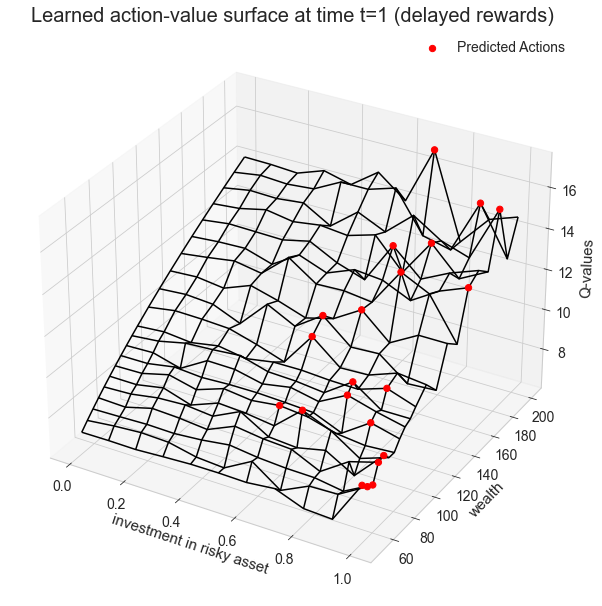

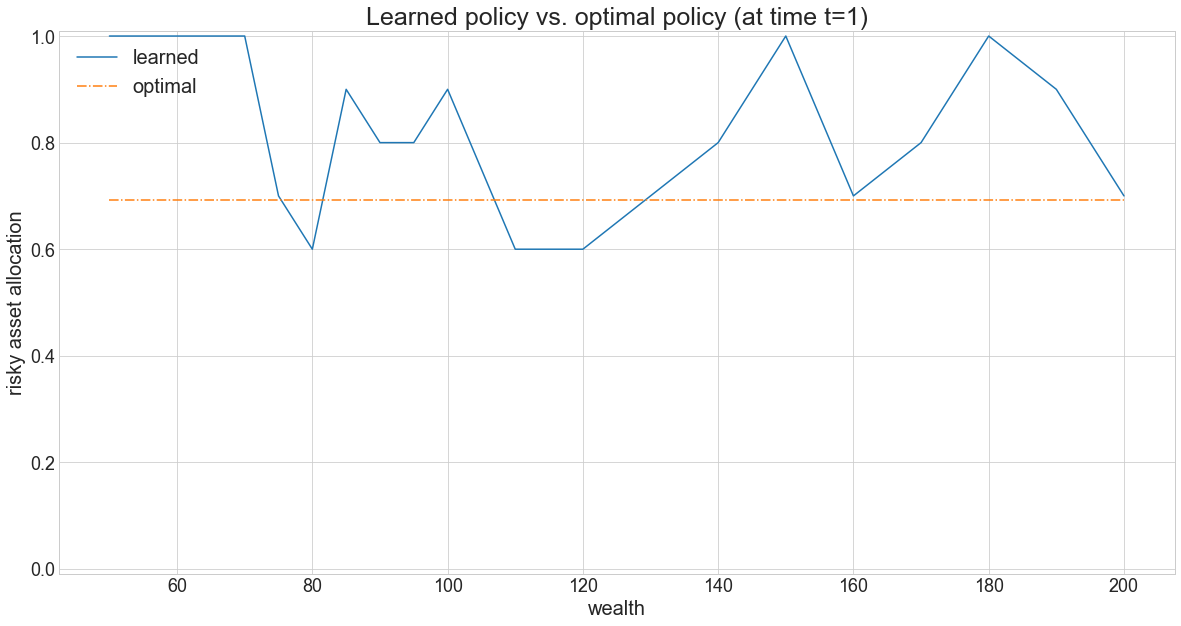

Episode: 10000, Mean Return: 10.407, Mean Wealth (V_T): 117.59, Epsilon: 1
Episode: 20000, Mean Return: 10.387, Mean Wealth (V_T): 117.298, Epsilon: 1
Episode: 30000, Mean Return: 10.383, Mean Wealth (V_T): 117.147, Epsilon: 1
Episode: 40000, Mean Return: 10.421, Mean Wealth (V_T): 117.752, Epsilon: 1
Episode: 50000, Mean Return: 10.338, Mean Wealth (V_T): 116.126, Epsilon: 1
Episode: 60000, Mean Return: 10.39, Mean Wealth (V_T): 116.982, Epsilon: 1
Episode: 70000, Mean Return: 10.391, Mean Wealth (V_T): 117.009, Epsilon: 1
Episode: 80000, Mean Return: 10.41, Mean Wealth (V_T): 117.762, Epsilon: 1
Episode: 90000, Mean Return: 10.395, Mean Wealth (V_T): 117.351, Epsilon: 1
Episode: 100000, Mean Return: 10.382, Mean Wealth (V_T): 117.111, Epsilon: 1
Episode: 110000, Mean Return: 10.418, Mean Wealth (V_T): 117.923, Epsilon: 1
Episode: 120000, Mean Return: 10.369, Mean Wealth (V_T): 116.728, Epsilon: 1
Episode: 130000, Mean Return: 10.386, Mean Wealth (V_T): 117.007, Epsilon: 1
Episode: 14

Episode: 1080000, Mean Return: 10.417, Mean Wealth (V_T): 117.78, Epsilon: 1
Episode: 1090000, Mean Return: 10.386, Mean Wealth (V_T): 117.344, Epsilon: 1
Episode: 1100000, Mean Return: 10.407, Mean Wealth (V_T): 117.512, Epsilon: 1
Episode: 1110000, Mean Return: 10.357, Mean Wealth (V_T): 116.6, Epsilon: 1
Episode: 1120000, Mean Return: 10.369, Mean Wealth (V_T): 116.631, Epsilon: 1
Episode: 1130000, Mean Return: 10.381, Mean Wealth (V_T): 117.145, Epsilon: 1
Episode: 1140000, Mean Return: 10.44, Mean Wealth (V_T): 118.389, Epsilon: 1
Episode: 1150000, Mean Return: 10.44, Mean Wealth (V_T): 118.35, Epsilon: 1
Episode: 1160000, Mean Return: 10.401, Mean Wealth (V_T): 117.541, Epsilon: 1
Episode: 1170000, Mean Return: 10.382, Mean Wealth (V_T): 116.976, Epsilon: 1
Episode: 1180000, Mean Return: 10.389, Mean Wealth (V_T): 116.985, Epsilon: 1
Episode: 1190000, Mean Return: 10.385, Mean Wealth (V_T): 117.06, Epsilon: 1
Episode: 1200000, Mean Return: 10.404, Mean Wealth (V_T): 117.713, Epsi

Episode: 2140000, Mean Return: 10.404, Mean Wealth (V_T): 117.681, Epsilon: 1
Episode: 2150000, Mean Return: 10.406, Mean Wealth (V_T): 117.544, Epsilon: 1
Episode: 2160000, Mean Return: 10.369, Mean Wealth (V_T): 116.815, Epsilon: 1
Episode: 2170000, Mean Return: 10.44, Mean Wealth (V_T): 118.299, Epsilon: 1
Episode: 2180000, Mean Return: 10.393, Mean Wealth (V_T): 117.301, Epsilon: 1
Episode: 2190000, Mean Return: 10.385, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 2200000, Mean Return: 10.421, Mean Wealth (V_T): 117.983, Epsilon: 1
Episode: 2210000, Mean Return: 10.4, Mean Wealth (V_T): 117.26, Epsilon: 1
Episode: 2220000, Mean Return: 10.334, Mean Wealth (V_T): 116.065, Epsilon: 1
Episode: 2230000, Mean Return: 10.361, Mean Wealth (V_T): 116.71, Epsilon: 1
Episode: 2240000, Mean Return: 10.368, Mean Wealth (V_T): 116.622, Epsilon: 1
Episode: 2250000, Mean Return: 10.399, Mean Wealth (V_T): 117.588, Epsilon: 1
Episode: 2260000, Mean Return: 10.411, Mean Wealth (V_T): 117.628, Ep

Episode: 3200000, Mean Return: 10.442, Mean Wealth (V_T): 118.304, Epsilon: 1
Episode: 3210000, Mean Return: 10.378, Mean Wealth (V_T): 117.002, Epsilon: 1
Episode: 3220000, Mean Return: 10.398, Mean Wealth (V_T): 117.379, Epsilon: 1
Episode: 3230000, Mean Return: 10.379, Mean Wealth (V_T): 116.827, Epsilon: 1
Episode: 3240000, Mean Return: 10.368, Mean Wealth (V_T): 116.584, Epsilon: 1
Episode: 3250000, Mean Return: 10.434, Mean Wealth (V_T): 118.336, Epsilon: 1
Episode: 3260000, Mean Return: 10.45, Mean Wealth (V_T): 118.551, Epsilon: 1
Episode: 3270000, Mean Return: 10.422, Mean Wealth (V_T): 117.908, Epsilon: 1
Episode: 3280000, Mean Return: 10.399, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 3290000, Mean Return: 10.363, Mean Wealth (V_T): 116.81, Epsilon: 1
Episode: 3300000, Mean Return: 10.395, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 3310000, Mean Return: 10.362, Mean Wealth (V_T): 116.542, Epsilon: 1
Episode: 3320000, Mean Return: 10.435, Mean Wealth (V_T): 118.234,

Episode: 4260000, Mean Return: 10.423, Mean Wealth (V_T): 118.173, Epsilon: 1
Episode: 4270000, Mean Return: 10.417, Mean Wealth (V_T): 117.776, Epsilon: 1
Episode: 4280000, Mean Return: 10.395, Mean Wealth (V_T): 117.332, Epsilon: 1
Episode: 4290000, Mean Return: 10.354, Mean Wealth (V_T): 116.246, Epsilon: 1
Episode: 4300000, Mean Return: 10.456, Mean Wealth (V_T): 118.621, Epsilon: 1
Episode: 4310000, Mean Return: 10.436, Mean Wealth (V_T): 118.1, Epsilon: 1
Episode: 4320000, Mean Return: 10.436, Mean Wealth (V_T): 118.342, Epsilon: 1
Episode: 4330000, Mean Return: 10.434, Mean Wealth (V_T): 118.221, Epsilon: 1
Episode: 4340000, Mean Return: 10.402, Mean Wealth (V_T): 117.585, Epsilon: 1
Episode: 4350000, Mean Return: 10.397, Mean Wealth (V_T): 117.512, Epsilon: 1
Episode: 4360000, Mean Return: 10.36, Mean Wealth (V_T): 116.626, Epsilon: 1
Episode: 4370000, Mean Return: 10.404, Mean Wealth (V_T): 117.497, Epsilon: 1
Episode: 4380000, Mean Return: 10.4, Mean Wealth (V_T): 117.495, Ep

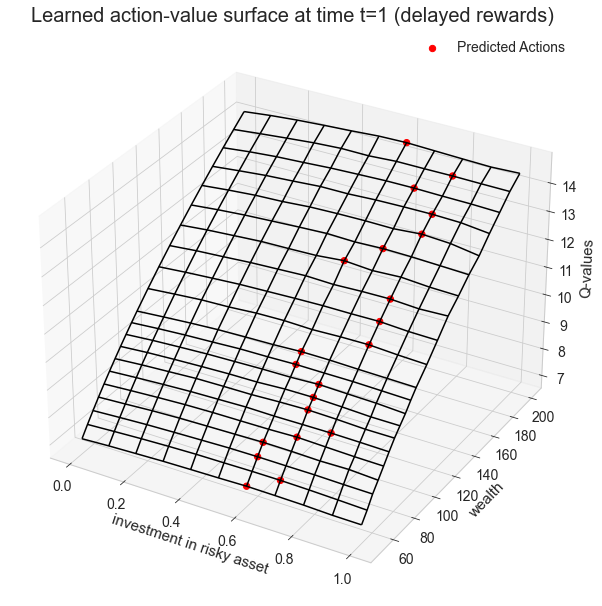

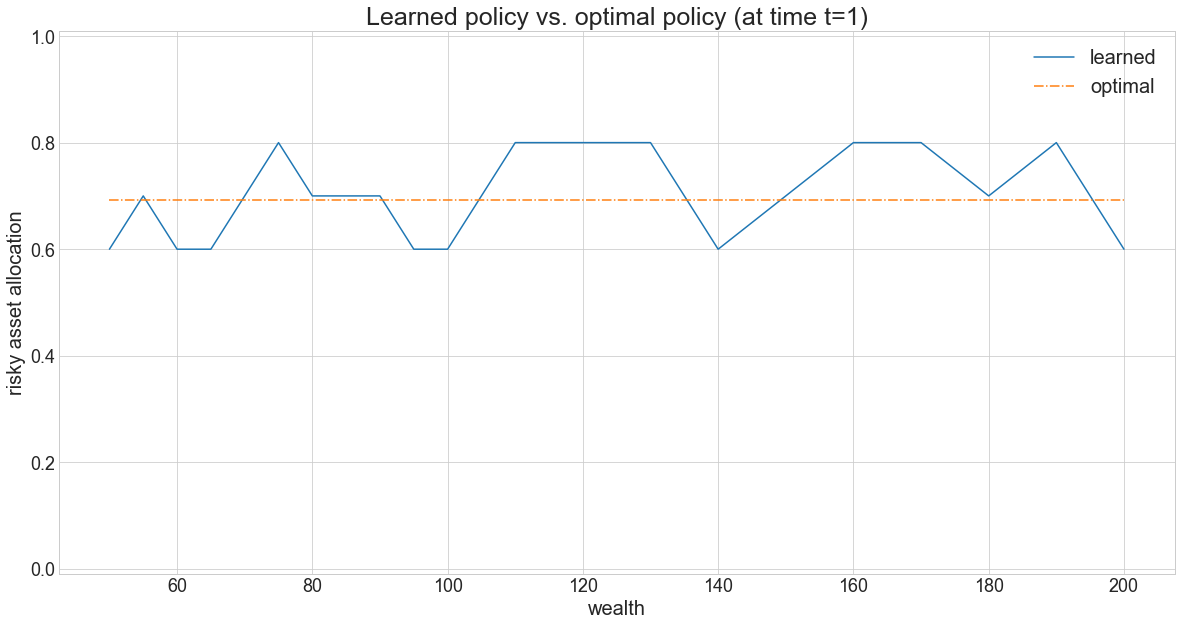

Episode: 5010000, Mean Return: 10.401, Mean Wealth (V_T): 117.631, Epsilon: 1
Episode: 5020000, Mean Return: 10.411, Mean Wealth (V_T): 117.568, Epsilon: 1
Episode: 5030000, Mean Return: 10.394, Mean Wealth (V_T): 117.606, Epsilon: 1
Episode: 5040000, Mean Return: 10.429, Mean Wealth (V_T): 118.278, Epsilon: 1
Episode: 5050000, Mean Return: 10.427, Mean Wealth (V_T): 117.953, Epsilon: 1
Episode: 5060000, Mean Return: 10.432, Mean Wealth (V_T): 118.416, Epsilon: 1
Episode: 5070000, Mean Return: 10.396, Mean Wealth (V_T): 117.235, Epsilon: 1
Episode: 5080000, Mean Return: 10.445, Mean Wealth (V_T): 118.564, Epsilon: 1
Episode: 5090000, Mean Return: 10.372, Mean Wealth (V_T): 116.816, Epsilon: 1
Episode: 5100000, Mean Return: 10.342, Mean Wealth (V_T): 116.186, Epsilon: 1
Episode: 5110000, Mean Return: 10.417, Mean Wealth (V_T): 117.979, Epsilon: 1
Episode: 5120000, Mean Return: 10.454, Mean Wealth (V_T): 118.807, Epsilon: 1
Episode: 5130000, Mean Return: 10.373, Mean Wealth (V_T): 117.22

Episode: 6070000, Mean Return: 10.402, Mean Wealth (V_T): 117.613, Epsilon: 1
Episode: 6080000, Mean Return: 10.373, Mean Wealth (V_T): 117.125, Epsilon: 1
Episode: 6090000, Mean Return: 10.385, Mean Wealth (V_T): 117.266, Epsilon: 1
Episode: 6100000, Mean Return: 10.395, Mean Wealth (V_T): 117.353, Epsilon: 1
Episode: 6110000, Mean Return: 10.356, Mean Wealth (V_T): 116.431, Epsilon: 1
Episode: 6120000, Mean Return: 10.399, Mean Wealth (V_T): 117.529, Epsilon: 1
Episode: 6130000, Mean Return: 10.373, Mean Wealth (V_T): 116.837, Epsilon: 1
Episode: 6140000, Mean Return: 10.401, Mean Wealth (V_T): 117.599, Epsilon: 1
Episode: 6150000, Mean Return: 10.372, Mean Wealth (V_T): 116.81, Epsilon: 1
Episode: 6160000, Mean Return: 10.369, Mean Wealth (V_T): 116.864, Epsilon: 1
Episode: 6170000, Mean Return: 10.373, Mean Wealth (V_T): 116.678, Epsilon: 1
Episode: 6180000, Mean Return: 10.45, Mean Wealth (V_T): 118.791, Epsilon: 1
Episode: 6190000, Mean Return: 10.367, Mean Wealth (V_T): 116.729,

Episode: 7130000, Mean Return: 10.322, Mean Wealth (V_T): 115.688, Epsilon: 1
Episode: 7140000, Mean Return: 10.405, Mean Wealth (V_T): 117.392, Epsilon: 1
Episode: 7150000, Mean Return: 10.366, Mean Wealth (V_T): 116.701, Epsilon: 1
Episode: 7160000, Mean Return: 10.397, Mean Wealth (V_T): 117.498, Epsilon: 1
Episode: 7170000, Mean Return: 10.396, Mean Wealth (V_T): 117.294, Epsilon: 1
Episode: 7180000, Mean Return: 10.435, Mean Wealth (V_T): 118.416, Epsilon: 1
Episode: 7190000, Mean Return: 10.346, Mean Wealth (V_T): 115.836, Epsilon: 1
Episode: 7200000, Mean Return: 10.381, Mean Wealth (V_T): 116.919, Epsilon: 1
Episode: 7210000, Mean Return: 10.439, Mean Wealth (V_T): 118.118, Epsilon: 1
Episode: 7220000, Mean Return: 10.378, Mean Wealth (V_T): 116.939, Epsilon: 1
Episode: 7230000, Mean Return: 10.369, Mean Wealth (V_T): 116.819, Epsilon: 1
Episode: 7240000, Mean Return: 10.395, Mean Wealth (V_T): 117.352, Epsilon: 1
Episode: 7250000, Mean Return: 10.388, Mean Wealth (V_T): 117.05

Episode: 8190000, Mean Return: 10.439, Mean Wealth (V_T): 118.278, Epsilon: 1
Episode: 8200000, Mean Return: 10.375, Mean Wealth (V_T): 116.964, Epsilon: 1
Episode: 8210000, Mean Return: 10.395, Mean Wealth (V_T): 117.317, Epsilon: 1
Episode: 8220000, Mean Return: 10.415, Mean Wealth (V_T): 117.633, Epsilon: 1
Episode: 8230000, Mean Return: 10.398, Mean Wealth (V_T): 117.436, Epsilon: 1
Episode: 8240000, Mean Return: 10.418, Mean Wealth (V_T): 117.749, Epsilon: 1
Episode: 8250000, Mean Return: 10.388, Mean Wealth (V_T): 116.973, Epsilon: 1
Episode: 8260000, Mean Return: 10.395, Mean Wealth (V_T): 117.302, Epsilon: 1
Episode: 8270000, Mean Return: 10.424, Mean Wealth (V_T): 117.935, Epsilon: 1
Episode: 8280000, Mean Return: 10.453, Mean Wealth (V_T): 118.745, Epsilon: 1
Episode: 8290000, Mean Return: 10.406, Mean Wealth (V_T): 117.586, Epsilon: 1
Episode: 8300000, Mean Return: 10.391, Mean Wealth (V_T): 117.264, Epsilon: 1
Episode: 8310000, Mean Return: 10.335, Mean Wealth (V_T): 116.00

Episode: 9250000, Mean Return: 10.309, Mean Wealth (V_T): 115.256, Epsilon: 1
Episode: 9260000, Mean Return: 10.392, Mean Wealth (V_T): 117.312, Epsilon: 1
Episode: 9270000, Mean Return: 10.453, Mean Wealth (V_T): 118.652, Epsilon: 1
Episode: 9280000, Mean Return: 10.384, Mean Wealth (V_T): 116.959, Epsilon: 1
Episode: 9290000, Mean Return: 10.423, Mean Wealth (V_T): 118.236, Epsilon: 1
Episode: 9300000, Mean Return: 10.43, Mean Wealth (V_T): 117.916, Epsilon: 1
Episode: 9310000, Mean Return: 10.422, Mean Wealth (V_T): 118.047, Epsilon: 1
Episode: 9320000, Mean Return: 10.458, Mean Wealth (V_T): 118.918, Epsilon: 1
Episode: 9330000, Mean Return: 10.41, Mean Wealth (V_T): 117.705, Epsilon: 1
Episode: 9340000, Mean Return: 10.464, Mean Wealth (V_T): 118.963, Epsilon: 1
Episode: 9350000, Mean Return: 10.429, Mean Wealth (V_T): 118.349, Epsilon: 1
Episode: 9360000, Mean Return: 10.417, Mean Wealth (V_T): 117.966, Epsilon: 1
Episode: 9370000, Mean Return: 10.367, Mean Wealth (V_T): 116.794,

Episode: 10300000, Mean Return: 10.398, Mean Wealth (V_T): 117.507, Epsilon: 1
Episode: 10310000, Mean Return: 10.375, Mean Wealth (V_T): 116.836, Epsilon: 1
Episode: 10320000, Mean Return: 10.424, Mean Wealth (V_T): 117.783, Epsilon: 1
Episode: 10330000, Mean Return: 10.342, Mean Wealth (V_T): 116.276, Epsilon: 1
Episode: 10340000, Mean Return: 10.399, Mean Wealth (V_T): 117.38, Epsilon: 1
Episode: 10350000, Mean Return: 10.406, Mean Wealth (V_T): 117.695, Epsilon: 1
Episode: 10360000, Mean Return: 10.382, Mean Wealth (V_T): 116.995, Epsilon: 1
Episode: 10370000, Mean Return: 10.393, Mean Wealth (V_T): 117.326, Epsilon: 1
Episode: 10380000, Mean Return: 10.423, Mean Wealth (V_T): 118.097, Epsilon: 1
Episode: 10390000, Mean Return: 10.418, Mean Wealth (V_T): 117.914, Epsilon: 1
Episode: 10400000, Mean Return: 10.369, Mean Wealth (V_T): 116.866, Epsilon: 1
Episode: 10410000, Mean Return: 10.451, Mean Wealth (V_T): 118.432, Epsilon: 1
Episode: 10420000, Mean Return: 10.413, Mean Wealth (

Episode: 11340000, Mean Return: 10.386, Mean Wealth (V_T): 117.117, Epsilon: 1
Episode: 11350000, Mean Return: 10.418, Mean Wealth (V_T): 117.801, Epsilon: 1
Episode: 11360000, Mean Return: 10.369, Mean Wealth (V_T): 116.815, Epsilon: 1
Episode: 11370000, Mean Return: 10.423, Mean Wealth (V_T): 117.989, Epsilon: 1
Episode: 11380000, Mean Return: 10.396, Mean Wealth (V_T): 117.399, Epsilon: 1
Episode: 11390000, Mean Return: 10.376, Mean Wealth (V_T): 116.636, Epsilon: 1
Episode: 11400000, Mean Return: 10.391, Mean Wealth (V_T): 117.026, Epsilon: 1
Episode: 11410000, Mean Return: 10.353, Mean Wealth (V_T): 116.284, Epsilon: 1
Episode: 11420000, Mean Return: 10.412, Mean Wealth (V_T): 117.843, Epsilon: 1
Episode: 11430000, Mean Return: 10.326, Mean Wealth (V_T): 115.816, Epsilon: 1
Episode: 11440000, Mean Return: 10.424, Mean Wealth (V_T): 117.941, Epsilon: 1
Episode: 11450000, Mean Return: 10.433, Mean Wealth (V_T): 118.436, Epsilon: 1
Episode: 11460000, Mean Return: 10.415, Mean Wealth 

Episode: 12380000, Mean Return: 10.387, Mean Wealth (V_T): 117.146, Epsilon: 1
Episode: 12390000, Mean Return: 10.367, Mean Wealth (V_T): 116.695, Epsilon: 1
Episode: 12400000, Mean Return: 10.401, Mean Wealth (V_T): 117.532, Epsilon: 1
Episode: 12410000, Mean Return: 10.385, Mean Wealth (V_T): 117.162, Epsilon: 1
Episode: 12420000, Mean Return: 10.364, Mean Wealth (V_T): 116.473, Epsilon: 1
Episode: 12430000, Mean Return: 10.412, Mean Wealth (V_T): 117.662, Epsilon: 1
Episode: 12440000, Mean Return: 10.417, Mean Wealth (V_T): 117.756, Epsilon: 1
Episode: 12450000, Mean Return: 10.405, Mean Wealth (V_T): 117.562, Epsilon: 1
Episode: 12460000, Mean Return: 10.366, Mean Wealth (V_T): 116.783, Epsilon: 1
Episode: 12470000, Mean Return: 10.378, Mean Wealth (V_T): 116.741, Epsilon: 1
Episode: 12480000, Mean Return: 10.403, Mean Wealth (V_T): 117.43, Epsilon: 1
Episode: 12490000, Mean Return: 10.39, Mean Wealth (V_T): 117.084, Epsilon: 1
Episode: 12500000, Mean Return: 10.353, Mean Wealth (V

Episode: 13420000, Mean Return: 10.436, Mean Wealth (V_T): 118.268, Epsilon: 1
Episode: 13430000, Mean Return: 10.358, Mean Wealth (V_T): 116.447, Epsilon: 1
Episode: 13440000, Mean Return: 10.388, Mean Wealth (V_T): 117.068, Epsilon: 1
Episode: 13450000, Mean Return: 10.396, Mean Wealth (V_T): 117.431, Epsilon: 1
Episode: 13460000, Mean Return: 10.355, Mean Wealth (V_T): 116.345, Epsilon: 1
Episode: 13470000, Mean Return: 10.405, Mean Wealth (V_T): 117.6, Epsilon: 1
Episode: 13480000, Mean Return: 10.365, Mean Wealth (V_T): 116.557, Epsilon: 1
Episode: 13490000, Mean Return: 10.409, Mean Wealth (V_T): 117.724, Epsilon: 1
Episode: 13500000, Mean Return: 10.421, Mean Wealth (V_T): 117.683, Epsilon: 1
Episode: 13510000, Mean Return: 10.388, Mean Wealth (V_T): 117.384, Epsilon: 1
Episode: 13520000, Mean Return: 10.355, Mean Wealth (V_T): 116.405, Epsilon: 1
Episode: 13530000, Mean Return: 10.394, Mean Wealth (V_T): 117.315, Epsilon: 1
Episode: 13540000, Mean Return: 10.387, Mean Wealth (V

Episode: 14460000, Mean Return: 10.375, Mean Wealth (V_T): 116.873, Epsilon: 1
Episode: 14470000, Mean Return: 10.459, Mean Wealth (V_T): 118.77, Epsilon: 1
Episode: 14480000, Mean Return: 10.391, Mean Wealth (V_T): 117.222, Epsilon: 1
Episode: 14490000, Mean Return: 10.391, Mean Wealth (V_T): 117.148, Epsilon: 1
Episode: 14500000, Mean Return: 10.387, Mean Wealth (V_T): 116.974, Epsilon: 1
Episode: 14510000, Mean Return: 10.399, Mean Wealth (V_T): 117.52, Epsilon: 1
Episode: 14520000, Mean Return: 10.334, Mean Wealth (V_T): 116.067, Epsilon: 1
Episode: 14530000, Mean Return: 10.427, Mean Wealth (V_T): 118.142, Epsilon: 1
Episode: 14540000, Mean Return: 10.429, Mean Wealth (V_T): 118.238, Epsilon: 1
Episode: 14550000, Mean Return: 10.416, Mean Wealth (V_T): 117.809, Epsilon: 1
Episode: 14560000, Mean Return: 10.448, Mean Wealth (V_T): 118.356, Epsilon: 1
Episode: 14570000, Mean Return: 10.394, Mean Wealth (V_T): 117.288, Epsilon: 1
Episode: 14580000, Mean Return: 10.367, Mean Wealth (V

Episode: 15500000, Mean Return: 10.37, Mean Wealth (V_T): 116.764, Epsilon: 1
Episode: 15510000, Mean Return: 10.469, Mean Wealth (V_T): 119.135, Epsilon: 1
Episode: 15520000, Mean Return: 10.379, Mean Wealth (V_T): 116.849, Epsilon: 1
Episode: 15530000, Mean Return: 10.405, Mean Wealth (V_T): 117.559, Epsilon: 1
Episode: 15540000, Mean Return: 10.404, Mean Wealth (V_T): 117.587, Epsilon: 1
Episode: 15550000, Mean Return: 10.387, Mean Wealth (V_T): 117.301, Epsilon: 1
Episode: 15560000, Mean Return: 10.399, Mean Wealth (V_T): 117.329, Epsilon: 1
Episode: 15570000, Mean Return: 10.427, Mean Wealth (V_T): 117.979, Epsilon: 1
Episode: 15580000, Mean Return: 10.368, Mean Wealth (V_T): 116.741, Epsilon: 1
Episode: 15590000, Mean Return: 10.438, Mean Wealth (V_T): 118.385, Epsilon: 1
Episode: 15600000, Mean Return: 10.38, Mean Wealth (V_T): 116.983, Epsilon: 1
Episode: 15610000, Mean Return: 10.39, Mean Wealth (V_T): 117.113, Epsilon: 1
Episode: 15620000, Mean Return: 10.396, Mean Wealth (V_

Episode: 16540000, Mean Return: 10.427, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 16550000, Mean Return: 10.457, Mean Wealth (V_T): 118.661, Epsilon: 1
Episode: 16560000, Mean Return: 10.409, Mean Wealth (V_T): 117.739, Epsilon: 1
Episode: 16570000, Mean Return: 10.404, Mean Wealth (V_T): 117.65, Epsilon: 1
Episode: 16580000, Mean Return: 10.46, Mean Wealth (V_T): 118.571, Epsilon: 1
Episode: 16590000, Mean Return: 10.381, Mean Wealth (V_T): 117.316, Epsilon: 1
Episode: 16600000, Mean Return: 10.412, Mean Wealth (V_T): 117.862, Epsilon: 1
Episode: 16610000, Mean Return: 10.363, Mean Wealth (V_T): 117.001, Epsilon: 1
Episode: 16620000, Mean Return: 10.34, Mean Wealth (V_T): 116.025, Epsilon: 1
Episode: 16630000, Mean Return: 10.393, Mean Wealth (V_T): 117.325, Epsilon: 1
Episode: 16640000, Mean Return: 10.384, Mean Wealth (V_T): 116.934, Epsilon: 1
Episode: 16650000, Mean Return: 10.448, Mean Wealth (V_T): 118.542, Epsilon: 1
Episode: 16660000, Mean Return: 10.396, Mean Wealth (V_T

Episode: 17580000, Mean Return: 10.354, Mean Wealth (V_T): 116.361, Epsilon: 1
Episode: 17590000, Mean Return: 10.439, Mean Wealth (V_T): 118.496, Epsilon: 1
Episode: 17600000, Mean Return: 10.355, Mean Wealth (V_T): 116.548, Epsilon: 1
Episode: 17610000, Mean Return: 10.406, Mean Wealth (V_T): 117.65, Epsilon: 1
Episode: 17620000, Mean Return: 10.396, Mean Wealth (V_T): 117.386, Epsilon: 1
Episode: 17630000, Mean Return: 10.43, Mean Wealth (V_T): 118.099, Epsilon: 1
Episode: 17640000, Mean Return: 10.387, Mean Wealth (V_T): 117.219, Epsilon: 1
Episode: 17650000, Mean Return: 10.423, Mean Wealth (V_T): 117.946, Epsilon: 1
Episode: 17660000, Mean Return: 10.442, Mean Wealth (V_T): 118.361, Epsilon: 1
Episode: 17670000, Mean Return: 10.374, Mean Wealth (V_T): 116.801, Epsilon: 1
Episode: 17680000, Mean Return: 10.442, Mean Wealth (V_T): 118.4, Epsilon: 1
Episode: 17690000, Mean Return: 10.425, Mean Wealth (V_T): 117.927, Epsilon: 1
Episode: 17700000, Mean Return: 10.394, Mean Wealth (V_T

Episode: 18620000, Mean Return: 10.403, Mean Wealth (V_T): 117.595, Epsilon: 1
Episode: 18630000, Mean Return: 10.42, Mean Wealth (V_T): 117.824, Epsilon: 1
Episode: 18640000, Mean Return: 10.4, Mean Wealth (V_T): 117.384, Epsilon: 1
Episode: 18650000, Mean Return: 10.373, Mean Wealth (V_T): 116.715, Epsilon: 1
Episode: 18660000, Mean Return: 10.395, Mean Wealth (V_T): 117.12, Epsilon: 1
Episode: 18670000, Mean Return: 10.404, Mean Wealth (V_T): 117.479, Epsilon: 1
Episode: 18680000, Mean Return: 10.453, Mean Wealth (V_T): 118.711, Epsilon: 1
Episode: 18690000, Mean Return: 10.377, Mean Wealth (V_T): 117.1, Epsilon: 1
Episode: 18700000, Mean Return: 10.4, Mean Wealth (V_T): 117.564, Epsilon: 1
Episode: 18710000, Mean Return: 10.409, Mean Wealth (V_T): 117.789, Epsilon: 1
Episode: 18720000, Mean Return: 10.391, Mean Wealth (V_T): 117.201, Epsilon: 1
Episode: 18730000, Mean Return: 10.354, Mean Wealth (V_T): 116.241, Epsilon: 1
Episode: 18740000, Mean Return: 10.446, Mean Wealth (V_T): 1

Episode: 19670000, Mean Return: 10.413, Mean Wealth (V_T): 117.815, Epsilon: 1
Episode: 19680000, Mean Return: 10.369, Mean Wealth (V_T): 116.689, Epsilon: 1
Episode: 19690000, Mean Return: 10.439, Mean Wealth (V_T): 118.38, Epsilon: 1
Episode: 19700000, Mean Return: 10.367, Mean Wealth (V_T): 116.943, Epsilon: 1
Episode: 19710000, Mean Return: 10.39, Mean Wealth (V_T): 117.255, Epsilon: 1
Episode: 19720000, Mean Return: 10.367, Mean Wealth (V_T): 116.657, Epsilon: 1
Episode: 19730000, Mean Return: 10.404, Mean Wealth (V_T): 117.628, Epsilon: 1
Episode: 19740000, Mean Return: 10.434, Mean Wealth (V_T): 118.331, Epsilon: 1
Episode: 19750000, Mean Return: 10.374, Mean Wealth (V_T): 116.911, Epsilon: 1
Episode: 19760000, Mean Return: 10.371, Mean Wealth (V_T): 116.854, Epsilon: 1
Episode: 19770000, Mean Return: 10.411, Mean Wealth (V_T): 117.481, Epsilon: 1
Episode: 19780000, Mean Return: 10.412, Mean Wealth (V_T): 117.869, Epsilon: 1
Episode: 19790000, Mean Return: 10.403, Mean Wealth (V

Episode: 20710000, Mean Return: 10.378, Mean Wealth (V_T): 116.923, Epsilon: 1
Episode: 20720000, Mean Return: 10.415, Mean Wealth (V_T): 117.726, Epsilon: 1
Episode: 20730000, Mean Return: 10.438, Mean Wealth (V_T): 118.507, Epsilon: 1
Episode: 20740000, Mean Return: 10.389, Mean Wealth (V_T): 117.247, Epsilon: 1
Episode: 20750000, Mean Return: 10.432, Mean Wealth (V_T): 118.021, Epsilon: 1
Episode: 20760000, Mean Return: 10.399, Mean Wealth (V_T): 117.243, Epsilon: 1
Episode: 20770000, Mean Return: 10.369, Mean Wealth (V_T): 116.649, Epsilon: 1
Episode: 20780000, Mean Return: 10.402, Mean Wealth (V_T): 117.62, Epsilon: 1
Episode: 20790000, Mean Return: 10.362, Mean Wealth (V_T): 116.688, Epsilon: 1
Episode: 20800000, Mean Return: 10.395, Mean Wealth (V_T): 117.381, Epsilon: 1
Episode: 20810000, Mean Return: 10.427, Mean Wealth (V_T): 118.184, Epsilon: 1
Episode: 20820000, Mean Return: 10.352, Mean Wealth (V_T): 116.464, Epsilon: 1
Episode: 20830000, Mean Return: 10.39, Mean Wealth (V

Episode: 21750000, Mean Return: 10.35, Mean Wealth (V_T): 116.404, Epsilon: 1
Episode: 21760000, Mean Return: 10.39, Mean Wealth (V_T): 117.238, Epsilon: 1
Episode: 21770000, Mean Return: 10.405, Mean Wealth (V_T): 117.693, Epsilon: 1
Episode: 21780000, Mean Return: 10.412, Mean Wealth (V_T): 117.642, Epsilon: 1
Episode: 21790000, Mean Return: 10.321, Mean Wealth (V_T): 115.725, Epsilon: 1
Episode: 21800000, Mean Return: 10.434, Mean Wealth (V_T): 118.241, Epsilon: 1
Episode: 21810000, Mean Return: 10.404, Mean Wealth (V_T): 117.595, Epsilon: 1
Episode: 21820000, Mean Return: 10.396, Mean Wealth (V_T): 117.627, Epsilon: 1
Episode: 21830000, Mean Return: 10.41, Mean Wealth (V_T): 117.571, Epsilon: 1
Episode: 21840000, Mean Return: 10.43, Mean Wealth (V_T): 118.057, Epsilon: 1
Episode: 21850000, Mean Return: 10.449, Mean Wealth (V_T): 118.405, Epsilon: 1
Episode: 21860000, Mean Return: 10.413, Mean Wealth (V_T): 117.742, Epsilon: 1
Episode: 21870000, Mean Return: 10.356, Mean Wealth (V_T

Episode: 22800000, Mean Return: 10.475, Mean Wealth (V_T): 119.165, Epsilon: 1
Episode: 22810000, Mean Return: 10.441, Mean Wealth (V_T): 118.451, Epsilon: 1
Episode: 22820000, Mean Return: 10.41, Mean Wealth (V_T): 117.573, Epsilon: 1
Episode: 22830000, Mean Return: 10.374, Mean Wealth (V_T): 116.909, Epsilon: 1
Episode: 22840000, Mean Return: 10.37, Mean Wealth (V_T): 116.809, Epsilon: 1
Episode: 22850000, Mean Return: 10.423, Mean Wealth (V_T): 117.784, Epsilon: 1
Episode: 22860000, Mean Return: 10.422, Mean Wealth (V_T): 118.079, Epsilon: 1
Episode: 22870000, Mean Return: 10.369, Mean Wealth (V_T): 116.599, Epsilon: 1
Episode: 22880000, Mean Return: 10.354, Mean Wealth (V_T): 116.311, Epsilon: 1
Episode: 22890000, Mean Return: 10.427, Mean Wealth (V_T): 118.073, Epsilon: 1
Episode: 22900000, Mean Return: 10.382, Mean Wealth (V_T): 117.225, Epsilon: 1
Episode: 22910000, Mean Return: 10.489, Mean Wealth (V_T): 119.362, Epsilon: 1
Episode: 22920000, Mean Return: 10.414, Mean Wealth (V

Episode: 23840000, Mean Return: 10.412, Mean Wealth (V_T): 117.615, Epsilon: 1
Episode: 23850000, Mean Return: 10.43, Mean Wealth (V_T): 118.003, Epsilon: 1
Episode: 23860000, Mean Return: 10.432, Mean Wealth (V_T): 118.169, Epsilon: 1
Episode: 23870000, Mean Return: 10.335, Mean Wealth (V_T): 115.978, Epsilon: 1
Episode: 23880000, Mean Return: 10.399, Mean Wealth (V_T): 117.413, Epsilon: 1
Episode: 23890000, Mean Return: 10.398, Mean Wealth (V_T): 117.229, Epsilon: 1
Episode: 23900000, Mean Return: 10.41, Mean Wealth (V_T): 117.574, Epsilon: 1
Episode: 23910000, Mean Return: 10.416, Mean Wealth (V_T): 117.796, Epsilon: 1
Episode: 23920000, Mean Return: 10.41, Mean Wealth (V_T): 117.64, Epsilon: 1
Episode: 23930000, Mean Return: 10.424, Mean Wealth (V_T): 117.99, Epsilon: 1
Episode: 23940000, Mean Return: 10.424, Mean Wealth (V_T): 117.955, Epsilon: 1
Episode: 23950000, Mean Return: 10.407, Mean Wealth (V_T): 117.577, Epsilon: 1
Episode: 23960000, Mean Return: 10.399, Mean Wealth (V_T)

Episode: 24880000, Mean Return: 10.431, Mean Wealth (V_T): 117.914, Epsilon: 1
Episode: 24890000, Mean Return: 10.442, Mean Wealth (V_T): 118.474, Epsilon: 1
Episode: 24900000, Mean Return: 10.456, Mean Wealth (V_T): 118.738, Epsilon: 1
Episode: 24910000, Mean Return: 10.339, Mean Wealth (V_T): 116.139, Epsilon: 1
Episode: 24920000, Mean Return: 10.434, Mean Wealth (V_T): 118.089, Epsilon: 1
Episode: 24930000, Mean Return: 10.372, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 24940000, Mean Return: 10.399, Mean Wealth (V_T): 117.287, Epsilon: 1
Episode: 24950000, Mean Return: 10.342, Mean Wealth (V_T): 116.241, Epsilon: 1
Episode: 24960000, Mean Return: 10.381, Mean Wealth (V_T): 117.042, Epsilon: 1
Episode: 24970000, Mean Return: 10.432, Mean Wealth (V_T): 118.342, Epsilon: 1
Episode: 24980000, Mean Return: 10.414, Mean Wealth (V_T): 117.873, Epsilon: 1
Episode: 24990000, Mean Return: 10.311, Mean Wealth (V_T): 115.52, Epsilon: 1
Episode: 25000000, Mean Return: 10.432, Mean Wealth (

Episode: 25920000, Mean Return: 10.44, Mean Wealth (V_T): 118.424, Epsilon: 1
Episode: 25930000, Mean Return: 10.371, Mean Wealth (V_T): 116.665, Epsilon: 1
Episode: 25940000, Mean Return: 10.416, Mean Wealth (V_T): 117.921, Epsilon: 1
Episode: 25950000, Mean Return: 10.436, Mean Wealth (V_T): 118.245, Epsilon: 1
Episode: 25960000, Mean Return: 10.407, Mean Wealth (V_T): 117.463, Epsilon: 1
Episode: 25970000, Mean Return: 10.388, Mean Wealth (V_T): 117.094, Epsilon: 1
Episode: 25980000, Mean Return: 10.428, Mean Wealth (V_T): 117.986, Epsilon: 1
Episode: 25990000, Mean Return: 10.372, Mean Wealth (V_T): 116.9, Epsilon: 1
Episode: 26000000, Mean Return: 10.421, Mean Wealth (V_T): 117.981, Epsilon: 1
Episode: 26010000, Mean Return: 10.36, Mean Wealth (V_T): 116.445, Epsilon: 1
Episode: 26020000, Mean Return: 10.448, Mean Wealth (V_T): 118.503, Epsilon: 1
Episode: 26030000, Mean Return: 10.415, Mean Wealth (V_T): 117.789, Epsilon: 1
Episode: 26040000, Mean Return: 10.368, Mean Wealth (V_T

Episode: 26970000, Mean Return: 10.417, Mean Wealth (V_T): 118.029, Epsilon: 1
Episode: 26980000, Mean Return: 10.372, Mean Wealth (V_T): 116.714, Epsilon: 1
Episode: 26990000, Mean Return: 10.422, Mean Wealth (V_T): 118.037, Epsilon: 1
Episode: 27000000, Mean Return: 10.356, Mean Wealth (V_T): 116.334, Epsilon: 1
Episode: 27010000, Mean Return: 10.401, Mean Wealth (V_T): 117.558, Epsilon: 1
Episode: 27020000, Mean Return: 10.338, Mean Wealth (V_T): 115.982, Epsilon: 1
Episode: 27030000, Mean Return: 10.399, Mean Wealth (V_T): 117.342, Epsilon: 1
Episode: 27040000, Mean Return: 10.384, Mean Wealth (V_T): 117.122, Epsilon: 1
Episode: 27050000, Mean Return: 10.388, Mean Wealth (V_T): 116.923, Epsilon: 1
Episode: 27060000, Mean Return: 10.411, Mean Wealth (V_T): 117.74, Epsilon: 1
Episode: 27070000, Mean Return: 10.368, Mean Wealth (V_T): 116.926, Epsilon: 1
Episode: 27080000, Mean Return: 10.392, Mean Wealth (V_T): 117.209, Epsilon: 1
Episode: 27090000, Mean Return: 10.328, Mean Wealth (

Episode: 28020000, Mean Return: 10.395, Mean Wealth (V_T): 117.133, Epsilon: 1
Episode: 28030000, Mean Return: 10.394, Mean Wealth (V_T): 117.441, Epsilon: 1
Episode: 28040000, Mean Return: 10.353, Mean Wealth (V_T): 116.446, Epsilon: 1
Episode: 28050000, Mean Return: 10.407, Mean Wealth (V_T): 117.631, Epsilon: 1
Episode: 28060000, Mean Return: 10.383, Mean Wealth (V_T): 116.964, Epsilon: 1
Episode: 28070000, Mean Return: 10.376, Mean Wealth (V_T): 116.806, Epsilon: 1
Episode: 28080000, Mean Return: 10.418, Mean Wealth (V_T): 117.963, Epsilon: 1
Episode: 28090000, Mean Return: 10.365, Mean Wealth (V_T): 116.627, Epsilon: 1
Episode: 28100000, Mean Return: 10.366, Mean Wealth (V_T): 116.813, Epsilon: 1
Episode: 28110000, Mean Return: 10.416, Mean Wealth (V_T): 117.725, Epsilon: 1
Episode: 28120000, Mean Return: 10.386, Mean Wealth (V_T): 117.002, Epsilon: 1
Episode: 28130000, Mean Return: 10.323, Mean Wealth (V_T): 115.686, Epsilon: 1
Episode: 28140000, Mean Return: 10.384, Mean Wealth 

Episode: 29060000, Mean Return: 10.354, Mean Wealth (V_T): 116.564, Epsilon: 1
Episode: 29070000, Mean Return: 10.385, Mean Wealth (V_T): 117.228, Epsilon: 1
Episode: 29080000, Mean Return: 10.419, Mean Wealth (V_T): 117.647, Epsilon: 1
Episode: 29090000, Mean Return: 10.399, Mean Wealth (V_T): 117.431, Epsilon: 1
Episode: 29100000, Mean Return: 10.404, Mean Wealth (V_T): 117.806, Epsilon: 1
Episode: 29110000, Mean Return: 10.395, Mean Wealth (V_T): 117.369, Epsilon: 1
Episode: 29120000, Mean Return: 10.393, Mean Wealth (V_T): 117.132, Epsilon: 1
Episode: 29130000, Mean Return: 10.386, Mean Wealth (V_T): 117.026, Epsilon: 1
Episode: 29140000, Mean Return: 10.458, Mean Wealth (V_T): 118.836, Epsilon: 1
Episode: 29150000, Mean Return: 10.426, Mean Wealth (V_T): 118.258, Epsilon: 1
Episode: 29160000, Mean Return: 10.409, Mean Wealth (V_T): 117.634, Epsilon: 1
Episode: 29170000, Mean Return: 10.373, Mean Wealth (V_T): 116.762, Epsilon: 1
Episode: 29180000, Mean Return: 10.391, Mean Wealth 

Episode: 30100000, Mean Return: 10.357, Mean Wealth (V_T): 116.354, Epsilon: 1
Episode: 30110000, Mean Return: 10.423, Mean Wealth (V_T): 117.876, Epsilon: 1
Episode: 30120000, Mean Return: 10.406, Mean Wealth (V_T): 117.563, Epsilon: 1
Episode: 30130000, Mean Return: 10.446, Mean Wealth (V_T): 118.659, Epsilon: 1
Episode: 30140000, Mean Return: 10.433, Mean Wealth (V_T): 118.153, Epsilon: 1
Episode: 30150000, Mean Return: 10.325, Mean Wealth (V_T): 115.819, Epsilon: 1
Episode: 30160000, Mean Return: 10.381, Mean Wealth (V_T): 117.104, Epsilon: 1
Episode: 30170000, Mean Return: 10.395, Mean Wealth (V_T): 117.217, Epsilon: 1
Episode: 30180000, Mean Return: 10.427, Mean Wealth (V_T): 118.064, Epsilon: 1
Episode: 30190000, Mean Return: 10.417, Mean Wealth (V_T): 117.934, Epsilon: 1
Episode: 30200000, Mean Return: 10.377, Mean Wealth (V_T): 116.836, Epsilon: 1
Episode: 30210000, Mean Return: 10.394, Mean Wealth (V_T): 117.276, Epsilon: 1
Episode: 30220000, Mean Return: 10.356, Mean Wealth 

Episode: 31140000, Mean Return: 10.346, Mean Wealth (V_T): 116.459, Epsilon: 1
Episode: 31150000, Mean Return: 10.437, Mean Wealth (V_T): 118.441, Epsilon: 1
Episode: 31160000, Mean Return: 10.425, Mean Wealth (V_T): 118.027, Epsilon: 1
Episode: 31170000, Mean Return: 10.424, Mean Wealth (V_T): 117.97, Epsilon: 1
Episode: 31180000, Mean Return: 10.362, Mean Wealth (V_T): 116.643, Epsilon: 1
Episode: 31190000, Mean Return: 10.413, Mean Wealth (V_T): 117.748, Epsilon: 1
Episode: 31200000, Mean Return: 10.343, Mean Wealth (V_T): 116.414, Epsilon: 1
Episode: 31210000, Mean Return: 10.366, Mean Wealth (V_T): 116.625, Epsilon: 1
Episode: 31220000, Mean Return: 10.391, Mean Wealth (V_T): 117.383, Epsilon: 1
Episode: 31230000, Mean Return: 10.488, Mean Wealth (V_T): 119.286, Epsilon: 1
Episode: 31240000, Mean Return: 10.374, Mean Wealth (V_T): 116.808, Epsilon: 1
Episode: 31250000, Mean Return: 10.412, Mean Wealth (V_T): 117.726, Epsilon: 1
Episode: 31260000, Mean Return: 10.418, Mean Wealth (

Episode: 32180000, Mean Return: 10.399, Mean Wealth (V_T): 117.512, Epsilon: 1
Episode: 32190000, Mean Return: 10.358, Mean Wealth (V_T): 116.55, Epsilon: 1
Episode: 32200000, Mean Return: 10.352, Mean Wealth (V_T): 116.329, Epsilon: 1
Episode: 32210000, Mean Return: 10.358, Mean Wealth (V_T): 116.275, Epsilon: 1
Episode: 32220000, Mean Return: 10.42, Mean Wealth (V_T): 118.206, Epsilon: 1
Episode: 32230000, Mean Return: 10.377, Mean Wealth (V_T): 116.998, Epsilon: 1
Episode: 32240000, Mean Return: 10.392, Mean Wealth (V_T): 117.274, Epsilon: 1
Episode: 32250000, Mean Return: 10.38, Mean Wealth (V_T): 116.935, Epsilon: 1
Episode: 32260000, Mean Return: 10.436, Mean Wealth (V_T): 118.173, Epsilon: 1
Episode: 32270000, Mean Return: 10.418, Mean Wealth (V_T): 118.014, Epsilon: 1
Episode: 32280000, Mean Return: 10.439, Mean Wealth (V_T): 118.168, Epsilon: 1
Episode: 32290000, Mean Return: 10.385, Mean Wealth (V_T): 117.213, Epsilon: 1
Episode: 32300000, Mean Return: 10.392, Mean Wealth (V_

Episode: 33220000, Mean Return: 10.508, Mean Wealth (V_T): 119.912, Epsilon: 1
Episode: 33230000, Mean Return: 10.38, Mean Wealth (V_T): 116.808, Epsilon: 1
Episode: 33240000, Mean Return: 10.368, Mean Wealth (V_T): 116.852, Epsilon: 1
Episode: 33250000, Mean Return: 10.41, Mean Wealth (V_T): 117.681, Epsilon: 1
Episode: 33260000, Mean Return: 10.41, Mean Wealth (V_T): 117.652, Epsilon: 1
Episode: 33270000, Mean Return: 10.413, Mean Wealth (V_T): 117.675, Epsilon: 1
Episode: 33280000, Mean Return: 10.329, Mean Wealth (V_T): 115.677, Epsilon: 1
Episode: 33290000, Mean Return: 10.351, Mean Wealth (V_T): 116.345, Epsilon: 1
Episode: 33300000, Mean Return: 10.348, Mean Wealth (V_T): 116.136, Epsilon: 1
Episode: 33310000, Mean Return: 10.398, Mean Wealth (V_T): 117.444, Epsilon: 1
Episode: 33320000, Mean Return: 10.348, Mean Wealth (V_T): 116.34, Epsilon: 1
Episode: 33330000, Mean Return: 10.39, Mean Wealth (V_T): 117.112, Epsilon: 1
Episode: 33340000, Mean Return: 10.397, Mean Wealth (V_T)

Episode: 34260000, Mean Return: 10.375, Mean Wealth (V_T): 116.826, Epsilon: 1
Episode: 34270000, Mean Return: 10.393, Mean Wealth (V_T): 117.304, Epsilon: 1
Episode: 34280000, Mean Return: 10.466, Mean Wealth (V_T): 118.961, Epsilon: 1
Episode: 34290000, Mean Return: 10.367, Mean Wealth (V_T): 116.652, Epsilon: 1
Episode: 34300000, Mean Return: 10.389, Mean Wealth (V_T): 117.395, Epsilon: 1
Episode: 34310000, Mean Return: 10.346, Mean Wealth (V_T): 116.199, Epsilon: 1
Episode: 34320000, Mean Return: 10.338, Mean Wealth (V_T): 116.07, Epsilon: 1
Episode: 34330000, Mean Return: 10.402, Mean Wealth (V_T): 117.642, Epsilon: 1
Episode: 34340000, Mean Return: 10.411, Mean Wealth (V_T): 117.669, Epsilon: 1
Episode: 34350000, Mean Return: 10.377, Mean Wealth (V_T): 117.023, Epsilon: 1
Episode: 34360000, Mean Return: 10.396, Mean Wealth (V_T): 117.268, Epsilon: 1
Episode: 34370000, Mean Return: 10.388, Mean Wealth (V_T): 117.122, Epsilon: 1
Episode: 34380000, Mean Return: 10.401, Mean Wealth (

Episode: 35300000, Mean Return: 10.422, Mean Wealth (V_T): 118.062, Epsilon: 1
Episode: 35310000, Mean Return: 10.429, Mean Wealth (V_T): 118.062, Epsilon: 1
Episode: 35320000, Mean Return: 10.371, Mean Wealth (V_T): 116.697, Epsilon: 1
Episode: 35330000, Mean Return: 10.373, Mean Wealth (V_T): 116.898, Epsilon: 1
Episode: 35340000, Mean Return: 10.329, Mean Wealth (V_T): 115.869, Epsilon: 1
Episode: 35350000, Mean Return: 10.365, Mean Wealth (V_T): 116.585, Epsilon: 1
Episode: 35360000, Mean Return: 10.418, Mean Wealth (V_T): 117.81, Epsilon: 1
Episode: 35370000, Mean Return: 10.395, Mean Wealth (V_T): 117.069, Epsilon: 1
Episode: 35380000, Mean Return: 10.424, Mean Wealth (V_T): 118.017, Epsilon: 1
Episode: 35390000, Mean Return: 10.442, Mean Wealth (V_T): 118.484, Epsilon: 1
Episode: 35400000, Mean Return: 10.424, Mean Wealth (V_T): 117.992, Epsilon: 1
Episode: 35410000, Mean Return: 10.404, Mean Wealth (V_T): 117.926, Epsilon: 1
Episode: 35420000, Mean Return: 10.412, Mean Wealth (

Episode: 36350000, Mean Return: 10.386, Mean Wealth (V_T): 117.157, Epsilon: 1
Episode: 36360000, Mean Return: 10.37, Mean Wealth (V_T): 116.653, Epsilon: 1
Episode: 36370000, Mean Return: 10.41, Mean Wealth (V_T): 117.667, Epsilon: 1
Episode: 36380000, Mean Return: 10.446, Mean Wealth (V_T): 118.523, Epsilon: 1
Episode: 36390000, Mean Return: 10.444, Mean Wealth (V_T): 118.401, Epsilon: 1
Episode: 36400000, Mean Return: 10.336, Mean Wealth (V_T): 116.195, Epsilon: 1
Episode: 36410000, Mean Return: 10.421, Mean Wealth (V_T): 117.818, Epsilon: 1
Episode: 36420000, Mean Return: 10.435, Mean Wealth (V_T): 118.467, Epsilon: 1
Episode: 36430000, Mean Return: 10.412, Mean Wealth (V_T): 117.593, Epsilon: 1
Episode: 36440000, Mean Return: 10.404, Mean Wealth (V_T): 117.573, Epsilon: 1
Episode: 36450000, Mean Return: 10.426, Mean Wealth (V_T): 118.372, Epsilon: 1
Episode: 36460000, Mean Return: 10.357, Mean Wealth (V_T): 116.529, Epsilon: 1
Episode: 36470000, Mean Return: 10.334, Mean Wealth (V

Episode: 37390000, Mean Return: 10.36, Mean Wealth (V_T): 116.673, Epsilon: 1
Episode: 37400000, Mean Return: 10.405, Mean Wealth (V_T): 117.528, Epsilon: 1
Episode: 37410000, Mean Return: 10.43, Mean Wealth (V_T): 117.961, Epsilon: 1
Episode: 37420000, Mean Return: 10.403, Mean Wealth (V_T): 117.468, Epsilon: 1
Episode: 37430000, Mean Return: 10.411, Mean Wealth (V_T): 117.714, Epsilon: 1
Episode: 37440000, Mean Return: 10.37, Mean Wealth (V_T): 116.787, Epsilon: 1
Episode: 37450000, Mean Return: 10.41, Mean Wealth (V_T): 117.633, Epsilon: 1
Episode: 37460000, Mean Return: 10.356, Mean Wealth (V_T): 116.41, Epsilon: 1
Episode: 37470000, Mean Return: 10.357, Mean Wealth (V_T): 116.556, Epsilon: 1
Episode: 37480000, Mean Return: 10.406, Mean Wealth (V_T): 117.474, Epsilon: 1
Episode: 37490000, Mean Return: 10.391, Mean Wealth (V_T): 117.25, Epsilon: 1
Episode: 37500000, Mean Return: 10.429, Mean Wealth (V_T): 118.099, Epsilon: 1
Episode: 37510000, Mean Return: 10.434, Mean Wealth (V_T):

Episode: 38440000, Mean Return: 10.4, Mean Wealth (V_T): 117.671, Epsilon: 1
Episode: 38450000, Mean Return: 10.398, Mean Wealth (V_T): 117.407, Epsilon: 1
Episode: 38460000, Mean Return: 10.41, Mean Wealth (V_T): 117.672, Epsilon: 1
Episode: 38470000, Mean Return: 10.38, Mean Wealth (V_T): 116.764, Epsilon: 1
Episode: 38480000, Mean Return: 10.448, Mean Wealth (V_T): 118.437, Epsilon: 1
Episode: 38490000, Mean Return: 10.368, Mean Wealth (V_T): 116.805, Epsilon: 1
Episode: 38500000, Mean Return: 10.419, Mean Wealth (V_T): 117.854, Epsilon: 1
Episode: 38510000, Mean Return: 10.355, Mean Wealth (V_T): 116.42, Epsilon: 1
Episode: 38520000, Mean Return: 10.396, Mean Wealth (V_T): 117.442, Epsilon: 1
Episode: 38530000, Mean Return: 10.371, Mean Wealth (V_T): 116.742, Epsilon: 1
Episode: 38540000, Mean Return: 10.415, Mean Wealth (V_T): 117.996, Epsilon: 1
Episode: 38550000, Mean Return: 10.387, Mean Wealth (V_T): 117.133, Epsilon: 1
Episode: 38560000, Mean Return: 10.392, Mean Wealth (V_T)

Episode: 39490000, Mean Return: 10.4, Mean Wealth (V_T): 117.535, Epsilon: 1
Episode: 39500000, Mean Return: 10.427, Mean Wealth (V_T): 118.134, Epsilon: 1
Episode: 39510000, Mean Return: 10.469, Mean Wealth (V_T): 118.885, Epsilon: 1
Episode: 39520000, Mean Return: 10.442, Mean Wealth (V_T): 118.551, Epsilon: 1
Episode: 39530000, Mean Return: 10.409, Mean Wealth (V_T): 117.697, Epsilon: 1
Episode: 39540000, Mean Return: 10.393, Mean Wealth (V_T): 117.319, Epsilon: 1
Episode: 39550000, Mean Return: 10.407, Mean Wealth (V_T): 117.561, Epsilon: 1
Episode: 39560000, Mean Return: 10.347, Mean Wealth (V_T): 116.233, Epsilon: 1
Episode: 39570000, Mean Return: 10.449, Mean Wealth (V_T): 118.508, Epsilon: 1
Episode: 39580000, Mean Return: 10.4, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 39590000, Mean Return: 10.339, Mean Wealth (V_T): 115.917, Epsilon: 1
Episode: 39600000, Mean Return: 10.346, Mean Wealth (V_T): 116.217, Epsilon: 1
Episode: 39610000, Mean Return: 10.397, Mean Wealth (V_T

Episode: 40540000, Mean Return: 10.369, Mean Wealth (V_T): 116.645, Epsilon: 1
Episode: 40550000, Mean Return: 10.384, Mean Wealth (V_T): 117.14, Epsilon: 1
Episode: 40560000, Mean Return: 10.425, Mean Wealth (V_T): 117.9, Epsilon: 1
Episode: 40570000, Mean Return: 10.414, Mean Wealth (V_T): 117.75, Epsilon: 1
Episode: 40580000, Mean Return: 10.418, Mean Wealth (V_T): 117.755, Epsilon: 1
Episode: 40590000, Mean Return: 10.371, Mean Wealth (V_T): 116.865, Epsilon: 1
Episode: 40600000, Mean Return: 10.306, Mean Wealth (V_T): 115.419, Epsilon: 1
Episode: 40610000, Mean Return: 10.363, Mean Wealth (V_T): 116.709, Epsilon: 1
Episode: 40620000, Mean Return: 10.429, Mean Wealth (V_T): 118.181, Epsilon: 1
Episode: 40630000, Mean Return: 10.342, Mean Wealth (V_T): 116.099, Epsilon: 1
Episode: 40640000, Mean Return: 10.45, Mean Wealth (V_T): 118.613, Epsilon: 1
Episode: 40650000, Mean Return: 10.419, Mean Wealth (V_T): 117.886, Epsilon: 1
Episode: 40660000, Mean Return: 10.411, Mean Wealth (V_T)

Episode: 41590000, Mean Return: 10.387, Mean Wealth (V_T): 117.178, Epsilon: 1
Episode: 41600000, Mean Return: 10.408, Mean Wealth (V_T): 117.528, Epsilon: 1
Episode: 41610000, Mean Return: 10.393, Mean Wealth (V_T): 117.167, Epsilon: 1
Episode: 41620000, Mean Return: 10.408, Mean Wealth (V_T): 117.457, Epsilon: 1
Episode: 41630000, Mean Return: 10.343, Mean Wealth (V_T): 116.274, Epsilon: 1
Episode: 41640000, Mean Return: 10.404, Mean Wealth (V_T): 117.592, Epsilon: 1
Episode: 41650000, Mean Return: 10.365, Mean Wealth (V_T): 116.785, Epsilon: 1
Episode: 41660000, Mean Return: 10.366, Mean Wealth (V_T): 116.642, Epsilon: 1
Episode: 41670000, Mean Return: 10.428, Mean Wealth (V_T): 117.985, Epsilon: 1
Episode: 41680000, Mean Return: 10.434, Mean Wealth (V_T): 118.166, Epsilon: 1
Episode: 41690000, Mean Return: 10.367, Mean Wealth (V_T): 116.739, Epsilon: 1
Episode: 41700000, Mean Return: 10.343, Mean Wealth (V_T): 116.182, Epsilon: 1
Episode: 41710000, Mean Return: 10.373, Mean Wealth 

Episode: 42630000, Mean Return: 10.41, Mean Wealth (V_T): 117.507, Epsilon: 1
Episode: 42640000, Mean Return: 10.416, Mean Wealth (V_T): 117.704, Epsilon: 1
Episode: 42650000, Mean Return: 10.385, Mean Wealth (V_T): 117.015, Epsilon: 1
Episode: 42660000, Mean Return: 10.402, Mean Wealth (V_T): 117.462, Epsilon: 1
Episode: 42670000, Mean Return: 10.393, Mean Wealth (V_T): 117.27, Epsilon: 1
Episode: 42680000, Mean Return: 10.439, Mean Wealth (V_T): 118.418, Epsilon: 1
Episode: 42690000, Mean Return: 10.348, Mean Wealth (V_T): 116.323, Epsilon: 1
Episode: 42700000, Mean Return: 10.445, Mean Wealth (V_T): 118.547, Epsilon: 1
Episode: 42710000, Mean Return: 10.406, Mean Wealth (V_T): 117.603, Epsilon: 1
Episode: 42720000, Mean Return: 10.411, Mean Wealth (V_T): 117.581, Epsilon: 1
Episode: 42730000, Mean Return: 10.408, Mean Wealth (V_T): 117.477, Epsilon: 1
Episode: 42740000, Mean Return: 10.405, Mean Wealth (V_T): 117.467, Epsilon: 1
Episode: 42750000, Mean Return: 10.398, Mean Wealth (V

Episode: 43680000, Mean Return: 10.415, Mean Wealth (V_T): 117.627, Epsilon: 1
Episode: 43690000, Mean Return: 10.432, Mean Wealth (V_T): 118.244, Epsilon: 1
Episode: 43700000, Mean Return: 10.401, Mean Wealth (V_T): 117.447, Epsilon: 1
Episode: 43710000, Mean Return: 10.397, Mean Wealth (V_T): 117.109, Epsilon: 1
Episode: 43720000, Mean Return: 10.395, Mean Wealth (V_T): 117.273, Epsilon: 1
Episode: 43730000, Mean Return: 10.382, Mean Wealth (V_T): 117.003, Epsilon: 1
Episode: 43740000, Mean Return: 10.419, Mean Wealth (V_T): 117.889, Epsilon: 1
Episode: 43750000, Mean Return: 10.443, Mean Wealth (V_T): 118.536, Epsilon: 1
Episode: 43760000, Mean Return: 10.413, Mean Wealth (V_T): 117.705, Epsilon: 1
Episode: 43770000, Mean Return: 10.384, Mean Wealth (V_T): 117.048, Epsilon: 1
Episode: 43780000, Mean Return: 10.419, Mean Wealth (V_T): 117.687, Epsilon: 1
Episode: 43790000, Mean Return: 10.394, Mean Wealth (V_T): 117.449, Epsilon: 1
Episode: 43800000, Mean Return: 10.429, Mean Wealth 

Episode: 44720000, Mean Return: 10.505, Mean Wealth (V_T): 119.889, Epsilon: 1
Episode: 44730000, Mean Return: 10.383, Mean Wealth (V_T): 117.091, Epsilon: 1
Episode: 44740000, Mean Return: 10.34, Mean Wealth (V_T): 115.944, Epsilon: 1
Episode: 44750000, Mean Return: 10.441, Mean Wealth (V_T): 118.419, Epsilon: 1
Episode: 44760000, Mean Return: 10.361, Mean Wealth (V_T): 116.526, Epsilon: 1
Episode: 44770000, Mean Return: 10.409, Mean Wealth (V_T): 117.442, Epsilon: 1
Episode: 44780000, Mean Return: 10.437, Mean Wealth (V_T): 118.384, Epsilon: 1
Episode: 44790000, Mean Return: 10.39, Mean Wealth (V_T): 117.074, Epsilon: 1
Episode: 44800000, Mean Return: 10.367, Mean Wealth (V_T): 116.671, Epsilon: 1
Episode: 44810000, Mean Return: 10.446, Mean Wealth (V_T): 118.533, Epsilon: 1
Episode: 44820000, Mean Return: 10.418, Mean Wealth (V_T): 117.885, Epsilon: 1
Episode: 44830000, Mean Return: 10.407, Mean Wealth (V_T): 117.813, Epsilon: 1
Episode: 44840000, Mean Return: 10.377, Mean Wealth (V

Episode: 45760000, Mean Return: 10.434, Mean Wealth (V_T): 118.261, Epsilon: 1
Episode: 45770000, Mean Return: 10.386, Mean Wealth (V_T): 117.003, Epsilon: 1
Episode: 45780000, Mean Return: 10.44, Mean Wealth (V_T): 118.427, Epsilon: 1
Episode: 45790000, Mean Return: 10.37, Mean Wealth (V_T): 116.696, Epsilon: 1
Episode: 45800000, Mean Return: 10.426, Mean Wealth (V_T): 118.098, Epsilon: 1
Episode: 45810000, Mean Return: 10.388, Mean Wealth (V_T): 117.14, Epsilon: 1
Episode: 45820000, Mean Return: 10.357, Mean Wealth (V_T): 116.273, Epsilon: 1
Episode: 45830000, Mean Return: 10.374, Mean Wealth (V_T): 116.863, Epsilon: 1
Episode: 45840000, Mean Return: 10.335, Mean Wealth (V_T): 115.87, Epsilon: 1
Episode: 45850000, Mean Return: 10.374, Mean Wealth (V_T): 116.824, Epsilon: 1
Episode: 45860000, Mean Return: 10.409, Mean Wealth (V_T): 117.886, Epsilon: 1
Episode: 45870000, Mean Return: 10.415, Mean Wealth (V_T): 117.713, Epsilon: 1
Episode: 45880000, Mean Return: 10.411, Mean Wealth (V_T

Episode: 46810000, Mean Return: 10.394, Mean Wealth (V_T): 117.363, Epsilon: 1
Episode: 46820000, Mean Return: 10.411, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 46830000, Mean Return: 10.377, Mean Wealth (V_T): 116.862, Epsilon: 1
Episode: 46840000, Mean Return: 10.398, Mean Wealth (V_T): 117.389, Epsilon: 1
Episode: 46850000, Mean Return: 10.392, Mean Wealth (V_T): 117.186, Epsilon: 1
Episode: 46860000, Mean Return: 10.435, Mean Wealth (V_T): 118.209, Epsilon: 1
Episode: 46870000, Mean Return: 10.405, Mean Wealth (V_T): 117.667, Epsilon: 1
Episode: 46880000, Mean Return: 10.375, Mean Wealth (V_T): 116.933, Epsilon: 1
Episode: 46890000, Mean Return: 10.41, Mean Wealth (V_T): 117.576, Epsilon: 1
Episode: 46900000, Mean Return: 10.358, Mean Wealth (V_T): 116.527, Epsilon: 1
Episode: 46910000, Mean Return: 10.444, Mean Wealth (V_T): 118.373, Epsilon: 1
Episode: 46920000, Mean Return: 10.423, Mean Wealth (V_T): 117.885, Epsilon: 1
Episode: 46930000, Mean Return: 10.39, Mean Wealth (V

Episode: 47850000, Mean Return: 10.422, Mean Wealth (V_T): 117.859, Epsilon: 1
Episode: 47860000, Mean Return: 10.454, Mean Wealth (V_T): 118.642, Epsilon: 1
Episode: 47870000, Mean Return: 10.363, Mean Wealth (V_T): 116.731, Epsilon: 1
Episode: 47880000, Mean Return: 10.344, Mean Wealth (V_T): 116.253, Epsilon: 1
Episode: 47890000, Mean Return: 10.39, Mean Wealth (V_T): 117.107, Epsilon: 1
Episode: 47900000, Mean Return: 10.371, Mean Wealth (V_T): 116.895, Epsilon: 1
Episode: 47910000, Mean Return: 10.364, Mean Wealth (V_T): 116.509, Epsilon: 1
Episode: 47920000, Mean Return: 10.395, Mean Wealth (V_T): 117.275, Epsilon: 1
Episode: 47930000, Mean Return: 10.435, Mean Wealth (V_T): 118.073, Epsilon: 1
Episode: 47940000, Mean Return: 10.368, Mean Wealth (V_T): 116.737, Epsilon: 1
Episode: 47950000, Mean Return: 10.394, Mean Wealth (V_T): 117.276, Epsilon: 1
Episode: 47960000, Mean Return: 10.393, Mean Wealth (V_T): 117.242, Epsilon: 1
Episode: 47970000, Mean Return: 10.372, Mean Wealth (

Episode: 48890000, Mean Return: 10.339, Mean Wealth (V_T): 115.961, Epsilon: 1
Episode: 48900000, Mean Return: 10.41, Mean Wealth (V_T): 117.509, Epsilon: 1
Episode: 48910000, Mean Return: 10.368, Mean Wealth (V_T): 116.931, Epsilon: 1
Episode: 48920000, Mean Return: 10.399, Mean Wealth (V_T): 117.656, Epsilon: 1
Episode: 48930000, Mean Return: 10.378, Mean Wealth (V_T): 117.173, Epsilon: 1
Episode: 48940000, Mean Return: 10.299, Mean Wealth (V_T): 115.467, Epsilon: 1
Episode: 48950000, Mean Return: 10.379, Mean Wealth (V_T): 116.729, Epsilon: 1
Episode: 48960000, Mean Return: 10.434, Mean Wealth (V_T): 118.212, Epsilon: 1
Episode: 48970000, Mean Return: 10.337, Mean Wealth (V_T): 116.014, Epsilon: 1
Episode: 48980000, Mean Return: 10.399, Mean Wealth (V_T): 117.277, Epsilon: 1
Episode: 48990000, Mean Return: 10.441, Mean Wealth (V_T): 118.268, Epsilon: 1
Episode: 49000000, Mean Return: 10.426, Mean Wealth (V_T): 118.069, Epsilon: 1
Episode: 49010000, Mean Return: 10.398, Mean Wealth (

Episode: 49940000, Mean Return: 10.408, Mean Wealth (V_T): 117.614, Epsilon: 1
Episode: 49950000, Mean Return: 10.415, Mean Wealth (V_T): 117.895, Epsilon: 1
Episode: 49960000, Mean Return: 10.378, Mean Wealth (V_T): 117.194, Epsilon: 1
Episode: 49970000, Mean Return: 10.423, Mean Wealth (V_T): 117.887, Epsilon: 1
Episode: 49980000, Mean Return: 10.42, Mean Wealth (V_T): 117.808, Epsilon: 1
Episode: 49990000, Mean Return: 10.326, Mean Wealth (V_T): 115.618, Epsilon: 1
Episode: 50000000, Mean Return: 10.437, Mean Wealth (V_T): 118.308, Epsilon: 1
Episode: 50010000, Mean Return: 10.361, Mean Wealth (V_T): 116.558, Epsilon: 1
Episode: 50020000, Mean Return: 10.4, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 50030000, Mean Return: 10.396, Mean Wealth (V_T): 117.179, Epsilon: 1
Episode: 50040000, Mean Return: 10.417, Mean Wealth (V_T): 117.958, Epsilon: 1
Episode: 50050000, Mean Return: 10.371, Mean Wealth (V_T): 116.756, Epsilon: 1
Episode: 50060000, Mean Return: 10.456, Mean Wealth (V_

Episode: 50990000, Mean Return: 10.424, Mean Wealth (V_T): 117.973, Epsilon: 1
Episode: 51000000, Mean Return: 10.403, Mean Wealth (V_T): 117.425, Epsilon: 1
Episode: 51010000, Mean Return: 10.406, Mean Wealth (V_T): 117.721, Epsilon: 1
Episode: 51020000, Mean Return: 10.416, Mean Wealth (V_T): 117.73, Epsilon: 1
Episode: 51030000, Mean Return: 10.379, Mean Wealth (V_T): 116.809, Epsilon: 1
Episode: 51040000, Mean Return: 10.407, Mean Wealth (V_T): 117.611, Epsilon: 1
Episode: 51050000, Mean Return: 10.467, Mean Wealth (V_T): 118.988, Epsilon: 1
Episode: 51060000, Mean Return: 10.415, Mean Wealth (V_T): 117.81, Epsilon: 1
Episode: 51070000, Mean Return: 10.369, Mean Wealth (V_T): 116.747, Epsilon: 1
Episode: 51080000, Mean Return: 10.364, Mean Wealth (V_T): 116.496, Epsilon: 1
Episode: 51090000, Mean Return: 10.425, Mean Wealth (V_T): 118.003, Epsilon: 1
Episode: 51100000, Mean Return: 10.395, Mean Wealth (V_T): 117.483, Epsilon: 1
Episode: 51110000, Mean Return: 10.402, Mean Wealth (V

Episode: 52030000, Mean Return: 10.461, Mean Wealth (V_T): 118.828, Epsilon: 1
Episode: 52040000, Mean Return: 10.371, Mean Wealth (V_T): 116.779, Epsilon: 1
Episode: 52050000, Mean Return: 10.436, Mean Wealth (V_T): 118.249, Epsilon: 1
Episode: 52060000, Mean Return: 10.422, Mean Wealth (V_T): 117.778, Epsilon: 1
Episode: 52070000, Mean Return: 10.391, Mean Wealth (V_T): 117.296, Epsilon: 1
Episode: 52080000, Mean Return: 10.375, Mean Wealth (V_T): 116.749, Epsilon: 1
Episode: 52090000, Mean Return: 10.423, Mean Wealth (V_T): 117.952, Epsilon: 1
Episode: 52100000, Mean Return: 10.41, Mean Wealth (V_T): 117.619, Epsilon: 1
Episode: 52110000, Mean Return: 10.389, Mean Wealth (V_T): 117.32, Epsilon: 1
Episode: 52120000, Mean Return: 10.415, Mean Wealth (V_T): 117.819, Epsilon: 1
Episode: 52130000, Mean Return: 10.431, Mean Wealth (V_T): 118.097, Epsilon: 1
Episode: 52140000, Mean Return: 10.448, Mean Wealth (V_T): 118.486, Epsilon: 1
Episode: 52150000, Mean Return: 10.386, Mean Wealth (V

Episode: 53070000, Mean Return: 10.433, Mean Wealth (V_T): 118.207, Epsilon: 1
Episode: 53080000, Mean Return: 10.418, Mean Wealth (V_T): 117.877, Epsilon: 1
Episode: 53090000, Mean Return: 10.39, Mean Wealth (V_T): 117.206, Epsilon: 1
Episode: 53100000, Mean Return: 10.414, Mean Wealth (V_T): 117.803, Epsilon: 1
Episode: 53110000, Mean Return: 10.399, Mean Wealth (V_T): 117.404, Epsilon: 1
Episode: 53120000, Mean Return: 10.391, Mean Wealth (V_T): 117.125, Epsilon: 1
Episode: 53130000, Mean Return: 10.408, Mean Wealth (V_T): 117.811, Epsilon: 1
Episode: 53140000, Mean Return: 10.421, Mean Wealth (V_T): 117.868, Epsilon: 1
Episode: 53150000, Mean Return: 10.405, Mean Wealth (V_T): 117.55, Epsilon: 1
Episode: 53160000, Mean Return: 10.414, Mean Wealth (V_T): 117.607, Epsilon: 1
Episode: 53170000, Mean Return: 10.436, Mean Wealth (V_T): 118.195, Epsilon: 1
Episode: 53180000, Mean Return: 10.367, Mean Wealth (V_T): 116.655, Epsilon: 1
Episode: 53190000, Mean Return: 10.363, Mean Wealth (V

Episode: 54120000, Mean Return: 10.386, Mean Wealth (V_T): 117.194, Epsilon: 1
Episode: 54130000, Mean Return: 10.364, Mean Wealth (V_T): 116.544, Epsilon: 1
Episode: 54140000, Mean Return: 10.426, Mean Wealth (V_T): 118.122, Epsilon: 1
Episode: 54150000, Mean Return: 10.35, Mean Wealth (V_T): 116.179, Epsilon: 1
Episode: 54160000, Mean Return: 10.401, Mean Wealth (V_T): 117.464, Epsilon: 1
Episode: 54170000, Mean Return: 10.417, Mean Wealth (V_T): 117.83, Epsilon: 1
Episode: 54180000, Mean Return: 10.378, Mean Wealth (V_T): 116.958, Epsilon: 1
Episode: 54190000, Mean Return: 10.346, Mean Wealth (V_T): 116.288, Epsilon: 1
Episode: 54200000, Mean Return: 10.36, Mean Wealth (V_T): 116.638, Epsilon: 1
Episode: 54210000, Mean Return: 10.393, Mean Wealth (V_T): 117.217, Epsilon: 1
Episode: 54220000, Mean Return: 10.4, Mean Wealth (V_T): 117.191, Epsilon: 1
Episode: 54230000, Mean Return: 10.452, Mean Wealth (V_T): 118.71, Epsilon: 1
Episode: 54240000, Mean Return: 10.39, Mean Wealth (V_T): 

Episode: 55170000, Mean Return: 10.374, Mean Wealth (V_T): 117.018, Epsilon: 1
Episode: 55180000, Mean Return: 10.309, Mean Wealth (V_T): 115.265, Epsilon: 1
Episode: 55190000, Mean Return: 10.377, Mean Wealth (V_T): 116.855, Epsilon: 1
Episode: 55200000, Mean Return: 10.407, Mean Wealth (V_T): 117.356, Epsilon: 1
Episode: 55210000, Mean Return: 10.439, Mean Wealth (V_T): 118.289, Epsilon: 1
Episode: 55220000, Mean Return: 10.396, Mean Wealth (V_T): 117.414, Epsilon: 1
Episode: 55230000, Mean Return: 10.367, Mean Wealth (V_T): 116.397, Epsilon: 1
Episode: 55240000, Mean Return: 10.355, Mean Wealth (V_T): 116.429, Epsilon: 1
Episode: 55250000, Mean Return: 10.378, Mean Wealth (V_T): 117.117, Epsilon: 1
Episode: 55260000, Mean Return: 10.389, Mean Wealth (V_T): 117.274, Epsilon: 1
Episode: 55270000, Mean Return: 10.386, Mean Wealth (V_T): 116.98, Epsilon: 1
Episode: 55280000, Mean Return: 10.385, Mean Wealth (V_T): 117.174, Epsilon: 1
Episode: 55290000, Mean Return: 10.378, Mean Wealth (

Episode: 56210000, Mean Return: 10.408, Mean Wealth (V_T): 117.638, Epsilon: 1
Episode: 56220000, Mean Return: 10.371, Mean Wealth (V_T): 116.738, Epsilon: 1
Episode: 56230000, Mean Return: 10.385, Mean Wealth (V_T): 117.085, Epsilon: 1
Episode: 56240000, Mean Return: 10.42, Mean Wealth (V_T): 117.939, Epsilon: 1
Episode: 56250000, Mean Return: 10.455, Mean Wealth (V_T): 118.752, Epsilon: 1
Episode: 56260000, Mean Return: 10.45, Mean Wealth (V_T): 118.661, Epsilon: 1
Episode: 56270000, Mean Return: 10.434, Mean Wealth (V_T): 118.214, Epsilon: 1
Episode: 56280000, Mean Return: 10.386, Mean Wealth (V_T): 117.066, Epsilon: 1
Episode: 56290000, Mean Return: 10.375, Mean Wealth (V_T): 116.81, Epsilon: 1
Episode: 56300000, Mean Return: 10.382, Mean Wealth (V_T): 117.076, Epsilon: 1
Episode: 56310000, Mean Return: 10.42, Mean Wealth (V_T): 118.018, Epsilon: 1
Episode: 56320000, Mean Return: 10.403, Mean Wealth (V_T): 117.449, Epsilon: 1
Episode: 56330000, Mean Return: 10.355, Mean Wealth (V_T

Episode: 57260000, Mean Return: 10.343, Mean Wealth (V_T): 116.185, Epsilon: 1
Episode: 57270000, Mean Return: 10.396, Mean Wealth (V_T): 117.399, Epsilon: 1
Episode: 57280000, Mean Return: 10.424, Mean Wealth (V_T): 118.148, Epsilon: 1
Episode: 57290000, Mean Return: 10.378, Mean Wealth (V_T): 116.74, Epsilon: 1
Episode: 57300000, Mean Return: 10.38, Mean Wealth (V_T): 117.1, Epsilon: 1
Episode: 57310000, Mean Return: 10.399, Mean Wealth (V_T): 117.562, Epsilon: 1
Episode: 57320000, Mean Return: 10.352, Mean Wealth (V_T): 116.466, Epsilon: 1
Episode: 57330000, Mean Return: 10.38, Mean Wealth (V_T): 116.875, Epsilon: 1
Episode: 57340000, Mean Return: 10.374, Mean Wealth (V_T): 116.793, Epsilon: 1
Episode: 57350000, Mean Return: 10.402, Mean Wealth (V_T): 117.161, Epsilon: 1
Episode: 57360000, Mean Return: 10.368, Mean Wealth (V_T): 116.788, Epsilon: 1
Episode: 57370000, Mean Return: 10.415, Mean Wealth (V_T): 117.82, Epsilon: 1
Episode: 57380000, Mean Return: 10.405, Mean Wealth (V_T):

Episode: 58310000, Mean Return: 10.365, Mean Wealth (V_T): 116.556, Epsilon: 1
Episode: 58320000, Mean Return: 10.468, Mean Wealth (V_T): 118.991, Epsilon: 1
Episode: 58330000, Mean Return: 10.362, Mean Wealth (V_T): 116.566, Epsilon: 1
Episode: 58340000, Mean Return: 10.378, Mean Wealth (V_T): 116.946, Epsilon: 1
Episode: 58350000, Mean Return: 10.394, Mean Wealth (V_T): 117.313, Epsilon: 1
Episode: 58360000, Mean Return: 10.454, Mean Wealth (V_T): 118.778, Epsilon: 1
Episode: 58370000, Mean Return: 10.369, Mean Wealth (V_T): 116.936, Epsilon: 1
Episode: 58380000, Mean Return: 10.363, Mean Wealth (V_T): 116.641, Epsilon: 1
Episode: 58390000, Mean Return: 10.373, Mean Wealth (V_T): 116.802, Epsilon: 1
Episode: 58400000, Mean Return: 10.352, Mean Wealth (V_T): 116.41, Epsilon: 1
Episode: 58410000, Mean Return: 10.436, Mean Wealth (V_T): 118.197, Epsilon: 1
Episode: 58420000, Mean Return: 10.404, Mean Wealth (V_T): 117.809, Epsilon: 1
Episode: 58430000, Mean Return: 10.419, Mean Wealth (

Episode: 59360000, Mean Return: 10.432, Mean Wealth (V_T): 118.006, Epsilon: 1
Episode: 59370000, Mean Return: 10.404, Mean Wealth (V_T): 117.832, Epsilon: 1
Episode: 59380000, Mean Return: 10.415, Mean Wealth (V_T): 117.913, Epsilon: 1
Episode: 59390000, Mean Return: 10.345, Mean Wealth (V_T): 116.321, Epsilon: 1
Episode: 59400000, Mean Return: 10.354, Mean Wealth (V_T): 116.519, Epsilon: 1
Episode: 59410000, Mean Return: 10.362, Mean Wealth (V_T): 116.542, Epsilon: 1
Episode: 59420000, Mean Return: 10.34, Mean Wealth (V_T): 116.055, Epsilon: 1
Episode: 59430000, Mean Return: 10.434, Mean Wealth (V_T): 118.099, Epsilon: 1
Episode: 59440000, Mean Return: 10.367, Mean Wealth (V_T): 116.917, Epsilon: 1
Episode: 59450000, Mean Return: 10.412, Mean Wealth (V_T): 117.708, Epsilon: 1
Episode: 59460000, Mean Return: 10.389, Mean Wealth (V_T): 117.155, Epsilon: 1
Episode: 59470000, Mean Return: 10.349, Mean Wealth (V_T): 116.241, Epsilon: 1
Episode: 59480000, Mean Return: 10.376, Mean Wealth (

Episode: 60400000, Mean Return: 10.372, Mean Wealth (V_T): 116.849, Epsilon: 1
Episode: 60410000, Mean Return: 10.393, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 60420000, Mean Return: 10.42, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 60430000, Mean Return: 10.401, Mean Wealth (V_T): 117.471, Epsilon: 1
Episode: 60440000, Mean Return: 10.44, Mean Wealth (V_T): 118.159, Epsilon: 1
Episode: 60450000, Mean Return: 10.406, Mean Wealth (V_T): 117.461, Epsilon: 1
Episode: 60460000, Mean Return: 10.39, Mean Wealth (V_T): 117.164, Epsilon: 1
Episode: 60470000, Mean Return: 10.348, Mean Wealth (V_T): 116.331, Epsilon: 1
Episode: 60480000, Mean Return: 10.44, Mean Wealth (V_T): 118.475, Epsilon: 1
Episode: 60490000, Mean Return: 10.36, Mean Wealth (V_T): 116.715, Epsilon: 1
Episode: 60500000, Mean Return: 10.435, Mean Wealth (V_T): 118.211, Epsilon: 1
Episode: 60510000, Mean Return: 10.372, Mean Wealth (V_T): 116.825, Epsilon: 1
Episode: 60520000, Mean Return: 10.402, Mean Wealth (V_T)

Episode: 61450000, Mean Return: 10.351, Mean Wealth (V_T): 116.373, Epsilon: 1
Episode: 61460000, Mean Return: 10.38, Mean Wealth (V_T): 116.924, Epsilon: 1
Episode: 61470000, Mean Return: 10.423, Mean Wealth (V_T): 117.888, Epsilon: 1
Episode: 61480000, Mean Return: 10.397, Mean Wealth (V_T): 117.478, Epsilon: 1
Episode: 61490000, Mean Return: 10.383, Mean Wealth (V_T): 117.014, Epsilon: 1
Episode: 61500000, Mean Return: 10.364, Mean Wealth (V_T): 116.756, Epsilon: 1
Episode: 61510000, Mean Return: 10.425, Mean Wealth (V_T): 117.971, Epsilon: 1
Episode: 61520000, Mean Return: 10.4, Mean Wealth (V_T): 117.423, Epsilon: 1
Episode: 61530000, Mean Return: 10.408, Mean Wealth (V_T): 117.823, Epsilon: 1
Episode: 61540000, Mean Return: 10.414, Mean Wealth (V_T): 117.935, Epsilon: 1
Episode: 61550000, Mean Return: 10.351, Mean Wealth (V_T): 116.309, Epsilon: 1
Episode: 61560000, Mean Return: 10.363, Mean Wealth (V_T): 116.847, Epsilon: 1
Episode: 61570000, Mean Return: 10.467, Mean Wealth (V_

Episode: 62490000, Mean Return: 10.352, Mean Wealth (V_T): 116.153, Epsilon: 1
Episode: 62500000, Mean Return: 10.423, Mean Wealth (V_T): 118.099, Epsilon: 1
Episode: 62510000, Mean Return: 10.401, Mean Wealth (V_T): 117.354, Epsilon: 1
Episode: 62520000, Mean Return: 10.411, Mean Wealth (V_T): 117.693, Epsilon: 1
Episode: 62530000, Mean Return: 10.435, Mean Wealth (V_T): 118.138, Epsilon: 1
Episode: 62540000, Mean Return: 10.399, Mean Wealth (V_T): 117.337, Epsilon: 1
Episode: 62550000, Mean Return: 10.383, Mean Wealth (V_T): 117.165, Epsilon: 1
Episode: 62560000, Mean Return: 10.453, Mean Wealth (V_T): 118.757, Epsilon: 1
Episode: 62570000, Mean Return: 10.353, Mean Wealth (V_T): 116.308, Epsilon: 1
Episode: 62580000, Mean Return: 10.394, Mean Wealth (V_T): 117.184, Epsilon: 1
Episode: 62590000, Mean Return: 10.434, Mean Wealth (V_T): 118.288, Epsilon: 1
Episode: 62600000, Mean Return: 10.376, Mean Wealth (V_T): 116.711, Epsilon: 1
Episode: 62610000, Mean Return: 10.395, Mean Wealth 

Episode: 63530000, Mean Return: 10.371, Mean Wealth (V_T): 116.756, Epsilon: 1
Episode: 63540000, Mean Return: 10.381, Mean Wealth (V_T): 116.978, Epsilon: 1
Episode: 63550000, Mean Return: 10.387, Mean Wealth (V_T): 117.172, Epsilon: 1
Episode: 63560000, Mean Return: 10.441, Mean Wealth (V_T): 118.438, Epsilon: 1
Episode: 63570000, Mean Return: 10.381, Mean Wealth (V_T): 116.902, Epsilon: 1
Episode: 63580000, Mean Return: 10.409, Mean Wealth (V_T): 117.598, Epsilon: 1
Episode: 63590000, Mean Return: 10.372, Mean Wealth (V_T): 116.702, Epsilon: 1
Episode: 63600000, Mean Return: 10.459, Mean Wealth (V_T): 118.878, Epsilon: 1
Episode: 63610000, Mean Return: 10.421, Mean Wealth (V_T): 118.019, Epsilon: 1
Episode: 63620000, Mean Return: 10.381, Mean Wealth (V_T): 116.841, Epsilon: 1
Episode: 63630000, Mean Return: 10.408, Mean Wealth (V_T): 117.485, Epsilon: 1
Episode: 63640000, Mean Return: 10.428, Mean Wealth (V_T): 118.158, Epsilon: 1
Episode: 63650000, Mean Return: 10.45, Mean Wealth (

Episode: 64570000, Mean Return: 10.398, Mean Wealth (V_T): 117.58, Epsilon: 1
Episode: 64580000, Mean Return: 10.359, Mean Wealth (V_T): 116.436, Epsilon: 1
Episode: 64590000, Mean Return: 10.346, Mean Wealth (V_T): 116.446, Epsilon: 1
Episode: 64600000, Mean Return: 10.357, Mean Wealth (V_T): 116.488, Epsilon: 1
Episode: 64610000, Mean Return: 10.374, Mean Wealth (V_T): 116.896, Epsilon: 1
Episode: 64620000, Mean Return: 10.401, Mean Wealth (V_T): 117.326, Epsilon: 1
Episode: 64630000, Mean Return: 10.408, Mean Wealth (V_T): 117.756, Epsilon: 1
Episode: 64640000, Mean Return: 10.394, Mean Wealth (V_T): 117.143, Epsilon: 1
Episode: 64650000, Mean Return: 10.42, Mean Wealth (V_T): 118.032, Epsilon: 1
Episode: 64660000, Mean Return: 10.38, Mean Wealth (V_T): 116.968, Epsilon: 1
Episode: 64670000, Mean Return: 10.417, Mean Wealth (V_T): 117.632, Epsilon: 1
Episode: 64680000, Mean Return: 10.367, Mean Wealth (V_T): 116.69, Epsilon: 1
Episode: 64690000, Mean Return: 10.371, Mean Wealth (V_T

Episode: 65610000, Mean Return: 10.413, Mean Wealth (V_T): 117.697, Epsilon: 1
Episode: 65620000, Mean Return: 10.415, Mean Wealth (V_T): 117.655, Epsilon: 1
Episode: 65630000, Mean Return: 10.403, Mean Wealth (V_T): 117.538, Epsilon: 1
Episode: 65640000, Mean Return: 10.429, Mean Wealth (V_T): 117.958, Epsilon: 1
Episode: 65650000, Mean Return: 10.387, Mean Wealth (V_T): 117.061, Epsilon: 1
Episode: 65660000, Mean Return: 10.442, Mean Wealth (V_T): 118.263, Epsilon: 1
Episode: 65670000, Mean Return: 10.401, Mean Wealth (V_T): 117.264, Epsilon: 1
Episode: 65680000, Mean Return: 10.396, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 65690000, Mean Return: 10.367, Mean Wealth (V_T): 116.694, Epsilon: 1
Episode: 65700000, Mean Return: 10.423, Mean Wealth (V_T): 117.937, Epsilon: 1
Episode: 65710000, Mean Return: 10.389, Mean Wealth (V_T): 117.115, Epsilon: 1
Episode: 65720000, Mean Return: 10.406, Mean Wealth (V_T): 117.733, Epsilon: 1
Episode: 65730000, Mean Return: 10.367, Mean Wealth (

Episode: 66650000, Mean Return: 10.403, Mean Wealth (V_T): 117.497, Epsilon: 1
Episode: 66660000, Mean Return: 10.44, Mean Wealth (V_T): 118.484, Epsilon: 1
Episode: 66670000, Mean Return: 10.357, Mean Wealth (V_T): 116.35, Epsilon: 1
Episode: 66680000, Mean Return: 10.425, Mean Wealth (V_T): 117.997, Epsilon: 1
Episode: 66690000, Mean Return: 10.388, Mean Wealth (V_T): 117.006, Epsilon: 1
Episode: 66700000, Mean Return: 10.36, Mean Wealth (V_T): 116.386, Epsilon: 1
Episode: 66710000, Mean Return: 10.432, Mean Wealth (V_T): 118.173, Epsilon: 1
Episode: 66720000, Mean Return: 10.441, Mean Wealth (V_T): 118.283, Epsilon: 1
Episode: 66730000, Mean Return: 10.399, Mean Wealth (V_T): 117.333, Epsilon: 1
Episode: 66740000, Mean Return: 10.386, Mean Wealth (V_T): 117.145, Epsilon: 1
Episode: 66750000, Mean Return: 10.415, Mean Wealth (V_T): 117.654, Epsilon: 1
Episode: 66760000, Mean Return: 10.399, Mean Wealth (V_T): 117.246, Epsilon: 1
Episode: 66770000, Mean Return: 10.385, Mean Wealth (V_

Episode: 67690000, Mean Return: 10.37, Mean Wealth (V_T): 116.904, Epsilon: 1
Episode: 67700000, Mean Return: 10.402, Mean Wealth (V_T): 117.503, Epsilon: 1
Episode: 67710000, Mean Return: 10.439, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 67720000, Mean Return: 10.378, Mean Wealth (V_T): 116.923, Epsilon: 1
Episode: 67730000, Mean Return: 10.396, Mean Wealth (V_T): 117.288, Epsilon: 1
Episode: 67740000, Mean Return: 10.344, Mean Wealth (V_T): 115.94, Epsilon: 1
Episode: 67750000, Mean Return: 10.44, Mean Wealth (V_T): 118.333, Epsilon: 1
Episode: 67760000, Mean Return: 10.352, Mean Wealth (V_T): 116.239, Epsilon: 1
Episode: 67770000, Mean Return: 10.41, Mean Wealth (V_T): 117.608, Epsilon: 1
Episode: 67780000, Mean Return: 10.368, Mean Wealth (V_T): 116.667, Epsilon: 1
Episode: 67790000, Mean Return: 10.411, Mean Wealth (V_T): 117.751, Epsilon: 1
Episode: 67800000, Mean Return: 10.416, Mean Wealth (V_T): 117.907, Epsilon: 1
Episode: 67810000, Mean Return: 10.411, Mean Wealth (V_T)

Episode: 68740000, Mean Return: 10.368, Mean Wealth (V_T): 116.711, Epsilon: 1
Episode: 68750000, Mean Return: 10.38, Mean Wealth (V_T): 117.047, Epsilon: 1
Episode: 68760000, Mean Return: 10.395, Mean Wealth (V_T): 117.195, Epsilon: 1
Episode: 68770000, Mean Return: 10.4, Mean Wealth (V_T): 117.452, Epsilon: 1
Episode: 68780000, Mean Return: 10.417, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 68790000, Mean Return: 10.363, Mean Wealth (V_T): 116.614, Epsilon: 1
Episode: 68800000, Mean Return: 10.395, Mean Wealth (V_T): 117.398, Epsilon: 1
Episode: 68810000, Mean Return: 10.342, Mean Wealth (V_T): 115.993, Epsilon: 1
Episode: 68820000, Mean Return: 10.382, Mean Wealth (V_T): 117.091, Epsilon: 1
Episode: 68830000, Mean Return: 10.338, Mean Wealth (V_T): 115.962, Epsilon: 1
Episode: 68840000, Mean Return: 10.373, Mean Wealth (V_T): 116.759, Epsilon: 1
Episode: 68850000, Mean Return: 10.362, Mean Wealth (V_T): 116.597, Epsilon: 1
Episode: 68860000, Mean Return: 10.433, Mean Wealth (V_

Episode: 69790000, Mean Return: 10.397, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 69800000, Mean Return: 10.359, Mean Wealth (V_T): 116.581, Epsilon: 1
Episode: 69810000, Mean Return: 10.338, Mean Wealth (V_T): 115.97, Epsilon: 1
Episode: 69820000, Mean Return: 10.345, Mean Wealth (V_T): 116.242, Epsilon: 1
Episode: 69830000, Mean Return: 10.405, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 69840000, Mean Return: 10.383, Mean Wealth (V_T): 116.997, Epsilon: 1
Episode: 69850000, Mean Return: 10.4, Mean Wealth (V_T): 117.57, Epsilon: 1
Episode: 69860000, Mean Return: 10.414, Mean Wealth (V_T): 117.735, Epsilon: 1
Episode: 69870000, Mean Return: 10.403, Mean Wealth (V_T): 117.74, Epsilon: 1
Episode: 69880000, Mean Return: 10.357, Mean Wealth (V_T): 116.506, Epsilon: 1
Episode: 69890000, Mean Return: 10.404, Mean Wealth (V_T): 117.527, Epsilon: 1
Episode: 69900000, Mean Return: 10.411, Mean Wealth (V_T): 117.81, Epsilon: 1
Episode: 69910000, Mean Return: 10.414, Mean Wealth (V_T):

Episode: 70840000, Mean Return: 10.4, Mean Wealth (V_T): 117.554, Epsilon: 1
Episode: 70850000, Mean Return: 10.456, Mean Wealth (V_T): 118.709, Epsilon: 1
Episode: 70860000, Mean Return: 10.411, Mean Wealth (V_T): 117.584, Epsilon: 1
Episode: 70870000, Mean Return: 10.39, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 70880000, Mean Return: 10.367, Mean Wealth (V_T): 116.695, Epsilon: 1
Episode: 70890000, Mean Return: 10.377, Mean Wealth (V_T): 116.861, Epsilon: 1
Episode: 70900000, Mean Return: 10.344, Mean Wealth (V_T): 116.212, Epsilon: 1
Episode: 70910000, Mean Return: 10.38, Mean Wealth (V_T): 117.067, Epsilon: 1
Episode: 70920000, Mean Return: 10.4, Mean Wealth (V_T): 117.442, Epsilon: 1
Episode: 70930000, Mean Return: 10.413, Mean Wealth (V_T): 117.646, Epsilon: 1
Episode: 70940000, Mean Return: 10.453, Mean Wealth (V_T): 118.749, Epsilon: 1
Episode: 70950000, Mean Return: 10.443, Mean Wealth (V_T): 118.292, Epsilon: 1
Episode: 70960000, Mean Return: 10.419, Mean Wealth (V_T):

Episode: 71890000, Mean Return: 10.415, Mean Wealth (V_T): 117.918, Epsilon: 1
Episode: 71900000, Mean Return: 10.327, Mean Wealth (V_T): 115.689, Epsilon: 1
Episode: 71910000, Mean Return: 10.404, Mean Wealth (V_T): 117.572, Epsilon: 1
Episode: 71920000, Mean Return: 10.336, Mean Wealth (V_T): 116.225, Epsilon: 1
Episode: 71930000, Mean Return: 10.322, Mean Wealth (V_T): 115.562, Epsilon: 1
Episode: 71940000, Mean Return: 10.377, Mean Wealth (V_T): 116.84, Epsilon: 1
Episode: 71950000, Mean Return: 10.422, Mean Wealth (V_T): 118.075, Epsilon: 1
Episode: 71960000, Mean Return: 10.381, Mean Wealth (V_T): 116.821, Epsilon: 1
Episode: 71970000, Mean Return: 10.348, Mean Wealth (V_T): 116.19, Epsilon: 1
Episode: 71980000, Mean Return: 10.426, Mean Wealth (V_T): 118.073, Epsilon: 1
Episode: 71990000, Mean Return: 10.413, Mean Wealth (V_T): 117.872, Epsilon: 1
Episode: 72000000, Mean Return: 10.382, Mean Wealth (V_T): 117.002, Epsilon: 1
Episode: 72010000, Mean Return: 10.424, Mean Wealth (V

Episode: 72930000, Mean Return: 10.383, Mean Wealth (V_T): 116.938, Epsilon: 1
Episode: 72940000, Mean Return: 10.462, Mean Wealth (V_T): 118.974, Epsilon: 1
Episode: 72950000, Mean Return: 10.449, Mean Wealth (V_T): 118.576, Epsilon: 1
Episode: 72960000, Mean Return: 10.408, Mean Wealth (V_T): 117.681, Epsilon: 1
Episode: 72970000, Mean Return: 10.391, Mean Wealth (V_T): 117.259, Epsilon: 1
Episode: 72980000, Mean Return: 10.365, Mean Wealth (V_T): 116.635, Epsilon: 1
Episode: 72990000, Mean Return: 10.395, Mean Wealth (V_T): 117.364, Epsilon: 1
Episode: 73000000, Mean Return: 10.376, Mean Wealth (V_T): 116.958, Epsilon: 1
Episode: 73010000, Mean Return: 10.346, Mean Wealth (V_T): 116.211, Epsilon: 1
Episode: 73020000, Mean Return: 10.419, Mean Wealth (V_T): 118.038, Epsilon: 1
Episode: 73030000, Mean Return: 10.375, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 73040000, Mean Return: 10.323, Mean Wealth (V_T): 115.649, Epsilon: 1
Episode: 73050000, Mean Return: 10.413, Mean Wealth 

Episode: 73970000, Mean Return: 10.374, Mean Wealth (V_T): 116.719, Epsilon: 1
Episode: 73980000, Mean Return: 10.388, Mean Wealth (V_T): 117.187, Epsilon: 1
Episode: 73990000, Mean Return: 10.389, Mean Wealth (V_T): 117.176, Epsilon: 1
Episode: 74000000, Mean Return: 10.441, Mean Wealth (V_T): 118.333, Epsilon: 1
Episode: 74010000, Mean Return: 10.385, Mean Wealth (V_T): 117.024, Epsilon: 1
Episode: 74020000, Mean Return: 10.38, Mean Wealth (V_T): 116.873, Epsilon: 1
Episode: 74030000, Mean Return: 10.366, Mean Wealth (V_T): 116.719, Epsilon: 1
Episode: 74040000, Mean Return: 10.404, Mean Wealth (V_T): 117.554, Epsilon: 1
Episode: 74050000, Mean Return: 10.388, Mean Wealth (V_T): 117.228, Epsilon: 1
Episode: 74060000, Mean Return: 10.408, Mean Wealth (V_T): 117.77, Epsilon: 1
Episode: 74070000, Mean Return: 10.409, Mean Wealth (V_T): 117.657, Epsilon: 1
Episode: 74080000, Mean Return: 10.38, Mean Wealth (V_T): 116.955, Epsilon: 1
Episode: 74090000, Mean Return: 10.401, Mean Wealth (V_

Episode: 75010000, Mean Return: 10.399, Mean Wealth (V_T): 117.319, Epsilon: 1
Episode: 75020000, Mean Return: 10.352, Mean Wealth (V_T): 116.473, Epsilon: 1
Episode: 75030000, Mean Return: 10.385, Mean Wealth (V_T): 117.069, Epsilon: 1
Episode: 75040000, Mean Return: 10.447, Mean Wealth (V_T): 118.597, Epsilon: 1
Episode: 75050000, Mean Return: 10.388, Mean Wealth (V_T): 117.111, Epsilon: 1
Episode: 75060000, Mean Return: 10.378, Mean Wealth (V_T): 116.928, Epsilon: 1
Episode: 75070000, Mean Return: 10.418, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 75080000, Mean Return: 10.418, Mean Wealth (V_T): 117.896, Epsilon: 1
Episode: 75090000, Mean Return: 10.359, Mean Wealth (V_T): 116.603, Epsilon: 1
Episode: 75100000, Mean Return: 10.433, Mean Wealth (V_T): 118.311, Epsilon: 1
Episode: 75110000, Mean Return: 10.447, Mean Wealth (V_T): 118.688, Epsilon: 1
Episode: 75120000, Mean Return: 10.391, Mean Wealth (V_T): 117.329, Epsilon: 1
Episode: 75130000, Mean Return: 10.412, Mean Wealth 

Episode: 76050000, Mean Return: 10.401, Mean Wealth (V_T): 117.626, Epsilon: 1
Episode: 76060000, Mean Return: 10.377, Mean Wealth (V_T): 116.611, Epsilon: 1
Episode: 76070000, Mean Return: 10.344, Mean Wealth (V_T): 116.396, Epsilon: 1
Episode: 76080000, Mean Return: 10.41, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 76090000, Mean Return: 10.418, Mean Wealth (V_T): 117.94, Epsilon: 1
Episode: 76100000, Mean Return: 10.377, Mean Wealth (V_T): 116.876, Epsilon: 1
Episode: 76110000, Mean Return: 10.44, Mean Wealth (V_T): 118.279, Epsilon: 1
Episode: 76120000, Mean Return: 10.368, Mean Wealth (V_T): 116.623, Epsilon: 1
Episode: 76130000, Mean Return: 10.413, Mean Wealth (V_T): 117.65, Epsilon: 1
Episode: 76140000, Mean Return: 10.398, Mean Wealth (V_T): 117.524, Epsilon: 1
Episode: 76150000, Mean Return: 10.341, Mean Wealth (V_T): 115.991, Epsilon: 1
Episode: 76160000, Mean Return: 10.394, Mean Wealth (V_T): 117.154, Epsilon: 1
Episode: 76170000, Mean Return: 10.353, Mean Wealth (V_T

Episode: 77100000, Mean Return: 10.418, Mean Wealth (V_T): 117.812, Epsilon: 1
Episode: 77110000, Mean Return: 10.402, Mean Wealth (V_T): 117.509, Epsilon: 1
Episode: 77120000, Mean Return: 10.383, Mean Wealth (V_T): 117.071, Epsilon: 1
Episode: 77130000, Mean Return: 10.371, Mean Wealth (V_T): 116.696, Epsilon: 1
Episode: 77140000, Mean Return: 10.43, Mean Wealth (V_T): 117.966, Epsilon: 1
Episode: 77150000, Mean Return: 10.345, Mean Wealth (V_T): 116.079, Epsilon: 1
Episode: 77160000, Mean Return: 10.422, Mean Wealth (V_T): 117.987, Epsilon: 1
Episode: 77170000, Mean Return: 10.381, Mean Wealth (V_T): 117.034, Epsilon: 1
Episode: 77180000, Mean Return: 10.392, Mean Wealth (V_T): 117.411, Epsilon: 1
Episode: 77190000, Mean Return: 10.426, Mean Wealth (V_T): 118.167, Epsilon: 1
Episode: 77200000, Mean Return: 10.428, Mean Wealth (V_T): 118.213, Epsilon: 1
Episode: 77210000, Mean Return: 10.472, Mean Wealth (V_T): 118.992, Epsilon: 1
Episode: 77220000, Mean Return: 10.388, Mean Wealth (

Episode: 78140000, Mean Return: 10.375, Mean Wealth (V_T): 116.677, Epsilon: 1
Episode: 78150000, Mean Return: 10.357, Mean Wealth (V_T): 116.32, Epsilon: 1
Episode: 78160000, Mean Return: 10.432, Mean Wealth (V_T): 118.237, Epsilon: 1
Episode: 78170000, Mean Return: 10.407, Mean Wealth (V_T): 117.789, Epsilon: 1
Episode: 78180000, Mean Return: 10.455, Mean Wealth (V_T): 118.571, Epsilon: 1
Episode: 78190000, Mean Return: 10.418, Mean Wealth (V_T): 117.959, Epsilon: 1
Episode: 78200000, Mean Return: 10.493, Mean Wealth (V_T): 119.677, Epsilon: 1
Episode: 78210000, Mean Return: 10.397, Mean Wealth (V_T): 117.332, Epsilon: 1
Episode: 78220000, Mean Return: 10.4, Mean Wealth (V_T): 117.634, Epsilon: 1
Episode: 78230000, Mean Return: 10.391, Mean Wealth (V_T): 117.177, Epsilon: 1
Episode: 78240000, Mean Return: 10.312, Mean Wealth (V_T): 115.412, Epsilon: 1
Episode: 78250000, Mean Return: 10.418, Mean Wealth (V_T): 117.968, Epsilon: 1
Episode: 78260000, Mean Return: 10.46, Mean Wealth (V_T

Episode: 79180000, Mean Return: 10.418, Mean Wealth (V_T): 117.689, Epsilon: 1
Episode: 79190000, Mean Return: 10.37, Mean Wealth (V_T): 116.935, Epsilon: 1
Episode: 79200000, Mean Return: 10.393, Mean Wealth (V_T): 117.438, Epsilon: 1
Episode: 79210000, Mean Return: 10.396, Mean Wealth (V_T): 117.597, Epsilon: 1
Episode: 79220000, Mean Return: 10.364, Mean Wealth (V_T): 116.582, Epsilon: 1
Episode: 79230000, Mean Return: 10.4, Mean Wealth (V_T): 117.314, Epsilon: 1
Episode: 79240000, Mean Return: 10.397, Mean Wealth (V_T): 117.456, Epsilon: 1
Episode: 79250000, Mean Return: 10.441, Mean Wealth (V_T): 118.322, Epsilon: 1
Episode: 79260000, Mean Return: 10.448, Mean Wealth (V_T): 118.48, Epsilon: 1
Episode: 79270000, Mean Return: 10.356, Mean Wealth (V_T): 116.466, Epsilon: 1
Episode: 79280000, Mean Return: 10.338, Mean Wealth (V_T): 115.957, Epsilon: 1
Episode: 79290000, Mean Return: 10.43, Mean Wealth (V_T): 118.259, Epsilon: 1
Episode: 79300000, Mean Return: 10.334, Mean Wealth (V_T)

Episode: 80230000, Mean Return: 10.382, Mean Wealth (V_T): 117.082, Epsilon: 1
Episode: 80240000, Mean Return: 10.394, Mean Wealth (V_T): 117.181, Epsilon: 1
Episode: 80250000, Mean Return: 10.358, Mean Wealth (V_T): 116.485, Epsilon: 1
Episode: 80260000, Mean Return: 10.396, Mean Wealth (V_T): 117.362, Epsilon: 1
Episode: 80270000, Mean Return: 10.346, Mean Wealth (V_T): 116.147, Epsilon: 1
Episode: 80280000, Mean Return: 10.407, Mean Wealth (V_T): 117.558, Epsilon: 1
Episode: 80290000, Mean Return: 10.419, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 80300000, Mean Return: 10.408, Mean Wealth (V_T): 117.569, Epsilon: 1
Episode: 80310000, Mean Return: 10.359, Mean Wealth (V_T): 116.623, Epsilon: 1
Episode: 80320000, Mean Return: 10.387, Mean Wealth (V_T): 117.229, Epsilon: 1
Episode: 80330000, Mean Return: 10.34, Mean Wealth (V_T): 116.084, Epsilon: 1
Episode: 80340000, Mean Return: 10.396, Mean Wealth (V_T): 117.438, Epsilon: 1
Episode: 80350000, Mean Return: 10.41, Mean Wealth (V

Episode: 81280000, Mean Return: 10.415, Mean Wealth (V_T): 117.789, Epsilon: 1
Episode: 81290000, Mean Return: 10.368, Mean Wealth (V_T): 116.759, Epsilon: 1
Episode: 81300000, Mean Return: 10.422, Mean Wealth (V_T): 118.013, Epsilon: 1
Episode: 81310000, Mean Return: 10.385, Mean Wealth (V_T): 117.224, Epsilon: 1
Episode: 81320000, Mean Return: 10.428, Mean Wealth (V_T): 118.167, Epsilon: 1
Episode: 81330000, Mean Return: 10.424, Mean Wealth (V_T): 117.922, Epsilon: 1
Episode: 81340000, Mean Return: 10.413, Mean Wealth (V_T): 117.701, Epsilon: 1
Episode: 81350000, Mean Return: 10.392, Mean Wealth (V_T): 117.085, Epsilon: 1
Episode: 81360000, Mean Return: 10.357, Mean Wealth (V_T): 116.545, Epsilon: 1
Episode: 81370000, Mean Return: 10.402, Mean Wealth (V_T): 117.502, Epsilon: 1
Episode: 81380000, Mean Return: 10.424, Mean Wealth (V_T): 117.905, Epsilon: 1
Episode: 81390000, Mean Return: 10.468, Mean Wealth (V_T): 118.882, Epsilon: 1
Episode: 81400000, Mean Return: 10.41, Mean Wealth (

Episode: 82330000, Mean Return: 10.453, Mean Wealth (V_T): 118.648, Epsilon: 1
Episode: 82340000, Mean Return: 10.362, Mean Wealth (V_T): 116.595, Epsilon: 1
Episode: 82350000, Mean Return: 10.385, Mean Wealth (V_T): 116.918, Epsilon: 1
Episode: 82360000, Mean Return: 10.354, Mean Wealth (V_T): 116.337, Epsilon: 1
Episode: 82370000, Mean Return: 10.445, Mean Wealth (V_T): 118.422, Epsilon: 1
Episode: 82380000, Mean Return: 10.421, Mean Wealth (V_T): 117.851, Epsilon: 1
Episode: 82390000, Mean Return: 10.436, Mean Wealth (V_T): 118.355, Epsilon: 1
Episode: 82400000, Mean Return: 10.384, Mean Wealth (V_T): 117.197, Epsilon: 1
Episode: 82410000, Mean Return: 10.405, Mean Wealth (V_T): 117.585, Epsilon: 1
Episode: 82420000, Mean Return: 10.463, Mean Wealth (V_T): 118.79, Epsilon: 1
Episode: 82430000, Mean Return: 10.368, Mean Wealth (V_T): 116.922, Epsilon: 1
Episode: 82440000, Mean Return: 10.396, Mean Wealth (V_T): 117.589, Epsilon: 1
Episode: 82450000, Mean Return: 10.396, Mean Wealth (

Episode: 83370000, Mean Return: 10.413, Mean Wealth (V_T): 117.809, Epsilon: 1
Episode: 83380000, Mean Return: 10.352, Mean Wealth (V_T): 116.541, Epsilon: 1
Episode: 83390000, Mean Return: 10.405, Mean Wealth (V_T): 117.454, Epsilon: 1
Episode: 83400000, Mean Return: 10.352, Mean Wealth (V_T): 116.24, Epsilon: 1
Episode: 83410000, Mean Return: 10.416, Mean Wealth (V_T): 117.946, Epsilon: 1
Episode: 83420000, Mean Return: 10.461, Mean Wealth (V_T): 119.029, Epsilon: 1
Episode: 83430000, Mean Return: 10.407, Mean Wealth (V_T): 117.852, Epsilon: 1
Episode: 83440000, Mean Return: 10.375, Mean Wealth (V_T): 116.929, Epsilon: 1
Episode: 83450000, Mean Return: 10.378, Mean Wealth (V_T): 116.942, Epsilon: 1
Episode: 83460000, Mean Return: 10.443, Mean Wealth (V_T): 118.328, Epsilon: 1
Episode: 83470000, Mean Return: 10.39, Mean Wealth (V_T): 117.186, Epsilon: 1
Episode: 83480000, Mean Return: 10.396, Mean Wealth (V_T): 117.533, Epsilon: 1
Episode: 83490000, Mean Return: 10.406, Mean Wealth (V

Episode: 84420000, Mean Return: 10.384, Mean Wealth (V_T): 117.01, Epsilon: 1
Episode: 84430000, Mean Return: 10.438, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 84440000, Mean Return: 10.391, Mean Wealth (V_T): 117.163, Epsilon: 1
Episode: 84450000, Mean Return: 10.376, Mean Wealth (V_T): 116.925, Epsilon: 1
Episode: 84460000, Mean Return: 10.408, Mean Wealth (V_T): 117.622, Epsilon: 1
Episode: 84470000, Mean Return: 10.413, Mean Wealth (V_T): 117.842, Epsilon: 1
Episode: 84480000, Mean Return: 10.418, Mean Wealth (V_T): 117.838, Epsilon: 1
Episode: 84490000, Mean Return: 10.374, Mean Wealth (V_T): 116.806, Epsilon: 1
Episode: 84500000, Mean Return: 10.377, Mean Wealth (V_T): 117.078, Epsilon: 1
Episode: 84510000, Mean Return: 10.36, Mean Wealth (V_T): 116.491, Epsilon: 1
Episode: 84520000, Mean Return: 10.364, Mean Wealth (V_T): 116.731, Epsilon: 1
Episode: 84530000, Mean Return: 10.367, Mean Wealth (V_T): 116.827, Epsilon: 1
Episode: 84540000, Mean Return: 10.468, Mean Wealth (V_

Episode: 85460000, Mean Return: 10.368, Mean Wealth (V_T): 116.73, Epsilon: 1
Episode: 85470000, Mean Return: 10.408, Mean Wealth (V_T): 117.688, Epsilon: 1
Episode: 85480000, Mean Return: 10.471, Mean Wealth (V_T): 119.059, Epsilon: 1
Episode: 85490000, Mean Return: 10.386, Mean Wealth (V_T): 117.1, Epsilon: 1
Episode: 85500000, Mean Return: 10.356, Mean Wealth (V_T): 116.385, Epsilon: 1
Episode: 85510000, Mean Return: 10.392, Mean Wealth (V_T): 117.244, Epsilon: 1
Episode: 85520000, Mean Return: 10.364, Mean Wealth (V_T): 116.624, Epsilon: 1
Episode: 85530000, Mean Return: 10.398, Mean Wealth (V_T): 117.422, Epsilon: 1
Episode: 85540000, Mean Return: 10.34, Mean Wealth (V_T): 116.116, Epsilon: 1
Episode: 85550000, Mean Return: 10.358, Mean Wealth (V_T): 116.683, Epsilon: 1
Episode: 85560000, Mean Return: 10.382, Mean Wealth (V_T): 117.104, Epsilon: 1
Episode: 85570000, Mean Return: 10.364, Mean Wealth (V_T): 116.711, Epsilon: 1
Episode: 85580000, Mean Return: 10.446, Mean Wealth (V_T

Episode: 86500000, Mean Return: 10.424, Mean Wealth (V_T): 117.928, Epsilon: 1
Episode: 86510000, Mean Return: 10.413, Mean Wealth (V_T): 117.713, Epsilon: 1
Episode: 86520000, Mean Return: 10.413, Mean Wealth (V_T): 117.481, Epsilon: 1
Episode: 86530000, Mean Return: 10.39, Mean Wealth (V_T): 117.169, Epsilon: 1
Episode: 86540000, Mean Return: 10.391, Mean Wealth (V_T): 117.326, Epsilon: 1
Episode: 86550000, Mean Return: 10.447, Mean Wealth (V_T): 118.428, Epsilon: 1
Episode: 86560000, Mean Return: 10.37, Mean Wealth (V_T): 116.89, Epsilon: 1
Episode: 86570000, Mean Return: 10.405, Mean Wealth (V_T): 117.449, Epsilon: 1
Episode: 86580000, Mean Return: 10.413, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 86590000, Mean Return: 10.363, Mean Wealth (V_T): 116.579, Epsilon: 1
Episode: 86600000, Mean Return: 10.389, Mean Wealth (V_T): 117.294, Epsilon: 1
Episode: 86610000, Mean Return: 10.387, Mean Wealth (V_T): 117.118, Epsilon: 1
Episode: 86620000, Mean Return: 10.457, Mean Wealth (V_

Episode: 87540000, Mean Return: 10.345, Mean Wealth (V_T): 116.237, Epsilon: 1
Episode: 87550000, Mean Return: 10.371, Mean Wealth (V_T): 116.885, Epsilon: 1
Episode: 87560000, Mean Return: 10.411, Mean Wealth (V_T): 117.599, Epsilon: 1
Episode: 87570000, Mean Return: 10.384, Mean Wealth (V_T): 117.144, Epsilon: 1
Episode: 87580000, Mean Return: 10.43, Mean Wealth (V_T): 118.149, Epsilon: 1
Episode: 87590000, Mean Return: 10.367, Mean Wealth (V_T): 116.679, Epsilon: 1
Episode: 87600000, Mean Return: 10.363, Mean Wealth (V_T): 116.551, Epsilon: 1
Episode: 87610000, Mean Return: 10.399, Mean Wealth (V_T): 117.251, Epsilon: 1
Episode: 87620000, Mean Return: 10.383, Mean Wealth (V_T): 117.046, Epsilon: 1
Episode: 87630000, Mean Return: 10.369, Mean Wealth (V_T): 116.717, Epsilon: 1
Episode: 87640000, Mean Return: 10.363, Mean Wealth (V_T): 116.648, Epsilon: 1
Episode: 87650000, Mean Return: 10.378, Mean Wealth (V_T): 116.907, Epsilon: 1
Episode: 87660000, Mean Return: 10.409, Mean Wealth (

Episode: 88590000, Mean Return: 10.374, Mean Wealth (V_T): 116.694, Epsilon: 1
Episode: 88600000, Mean Return: 10.399, Mean Wealth (V_T): 117.569, Epsilon: 1
Episode: 88610000, Mean Return: 10.454, Mean Wealth (V_T): 118.71, Epsilon: 1
Episode: 88620000, Mean Return: 10.416, Mean Wealth (V_T): 117.651, Epsilon: 1
Episode: 88630000, Mean Return: 10.367, Mean Wealth (V_T): 116.802, Epsilon: 1
Episode: 88640000, Mean Return: 10.419, Mean Wealth (V_T): 117.754, Epsilon: 1
Episode: 88650000, Mean Return: 10.369, Mean Wealth (V_T): 116.703, Epsilon: 1
Episode: 88660000, Mean Return: 10.413, Mean Wealth (V_T): 117.849, Epsilon: 1
Episode: 88670000, Mean Return: 10.452, Mean Wealth (V_T): 118.612, Epsilon: 1
Episode: 88680000, Mean Return: 10.327, Mean Wealth (V_T): 115.932, Epsilon: 1
Episode: 88690000, Mean Return: 10.438, Mean Wealth (V_T): 118.295, Epsilon: 1
Episode: 88700000, Mean Return: 10.392, Mean Wealth (V_T): 117.243, Epsilon: 1
Episode: 88710000, Mean Return: 10.402, Mean Wealth (

Episode: 89630000, Mean Return: 10.389, Mean Wealth (V_T): 117.148, Epsilon: 1
Episode: 89640000, Mean Return: 10.343, Mean Wealth (V_T): 116.16, Epsilon: 1
Episode: 89650000, Mean Return: 10.44, Mean Wealth (V_T): 118.37, Epsilon: 1
Episode: 89660000, Mean Return: 10.364, Mean Wealth (V_T): 116.702, Epsilon: 1
Episode: 89670000, Mean Return: 10.369, Mean Wealth (V_T): 116.771, Epsilon: 1
Episode: 89680000, Mean Return: 10.405, Mean Wealth (V_T): 117.712, Epsilon: 1
Episode: 89690000, Mean Return: 10.413, Mean Wealth (V_T): 117.918, Epsilon: 1
Episode: 89700000, Mean Return: 10.416, Mean Wealth (V_T): 117.808, Epsilon: 1
Episode: 89710000, Mean Return: 10.395, Mean Wealth (V_T): 117.33, Epsilon: 1
Episode: 89720000, Mean Return: 10.415, Mean Wealth (V_T): 117.71, Epsilon: 1
Episode: 89730000, Mean Return: 10.387, Mean Wealth (V_T): 117.001, Epsilon: 1
Episode: 89740000, Mean Return: 10.366, Mean Wealth (V_T): 116.527, Epsilon: 1
Episode: 89750000, Mean Return: 10.402, Mean Wealth (V_T)

Episode: 90680000, Mean Return: 10.379, Mean Wealth (V_T): 117.083, Epsilon: 1
Episode: 90690000, Mean Return: 10.371, Mean Wealth (V_T): 116.782, Epsilon: 1
Episode: 90700000, Mean Return: 10.35, Mean Wealth (V_T): 116.429, Epsilon: 1
Episode: 90710000, Mean Return: 10.375, Mean Wealth (V_T): 117.118, Epsilon: 1
Episode: 90720000, Mean Return: 10.39, Mean Wealth (V_T): 117.114, Epsilon: 1
Episode: 90730000, Mean Return: 10.398, Mean Wealth (V_T): 117.582, Epsilon: 1
Episode: 90740000, Mean Return: 10.37, Mean Wealth (V_T): 116.892, Epsilon: 1
Episode: 90750000, Mean Return: 10.376, Mean Wealth (V_T): 116.777, Epsilon: 1
Episode: 90760000, Mean Return: 10.422, Mean Wealth (V_T): 118.026, Epsilon: 1
Episode: 90770000, Mean Return: 10.393, Mean Wealth (V_T): 117.418, Epsilon: 1
Episode: 90780000, Mean Return: 10.461, Mean Wealth (V_T): 118.732, Epsilon: 1
Episode: 90790000, Mean Return: 10.421, Mean Wealth (V_T): 117.869, Epsilon: 1
Episode: 90800000, Mean Return: 10.382, Mean Wealth (V_

Episode: 91730000, Mean Return: 10.381, Mean Wealth (V_T): 117.099, Epsilon: 1
Episode: 91740000, Mean Return: 10.425, Mean Wealth (V_T): 117.946, Epsilon: 1
Episode: 91750000, Mean Return: 10.437, Mean Wealth (V_T): 118.32, Epsilon: 1
Episode: 91760000, Mean Return: 10.383, Mean Wealth (V_T): 116.904, Epsilon: 1
Episode: 91770000, Mean Return: 10.379, Mean Wealth (V_T): 117.067, Epsilon: 1
Episode: 91780000, Mean Return: 10.388, Mean Wealth (V_T): 117.068, Epsilon: 1
Episode: 91790000, Mean Return: 10.372, Mean Wealth (V_T): 116.612, Epsilon: 1
Episode: 91800000, Mean Return: 10.41, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 91810000, Mean Return: 10.363, Mean Wealth (V_T): 116.455, Epsilon: 1
Episode: 91820000, Mean Return: 10.433, Mean Wealth (V_T): 118.219, Epsilon: 1
Episode: 91830000, Mean Return: 10.395, Mean Wealth (V_T): 117.318, Epsilon: 1
Episode: 91840000, Mean Return: 10.368, Mean Wealth (V_T): 116.932, Epsilon: 1
Episode: 91850000, Mean Return: 10.429, Mean Wealth (V

Episode: 92770000, Mean Return: 10.347, Mean Wealth (V_T): 116.315, Epsilon: 1
Episode: 92780000, Mean Return: 10.372, Mean Wealth (V_T): 116.837, Epsilon: 1
Episode: 92790000, Mean Return: 10.416, Mean Wealth (V_T): 118.034, Epsilon: 1
Episode: 92800000, Mean Return: 10.398, Mean Wealth (V_T): 117.467, Epsilon: 1
Episode: 92810000, Mean Return: 10.371, Mean Wealth (V_T): 116.903, Epsilon: 1
Episode: 92820000, Mean Return: 10.39, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 92830000, Mean Return: 10.408, Mean Wealth (V_T): 117.687, Epsilon: 1
Episode: 92840000, Mean Return: 10.413, Mean Wealth (V_T): 117.647, Epsilon: 1
Episode: 92850000, Mean Return: 10.441, Mean Wealth (V_T): 118.319, Epsilon: 1
Episode: 92860000, Mean Return: 10.392, Mean Wealth (V_T): 117.316, Epsilon: 1
Episode: 92870000, Mean Return: 10.431, Mean Wealth (V_T): 117.989, Epsilon: 1
Episode: 92880000, Mean Return: 10.385, Mean Wealth (V_T): 117.092, Epsilon: 1
Episode: 92890000, Mean Return: 10.409, Mean Wealth (

Episode: 93820000, Mean Return: 10.344, Mean Wealth (V_T): 116.252, Epsilon: 1
Episode: 93830000, Mean Return: 10.408, Mean Wealth (V_T): 117.684, Epsilon: 1
Episode: 93840000, Mean Return: 10.405, Mean Wealth (V_T): 117.666, Epsilon: 1
Episode: 93850000, Mean Return: 10.439, Mean Wealth (V_T): 118.53, Epsilon: 1
Episode: 93860000, Mean Return: 10.397, Mean Wealth (V_T): 117.343, Epsilon: 1
Episode: 93870000, Mean Return: 10.329, Mean Wealth (V_T): 115.942, Epsilon: 1
Episode: 93880000, Mean Return: 10.407, Mean Wealth (V_T): 117.612, Epsilon: 1
Episode: 93890000, Mean Return: 10.437, Mean Wealth (V_T): 118.315, Epsilon: 1
Episode: 93900000, Mean Return: 10.393, Mean Wealth (V_T): 117.181, Epsilon: 1
Episode: 93910000, Mean Return: 10.355, Mean Wealth (V_T): 116.405, Epsilon: 1
Episode: 93920000, Mean Return: 10.426, Mean Wealth (V_T): 117.956, Epsilon: 1
Episode: 93930000, Mean Return: 10.373, Mean Wealth (V_T): 116.953, Epsilon: 1
Episode: 93940000, Mean Return: 10.377, Mean Wealth (

Episode: 94870000, Mean Return: 10.397, Mean Wealth (V_T): 117.497, Epsilon: 1
Episode: 94880000, Mean Return: 10.423, Mean Wealth (V_T): 117.915, Epsilon: 1
Episode: 94890000, Mean Return: 10.427, Mean Wealth (V_T): 118.029, Epsilon: 1
Episode: 94900000, Mean Return: 10.403, Mean Wealth (V_T): 117.422, Epsilon: 1
Episode: 94910000, Mean Return: 10.379, Mean Wealth (V_T): 116.935, Epsilon: 1
Episode: 94920000, Mean Return: 10.392, Mean Wealth (V_T): 117.352, Epsilon: 1
Episode: 94930000, Mean Return: 10.412, Mean Wealth (V_T): 117.905, Epsilon: 1
Episode: 94940000, Mean Return: 10.379, Mean Wealth (V_T): 116.892, Epsilon: 1
Episode: 94950000, Mean Return: 10.378, Mean Wealth (V_T): 116.983, Epsilon: 1
Episode: 94960000, Mean Return: 10.362, Mean Wealth (V_T): 116.591, Epsilon: 1
Episode: 94970000, Mean Return: 10.398, Mean Wealth (V_T): 117.434, Epsilon: 1
Episode: 94980000, Mean Return: 10.401, Mean Wealth (V_T): 117.512, Epsilon: 1
Episode: 94990000, Mean Return: 10.42, Mean Wealth (

Episode: 95910000, Mean Return: 10.345, Mean Wealth (V_T): 116.173, Epsilon: 1
Episode: 95920000, Mean Return: 10.386, Mean Wealth (V_T): 116.991, Epsilon: 1
Episode: 95930000, Mean Return: 10.385, Mean Wealth (V_T): 117.055, Epsilon: 1
Episode: 95940000, Mean Return: 10.352, Mean Wealth (V_T): 116.33, Epsilon: 1
Episode: 95950000, Mean Return: 10.359, Mean Wealth (V_T): 116.703, Epsilon: 1
Episode: 95960000, Mean Return: 10.396, Mean Wealth (V_T): 117.381, Epsilon: 1
Episode: 95970000, Mean Return: 10.392, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 95980000, Mean Return: 10.381, Mean Wealth (V_T): 117.081, Epsilon: 1
Episode: 95990000, Mean Return: 10.395, Mean Wealth (V_T): 117.293, Epsilon: 1
Episode: 96000000, Mean Return: 10.421, Mean Wealth (V_T): 117.851, Epsilon: 1
Episode: 96010000, Mean Return: 10.372, Mean Wealth (V_T): 116.82, Epsilon: 1
Episode: 96020000, Mean Return: 10.399, Mean Wealth (V_T): 117.401, Epsilon: 1
Episode: 96030000, Mean Return: 10.31, Mean Wealth (V_

Episode: 96960000, Mean Return: 10.349, Mean Wealth (V_T): 116.247, Epsilon: 1
Episode: 96970000, Mean Return: 10.394, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 96980000, Mean Return: 10.371, Mean Wealth (V_T): 116.646, Epsilon: 1
Episode: 96990000, Mean Return: 10.414, Mean Wealth (V_T): 117.783, Epsilon: 1
Episode: 97000000, Mean Return: 10.403, Mean Wealth (V_T): 117.461, Epsilon: 1
Episode: 97010000, Mean Return: 10.387, Mean Wealth (V_T): 117.209, Epsilon: 1
Episode: 97020000, Mean Return: 10.416, Mean Wealth (V_T): 117.851, Epsilon: 1
Episode: 97030000, Mean Return: 10.444, Mean Wealth (V_T): 118.536, Epsilon: 1
Episode: 97040000, Mean Return: 10.42, Mean Wealth (V_T): 117.794, Epsilon: 1
Episode: 97050000, Mean Return: 10.408, Mean Wealth (V_T): 117.61, Epsilon: 1
Episode: 97060000, Mean Return: 10.409, Mean Wealth (V_T): 117.664, Epsilon: 1
Episode: 97070000, Mean Return: 10.392, Mean Wealth (V_T): 117.285, Epsilon: 1
Episode: 97080000, Mean Return: 10.383, Mean Wealth (V

Episode: 98010000, Mean Return: 10.439, Mean Wealth (V_T): 118.34, Epsilon: 1
Episode: 98020000, Mean Return: 10.409, Mean Wealth (V_T): 117.576, Epsilon: 1
Episode: 98030000, Mean Return: 10.42, Mean Wealth (V_T): 117.959, Epsilon: 1
Episode: 98040000, Mean Return: 10.402, Mean Wealth (V_T): 117.529, Epsilon: 1
Episode: 98050000, Mean Return: 10.469, Mean Wealth (V_T): 118.702, Epsilon: 1
Episode: 98060000, Mean Return: 10.392, Mean Wealth (V_T): 117.092, Epsilon: 1
Episode: 98070000, Mean Return: 10.384, Mean Wealth (V_T): 117.036, Epsilon: 1
Episode: 98080000, Mean Return: 10.343, Mean Wealth (V_T): 116.162, Epsilon: 1
Episode: 98090000, Mean Return: 10.334, Mean Wealth (V_T): 115.921, Epsilon: 1
Episode: 98100000, Mean Return: 10.39, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 98110000, Mean Return: 10.402, Mean Wealth (V_T): 117.5, Epsilon: 1
Episode: 98120000, Mean Return: 10.432, Mean Wealth (V_T): 118.387, Epsilon: 1
Episode: 98130000, Mean Return: 10.429, Mean Wealth (V_T)

Episode: 99050000, Mean Return: 10.385, Mean Wealth (V_T): 117.047, Epsilon: 1
Episode: 99060000, Mean Return: 10.382, Mean Wealth (V_T): 116.876, Epsilon: 1
Episode: 99070000, Mean Return: 10.421, Mean Wealth (V_T): 117.893, Epsilon: 1
Episode: 99080000, Mean Return: 10.363, Mean Wealth (V_T): 116.696, Epsilon: 1
Episode: 99090000, Mean Return: 10.355, Mean Wealth (V_T): 116.317, Epsilon: 1
Episode: 99100000, Mean Return: 10.432, Mean Wealth (V_T): 118.275, Epsilon: 1
Episode: 99110000, Mean Return: 10.425, Mean Wealth (V_T): 118.036, Epsilon: 1
Episode: 99120000, Mean Return: 10.378, Mean Wealth (V_T): 116.882, Epsilon: 1
Episode: 99130000, Mean Return: 10.385, Mean Wealth (V_T): 117.066, Epsilon: 1
Episode: 99140000, Mean Return: 10.41, Mean Wealth (V_T): 117.665, Epsilon: 1
Episode: 99150000, Mean Return: 10.383, Mean Wealth (V_T): 117.01, Epsilon: 1
Episode: 99160000, Mean Return: 10.388, Mean Wealth (V_T): 116.991, Epsilon: 1
Episode: 99170000, Mean Return: 10.428, Mean Wealth (V

Episode: 100090000, Mean Return: 10.389, Mean Wealth (V_T): 117.019, Epsilon: 1
Episode: 100100000, Mean Return: 10.38, Mean Wealth (V_T): 117.128, Epsilon: 1
Episode: 100110000, Mean Return: 10.444, Mean Wealth (V_T): 118.636, Epsilon: 1
Episode: 100120000, Mean Return: 10.436, Mean Wealth (V_T): 118.256, Epsilon: 1
Episode: 100130000, Mean Return: 10.417, Mean Wealth (V_T): 117.912, Epsilon: 1
Episode: 100140000, Mean Return: 10.383, Mean Wealth (V_T): 117.076, Epsilon: 1
Episode: 100150000, Mean Return: 10.367, Mean Wealth (V_T): 116.706, Epsilon: 1
Episode: 100160000, Mean Return: 10.393, Mean Wealth (V_T): 117.435, Epsilon: 1
Episode: 100170000, Mean Return: 10.4, Mean Wealth (V_T): 117.424, Epsilon: 1
Episode: 100180000, Mean Return: 10.392, Mean Wealth (V_T): 117.225, Epsilon: 1
Episode: 100190000, Mean Return: 10.413, Mean Wealth (V_T): 117.794, Epsilon: 1
Episode: 100200000, Mean Return: 10.34, Mean Wealth (V_T): 116.086, Epsilon: 1
Episode: 100210000, Mean Return: 10.406, Mea

Episode: 101120000, Mean Return: 10.404, Mean Wealth (V_T): 117.493, Epsilon: 1
Episode: 101130000, Mean Return: 10.385, Mean Wealth (V_T): 116.813, Epsilon: 1
Episode: 101140000, Mean Return: 10.36, Mean Wealth (V_T): 116.434, Epsilon: 1
Episode: 101150000, Mean Return: 10.378, Mean Wealth (V_T): 117.067, Epsilon: 1
Episode: 101160000, Mean Return: 10.453, Mean Wealth (V_T): 118.815, Epsilon: 1
Episode: 101170000, Mean Return: 10.314, Mean Wealth (V_T): 115.41, Epsilon: 1
Episode: 101180000, Mean Return: 10.381, Mean Wealth (V_T): 116.858, Epsilon: 1
Episode: 101190000, Mean Return: 10.397, Mean Wealth (V_T): 117.336, Epsilon: 1
Episode: 101200000, Mean Return: 10.412, Mean Wealth (V_T): 117.668, Epsilon: 1
Episode: 101210000, Mean Return: 10.357, Mean Wealth (V_T): 116.464, Epsilon: 1
Episode: 101220000, Mean Return: 10.419, Mean Wealth (V_T): 117.94, Epsilon: 1
Episode: 101230000, Mean Return: 10.419, Mean Wealth (V_T): 117.828, Epsilon: 1
Episode: 101240000, Mean Return: 10.41, Mea

Episode: 102150000, Mean Return: 10.377, Mean Wealth (V_T): 116.968, Epsilon: 1
Episode: 102160000, Mean Return: 10.382, Mean Wealth (V_T): 116.73, Epsilon: 1
Episode: 102170000, Mean Return: 10.374, Mean Wealth (V_T): 116.881, Epsilon: 1
Episode: 102180000, Mean Return: 10.376, Mean Wealth (V_T): 116.95, Epsilon: 1
Episode: 102190000, Mean Return: 10.342, Mean Wealth (V_T): 116.198, Epsilon: 1
Episode: 102200000, Mean Return: 10.388, Mean Wealth (V_T): 117.293, Epsilon: 1
Episode: 102210000, Mean Return: 10.399, Mean Wealth (V_T): 117.559, Epsilon: 1
Episode: 102220000, Mean Return: 10.449, Mean Wealth (V_T): 118.518, Epsilon: 1
Episode: 102230000, Mean Return: 10.398, Mean Wealth (V_T): 117.421, Epsilon: 1
Episode: 102240000, Mean Return: 10.361, Mean Wealth (V_T): 116.598, Epsilon: 1
Episode: 102250000, Mean Return: 10.424, Mean Wealth (V_T): 117.983, Epsilon: 1
Episode: 102260000, Mean Return: 10.398, Mean Wealth (V_T): 117.199, Epsilon: 1
Episode: 102270000, Mean Return: 10.394, M

Episode: 103180000, Mean Return: 10.369, Mean Wealth (V_T): 116.764, Epsilon: 1
Episode: 103190000, Mean Return: 10.384, Mean Wealth (V_T): 116.924, Epsilon: 1
Episode: 103200000, Mean Return: 10.412, Mean Wealth (V_T): 117.635, Epsilon: 1
Episode: 103210000, Mean Return: 10.378, Mean Wealth (V_T): 117.038, Epsilon: 1
Episode: 103220000, Mean Return: 10.379, Mean Wealth (V_T): 116.998, Epsilon: 1
Episode: 103230000, Mean Return: 10.358, Mean Wealth (V_T): 116.829, Epsilon: 1
Episode: 103240000, Mean Return: 10.352, Mean Wealth (V_T): 116.415, Epsilon: 1
Episode: 103250000, Mean Return: 10.374, Mean Wealth (V_T): 116.757, Epsilon: 1
Episode: 103260000, Mean Return: 10.376, Mean Wealth (V_T): 116.856, Epsilon: 1
Episode: 103270000, Mean Return: 10.373, Mean Wealth (V_T): 116.919, Epsilon: 1
Episode: 103280000, Mean Return: 10.408, Mean Wealth (V_T): 117.739, Epsilon: 1
Episode: 103290000, Mean Return: 10.361, Mean Wealth (V_T): 116.58, Epsilon: 1
Episode: 103300000, Mean Return: 10.298, 

Episode: 104210000, Mean Return: 10.427, Mean Wealth (V_T): 118.207, Epsilon: 1
Episode: 104220000, Mean Return: 10.36, Mean Wealth (V_T): 116.653, Epsilon: 1
Episode: 104230000, Mean Return: 10.391, Mean Wealth (V_T): 117.265, Epsilon: 1
Episode: 104240000, Mean Return: 10.388, Mean Wealth (V_T): 117.305, Epsilon: 1
Episode: 104250000, Mean Return: 10.346, Mean Wealth (V_T): 116.31, Epsilon: 1
Episode: 104260000, Mean Return: 10.382, Mean Wealth (V_T): 116.827, Epsilon: 1
Episode: 104270000, Mean Return: 10.407, Mean Wealth (V_T): 117.54, Epsilon: 1
Episode: 104280000, Mean Return: 10.387, Mean Wealth (V_T): 117.031, Epsilon: 1
Episode: 104290000, Mean Return: 10.359, Mean Wealth (V_T): 116.379, Epsilon: 1
Episode: 104300000, Mean Return: 10.447, Mean Wealth (V_T): 118.674, Epsilon: 1
Episode: 104310000, Mean Return: 10.463, Mean Wealth (V_T): 118.915, Epsilon: 1
Episode: 104320000, Mean Return: 10.367, Mean Wealth (V_T): 116.577, Epsilon: 1
Episode: 104330000, Mean Return: 10.384, Me

Episode: 105240000, Mean Return: 10.382, Mean Wealth (V_T): 116.787, Epsilon: 1
Episode: 105250000, Mean Return: 10.366, Mean Wealth (V_T): 116.726, Epsilon: 1
Episode: 105260000, Mean Return: 10.379, Mean Wealth (V_T): 116.666, Epsilon: 1
Episode: 105270000, Mean Return: 10.385, Mean Wealth (V_T): 117.109, Epsilon: 1
Episode: 105280000, Mean Return: 10.415, Mean Wealth (V_T): 117.689, Epsilon: 1
Episode: 105290000, Mean Return: 10.431, Mean Wealth (V_T): 118.456, Epsilon: 1
Episode: 105300000, Mean Return: 10.331, Mean Wealth (V_T): 115.875, Epsilon: 1
Episode: 105310000, Mean Return: 10.387, Mean Wealth (V_T): 116.857, Epsilon: 1
Episode: 105320000, Mean Return: 10.362, Mean Wealth (V_T): 116.456, Epsilon: 1
Episode: 105330000, Mean Return: 10.372, Mean Wealth (V_T): 116.782, Epsilon: 1
Episode: 105340000, Mean Return: 10.383, Mean Wealth (V_T): 116.92, Epsilon: 1
Episode: 105350000, Mean Return: 10.374, Mean Wealth (V_T): 117.022, Epsilon: 1
Episode: 105360000, Mean Return: 10.377, 

Episode: 106270000, Mean Return: 10.367, Mean Wealth (V_T): 116.819, Epsilon: 1
Episode: 106280000, Mean Return: 10.383, Mean Wealth (V_T): 117.168, Epsilon: 1
Episode: 106290000, Mean Return: 10.417, Mean Wealth (V_T): 117.926, Epsilon: 1
Episode: 106300000, Mean Return: 10.364, Mean Wealth (V_T): 116.62, Epsilon: 1
Episode: 106310000, Mean Return: 10.364, Mean Wealth (V_T): 116.637, Epsilon: 1
Episode: 106320000, Mean Return: 10.367, Mean Wealth (V_T): 116.917, Epsilon: 1
Episode: 106330000, Mean Return: 10.451, Mean Wealth (V_T): 118.592, Epsilon: 1
Episode: 106340000, Mean Return: 10.417, Mean Wealth (V_T): 118.073, Epsilon: 1
Episode: 106350000, Mean Return: 10.365, Mean Wealth (V_T): 116.326, Epsilon: 1
Episode: 106360000, Mean Return: 10.42, Mean Wealth (V_T): 117.814, Epsilon: 1
Episode: 106370000, Mean Return: 10.439, Mean Wealth (V_T): 118.118, Epsilon: 1
Episode: 106380000, Mean Return: 10.4, Mean Wealth (V_T): 117.736, Epsilon: 1
Episode: 106390000, Mean Return: 10.414, Mea

Episode: 107300000, Mean Return: 10.397, Mean Wealth (V_T): 117.251, Epsilon: 1
Episode: 107310000, Mean Return: 10.399, Mean Wealth (V_T): 117.531, Epsilon: 1
Episode: 107320000, Mean Return: 10.432, Mean Wealth (V_T): 118.12, Epsilon: 1
Episode: 107330000, Mean Return: 10.361, Mean Wealth (V_T): 116.611, Epsilon: 1
Episode: 107340000, Mean Return: 10.362, Mean Wealth (V_T): 116.479, Epsilon: 1
Episode: 107350000, Mean Return: 10.401, Mean Wealth (V_T): 117.495, Epsilon: 1
Episode: 107360000, Mean Return: 10.397, Mean Wealth (V_T): 117.09, Epsilon: 1
Episode: 107370000, Mean Return: 10.424, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 107380000, Mean Return: 10.421, Mean Wealth (V_T): 117.847, Epsilon: 1
Episode: 107390000, Mean Return: 10.43, Mean Wealth (V_T): 118.159, Epsilon: 1
Episode: 107400000, Mean Return: 10.412, Mean Wealth (V_T): 117.765, Epsilon: 1
Episode: 107410000, Mean Return: 10.391, Mean Wealth (V_T): 117.232, Epsilon: 1
Episode: 107420000, Mean Return: 10.382, Me

Episode: 108330000, Mean Return: 10.382, Mean Wealth (V_T): 117.059, Epsilon: 1
Episode: 108340000, Mean Return: 10.416, Mean Wealth (V_T): 117.765, Epsilon: 1
Episode: 108350000, Mean Return: 10.452, Mean Wealth (V_T): 118.672, Epsilon: 1
Episode: 108360000, Mean Return: 10.366, Mean Wealth (V_T): 116.503, Epsilon: 1
Episode: 108370000, Mean Return: 10.425, Mean Wealth (V_T): 118.158, Epsilon: 1
Episode: 108380000, Mean Return: 10.404, Mean Wealth (V_T): 117.62, Epsilon: 1
Episode: 108390000, Mean Return: 10.366, Mean Wealth (V_T): 116.395, Epsilon: 1
Episode: 108400000, Mean Return: 10.414, Mean Wealth (V_T): 117.877, Epsilon: 1
Episode: 108410000, Mean Return: 10.392, Mean Wealth (V_T): 116.998, Epsilon: 1
Episode: 108420000, Mean Return: 10.421, Mean Wealth (V_T): 117.915, Epsilon: 1
Episode: 108430000, Mean Return: 10.451, Mean Wealth (V_T): 118.573, Epsilon: 1
Episode: 108440000, Mean Return: 10.451, Mean Wealth (V_T): 118.622, Epsilon: 1
Episode: 108450000, Mean Return: 10.434, 

Episode: 109360000, Mean Return: 10.42, Mean Wealth (V_T): 118.01, Epsilon: 1
Episode: 109370000, Mean Return: 10.363, Mean Wealth (V_T): 116.531, Epsilon: 1
Episode: 109380000, Mean Return: 10.378, Mean Wealth (V_T): 117.126, Epsilon: 1
Episode: 109390000, Mean Return: 10.369, Mean Wealth (V_T): 116.675, Epsilon: 1
Episode: 109400000, Mean Return: 10.398, Mean Wealth (V_T): 117.329, Epsilon: 1
Episode: 109410000, Mean Return: 10.398, Mean Wealth (V_T): 117.349, Epsilon: 1
Episode: 109420000, Mean Return: 10.428, Mean Wealth (V_T): 117.977, Epsilon: 1
Episode: 109430000, Mean Return: 10.415, Mean Wealth (V_T): 117.706, Epsilon: 1
Episode: 109440000, Mean Return: 10.425, Mean Wealth (V_T): 118.192, Epsilon: 1
Episode: 109450000, Mean Return: 10.396, Mean Wealth (V_T): 117.379, Epsilon: 1
Episode: 109460000, Mean Return: 10.368, Mean Wealth (V_T): 116.66, Epsilon: 1
Episode: 109470000, Mean Return: 10.388, Mean Wealth (V_T): 117.265, Epsilon: 1
Episode: 109480000, Mean Return: 10.391, Me

Episode: 110390000, Mean Return: 10.427, Mean Wealth (V_T): 118.087, Epsilon: 1
Episode: 110400000, Mean Return: 10.419, Mean Wealth (V_T): 118.072, Epsilon: 1
Episode: 110410000, Mean Return: 10.372, Mean Wealth (V_T): 116.784, Epsilon: 1
Episode: 110420000, Mean Return: 10.424, Mean Wealth (V_T): 117.931, Epsilon: 1
Episode: 110430000, Mean Return: 10.393, Mean Wealth (V_T): 117.192, Epsilon: 1
Episode: 110440000, Mean Return: 10.405, Mean Wealth (V_T): 117.633, Epsilon: 1
Episode: 110450000, Mean Return: 10.407, Mean Wealth (V_T): 117.488, Epsilon: 1
Episode: 110460000, Mean Return: 10.378, Mean Wealth (V_T): 117.063, Epsilon: 1
Episode: 110470000, Mean Return: 10.426, Mean Wealth (V_T): 118.158, Epsilon: 1
Episode: 110480000, Mean Return: 10.395, Mean Wealth (V_T): 117.522, Epsilon: 1
Episode: 110490000, Mean Return: 10.404, Mean Wealth (V_T): 117.737, Epsilon: 1
Episode: 110500000, Mean Return: 10.375, Mean Wealth (V_T): 116.861, Epsilon: 1
Episode: 110510000, Mean Return: 10.357,

Episode: 111420000, Mean Return: 10.359, Mean Wealth (V_T): 116.691, Epsilon: 1
Episode: 111430000, Mean Return: 10.401, Mean Wealth (V_T): 117.421, Epsilon: 1
Episode: 111440000, Mean Return: 10.42, Mean Wealth (V_T): 118.02, Epsilon: 1
Episode: 111450000, Mean Return: 10.378, Mean Wealth (V_T): 116.896, Epsilon: 1
Episode: 111460000, Mean Return: 10.43, Mean Wealth (V_T): 118.047, Epsilon: 1
Episode: 111470000, Mean Return: 10.397, Mean Wealth (V_T): 117.561, Epsilon: 1
Episode: 111480000, Mean Return: 10.364, Mean Wealth (V_T): 116.663, Epsilon: 1
Episode: 111490000, Mean Return: 10.342, Mean Wealth (V_T): 116.046, Epsilon: 1
Episode: 111500000, Mean Return: 10.373, Mean Wealth (V_T): 116.83, Epsilon: 1
Episode: 111510000, Mean Return: 10.342, Mean Wealth (V_T): 116.21, Epsilon: 1
Episode: 111520000, Mean Return: 10.394, Mean Wealth (V_T): 117.112, Epsilon: 1
Episode: 111530000, Mean Return: 10.376, Mean Wealth (V_T): 117.044, Epsilon: 1
Episode: 111540000, Mean Return: 10.41, Mean 

Episode: 112450000, Mean Return: 10.4, Mean Wealth (V_T): 117.421, Epsilon: 1
Episode: 112460000, Mean Return: 10.363, Mean Wealth (V_T): 116.714, Epsilon: 1
Episode: 112470000, Mean Return: 10.471, Mean Wealth (V_T): 118.988, Epsilon: 1
Episode: 112480000, Mean Return: 10.467, Mean Wealth (V_T): 119.08, Epsilon: 1
Episode: 112490000, Mean Return: 10.42, Mean Wealth (V_T): 117.993, Epsilon: 1
Episode: 112500000, Mean Return: 10.386, Mean Wealth (V_T): 116.978, Epsilon: 1
Episode: 112510000, Mean Return: 10.448, Mean Wealth (V_T): 118.513, Epsilon: 1
Episode: 112520000, Mean Return: 10.401, Mean Wealth (V_T): 117.532, Epsilon: 1
Episode: 112530000, Mean Return: 10.345, Mean Wealth (V_T): 116.303, Epsilon: 1
Episode: 112540000, Mean Return: 10.39, Mean Wealth (V_T): 116.878, Epsilon: 1
Episode: 112550000, Mean Return: 10.436, Mean Wealth (V_T): 118.286, Epsilon: 1
Episode: 112560000, Mean Return: 10.379, Mean Wealth (V_T): 117.179, Epsilon: 1
Episode: 112570000, Mean Return: 10.362, Mean

Episode: 113480000, Mean Return: 10.427, Mean Wealth (V_T): 118.126, Epsilon: 1
Episode: 113490000, Mean Return: 10.41, Mean Wealth (V_T): 117.606, Epsilon: 1
Episode: 113500000, Mean Return: 10.439, Mean Wealth (V_T): 118.446, Epsilon: 1
Episode: 113510000, Mean Return: 10.382, Mean Wealth (V_T): 116.798, Epsilon: 1
Episode: 113520000, Mean Return: 10.414, Mean Wealth (V_T): 117.584, Epsilon: 1
Episode: 113530000, Mean Return: 10.38, Mean Wealth (V_T): 117.087, Epsilon: 1
Episode: 113540000, Mean Return: 10.395, Mean Wealth (V_T): 117.519, Epsilon: 1
Episode: 113550000, Mean Return: 10.399, Mean Wealth (V_T): 117.412, Epsilon: 1
Episode: 113560000, Mean Return: 10.411, Mean Wealth (V_T): 117.756, Epsilon: 1
Episode: 113570000, Mean Return: 10.384, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 113580000, Mean Return: 10.402, Mean Wealth (V_T): 117.591, Epsilon: 1
Episode: 113590000, Mean Return: 10.34, Mean Wealth (V_T): 116.275, Epsilon: 1
Episode: 113600000, Mean Return: 10.474, Me

Episode: 114510000, Mean Return: 10.386, Mean Wealth (V_T): 117.178, Epsilon: 1
Episode: 114520000, Mean Return: 10.431, Mean Wealth (V_T): 118.167, Epsilon: 1
Episode: 114530000, Mean Return: 10.379, Mean Wealth (V_T): 117.3, Epsilon: 1
Episode: 114540000, Mean Return: 10.431, Mean Wealth (V_T): 118.198, Epsilon: 1
Episode: 114550000, Mean Return: 10.354, Mean Wealth (V_T): 116.523, Epsilon: 1
Episode: 114560000, Mean Return: 10.373, Mean Wealth (V_T): 116.953, Epsilon: 1
Episode: 114570000, Mean Return: 10.351, Mean Wealth (V_T): 116.282, Epsilon: 1
Episode: 114580000, Mean Return: 10.389, Mean Wealth (V_T): 117.028, Epsilon: 1
Episode: 114590000, Mean Return: 10.325, Mean Wealth (V_T): 115.833, Epsilon: 1
Episode: 114600000, Mean Return: 10.404, Mean Wealth (V_T): 117.539, Epsilon: 1
Episode: 114610000, Mean Return: 10.391, Mean Wealth (V_T): 117.142, Epsilon: 1
Episode: 114620000, Mean Return: 10.352, Mean Wealth (V_T): 116.416, Epsilon: 1
Episode: 114630000, Mean Return: 10.427, M

Episode: 115540000, Mean Return: 10.422, Mean Wealth (V_T): 117.772, Epsilon: 1
Episode: 115550000, Mean Return: 10.374, Mean Wealth (V_T): 116.971, Epsilon: 1
Episode: 115560000, Mean Return: 10.378, Mean Wealth (V_T): 117.172, Epsilon: 1
Episode: 115570000, Mean Return: 10.395, Mean Wealth (V_T): 117.302, Epsilon: 1
Episode: 115580000, Mean Return: 10.345, Mean Wealth (V_T): 116.479, Epsilon: 1
Episode: 115590000, Mean Return: 10.436, Mean Wealth (V_T): 118.062, Epsilon: 1
Episode: 115600000, Mean Return: 10.458, Mean Wealth (V_T): 118.811, Epsilon: 1
Episode: 115610000, Mean Return: 10.415, Mean Wealth (V_T): 117.747, Epsilon: 1
Episode: 115620000, Mean Return: 10.439, Mean Wealth (V_T): 118.469, Epsilon: 1
Episode: 115630000, Mean Return: 10.368, Mean Wealth (V_T): 116.762, Epsilon: 1
Episode: 115640000, Mean Return: 10.417, Mean Wealth (V_T): 117.914, Epsilon: 1
Episode: 115650000, Mean Return: 10.401, Mean Wealth (V_T): 117.361, Epsilon: 1
Episode: 115660000, Mean Return: 10.385,

Episode: 116570000, Mean Return: 10.398, Mean Wealth (V_T): 117.314, Epsilon: 1
Episode: 116580000, Mean Return: 10.394, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 116590000, Mean Return: 10.352, Mean Wealth (V_T): 116.657, Epsilon: 1
Episode: 116600000, Mean Return: 10.387, Mean Wealth (V_T): 117.166, Epsilon: 1
Episode: 116610000, Mean Return: 10.387, Mean Wealth (V_T): 117.346, Epsilon: 1
Episode: 116620000, Mean Return: 10.387, Mean Wealth (V_T): 117.389, Epsilon: 1
Episode: 116630000, Mean Return: 10.377, Mean Wealth (V_T): 116.87, Epsilon: 1
Episode: 116640000, Mean Return: 10.431, Mean Wealth (V_T): 118.062, Epsilon: 1
Episode: 116650000, Mean Return: 10.397, Mean Wealth (V_T): 117.379, Epsilon: 1
Episode: 116660000, Mean Return: 10.416, Mean Wealth (V_T): 117.916, Epsilon: 1
Episode: 116670000, Mean Return: 10.389, Mean Wealth (V_T): 117.079, Epsilon: 1
Episode: 116680000, Mean Return: 10.404, Mean Wealth (V_T): 117.826, Epsilon: 1
Episode: 116690000, Mean Return: 10.376, 

Episode: 117600000, Mean Return: 10.395, Mean Wealth (V_T): 117.249, Epsilon: 1
Episode: 117610000, Mean Return: 10.379, Mean Wealth (V_T): 116.648, Epsilon: 1
Episode: 117620000, Mean Return: 10.364, Mean Wealth (V_T): 116.554, Epsilon: 1
Episode: 117630000, Mean Return: 10.382, Mean Wealth (V_T): 117.165, Epsilon: 1
Episode: 117640000, Mean Return: 10.412, Mean Wealth (V_T): 117.761, Epsilon: 1
Episode: 117650000, Mean Return: 10.403, Mean Wealth (V_T): 117.431, Epsilon: 1
Episode: 117660000, Mean Return: 10.395, Mean Wealth (V_T): 117.257, Epsilon: 1
Episode: 117670000, Mean Return: 10.367, Mean Wealth (V_T): 116.668, Epsilon: 1
Episode: 117680000, Mean Return: 10.415, Mean Wealth (V_T): 117.631, Epsilon: 1
Episode: 117690000, Mean Return: 10.326, Mean Wealth (V_T): 115.768, Epsilon: 1
Episode: 117700000, Mean Return: 10.383, Mean Wealth (V_T): 116.952, Epsilon: 1
Episode: 117710000, Mean Return: 10.421, Mean Wealth (V_T): 117.966, Epsilon: 1
Episode: 117720000, Mean Return: 10.412,

Episode: 118630000, Mean Return: 10.362, Mean Wealth (V_T): 116.49, Epsilon: 1
Episode: 118640000, Mean Return: 10.441, Mean Wealth (V_T): 118.356, Epsilon: 1
Episode: 118650000, Mean Return: 10.405, Mean Wealth (V_T): 117.586, Epsilon: 1
Episode: 118660000, Mean Return: 10.435, Mean Wealth (V_T): 118.349, Epsilon: 1
Episode: 118670000, Mean Return: 10.419, Mean Wealth (V_T): 117.959, Epsilon: 1
Episode: 118680000, Mean Return: 10.445, Mean Wealth (V_T): 118.473, Epsilon: 1
Episode: 118690000, Mean Return: 10.369, Mean Wealth (V_T): 116.816, Epsilon: 1
Episode: 118700000, Mean Return: 10.389, Mean Wealth (V_T): 117.354, Epsilon: 1
Episode: 118710000, Mean Return: 10.336, Mean Wealth (V_T): 116.224, Epsilon: 1
Episode: 118720000, Mean Return: 10.4, Mean Wealth (V_T): 117.505, Epsilon: 1
Episode: 118730000, Mean Return: 10.395, Mean Wealth (V_T): 117.245, Epsilon: 1
Episode: 118740000, Mean Return: 10.397, Mean Wealth (V_T): 117.316, Epsilon: 1
Episode: 118750000, Mean Return: 10.394, Me

Episode: 119660000, Mean Return: 10.367, Mean Wealth (V_T): 116.696, Epsilon: 1
Episode: 119670000, Mean Return: 10.345, Mean Wealth (V_T): 116.404, Epsilon: 1
Episode: 119680000, Mean Return: 10.422, Mean Wealth (V_T): 117.991, Epsilon: 1
Episode: 119690000, Mean Return: 10.398, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 119700000, Mean Return: 10.435, Mean Wealth (V_T): 118.081, Epsilon: 1
Episode: 119710000, Mean Return: 10.412, Mean Wealth (V_T): 117.488, Epsilon: 1
Episode: 119720000, Mean Return: 10.452, Mean Wealth (V_T): 118.498, Epsilon: 1
Episode: 119730000, Mean Return: 10.358, Mean Wealth (V_T): 116.507, Epsilon: 1
Episode: 119740000, Mean Return: 10.423, Mean Wealth (V_T): 117.921, Epsilon: 1
Episode: 119750000, Mean Return: 10.405, Mean Wealth (V_T): 117.73, Epsilon: 1
Episode: 119760000, Mean Return: 10.394, Mean Wealth (V_T): 117.31, Epsilon: 1
Episode: 119770000, Mean Return: 10.361, Mean Wealth (V_T): 116.481, Epsilon: 1
Episode: 119780000, Mean Return: 10.491, M

Episode: 120690000, Mean Return: 10.401, Mean Wealth (V_T): 117.245, Epsilon: 1
Episode: 120700000, Mean Return: 10.389, Mean Wealth (V_T): 117.273, Epsilon: 1
Episode: 120710000, Mean Return: 10.411, Mean Wealth (V_T): 117.638, Epsilon: 1
Episode: 120720000, Mean Return: 10.377, Mean Wealth (V_T): 117.062, Epsilon: 1
Episode: 120730000, Mean Return: 10.368, Mean Wealth (V_T): 116.843, Epsilon: 1
Episode: 120740000, Mean Return: 10.436, Mean Wealth (V_T): 118.273, Epsilon: 1
Episode: 120750000, Mean Return: 10.43, Mean Wealth (V_T): 118.227, Epsilon: 1
Episode: 120760000, Mean Return: 10.381, Mean Wealth (V_T): 117.131, Epsilon: 1
Episode: 120770000, Mean Return: 10.427, Mean Wealth (V_T): 117.902, Epsilon: 1
Episode: 120780000, Mean Return: 10.353, Mean Wealth (V_T): 116.516, Epsilon: 1
Episode: 120790000, Mean Return: 10.374, Mean Wealth (V_T): 116.925, Epsilon: 1
Episode: 120800000, Mean Return: 10.394, Mean Wealth (V_T): 117.459, Epsilon: 1
Episode: 120810000, Mean Return: 10.357, 

Episode: 121720000, Mean Return: 10.377, Mean Wealth (V_T): 116.797, Epsilon: 1
Episode: 121730000, Mean Return: 10.424, Mean Wealth (V_T): 117.965, Epsilon: 1
Episode: 121740000, Mean Return: 10.381, Mean Wealth (V_T): 117.177, Epsilon: 1
Episode: 121750000, Mean Return: 10.431, Mean Wealth (V_T): 118.041, Epsilon: 1
Episode: 121760000, Mean Return: 10.432, Mean Wealth (V_T): 118.338, Epsilon: 1
Episode: 121770000, Mean Return: 10.441, Mean Wealth (V_T): 118.414, Epsilon: 1
Episode: 121780000, Mean Return: 10.461, Mean Wealth (V_T): 118.927, Epsilon: 1
Episode: 121790000, Mean Return: 10.383, Mean Wealth (V_T): 116.989, Epsilon: 1
Episode: 121800000, Mean Return: 10.397, Mean Wealth (V_T): 117.298, Epsilon: 1
Episode: 121810000, Mean Return: 10.443, Mean Wealth (V_T): 118.376, Epsilon: 1
Episode: 121820000, Mean Return: 10.365, Mean Wealth (V_T): 116.724, Epsilon: 1
Episode: 121830000, Mean Return: 10.487, Mean Wealth (V_T): 119.37, Epsilon: 1
Episode: 121840000, Mean Return: 10.45, M

Episode: 122750000, Mean Return: 10.374, Mean Wealth (V_T): 116.788, Epsilon: 1
Episode: 122760000, Mean Return: 10.404, Mean Wealth (V_T): 117.733, Epsilon: 1
Episode: 122770000, Mean Return: 10.373, Mean Wealth (V_T): 116.914, Epsilon: 1
Episode: 122780000, Mean Return: 10.376, Mean Wealth (V_T): 116.863, Epsilon: 1
Episode: 122790000, Mean Return: 10.399, Mean Wealth (V_T): 117.683, Epsilon: 1
Episode: 122800000, Mean Return: 10.332, Mean Wealth (V_T): 115.691, Epsilon: 1
Episode: 122810000, Mean Return: 10.386, Mean Wealth (V_T): 117.105, Epsilon: 1
Episode: 122820000, Mean Return: 10.411, Mean Wealth (V_T): 117.893, Epsilon: 1
Episode: 122830000, Mean Return: 10.414, Mean Wealth (V_T): 117.819, Epsilon: 1
Episode: 122840000, Mean Return: 10.433, Mean Wealth (V_T): 118.276, Epsilon: 1
Episode: 122850000, Mean Return: 10.391, Mean Wealth (V_T): 117.426, Epsilon: 1
Episode: 122860000, Mean Return: 10.432, Mean Wealth (V_T): 118.012, Epsilon: 1
Episode: 122870000, Mean Return: 10.363,

Episode: 123780000, Mean Return: 10.389, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 123790000, Mean Return: 10.376, Mean Wealth (V_T): 116.988, Epsilon: 1
Episode: 123800000, Mean Return: 10.428, Mean Wealth (V_T): 118.065, Epsilon: 1
Episode: 123810000, Mean Return: 10.395, Mean Wealth (V_T): 117.654, Epsilon: 1
Episode: 123820000, Mean Return: 10.398, Mean Wealth (V_T): 117.558, Epsilon: 1
Episode: 123830000, Mean Return: 10.349, Mean Wealth (V_T): 116.329, Epsilon: 1
Episode: 123840000, Mean Return: 10.429, Mean Wealth (V_T): 118.12, Epsilon: 1
Episode: 123850000, Mean Return: 10.392, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 123860000, Mean Return: 10.398, Mean Wealth (V_T): 117.165, Epsilon: 1
Episode: 123870000, Mean Return: 10.451, Mean Wealth (V_T): 118.454, Epsilon: 1
Episode: 123880000, Mean Return: 10.35, Mean Wealth (V_T): 116.397, Epsilon: 1
Episode: 123890000, Mean Return: 10.398, Mean Wealth (V_T): 117.433, Epsilon: 1
Episode: 123900000, Mean Return: 10.404, M

Episode: 124810000, Mean Return: 10.437, Mean Wealth (V_T): 118.336, Epsilon: 1
Episode: 124820000, Mean Return: 10.454, Mean Wealth (V_T): 118.622, Epsilon: 1
Episode: 124830000, Mean Return: 10.329, Mean Wealth (V_T): 115.56, Epsilon: 1
Episode: 124840000, Mean Return: 10.416, Mean Wealth (V_T): 117.843, Epsilon: 1
Episode: 124850000, Mean Return: 10.444, Mean Wealth (V_T): 118.612, Epsilon: 1
Episode: 124860000, Mean Return: 10.38, Mean Wealth (V_T): 117.04, Epsilon: 1
Episode: 124870000, Mean Return: 10.414, Mean Wealth (V_T): 117.723, Epsilon: 1
Episode: 124880000, Mean Return: 10.387, Mean Wealth (V_T): 117.038, Epsilon: 1
Episode: 124890000, Mean Return: 10.38, Mean Wealth (V_T): 116.938, Epsilon: 1
Episode: 124900000, Mean Return: 10.389, Mean Wealth (V_T): 117.277, Epsilon: 1
Episode: 124910000, Mean Return: 10.382, Mean Wealth (V_T): 117.15, Epsilon: 1
Episode: 124920000, Mean Return: 10.429, Mean Wealth (V_T): 118.25, Epsilon: 1
Episode: 124930000, Mean Return: 10.373, Mean 

Episode: 125840000, Mean Return: 10.32, Mean Wealth (V_T): 115.657, Epsilon: 1
Episode: 125850000, Mean Return: 10.332, Mean Wealth (V_T): 116.002, Epsilon: 1
Episode: 125860000, Mean Return: 10.387, Mean Wealth (V_T): 117.172, Epsilon: 1
Episode: 125870000, Mean Return: 10.43, Mean Wealth (V_T): 118.187, Epsilon: 1
Episode: 125880000, Mean Return: 10.389, Mean Wealth (V_T): 117.056, Epsilon: 1
Episode: 125890000, Mean Return: 10.375, Mean Wealth (V_T): 116.729, Epsilon: 1
Episode: 125900000, Mean Return: 10.455, Mean Wealth (V_T): 118.513, Epsilon: 1
Episode: 125910000, Mean Return: 10.402, Mean Wealth (V_T): 117.588, Epsilon: 1
Episode: 125920000, Mean Return: 10.324, Mean Wealth (V_T): 115.798, Epsilon: 1
Episode: 125930000, Mean Return: 10.337, Mean Wealth (V_T): 116.015, Epsilon: 1
Episode: 125940000, Mean Return: 10.44, Mean Wealth (V_T): 118.493, Epsilon: 1
Episode: 125950000, Mean Return: 10.439, Mean Wealth (V_T): 118.512, Epsilon: 1
Episode: 125960000, Mean Return: 10.43, Mea

Episode: 126870000, Mean Return: 10.373, Mean Wealth (V_T): 116.913, Epsilon: 1
Episode: 126880000, Mean Return: 10.373, Mean Wealth (V_T): 116.933, Epsilon: 1
Episode: 126890000, Mean Return: 10.38, Mean Wealth (V_T): 117.081, Epsilon: 1
Episode: 126900000, Mean Return: 10.426, Mean Wealth (V_T): 118.27, Epsilon: 1
Episode: 126910000, Mean Return: 10.404, Mean Wealth (V_T): 117.411, Epsilon: 1
Episode: 126920000, Mean Return: 10.394, Mean Wealth (V_T): 117.294, Epsilon: 1
Episode: 126930000, Mean Return: 10.358, Mean Wealth (V_T): 116.468, Epsilon: 1
Episode: 126940000, Mean Return: 10.389, Mean Wealth (V_T): 117.223, Epsilon: 1
Episode: 126950000, Mean Return: 10.449, Mean Wealth (V_T): 118.578, Epsilon: 1
Episode: 126960000, Mean Return: 10.366, Mean Wealth (V_T): 116.604, Epsilon: 1
Episode: 126970000, Mean Return: 10.433, Mean Wealth (V_T): 118.27, Epsilon: 1
Episode: 126980000, Mean Return: 10.376, Mean Wealth (V_T): 116.853, Epsilon: 1
Episode: 126990000, Mean Return: 10.42, Mea

Episode: 127900000, Mean Return: 10.411, Mean Wealth (V_T): 117.816, Epsilon: 1
Episode: 127910000, Mean Return: 10.364, Mean Wealth (V_T): 116.533, Epsilon: 1
Episode: 127920000, Mean Return: 10.439, Mean Wealth (V_T): 118.218, Epsilon: 1
Episode: 127930000, Mean Return: 10.41, Mean Wealth (V_T): 117.719, Epsilon: 1
Episode: 127940000, Mean Return: 10.409, Mean Wealth (V_T): 117.784, Epsilon: 1
Episode: 127950000, Mean Return: 10.452, Mean Wealth (V_T): 118.55, Epsilon: 1
Episode: 127960000, Mean Return: 10.387, Mean Wealth (V_T): 117.051, Epsilon: 1
Episode: 127970000, Mean Return: 10.397, Mean Wealth (V_T): 117.17, Epsilon: 1
Episode: 127980000, Mean Return: 10.386, Mean Wealth (V_T): 117.046, Epsilon: 1
Episode: 127990000, Mean Return: 10.397, Mean Wealth (V_T): 117.324, Epsilon: 1
Episode: 128000000, Mean Return: 10.387, Mean Wealth (V_T): 117.126, Epsilon: 1
Episode: 128010000, Mean Return: 10.394, Mean Wealth (V_T): 117.341, Epsilon: 1
Episode: 128020000, Mean Return: 10.346, Me

Episode: 128930000, Mean Return: 10.406, Mean Wealth (V_T): 117.337, Epsilon: 1
Episode: 128940000, Mean Return: 10.395, Mean Wealth (V_T): 117.541, Epsilon: 1
Episode: 128950000, Mean Return: 10.424, Mean Wealth (V_T): 118.001, Epsilon: 1
Episode: 128960000, Mean Return: 10.389, Mean Wealth (V_T): 117.177, Epsilon: 1
Episode: 128970000, Mean Return: 10.39, Mean Wealth (V_T): 117.259, Epsilon: 1
Episode: 128980000, Mean Return: 10.392, Mean Wealth (V_T): 117.289, Epsilon: 1
Episode: 128990000, Mean Return: 10.356, Mean Wealth (V_T): 116.338, Epsilon: 1
Episode: 129000000, Mean Return: 10.458, Mean Wealth (V_T): 118.941, Epsilon: 1
Episode: 129010000, Mean Return: 10.407, Mean Wealth (V_T): 117.323, Epsilon: 1
Episode: 129020000, Mean Return: 10.41, Mean Wealth (V_T): 117.68, Epsilon: 1
Episode: 129030000, Mean Return: 10.419, Mean Wealth (V_T): 117.938, Epsilon: 1
Episode: 129040000, Mean Return: 10.375, Mean Wealth (V_T): 116.901, Epsilon: 1
Episode: 129050000, Mean Return: 10.414, Me

Episode: 129960000, Mean Return: 10.421, Mean Wealth (V_T): 117.853, Epsilon: 1
Episode: 129970000, Mean Return: 10.436, Mean Wealth (V_T): 118.474, Epsilon: 1
Episode: 129980000, Mean Return: 10.38, Mean Wealth (V_T): 117.077, Epsilon: 1
Episode: 129990000, Mean Return: 10.414, Mean Wealth (V_T): 118.055, Epsilon: 1
Episode: 130000000, Mean Return: 10.336, Mean Wealth (V_T): 115.989, Epsilon: 1
Episode: 130010000, Mean Return: 10.389, Mean Wealth (V_T): 117.014, Epsilon: 1
Episode: 130020000, Mean Return: 10.461, Mean Wealth (V_T): 118.851, Epsilon: 1
Episode: 130030000, Mean Return: 10.441, Mean Wealth (V_T): 118.416, Epsilon: 1
Episode: 130040000, Mean Return: 10.372, Mean Wealth (V_T): 116.585, Epsilon: 1
Episode: 130050000, Mean Return: 10.364, Mean Wealth (V_T): 116.628, Epsilon: 1
Episode: 130060000, Mean Return: 10.413, Mean Wealth (V_T): 117.918, Epsilon: 1
Episode: 130070000, Mean Return: 10.424, Mean Wealth (V_T): 118.068, Epsilon: 1
Episode: 130080000, Mean Return: 10.422, 

Episode: 130990000, Mean Return: 10.398, Mean Wealth (V_T): 117.162, Epsilon: 1
Episode: 131000000, Mean Return: 10.397, Mean Wealth (V_T): 117.307, Epsilon: 1
Episode: 131010000, Mean Return: 10.378, Mean Wealth (V_T): 117.279, Epsilon: 1
Episode: 131020000, Mean Return: 10.424, Mean Wealth (V_T): 117.841, Epsilon: 1
Episode: 131030000, Mean Return: 10.414, Mean Wealth (V_T): 118.017, Epsilon: 1
Episode: 131040000, Mean Return: 10.391, Mean Wealth (V_T): 117.066, Epsilon: 1
Episode: 131050000, Mean Return: 10.352, Mean Wealth (V_T): 116.348, Epsilon: 1
Episode: 131060000, Mean Return: 10.369, Mean Wealth (V_T): 116.762, Epsilon: 1
Episode: 131070000, Mean Return: 10.413, Mean Wealth (V_T): 117.833, Epsilon: 1
Episode: 131080000, Mean Return: 10.384, Mean Wealth (V_T): 117.12, Epsilon: 1
Episode: 131090000, Mean Return: 10.38, Mean Wealth (V_T): 116.946, Epsilon: 1
Episode: 131100000, Mean Return: 10.376, Mean Wealth (V_T): 116.737, Epsilon: 1
Episode: 131110000, Mean Return: 10.374, M

Episode: 132020000, Mean Return: 10.379, Mean Wealth (V_T): 116.775, Epsilon: 1
Episode: 132030000, Mean Return: 10.388, Mean Wealth (V_T): 117.052, Epsilon: 1
Episode: 132040000, Mean Return: 10.424, Mean Wealth (V_T): 117.819, Epsilon: 1
Episode: 132050000, Mean Return: 10.422, Mean Wealth (V_T): 118.054, Epsilon: 1
Episode: 132060000, Mean Return: 10.403, Mean Wealth (V_T): 117.506, Epsilon: 1
Episode: 132070000, Mean Return: 10.395, Mean Wealth (V_T): 117.536, Epsilon: 1
Episode: 132080000, Mean Return: 10.377, Mean Wealth (V_T): 116.608, Epsilon: 1
Episode: 132090000, Mean Return: 10.452, Mean Wealth (V_T): 118.571, Epsilon: 1
Episode: 132100000, Mean Return: 10.408, Mean Wealth (V_T): 117.612, Epsilon: 1
Episode: 132110000, Mean Return: 10.381, Mean Wealth (V_T): 116.984, Epsilon: 1
Episode: 132120000, Mean Return: 10.446, Mean Wealth (V_T): 118.39, Epsilon: 1
Episode: 132130000, Mean Return: 10.367, Mean Wealth (V_T): 116.626, Epsilon: 1
Episode: 132140000, Mean Return: 10.424, 

Episode: 133050000, Mean Return: 10.415, Mean Wealth (V_T): 117.612, Epsilon: 1
Episode: 133060000, Mean Return: 10.43, Mean Wealth (V_T): 118.347, Epsilon: 1
Episode: 133070000, Mean Return: 10.412, Mean Wealth (V_T): 117.847, Epsilon: 1
Episode: 133080000, Mean Return: 10.42, Mean Wealth (V_T): 117.928, Epsilon: 1
Episode: 133090000, Mean Return: 10.356, Mean Wealth (V_T): 116.374, Epsilon: 1
Episode: 133100000, Mean Return: 10.449, Mean Wealth (V_T): 118.728, Epsilon: 1
Episode: 133110000, Mean Return: 10.389, Mean Wealth (V_T): 117.196, Epsilon: 1
Episode: 133120000, Mean Return: 10.41, Mean Wealth (V_T): 117.754, Epsilon: 1
Episode: 133130000, Mean Return: 10.433, Mean Wealth (V_T): 118.223, Epsilon: 1
Episode: 133140000, Mean Return: 10.369, Mean Wealth (V_T): 116.902, Epsilon: 1
Episode: 133150000, Mean Return: 10.371, Mean Wealth (V_T): 116.641, Epsilon: 1
Episode: 133160000, Mean Return: 10.388, Mean Wealth (V_T): 117.197, Epsilon: 1
Episode: 133170000, Mean Return: 10.42, Mea

Episode: 134080000, Mean Return: 10.434, Mean Wealth (V_T): 118.104, Epsilon: 1
Episode: 134090000, Mean Return: 10.397, Mean Wealth (V_T): 117.445, Epsilon: 1
Episode: 134100000, Mean Return: 10.382, Mean Wealth (V_T): 117.273, Epsilon: 1
Episode: 134110000, Mean Return: 10.346, Mean Wealth (V_T): 116.285, Epsilon: 1
Episode: 134120000, Mean Return: 10.389, Mean Wealth (V_T): 117.317, Epsilon: 1
Episode: 134130000, Mean Return: 10.339, Mean Wealth (V_T): 115.916, Epsilon: 1
Episode: 134140000, Mean Return: 10.361, Mean Wealth (V_T): 116.544, Epsilon: 1
Episode: 134150000, Mean Return: 10.336, Mean Wealth (V_T): 116.27, Epsilon: 1
Episode: 134160000, Mean Return: 10.368, Mean Wealth (V_T): 116.889, Epsilon: 1
Episode: 134170000, Mean Return: 10.38, Mean Wealth (V_T): 117.079, Epsilon: 1
Episode: 134180000, Mean Return: 10.417, Mean Wealth (V_T): 117.903, Epsilon: 1
Episode: 134190000, Mean Return: 10.341, Mean Wealth (V_T): 116.1, Epsilon: 1
Episode: 134200000, Mean Return: 10.324, Mea

Episode: 135110000, Mean Return: 10.331, Mean Wealth (V_T): 115.992, Epsilon: 1
Episode: 135120000, Mean Return: 10.445, Mean Wealth (V_T): 118.574, Epsilon: 1
Episode: 135130000, Mean Return: 10.39, Mean Wealth (V_T): 117.263, Epsilon: 1
Episode: 135140000, Mean Return: 10.394, Mean Wealth (V_T): 117.559, Epsilon: 1
Episode: 135150000, Mean Return: 10.419, Mean Wealth (V_T): 117.827, Epsilon: 1
Episode: 135160000, Mean Return: 10.384, Mean Wealth (V_T): 117.092, Epsilon: 1
Episode: 135170000, Mean Return: 10.382, Mean Wealth (V_T): 117.254, Epsilon: 1
Episode: 135180000, Mean Return: 10.366, Mean Wealth (V_T): 116.725, Epsilon: 1
Episode: 135190000, Mean Return: 10.382, Mean Wealth (V_T): 117.067, Epsilon: 1
Episode: 135200000, Mean Return: 10.364, Mean Wealth (V_T): 116.597, Epsilon: 1
Episode: 135210000, Mean Return: 10.327, Mean Wealth (V_T): 115.869, Epsilon: 1
Episode: 135220000, Mean Return: 10.4, Mean Wealth (V_T): 117.513, Epsilon: 1
Episode: 135230000, Mean Return: 10.455, Me

Episode: 136140000, Mean Return: 10.365, Mean Wealth (V_T): 116.747, Epsilon: 1
Episode: 136150000, Mean Return: 10.374, Mean Wealth (V_T): 116.76, Epsilon: 1
Episode: 136160000, Mean Return: 10.383, Mean Wealth (V_T): 116.876, Epsilon: 1
Episode: 136170000, Mean Return: 10.365, Mean Wealth (V_T): 116.447, Epsilon: 1
Episode: 136180000, Mean Return: 10.387, Mean Wealth (V_T): 117.12, Epsilon: 1
Episode: 136190000, Mean Return: 10.374, Mean Wealth (V_T): 116.746, Epsilon: 1
Episode: 136200000, Mean Return: 10.408, Mean Wealth (V_T): 117.651, Epsilon: 1
Episode: 136210000, Mean Return: 10.358, Mean Wealth (V_T): 116.491, Epsilon: 1
Episode: 136220000, Mean Return: 10.389, Mean Wealth (V_T): 117.103, Epsilon: 1
Episode: 136230000, Mean Return: 10.39, Mean Wealth (V_T): 117.061, Epsilon: 1
Episode: 136240000, Mean Return: 10.405, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 136250000, Mean Return: 10.388, Mean Wealth (V_T): 117.028, Epsilon: 1
Episode: 136260000, Mean Return: 10.435, Me

Episode: 137170000, Mean Return: 10.385, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 137180000, Mean Return: 10.427, Mean Wealth (V_T): 118.101, Epsilon: 1
Episode: 137190000, Mean Return: 10.379, Mean Wealth (V_T): 116.872, Epsilon: 1
Episode: 137200000, Mean Return: 10.401, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 137210000, Mean Return: 10.345, Mean Wealth (V_T): 116.342, Epsilon: 1
Episode: 137220000, Mean Return: 10.429, Mean Wealth (V_T): 118.017, Epsilon: 1
Episode: 137230000, Mean Return: 10.426, Mean Wealth (V_T): 117.98, Epsilon: 1
Episode: 137240000, Mean Return: 10.435, Mean Wealth (V_T): 118.172, Epsilon: 1
Episode: 137250000, Mean Return: 10.33, Mean Wealth (V_T): 115.839, Epsilon: 1
Episode: 137260000, Mean Return: 10.383, Mean Wealth (V_T): 117.126, Epsilon: 1
Episode: 137270000, Mean Return: 10.396, Mean Wealth (V_T): 117.376, Epsilon: 1
Episode: 137280000, Mean Return: 10.378, Mean Wealth (V_T): 117.012, Epsilon: 1
Episode: 137290000, Mean Return: 10.364, M

Episode: 138200000, Mean Return: 10.391, Mean Wealth (V_T): 117.005, Epsilon: 1
Episode: 138210000, Mean Return: 10.379, Mean Wealth (V_T): 116.809, Epsilon: 1
Episode: 138220000, Mean Return: 10.432, Mean Wealth (V_T): 118.231, Epsilon: 1
Episode: 138230000, Mean Return: 10.406, Mean Wealth (V_T): 117.444, Epsilon: 1
Episode: 138240000, Mean Return: 10.402, Mean Wealth (V_T): 117.397, Epsilon: 1
Episode: 138250000, Mean Return: 10.362, Mean Wealth (V_T): 116.502, Epsilon: 1
Episode: 138260000, Mean Return: 10.404, Mean Wealth (V_T): 117.557, Epsilon: 1
Episode: 138270000, Mean Return: 10.382, Mean Wealth (V_T): 117.077, Epsilon: 1
Episode: 138280000, Mean Return: 10.415, Mean Wealth (V_T): 117.626, Epsilon: 1
Episode: 138290000, Mean Return: 10.442, Mean Wealth (V_T): 118.438, Epsilon: 1
Episode: 138300000, Mean Return: 10.428, Mean Wealth (V_T): 118.069, Epsilon: 1
Episode: 138310000, Mean Return: 10.384, Mean Wealth (V_T): 117.322, Epsilon: 1
Episode: 138320000, Mean Return: 10.339,

Episode: 139230000, Mean Return: 10.422, Mean Wealth (V_T): 117.992, Epsilon: 1
Episode: 139240000, Mean Return: 10.384, Mean Wealth (V_T): 117.069, Epsilon: 1
Episode: 139250000, Mean Return: 10.418, Mean Wealth (V_T): 117.974, Epsilon: 1
Episode: 139260000, Mean Return: 10.374, Mean Wealth (V_T): 116.925, Epsilon: 1
Episode: 139270000, Mean Return: 10.414, Mean Wealth (V_T): 117.746, Epsilon: 1
Episode: 139280000, Mean Return: 10.44, Mean Wealth (V_T): 118.461, Epsilon: 1
Episode: 139290000, Mean Return: 10.412, Mean Wealth (V_T): 117.995, Epsilon: 1
Episode: 139300000, Mean Return: 10.403, Mean Wealth (V_T): 117.375, Epsilon: 1
Episode: 139310000, Mean Return: 10.406, Mean Wealth (V_T): 117.53, Epsilon: 1
Episode: 139320000, Mean Return: 10.399, Mean Wealth (V_T): 117.616, Epsilon: 1
Episode: 139330000, Mean Return: 10.367, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 139340000, Mean Return: 10.39, Mean Wealth (V_T): 117.246, Epsilon: 1
Episode: 139350000, Mean Return: 10.363, Me

Episode: 140260000, Mean Return: 10.426, Mean Wealth (V_T): 118.115, Epsilon: 1
Episode: 140270000, Mean Return: 10.415, Mean Wealth (V_T): 117.728, Epsilon: 1
Episode: 140280000, Mean Return: 10.416, Mean Wealth (V_T): 117.998, Epsilon: 1
Episode: 140290000, Mean Return: 10.365, Mean Wealth (V_T): 116.765, Epsilon: 1
Episode: 140300000, Mean Return: 10.349, Mean Wealth (V_T): 116.279, Epsilon: 1
Episode: 140310000, Mean Return: 10.375, Mean Wealth (V_T): 116.826, Epsilon: 1
Episode: 140320000, Mean Return: 10.377, Mean Wealth (V_T): 117.052, Epsilon: 1
Episode: 140330000, Mean Return: 10.418, Mean Wealth (V_T): 117.923, Epsilon: 1
Episode: 140340000, Mean Return: 10.432, Mean Wealth (V_T): 118.492, Epsilon: 1
Episode: 140350000, Mean Return: 10.425, Mean Wealth (V_T): 117.938, Epsilon: 1
Episode: 140360000, Mean Return: 10.368, Mean Wealth (V_T): 116.592, Epsilon: 1
Episode: 140370000, Mean Return: 10.398, Mean Wealth (V_T): 117.487, Epsilon: 1
Episode: 140380000, Mean Return: 10.419,

Episode: 141290000, Mean Return: 10.393, Mean Wealth (V_T): 117.377, Epsilon: 1
Episode: 141300000, Mean Return: 10.402, Mean Wealth (V_T): 117.403, Epsilon: 1
Episode: 141310000, Mean Return: 10.347, Mean Wealth (V_T): 116.353, Epsilon: 1
Episode: 141320000, Mean Return: 10.421, Mean Wealth (V_T): 117.956, Epsilon: 1
Episode: 141330000, Mean Return: 10.424, Mean Wealth (V_T): 118.108, Epsilon: 1
Episode: 141340000, Mean Return: 10.379, Mean Wealth (V_T): 116.855, Epsilon: 1
Episode: 141350000, Mean Return: 10.392, Mean Wealth (V_T): 117.168, Epsilon: 1
Episode: 141360000, Mean Return: 10.414, Mean Wealth (V_T): 117.647, Epsilon: 1
Episode: 141370000, Mean Return: 10.406, Mean Wealth (V_T): 117.724, Epsilon: 1
Episode: 141380000, Mean Return: 10.384, Mean Wealth (V_T): 116.995, Epsilon: 1
Episode: 141390000, Mean Return: 10.413, Mean Wealth (V_T): 117.862, Epsilon: 1
Episode: 141400000, Mean Return: 10.353, Mean Wealth (V_T): 116.466, Epsilon: 1
Episode: 141410000, Mean Return: 10.36, 

Episode: 142320000, Mean Return: 10.381, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 142330000, Mean Return: 10.374, Mean Wealth (V_T): 116.8, Epsilon: 1
Episode: 142340000, Mean Return: 10.413, Mean Wealth (V_T): 117.709, Epsilon: 1
Episode: 142350000, Mean Return: 10.414, Mean Wealth (V_T): 117.847, Epsilon: 1
Episode: 142360000, Mean Return: 10.354, Mean Wealth (V_T): 116.384, Epsilon: 1
Episode: 142370000, Mean Return: 10.44, Mean Wealth (V_T): 118.362, Epsilon: 1
Episode: 142380000, Mean Return: 10.389, Mean Wealth (V_T): 117.195, Epsilon: 1
Episode: 142390000, Mean Return: 10.337, Mean Wealth (V_T): 115.902, Epsilon: 1
Episode: 142400000, Mean Return: 10.398, Mean Wealth (V_T): 117.393, Epsilon: 1
Episode: 142410000, Mean Return: 10.365, Mean Wealth (V_T): 116.747, Epsilon: 1
Episode: 142420000, Mean Return: 10.37, Mean Wealth (V_T): 116.722, Epsilon: 1
Episode: 142430000, Mean Return: 10.415, Mean Wealth (V_T): 117.582, Epsilon: 1
Episode: 142440000, Mean Return: 10.413, Mea

Episode: 143350000, Mean Return: 10.451, Mean Wealth (V_T): 118.635, Epsilon: 1
Episode: 143360000, Mean Return: 10.382, Mean Wealth (V_T): 116.927, Epsilon: 1
Episode: 143370000, Mean Return: 10.454, Mean Wealth (V_T): 118.575, Epsilon: 1
Episode: 143380000, Mean Return: 10.415, Mean Wealth (V_T): 117.785, Epsilon: 1
Episode: 143390000, Mean Return: 10.322, Mean Wealth (V_T): 115.663, Epsilon: 1
Episode: 143400000, Mean Return: 10.42, Mean Wealth (V_T): 118.077, Epsilon: 1
Episode: 143410000, Mean Return: 10.432, Mean Wealth (V_T): 118.079, Epsilon: 1
Episode: 143420000, Mean Return: 10.441, Mean Wealth (V_T): 118.259, Epsilon: 1
Episode: 143430000, Mean Return: 10.44, Mean Wealth (V_T): 118.186, Epsilon: 1
Episode: 143440000, Mean Return: 10.433, Mean Wealth (V_T): 118.115, Epsilon: 1
Episode: 143450000, Mean Return: 10.335, Mean Wealth (V_T): 115.829, Epsilon: 1
Episode: 143460000, Mean Return: 10.377, Mean Wealth (V_T): 116.966, Epsilon: 1
Episode: 143470000, Mean Return: 10.421, M

Episode: 144380000, Mean Return: 10.403, Mean Wealth (V_T): 117.439, Epsilon: 1
Episode: 144390000, Mean Return: 10.476, Mean Wealth (V_T): 119.095, Epsilon: 1
Episode: 144400000, Mean Return: 10.399, Mean Wealth (V_T): 117.415, Epsilon: 1
Episode: 144410000, Mean Return: 10.352, Mean Wealth (V_T): 116.643, Epsilon: 1
Episode: 144420000, Mean Return: 10.43, Mean Wealth (V_T): 118.066, Epsilon: 1
Episode: 144430000, Mean Return: 10.409, Mean Wealth (V_T): 117.699, Epsilon: 1
Episode: 144440000, Mean Return: 10.347, Mean Wealth (V_T): 116.413, Epsilon: 1
Episode: 144450000, Mean Return: 10.395, Mean Wealth (V_T): 117.473, Epsilon: 1
Episode: 144460000, Mean Return: 10.413, Mean Wealth (V_T): 117.879, Epsilon: 1
Episode: 144470000, Mean Return: 10.418, Mean Wealth (V_T): 117.778, Epsilon: 1
Episode: 144480000, Mean Return: 10.385, Mean Wealth (V_T): 117.056, Epsilon: 1
Episode: 144490000, Mean Return: 10.362, Mean Wealth (V_T): 116.529, Epsilon: 1
Episode: 144500000, Mean Return: 10.409, 

Episode: 145410000, Mean Return: 10.449, Mean Wealth (V_T): 118.505, Epsilon: 1
Episode: 145420000, Mean Return: 10.357, Mean Wealth (V_T): 116.512, Epsilon: 1
Episode: 145430000, Mean Return: 10.394, Mean Wealth (V_T): 117.094, Epsilon: 1
Episode: 145440000, Mean Return: 10.439, Mean Wealth (V_T): 118.421, Epsilon: 1
Episode: 145450000, Mean Return: 10.41, Mean Wealth (V_T): 117.8, Epsilon: 1
Episode: 145460000, Mean Return: 10.361, Mean Wealth (V_T): 116.599, Epsilon: 1
Episode: 145470000, Mean Return: 10.402, Mean Wealth (V_T): 117.671, Epsilon: 1
Episode: 145480000, Mean Return: 10.399, Mean Wealth (V_T): 117.408, Epsilon: 1
Episode: 145490000, Mean Return: 10.365, Mean Wealth (V_T): 116.742, Epsilon: 1
Episode: 145500000, Mean Return: 10.428, Mean Wealth (V_T): 118.258, Epsilon: 1
Episode: 145510000, Mean Return: 10.394, Mean Wealth (V_T): 117.42, Epsilon: 1
Episode: 145520000, Mean Return: 10.314, Mean Wealth (V_T): 115.474, Epsilon: 1
Episode: 145530000, Mean Return: 10.413, Mea

Episode: 146440000, Mean Return: 10.378, Mean Wealth (V_T): 117.01, Epsilon: 1
Episode: 146450000, Mean Return: 10.382, Mean Wealth (V_T): 117.045, Epsilon: 1
Episode: 146460000, Mean Return: 10.369, Mean Wealth (V_T): 116.548, Epsilon: 1
Episode: 146470000, Mean Return: 10.391, Mean Wealth (V_T): 117.039, Epsilon: 1
Episode: 146480000, Mean Return: 10.365, Mean Wealth (V_T): 116.61, Epsilon: 1
Episode: 146490000, Mean Return: 10.45, Mean Wealth (V_T): 118.29, Epsilon: 1
Episode: 146500000, Mean Return: 10.342, Mean Wealth (V_T): 116.164, Epsilon: 1
Episode: 146510000, Mean Return: 10.423, Mean Wealth (V_T): 118.109, Epsilon: 1
Episode: 146520000, Mean Return: 10.375, Mean Wealth (V_T): 116.743, Epsilon: 1
Episode: 146530000, Mean Return: 10.387, Mean Wealth (V_T): 117.009, Epsilon: 1
Episode: 146540000, Mean Return: 10.409, Mean Wealth (V_T): 117.888, Epsilon: 1
Episode: 146550000, Mean Return: 10.387, Mean Wealth (V_T): 117.051, Epsilon: 1
Episode: 146560000, Mean Return: 10.398, Mea

Episode: 147470000, Mean Return: 10.446, Mean Wealth (V_T): 118.567, Epsilon: 1
Episode: 147480000, Mean Return: 10.417, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 147490000, Mean Return: 10.379, Mean Wealth (V_T): 117.072, Epsilon: 1
Episode: 147500000, Mean Return: 10.391, Mean Wealth (V_T): 117.309, Epsilon: 1
Episode: 147510000, Mean Return: 10.392, Mean Wealth (V_T): 117.374, Epsilon: 1
Episode: 147520000, Mean Return: 10.393, Mean Wealth (V_T): 117.321, Epsilon: 1
Episode: 147530000, Mean Return: 10.406, Mean Wealth (V_T): 117.463, Epsilon: 1
Episode: 147540000, Mean Return: 10.366, Mean Wealth (V_T): 116.54, Epsilon: 1
Episode: 147550000, Mean Return: 10.369, Mean Wealth (V_T): 116.768, Epsilon: 1
Episode: 147560000, Mean Return: 10.415, Mean Wealth (V_T): 117.692, Epsilon: 1
Episode: 147570000, Mean Return: 10.357, Mean Wealth (V_T): 116.373, Epsilon: 1
Episode: 147580000, Mean Return: 10.383, Mean Wealth (V_T): 117.092, Epsilon: 1
Episode: 147590000, Mean Return: 10.389, 

Episode: 148500000, Mean Return: 10.468, Mean Wealth (V_T): 119.033, Epsilon: 1
Episode: 148510000, Mean Return: 10.399, Mean Wealth (V_T): 117.595, Epsilon: 1
Episode: 148520000, Mean Return: 10.418, Mean Wealth (V_T): 118.048, Epsilon: 1
Episode: 148530000, Mean Return: 10.378, Mean Wealth (V_T): 116.964, Epsilon: 1
Episode: 148540000, Mean Return: 10.414, Mean Wealth (V_T): 117.716, Epsilon: 1
Episode: 148550000, Mean Return: 10.415, Mean Wealth (V_T): 117.768, Epsilon: 1
Episode: 148560000, Mean Return: 10.372, Mean Wealth (V_T): 116.559, Epsilon: 1
Episode: 148570000, Mean Return: 10.399, Mean Wealth (V_T): 117.557, Epsilon: 1
Episode: 148580000, Mean Return: 10.399, Mean Wealth (V_T): 117.489, Epsilon: 1
Episode: 148590000, Mean Return: 10.393, Mean Wealth (V_T): 117.291, Epsilon: 1
Episode: 148600000, Mean Return: 10.381, Mean Wealth (V_T): 117.222, Epsilon: 1
Episode: 148610000, Mean Return: 10.381, Mean Wealth (V_T): 116.871, Epsilon: 1
Episode: 148620000, Mean Return: 10.461,

Episode: 149530000, Mean Return: 10.409, Mean Wealth (V_T): 117.858, Epsilon: 1
Episode: 149540000, Mean Return: 10.416, Mean Wealth (V_T): 117.657, Epsilon: 1
Episode: 149550000, Mean Return: 10.349, Mean Wealth (V_T): 116.066, Epsilon: 1
Episode: 149560000, Mean Return: 10.415, Mean Wealth (V_T): 117.727, Epsilon: 1
Episode: 149570000, Mean Return: 10.345, Mean Wealth (V_T): 116.12, Epsilon: 1
Episode: 149580000, Mean Return: 10.396, Mean Wealth (V_T): 117.46, Epsilon: 1
Episode: 149590000, Mean Return: 10.393, Mean Wealth (V_T): 117.181, Epsilon: 1
Episode: 149600000, Mean Return: 10.382, Mean Wealth (V_T): 117.162, Epsilon: 1
Episode: 149610000, Mean Return: 10.395, Mean Wealth (V_T): 117.344, Epsilon: 1
Episode: 149620000, Mean Return: 10.397, Mean Wealth (V_T): 117.493, Epsilon: 1
Episode: 149630000, Mean Return: 10.465, Mean Wealth (V_T): 118.908, Epsilon: 1
Episode: 149640000, Mean Return: 10.38, Mean Wealth (V_T): 117.088, Epsilon: 1
Episode: 149650000, Mean Return: 10.422, Me

Episode: 150560000, Mean Return: 10.376, Mean Wealth (V_T): 117.011, Epsilon: 1
Episode: 150570000, Mean Return: 10.333, Mean Wealth (V_T): 115.982, Epsilon: 1
Episode: 150580000, Mean Return: 10.404, Mean Wealth (V_T): 117.642, Epsilon: 1
Episode: 150590000, Mean Return: 10.399, Mean Wealth (V_T): 117.369, Epsilon: 1
Episode: 150600000, Mean Return: 10.397, Mean Wealth (V_T): 117.372, Epsilon: 1
Episode: 150610000, Mean Return: 10.379, Mean Wealth (V_T): 117.014, Epsilon: 1
Episode: 150620000, Mean Return: 10.377, Mean Wealth (V_T): 116.764, Epsilon: 1
Episode: 150630000, Mean Return: 10.407, Mean Wealth (V_T): 117.66, Epsilon: 1
Episode: 150640000, Mean Return: 10.425, Mean Wealth (V_T): 117.915, Epsilon: 1
Episode: 150650000, Mean Return: 10.412, Mean Wealth (V_T): 117.595, Epsilon: 1
Episode: 150660000, Mean Return: 10.42, Mean Wealth (V_T): 117.968, Epsilon: 1
Episode: 150670000, Mean Return: 10.431, Mean Wealth (V_T): 117.998, Epsilon: 1
Episode: 150680000, Mean Return: 10.386, M

Episode: 151590000, Mean Return: 10.376, Mean Wealth (V_T): 116.907, Epsilon: 1
Episode: 151600000, Mean Return: 10.384, Mean Wealth (V_T): 117.14, Epsilon: 1
Episode: 151610000, Mean Return: 10.396, Mean Wealth (V_T): 117.232, Epsilon: 1
Episode: 151620000, Mean Return: 10.398, Mean Wealth (V_T): 117.584, Epsilon: 1
Episode: 151630000, Mean Return: 10.43, Mean Wealth (V_T): 118.22, Epsilon: 1
Episode: 151640000, Mean Return: 10.409, Mean Wealth (V_T): 117.702, Epsilon: 1
Episode: 151650000, Mean Return: 10.374, Mean Wealth (V_T): 116.83, Epsilon: 1
Episode: 151660000, Mean Return: 10.368, Mean Wealth (V_T): 116.579, Epsilon: 1
Episode: 151670000, Mean Return: 10.404, Mean Wealth (V_T): 117.638, Epsilon: 1
Episode: 151680000, Mean Return: 10.416, Mean Wealth (V_T): 117.872, Epsilon: 1
Episode: 151690000, Mean Return: 10.423, Mean Wealth (V_T): 117.815, Epsilon: 1
Episode: 151700000, Mean Return: 10.414, Mean Wealth (V_T): 117.587, Epsilon: 1
Episode: 151710000, Mean Return: 10.426, Mea

Episode: 152620000, Mean Return: 10.359, Mean Wealth (V_T): 116.615, Epsilon: 1
Episode: 152630000, Mean Return: 10.374, Mean Wealth (V_T): 116.931, Epsilon: 1
Episode: 152640000, Mean Return: 10.468, Mean Wealth (V_T): 119.123, Epsilon: 1
Episode: 152650000, Mean Return: 10.395, Mean Wealth (V_T): 117.377, Epsilon: 1
Episode: 152660000, Mean Return: 10.422, Mean Wealth (V_T): 117.931, Epsilon: 1
Episode: 152670000, Mean Return: 10.395, Mean Wealth (V_T): 117.451, Epsilon: 1
Episode: 152680000, Mean Return: 10.427, Mean Wealth (V_T): 117.965, Epsilon: 1
Episode: 152690000, Mean Return: 10.432, Mean Wealth (V_T): 118.131, Epsilon: 1
Episode: 152700000, Mean Return: 10.351, Mean Wealth (V_T): 116.5, Epsilon: 1
Episode: 152710000, Mean Return: 10.413, Mean Wealth (V_T): 117.914, Epsilon: 1
Episode: 152720000, Mean Return: 10.372, Mean Wealth (V_T): 116.767, Epsilon: 1
Episode: 152730000, Mean Return: 10.394, Mean Wealth (V_T): 117.042, Epsilon: 1
Episode: 152740000, Mean Return: 10.366, M

Episode: 153650000, Mean Return: 10.367, Mean Wealth (V_T): 116.689, Epsilon: 1
Episode: 153660000, Mean Return: 10.406, Mean Wealth (V_T): 117.421, Epsilon: 1
Episode: 153670000, Mean Return: 10.377, Mean Wealth (V_T): 116.822, Epsilon: 1
Episode: 153680000, Mean Return: 10.419, Mean Wealth (V_T): 117.974, Epsilon: 1
Episode: 153690000, Mean Return: 10.385, Mean Wealth (V_T): 117.187, Epsilon: 1
Episode: 153700000, Mean Return: 10.345, Mean Wealth (V_T): 116.12, Epsilon: 1
Episode: 153710000, Mean Return: 10.363, Mean Wealth (V_T): 116.467, Epsilon: 1
Episode: 153720000, Mean Return: 10.403, Mean Wealth (V_T): 117.494, Epsilon: 1
Episode: 153730000, Mean Return: 10.406, Mean Wealth (V_T): 117.643, Epsilon: 1
Episode: 153740000, Mean Return: 10.355, Mean Wealth (V_T): 116.46, Epsilon: 1
Episode: 153750000, Mean Return: 10.367, Mean Wealth (V_T): 116.592, Epsilon: 1
Episode: 153760000, Mean Return: 10.394, Mean Wealth (V_T): 117.315, Epsilon: 1
Episode: 153770000, Mean Return: 10.4, Mea

Episode: 154680000, Mean Return: 10.344, Mean Wealth (V_T): 116.305, Epsilon: 1
Episode: 154690000, Mean Return: 10.365, Mean Wealth (V_T): 116.528, Epsilon: 1
Episode: 154700000, Mean Return: 10.445, Mean Wealth (V_T): 118.45, Epsilon: 1
Episode: 154710000, Mean Return: 10.447, Mean Wealth (V_T): 118.525, Epsilon: 1
Episode: 154720000, Mean Return: 10.38, Mean Wealth (V_T): 116.975, Epsilon: 1
Episode: 154730000, Mean Return: 10.401, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 154740000, Mean Return: 10.379, Mean Wealth (V_T): 117.049, Epsilon: 1
Episode: 154750000, Mean Return: 10.434, Mean Wealth (V_T): 118.373, Epsilon: 1
Episode: 154760000, Mean Return: 10.376, Mean Wealth (V_T): 116.739, Epsilon: 1
Episode: 154770000, Mean Return: 10.35, Mean Wealth (V_T): 116.276, Epsilon: 1
Episode: 154780000, Mean Return: 10.375, Mean Wealth (V_T): 117.003, Epsilon: 1
Episode: 154790000, Mean Return: 10.372, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 154800000, Mean Return: 10.413, Me

Episode: 155710000, Mean Return: 10.436, Mean Wealth (V_T): 118.113, Epsilon: 1
Episode: 155720000, Mean Return: 10.376, Mean Wealth (V_T): 117.013, Epsilon: 1
Episode: 155730000, Mean Return: 10.384, Mean Wealth (V_T): 117.074, Epsilon: 1
Episode: 155740000, Mean Return: 10.376, Mean Wealth (V_T): 117.142, Epsilon: 1
Episode: 155750000, Mean Return: 10.394, Mean Wealth (V_T): 117.376, Epsilon: 1
Episode: 155760000, Mean Return: 10.444, Mean Wealth (V_T): 118.386, Epsilon: 1
Episode: 155770000, Mean Return: 10.406, Mean Wealth (V_T): 117.587, Epsilon: 1
Episode: 155780000, Mean Return: 10.412, Mean Wealth (V_T): 117.68, Epsilon: 1
Episode: 155790000, Mean Return: 10.432, Mean Wealth (V_T): 118.146, Epsilon: 1
Episode: 155800000, Mean Return: 10.4, Mean Wealth (V_T): 117.325, Epsilon: 1
Episode: 155810000, Mean Return: 10.34, Mean Wealth (V_T): 116.151, Epsilon: 1
Episode: 155820000, Mean Return: 10.451, Mean Wealth (V_T): 118.639, Epsilon: 1
Episode: 155830000, Mean Return: 10.37, Mean

Episode: 156740000, Mean Return: 10.396, Mean Wealth (V_T): 117.455, Epsilon: 1
Episode: 156750000, Mean Return: 10.434, Mean Wealth (V_T): 118.153, Epsilon: 1
Episode: 156760000, Mean Return: 10.379, Mean Wealth (V_T): 117.025, Epsilon: 1
Episode: 156770000, Mean Return: 10.358, Mean Wealth (V_T): 116.626, Epsilon: 1
Episode: 156780000, Mean Return: 10.43, Mean Wealth (V_T): 118.208, Epsilon: 1
Episode: 156790000, Mean Return: 10.385, Mean Wealth (V_T): 116.996, Epsilon: 1
Episode: 156800000, Mean Return: 10.376, Mean Wealth (V_T): 116.942, Epsilon: 1
Episode: 156810000, Mean Return: 10.407, Mean Wealth (V_T): 117.658, Epsilon: 1
Episode: 156820000, Mean Return: 10.398, Mean Wealth (V_T): 117.487, Epsilon: 1
Episode: 156830000, Mean Return: 10.359, Mean Wealth (V_T): 116.567, Epsilon: 1
Episode: 156840000, Mean Return: 10.371, Mean Wealth (V_T): 116.718, Epsilon: 1
Episode: 156850000, Mean Return: 10.424, Mean Wealth (V_T): 118.066, Epsilon: 1
Episode: 156860000, Mean Return: 10.337, 

Episode: 157770000, Mean Return: 10.406, Mean Wealth (V_T): 117.713, Epsilon: 1
Episode: 157780000, Mean Return: 10.433, Mean Wealth (V_T): 118.248, Epsilon: 1
Episode: 157790000, Mean Return: 10.425, Mean Wealth (V_T): 118.001, Epsilon: 1
Episode: 157800000, Mean Return: 10.387, Mean Wealth (V_T): 117.062, Epsilon: 1
Episode: 157810000, Mean Return: 10.404, Mean Wealth (V_T): 117.626, Epsilon: 1
Episode: 157820000, Mean Return: 10.432, Mean Wealth (V_T): 118.256, Epsilon: 1
Episode: 157830000, Mean Return: 10.403, Mean Wealth (V_T): 117.411, Epsilon: 1
Episode: 157840000, Mean Return: 10.371, Mean Wealth (V_T): 116.755, Epsilon: 1
Episode: 157850000, Mean Return: 10.352, Mean Wealth (V_T): 116.24, Epsilon: 1
Episode: 157860000, Mean Return: 10.487, Mean Wealth (V_T): 119.553, Epsilon: 1
Episode: 157870000, Mean Return: 10.348, Mean Wealth (V_T): 116.299, Epsilon: 1
Episode: 157880000, Mean Return: 10.35, Mean Wealth (V_T): 116.281, Epsilon: 1
Episode: 157890000, Mean Return: 10.386, M

Episode: 158800000, Mean Return: 10.408, Mean Wealth (V_T): 117.718, Epsilon: 1
Episode: 158810000, Mean Return: 10.422, Mean Wealth (V_T): 117.877, Epsilon: 1
Episode: 158820000, Mean Return: 10.403, Mean Wealth (V_T): 117.626, Epsilon: 1
Episode: 158830000, Mean Return: 10.373, Mean Wealth (V_T): 116.867, Epsilon: 1
Episode: 158840000, Mean Return: 10.385, Mean Wealth (V_T): 117.003, Epsilon: 1
Episode: 158850000, Mean Return: 10.47, Mean Wealth (V_T): 119.049, Epsilon: 1
Episode: 158860000, Mean Return: 10.381, Mean Wealth (V_T): 116.972, Epsilon: 1
Episode: 158870000, Mean Return: 10.295, Mean Wealth (V_T): 114.806, Epsilon: 1
Episode: 158880000, Mean Return: 10.472, Mean Wealth (V_T): 119.105, Epsilon: 1
Episode: 158890000, Mean Return: 10.367, Mean Wealth (V_T): 116.789, Epsilon: 1
Episode: 158900000, Mean Return: 10.366, Mean Wealth (V_T): 116.827, Epsilon: 1
Episode: 158910000, Mean Return: 10.359, Mean Wealth (V_T): 116.483, Epsilon: 1
Episode: 158920000, Mean Return: 10.429, 

Episode: 159830000, Mean Return: 10.361, Mean Wealth (V_T): 116.486, Epsilon: 1
Episode: 159840000, Mean Return: 10.39, Mean Wealth (V_T): 117.23, Epsilon: 1
Episode: 159850000, Mean Return: 10.423, Mean Wealth (V_T): 118.123, Epsilon: 1
Episode: 159860000, Mean Return: 10.343, Mean Wealth (V_T): 116.212, Epsilon: 1
Episode: 159870000, Mean Return: 10.361, Mean Wealth (V_T): 116.622, Epsilon: 1
Episode: 159880000, Mean Return: 10.41, Mean Wealth (V_T): 117.649, Epsilon: 1
Episode: 159890000, Mean Return: 10.392, Mean Wealth (V_T): 117.184, Epsilon: 1
Episode: 159900000, Mean Return: 10.399, Mean Wealth (V_T): 117.481, Epsilon: 1
Episode: 159910000, Mean Return: 10.418, Mean Wealth (V_T): 117.99, Epsilon: 1
Episode: 159920000, Mean Return: 10.373, Mean Wealth (V_T): 116.848, Epsilon: 1
Episode: 159930000, Mean Return: 10.394, Mean Wealth (V_T): 117.522, Epsilon: 1
Episode: 159940000, Mean Return: 10.396, Mean Wealth (V_T): 117.324, Epsilon: 1
Episode: 159950000, Mean Return: 10.35, Mean

Episode: 160860000, Mean Return: 10.395, Mean Wealth (V_T): 117.197, Epsilon: 1
Episode: 160870000, Mean Return: 10.371, Mean Wealth (V_T): 116.879, Epsilon: 1
Episode: 160880000, Mean Return: 10.427, Mean Wealth (V_T): 118.24, Epsilon: 1
Episode: 160890000, Mean Return: 10.446, Mean Wealth (V_T): 118.307, Epsilon: 1
Episode: 160900000, Mean Return: 10.374, Mean Wealth (V_T): 117.025, Epsilon: 1
Episode: 160910000, Mean Return: 10.381, Mean Wealth (V_T): 117.161, Epsilon: 1
Episode: 160920000, Mean Return: 10.433, Mean Wealth (V_T): 118.302, Epsilon: 1
Episode: 160930000, Mean Return: 10.367, Mean Wealth (V_T): 116.534, Epsilon: 1
Episode: 160940000, Mean Return: 10.4, Mean Wealth (V_T): 117.224, Epsilon: 1
Episode: 160950000, Mean Return: 10.396, Mean Wealth (V_T): 117.488, Epsilon: 1
Episode: 160960000, Mean Return: 10.366, Mean Wealth (V_T): 116.574, Epsilon: 1
Episode: 160970000, Mean Return: 10.436, Mean Wealth (V_T): 118.206, Epsilon: 1
Episode: 160980000, Mean Return: 10.448, Me

Episode: 161890000, Mean Return: 10.405, Mean Wealth (V_T): 117.666, Epsilon: 1
Episode: 161900000, Mean Return: 10.438, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 161910000, Mean Return: 10.402, Mean Wealth (V_T): 117.531, Epsilon: 1
Episode: 161920000, Mean Return: 10.359, Mean Wealth (V_T): 116.515, Epsilon: 1
Episode: 161930000, Mean Return: 10.458, Mean Wealth (V_T): 118.71, Epsilon: 1
Episode: 161940000, Mean Return: 10.446, Mean Wealth (V_T): 118.824, Epsilon: 1
Episode: 161950000, Mean Return: 10.388, Mean Wealth (V_T): 117.015, Epsilon: 1
Episode: 161960000, Mean Return: 10.413, Mean Wealth (V_T): 117.439, Epsilon: 1
Episode: 161970000, Mean Return: 10.394, Mean Wealth (V_T): 117.378, Epsilon: 1
Episode: 161980000, Mean Return: 10.409, Mean Wealth (V_T): 117.759, Epsilon: 1
Episode: 161990000, Mean Return: 10.347, Mean Wealth (V_T): 116.125, Epsilon: 1
Episode: 162000000, Mean Return: 10.448, Mean Wealth (V_T): 118.596, Epsilon: 1
Episode: 162010000, Mean Return: 10.391, M

Episode: 162920000, Mean Return: 10.399, Mean Wealth (V_T): 117.393, Epsilon: 1
Episode: 162930000, Mean Return: 10.397, Mean Wealth (V_T): 117.272, Epsilon: 1
Episode: 162940000, Mean Return: 10.446, Mean Wealth (V_T): 118.234, Epsilon: 1
Episode: 162950000, Mean Return: 10.352, Mean Wealth (V_T): 116.31, Epsilon: 1
Episode: 162960000, Mean Return: 10.416, Mean Wealth (V_T): 117.875, Epsilon: 1
Episode: 162970000, Mean Return: 10.433, Mean Wealth (V_T): 118.155, Epsilon: 1
Episode: 162980000, Mean Return: 10.426, Mean Wealth (V_T): 117.941, Epsilon: 1
Episode: 162990000, Mean Return: 10.406, Mean Wealth (V_T): 117.476, Epsilon: 1
Episode: 163000000, Mean Return: 10.407, Mean Wealth (V_T): 117.513, Epsilon: 1
Episode: 163010000, Mean Return: 10.342, Mean Wealth (V_T): 116.043, Epsilon: 1
Episode: 163020000, Mean Return: 10.418, Mean Wealth (V_T): 117.766, Epsilon: 1
Episode: 163030000, Mean Return: 10.381, Mean Wealth (V_T): 116.784, Epsilon: 1
Episode: 163040000, Mean Return: 10.418, 

Episode: 163950000, Mean Return: 10.389, Mean Wealth (V_T): 117.296, Epsilon: 1
Episode: 163960000, Mean Return: 10.377, Mean Wealth (V_T): 116.854, Epsilon: 1
Episode: 163970000, Mean Return: 10.37, Mean Wealth (V_T): 116.646, Epsilon: 1
Episode: 163980000, Mean Return: 10.426, Mean Wealth (V_T): 118.065, Epsilon: 1
Episode: 163990000, Mean Return: 10.424, Mean Wealth (V_T): 117.972, Epsilon: 1
Episode: 164000000, Mean Return: 10.373, Mean Wealth (V_T): 116.543, Epsilon: 1
Episode: 164010000, Mean Return: 10.424, Mean Wealth (V_T): 117.893, Epsilon: 1
Episode: 164020000, Mean Return: 10.428, Mean Wealth (V_T): 117.988, Epsilon: 1
Episode: 164030000, Mean Return: 10.374, Mean Wealth (V_T): 116.958, Epsilon: 1
Episode: 164040000, Mean Return: 10.373, Mean Wealth (V_T): 116.823, Epsilon: 1
Episode: 164050000, Mean Return: 10.365, Mean Wealth (V_T): 116.793, Epsilon: 1
Episode: 164060000, Mean Return: 10.372, Mean Wealth (V_T): 116.654, Epsilon: 1
Episode: 164070000, Mean Return: 10.353, 

Episode: 164980000, Mean Return: 10.414, Mean Wealth (V_T): 118.108, Epsilon: 1
Episode: 164990000, Mean Return: 10.446, Mean Wealth (V_T): 118.547, Epsilon: 1
Episode: 165000000, Mean Return: 10.411, Mean Wealth (V_T): 117.832, Epsilon: 1
Episode: 165010000, Mean Return: 10.402, Mean Wealth (V_T): 117.48, Epsilon: 1
Episode: 165020000, Mean Return: 10.401, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 165030000, Mean Return: 10.366, Mean Wealth (V_T): 116.652, Epsilon: 1
Episode: 165040000, Mean Return: 10.431, Mean Wealth (V_T): 118.113, Epsilon: 1
Episode: 165050000, Mean Return: 10.396, Mean Wealth (V_T): 117.224, Epsilon: 1
Episode: 165060000, Mean Return: 10.359, Mean Wealth (V_T): 116.632, Epsilon: 1
Episode: 165070000, Mean Return: 10.366, Mean Wealth (V_T): 116.52, Epsilon: 1
Episode: 165080000, Mean Return: 10.389, Mean Wealth (V_T): 117.108, Epsilon: 1
Episode: 165090000, Mean Return: 10.431, Mean Wealth (V_T): 118.1, Epsilon: 1
Episode: 165100000, Mean Return: 10.414, Mea

Episode: 166010000, Mean Return: 10.39, Mean Wealth (V_T): 117.202, Epsilon: 1
Episode: 166020000, Mean Return: 10.385, Mean Wealth (V_T): 117.073, Epsilon: 1
Episode: 166030000, Mean Return: 10.371, Mean Wealth (V_T): 116.646, Epsilon: 1
Episode: 166040000, Mean Return: 10.406, Mean Wealth (V_T): 117.477, Epsilon: 1
Episode: 166050000, Mean Return: 10.387, Mean Wealth (V_T): 117.09, Epsilon: 1
Episode: 166060000, Mean Return: 10.401, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 166070000, Mean Return: 10.457, Mean Wealth (V_T): 118.685, Epsilon: 1
Episode: 166080000, Mean Return: 10.403, Mean Wealth (V_T): 117.454, Epsilon: 1
Episode: 166090000, Mean Return: 10.375, Mean Wealth (V_T): 116.686, Epsilon: 1
Episode: 166100000, Mean Return: 10.413, Mean Wealth (V_T): 117.903, Epsilon: 1
Episode: 166110000, Mean Return: 10.435, Mean Wealth (V_T): 118.241, Epsilon: 1
Episode: 166120000, Mean Return: 10.445, Mean Wealth (V_T): 118.525, Epsilon: 1
Episode: 166130000, Mean Return: 10.42, Me

Episode: 167040000, Mean Return: 10.39, Mean Wealth (V_T): 117.214, Epsilon: 1
Episode: 167050000, Mean Return: 10.419, Mean Wealth (V_T): 117.878, Epsilon: 1
Episode: 167060000, Mean Return: 10.422, Mean Wealth (V_T): 118.051, Epsilon: 1
Episode: 167070000, Mean Return: 10.394, Mean Wealth (V_T): 117.313, Epsilon: 1
Episode: 167080000, Mean Return: 10.414, Mean Wealth (V_T): 117.428, Epsilon: 1
Episode: 167090000, Mean Return: 10.417, Mean Wealth (V_T): 117.817, Epsilon: 1
Episode: 167100000, Mean Return: 10.425, Mean Wealth (V_T): 118.306, Epsilon: 1
Episode: 167110000, Mean Return: 10.491, Mean Wealth (V_T): 119.399, Epsilon: 1
Episode: 167120000, Mean Return: 10.405, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 167130000, Mean Return: 10.38, Mean Wealth (V_T): 116.876, Epsilon: 1
Episode: 167140000, Mean Return: 10.402, Mean Wealth (V_T): 117.532, Epsilon: 1
Episode: 167150000, Mean Return: 10.434, Mean Wealth (V_T): 118.249, Epsilon: 1
Episode: 167160000, Mean Return: 10.388, M

Episode: 168070000, Mean Return: 10.412, Mean Wealth (V_T): 117.746, Epsilon: 1
Episode: 168080000, Mean Return: 10.392, Mean Wealth (V_T): 117.109, Epsilon: 1
Episode: 168090000, Mean Return: 10.374, Mean Wealth (V_T): 116.734, Epsilon: 1
Episode: 168100000, Mean Return: 10.408, Mean Wealth (V_T): 117.394, Epsilon: 1
Episode: 168110000, Mean Return: 10.431, Mean Wealth (V_T): 118.046, Epsilon: 1
Episode: 168120000, Mean Return: 10.44, Mean Wealth (V_T): 118.431, Epsilon: 1
Episode: 168130000, Mean Return: 10.389, Mean Wealth (V_T): 117.367, Epsilon: 1
Episode: 168140000, Mean Return: 10.391, Mean Wealth (V_T): 117.256, Epsilon: 1
Episode: 168150000, Mean Return: 10.386, Mean Wealth (V_T): 117.159, Epsilon: 1
Episode: 168160000, Mean Return: 10.44, Mean Wealth (V_T): 118.266, Epsilon: 1
Episode: 168170000, Mean Return: 10.411, Mean Wealth (V_T): 117.72, Epsilon: 1
Episode: 168180000, Mean Return: 10.407, Mean Wealth (V_T): 117.429, Epsilon: 1
Episode: 168190000, Mean Return: 10.409, Me

Episode: 169100000, Mean Return: 10.414, Mean Wealth (V_T): 117.818, Epsilon: 1
Episode: 169110000, Mean Return: 10.397, Mean Wealth (V_T): 117.44, Epsilon: 1
Episode: 169120000, Mean Return: 10.357, Mean Wealth (V_T): 116.376, Epsilon: 1
Episode: 169130000, Mean Return: 10.356, Mean Wealth (V_T): 116.543, Epsilon: 1
Episode: 169140000, Mean Return: 10.4, Mean Wealth (V_T): 117.368, Epsilon: 1
Episode: 169150000, Mean Return: 10.331, Mean Wealth (V_T): 115.955, Epsilon: 1
Episode: 169160000, Mean Return: 10.37, Mean Wealth (V_T): 116.713, Epsilon: 1
Episode: 169170000, Mean Return: 10.397, Mean Wealth (V_T): 117.332, Epsilon: 1
Episode: 169180000, Mean Return: 10.379, Mean Wealth (V_T): 116.782, Epsilon: 1
Episode: 169190000, Mean Return: 10.408, Mean Wealth (V_T): 117.717, Epsilon: 1
Episode: 169200000, Mean Return: 10.444, Mean Wealth (V_T): 118.475, Epsilon: 1
Episode: 169210000, Mean Return: 10.391, Mean Wealth (V_T): 117.139, Epsilon: 1
Episode: 169220000, Mean Return: 10.363, Mea

Episode: 170130000, Mean Return: 10.384, Mean Wealth (V_T): 117.057, Epsilon: 1
Episode: 170140000, Mean Return: 10.409, Mean Wealth (V_T): 117.694, Epsilon: 1
Episode: 170150000, Mean Return: 10.392, Mean Wealth (V_T): 117.355, Epsilon: 1
Episode: 170160000, Mean Return: 10.408, Mean Wealth (V_T): 117.409, Epsilon: 1
Episode: 170170000, Mean Return: 10.398, Mean Wealth (V_T): 117.238, Epsilon: 1
Episode: 170180000, Mean Return: 10.412, Mean Wealth (V_T): 117.737, Epsilon: 1
Episode: 170190000, Mean Return: 10.393, Mean Wealth (V_T): 117.218, Epsilon: 1
Episode: 170200000, Mean Return: 10.355, Mean Wealth (V_T): 116.64, Epsilon: 1
Episode: 170210000, Mean Return: 10.443, Mean Wealth (V_T): 118.271, Epsilon: 1
Episode: 170220000, Mean Return: 10.413, Mean Wealth (V_T): 117.53, Epsilon: 1
Episode: 170230000, Mean Return: 10.362, Mean Wealth (V_T): 116.669, Epsilon: 1
Episode: 170240000, Mean Return: 10.401, Mean Wealth (V_T): 117.752, Epsilon: 1
Episode: 170250000, Mean Return: 10.409, M

Episode: 171160000, Mean Return: 10.387, Mean Wealth (V_T): 117.108, Epsilon: 1
Episode: 171170000, Mean Return: 10.349, Mean Wealth (V_T): 116.209, Epsilon: 1
Episode: 171180000, Mean Return: 10.43, Mean Wealth (V_T): 117.964, Epsilon: 1
Episode: 171190000, Mean Return: 10.42, Mean Wealth (V_T): 117.815, Epsilon: 1
Episode: 171200000, Mean Return: 10.373, Mean Wealth (V_T): 117.01, Epsilon: 1
Episode: 171210000, Mean Return: 10.381, Mean Wealth (V_T): 117.121, Epsilon: 1
Episode: 171220000, Mean Return: 10.386, Mean Wealth (V_T): 117.355, Epsilon: 1
Episode: 171230000, Mean Return: 10.341, Mean Wealth (V_T): 115.987, Epsilon: 1
Episode: 171240000, Mean Return: 10.369, Mean Wealth (V_T): 116.601, Epsilon: 1
Episode: 171250000, Mean Return: 10.417, Mean Wealth (V_T): 117.82, Epsilon: 1
Episode: 171260000, Mean Return: 10.397, Mean Wealth (V_T): 117.495, Epsilon: 1
Episode: 171270000, Mean Return: 10.426, Mean Wealth (V_T): 118.092, Epsilon: 1
Episode: 171280000, Mean Return: 10.416, Mea

Episode: 172190000, Mean Return: 10.392, Mean Wealth (V_T): 117.288, Epsilon: 1
Episode: 172200000, Mean Return: 10.401, Mean Wealth (V_T): 117.606, Epsilon: 1
Episode: 172210000, Mean Return: 10.444, Mean Wealth (V_T): 118.7, Epsilon: 1
Episode: 172220000, Mean Return: 10.452, Mean Wealth (V_T): 118.682, Epsilon: 1
Episode: 172230000, Mean Return: 10.413, Mean Wealth (V_T): 117.751, Epsilon: 1
Episode: 172240000, Mean Return: 10.397, Mean Wealth (V_T): 117.461, Epsilon: 1
Episode: 172250000, Mean Return: 10.435, Mean Wealth (V_T): 118.188, Epsilon: 1
Episode: 172260000, Mean Return: 10.348, Mean Wealth (V_T): 116.274, Epsilon: 1
Episode: 172270000, Mean Return: 10.417, Mean Wealth (V_T): 117.934, Epsilon: 1
Episode: 172280000, Mean Return: 10.455, Mean Wealth (V_T): 118.721, Epsilon: 1
Episode: 172290000, Mean Return: 10.411, Mean Wealth (V_T): 117.838, Epsilon: 1
Episode: 172300000, Mean Return: 10.401, Mean Wealth (V_T): 117.392, Epsilon: 1
Episode: 172310000, Mean Return: 10.41, Me

Episode: 173220000, Mean Return: 10.404, Mean Wealth (V_T): 117.535, Epsilon: 1
Episode: 173230000, Mean Return: 10.364, Mean Wealth (V_T): 116.697, Epsilon: 1
Episode: 173240000, Mean Return: 10.389, Mean Wealth (V_T): 116.91, Epsilon: 1
Episode: 173250000, Mean Return: 10.425, Mean Wealth (V_T): 118.027, Epsilon: 1
Episode: 173260000, Mean Return: 10.379, Mean Wealth (V_T): 116.827, Epsilon: 1
Episode: 173270000, Mean Return: 10.429, Mean Wealth (V_T): 117.923, Epsilon: 1
Episode: 173280000, Mean Return: 10.448, Mean Wealth (V_T): 118.438, Epsilon: 1
Episode: 173290000, Mean Return: 10.386, Mean Wealth (V_T): 117.162, Epsilon: 1
Episode: 173300000, Mean Return: 10.414, Mean Wealth (V_T): 117.709, Epsilon: 1
Episode: 173310000, Mean Return: 10.414, Mean Wealth (V_T): 117.673, Epsilon: 1
Episode: 173320000, Mean Return: 10.371, Mean Wealth (V_T): 116.877, Epsilon: 1
Episode: 173330000, Mean Return: 10.377, Mean Wealth (V_T): 116.94, Epsilon: 1
Episode: 173340000, Mean Return: 10.407, M

Episode: 174250000, Mean Return: 10.413, Mean Wealth (V_T): 117.667, Epsilon: 1
Episode: 174260000, Mean Return: 10.354, Mean Wealth (V_T): 116.383, Epsilon: 1
Episode: 174270000, Mean Return: 10.42, Mean Wealth (V_T): 117.978, Epsilon: 1
Episode: 174280000, Mean Return: 10.427, Mean Wealth (V_T): 117.972, Epsilon: 1
Episode: 174290000, Mean Return: 10.429, Mean Wealth (V_T): 117.973, Epsilon: 1
Episode: 174300000, Mean Return: 10.346, Mean Wealth (V_T): 116.178, Epsilon: 1
Episode: 174310000, Mean Return: 10.342, Mean Wealth (V_T): 116.135, Epsilon: 1
Episode: 174320000, Mean Return: 10.417, Mean Wealth (V_T): 117.799, Epsilon: 1
Episode: 174330000, Mean Return: 10.415, Mean Wealth (V_T): 117.926, Epsilon: 1
Episode: 174340000, Mean Return: 10.362, Mean Wealth (V_T): 116.693, Epsilon: 1
Episode: 174350000, Mean Return: 10.385, Mean Wealth (V_T): 117.146, Epsilon: 1
Episode: 174360000, Mean Return: 10.397, Mean Wealth (V_T): 117.515, Epsilon: 1
Episode: 174370000, Mean Return: 10.401, 

Episode: 175280000, Mean Return: 10.351, Mean Wealth (V_T): 116.31, Epsilon: 1
Episode: 175290000, Mean Return: 10.388, Mean Wealth (V_T): 117.172, Epsilon: 1
Episode: 175300000, Mean Return: 10.437, Mean Wealth (V_T): 118.252, Epsilon: 1
Episode: 175310000, Mean Return: 10.446, Mean Wealth (V_T): 118.65, Epsilon: 1
Episode: 175320000, Mean Return: 10.401, Mean Wealth (V_T): 117.36, Epsilon: 1
Episode: 175330000, Mean Return: 10.382, Mean Wealth (V_T): 117.262, Epsilon: 1
Episode: 175340000, Mean Return: 10.398, Mean Wealth (V_T): 117.349, Epsilon: 1
Episode: 175350000, Mean Return: 10.389, Mean Wealth (V_T): 117.177, Epsilon: 1
Episode: 175360000, Mean Return: 10.296, Mean Wealth (V_T): 115.13, Epsilon: 1
Episode: 175370000, Mean Return: 10.387, Mean Wealth (V_T): 117.033, Epsilon: 1
Episode: 175380000, Mean Return: 10.414, Mean Wealth (V_T): 117.737, Epsilon: 1
Episode: 175390000, Mean Return: 10.391, Mean Wealth (V_T): 117.324, Epsilon: 1
Episode: 175400000, Mean Return: 10.412, Mea

Episode: 176310000, Mean Return: 10.368, Mean Wealth (V_T): 116.673, Epsilon: 1
Episode: 176320000, Mean Return: 10.366, Mean Wealth (V_T): 116.442, Epsilon: 1
Episode: 176330000, Mean Return: 10.396, Mean Wealth (V_T): 117.53, Epsilon: 1
Episode: 176340000, Mean Return: 10.414, Mean Wealth (V_T): 117.922, Epsilon: 1
Episode: 176350000, Mean Return: 10.401, Mean Wealth (V_T): 117.357, Epsilon: 1
Episode: 176360000, Mean Return: 10.395, Mean Wealth (V_T): 117.353, Epsilon: 1
Episode: 176370000, Mean Return: 10.378, Mean Wealth (V_T): 116.879, Epsilon: 1
Episode: 176380000, Mean Return: 10.379, Mean Wealth (V_T): 116.919, Epsilon: 1
Episode: 176390000, Mean Return: 10.401, Mean Wealth (V_T): 117.393, Epsilon: 1
Episode: 176400000, Mean Return: 10.376, Mean Wealth (V_T): 116.829, Epsilon: 1
Episode: 176410000, Mean Return: 10.42, Mean Wealth (V_T): 118.063, Epsilon: 1
Episode: 176420000, Mean Return: 10.381, Mean Wealth (V_T): 117.097, Epsilon: 1
Episode: 176430000, Mean Return: 10.45, Me

Episode: 177340000, Mean Return: 10.375, Mean Wealth (V_T): 116.749, Epsilon: 1
Episode: 177350000, Mean Return: 10.384, Mean Wealth (V_T): 116.838, Epsilon: 1
Episode: 177360000, Mean Return: 10.432, Mean Wealth (V_T): 118.354, Epsilon: 1
Episode: 177370000, Mean Return: 10.438, Mean Wealth (V_T): 118.174, Epsilon: 1
Episode: 177380000, Mean Return: 10.389, Mean Wealth (V_T): 117.439, Epsilon: 1
Episode: 177390000, Mean Return: 10.382, Mean Wealth (V_T): 117.081, Epsilon: 1
Episode: 177400000, Mean Return: 10.474, Mean Wealth (V_T): 119.149, Epsilon: 1
Episode: 177410000, Mean Return: 10.401, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 177420000, Mean Return: 10.404, Mean Wealth (V_T): 117.4, Epsilon: 1
Episode: 177430000, Mean Return: 10.467, Mean Wealth (V_T): 119.111, Epsilon: 1
Episode: 177440000, Mean Return: 10.36, Mean Wealth (V_T): 116.309, Epsilon: 1
Episode: 177450000, Mean Return: 10.361, Mean Wealth (V_T): 116.44, Epsilon: 1
Episode: 177460000, Mean Return: 10.425, Mea

Episode: 178370000, Mean Return: 10.388, Mean Wealth (V_T): 117.191, Epsilon: 1
Episode: 178380000, Mean Return: 10.365, Mean Wealth (V_T): 116.593, Epsilon: 1
Episode: 178390000, Mean Return: 10.392, Mean Wealth (V_T): 117.321, Epsilon: 1
Episode: 178400000, Mean Return: 10.344, Mean Wealth (V_T): 116.318, Epsilon: 1
Episode: 178410000, Mean Return: 10.437, Mean Wealth (V_T): 118.409, Epsilon: 1
Episode: 178420000, Mean Return: 10.349, Mean Wealth (V_T): 116.42, Epsilon: 1
Episode: 178430000, Mean Return: 10.386, Mean Wealth (V_T): 116.831, Epsilon: 1
Episode: 178440000, Mean Return: 10.394, Mean Wealth (V_T): 117.313, Epsilon: 1
Episode: 178450000, Mean Return: 10.433, Mean Wealth (V_T): 118.275, Epsilon: 1
Episode: 178460000, Mean Return: 10.352, Mean Wealth (V_T): 116.211, Epsilon: 1
Episode: 178470000, Mean Return: 10.424, Mean Wealth (V_T): 117.86, Epsilon: 1
Episode: 178480000, Mean Return: 10.383, Mean Wealth (V_T): 117.084, Epsilon: 1
Episode: 178490000, Mean Return: 10.446, M

Episode: 179400000, Mean Return: 10.457, Mean Wealth (V_T): 118.465, Epsilon: 1
Episode: 179410000, Mean Return: 10.403, Mean Wealth (V_T): 117.647, Epsilon: 1
Episode: 179420000, Mean Return: 10.444, Mean Wealth (V_T): 118.405, Epsilon: 1
Episode: 179430000, Mean Return: 10.417, Mean Wealth (V_T): 117.739, Epsilon: 1
Episode: 179440000, Mean Return: 10.39, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 179450000, Mean Return: 10.416, Mean Wealth (V_T): 117.8, Epsilon: 1
Episode: 179460000, Mean Return: 10.398, Mean Wealth (V_T): 117.408, Epsilon: 1
Episode: 179470000, Mean Return: 10.422, Mean Wealth (V_T): 117.968, Epsilon: 1
Episode: 179480000, Mean Return: 10.38, Mean Wealth (V_T): 116.983, Epsilon: 1
Episode: 179490000, Mean Return: 10.327, Mean Wealth (V_T): 115.765, Epsilon: 1
Episode: 179500000, Mean Return: 10.427, Mean Wealth (V_T): 118.051, Epsilon: 1
Episode: 179510000, Mean Return: 10.365, Mean Wealth (V_T): 116.517, Epsilon: 1
Episode: 179520000, Mean Return: 10.446, Mea

Episode: 180430000, Mean Return: 10.428, Mean Wealth (V_T): 118.087, Epsilon: 1
Episode: 180440000, Mean Return: 10.396, Mean Wealth (V_T): 117.374, Epsilon: 1
Episode: 180450000, Mean Return: 10.423, Mean Wealth (V_T): 117.802, Epsilon: 1
Episode: 180460000, Mean Return: 10.41, Mean Wealth (V_T): 117.598, Epsilon: 1
Episode: 180470000, Mean Return: 10.389, Mean Wealth (V_T): 117.214, Epsilon: 1
Episode: 180480000, Mean Return: 10.392, Mean Wealth (V_T): 117.244, Epsilon: 1
Episode: 180490000, Mean Return: 10.402, Mean Wealth (V_T): 117.384, Epsilon: 1
Episode: 180500000, Mean Return: 10.416, Mean Wealth (V_T): 117.853, Epsilon: 1
Episode: 180510000, Mean Return: 10.39, Mean Wealth (V_T): 117.167, Epsilon: 1
Episode: 180520000, Mean Return: 10.422, Mean Wealth (V_T): 118.002, Epsilon: 1
Episode: 180530000, Mean Return: 10.392, Mean Wealth (V_T): 117.357, Epsilon: 1
Episode: 180540000, Mean Return: 10.393, Mean Wealth (V_T): 117.387, Epsilon: 1
Episode: 180550000, Mean Return: 10.414, M

Episode: 181460000, Mean Return: 10.377, Mean Wealth (V_T): 116.966, Epsilon: 1
Episode: 181470000, Mean Return: 10.405, Mean Wealth (V_T): 117.664, Epsilon: 1
Episode: 181480000, Mean Return: 10.399, Mean Wealth (V_T): 117.423, Epsilon: 1
Episode: 181490000, Mean Return: 10.406, Mean Wealth (V_T): 117.504, Epsilon: 1
Episode: 181500000, Mean Return: 10.352, Mean Wealth (V_T): 116.358, Epsilon: 1
Episode: 181510000, Mean Return: 10.393, Mean Wealth (V_T): 117.212, Epsilon: 1
Episode: 181520000, Mean Return: 10.407, Mean Wealth (V_T): 117.589, Epsilon: 1
Episode: 181530000, Mean Return: 10.41, Mean Wealth (V_T): 117.739, Epsilon: 1
Episode: 181540000, Mean Return: 10.367, Mean Wealth (V_T): 116.66, Epsilon: 1
Episode: 181550000, Mean Return: 10.418, Mean Wealth (V_T): 117.837, Epsilon: 1
Episode: 181560000, Mean Return: 10.426, Mean Wealth (V_T): 118.211, Epsilon: 1
Episode: 181570000, Mean Return: 10.377, Mean Wealth (V_T): 116.853, Epsilon: 1
Episode: 181580000, Mean Return: 10.352, M

Episode: 182490000, Mean Return: 10.393, Mean Wealth (V_T): 117.118, Epsilon: 1
Episode: 182500000, Mean Return: 10.394, Mean Wealth (V_T): 117.236, Epsilon: 1
Episode: 182510000, Mean Return: 10.395, Mean Wealth (V_T): 117.55, Epsilon: 1
Episode: 182520000, Mean Return: 10.411, Mean Wealth (V_T): 117.648, Epsilon: 1
Episode: 182530000, Mean Return: 10.405, Mean Wealth (V_T): 117.66, Epsilon: 1
Episode: 182540000, Mean Return: 10.412, Mean Wealth (V_T): 117.726, Epsilon: 1
Episode: 182550000, Mean Return: 10.467, Mean Wealth (V_T): 118.916, Epsilon: 1
Episode: 182560000, Mean Return: 10.325, Mean Wealth (V_T): 115.59, Epsilon: 1
Episode: 182570000, Mean Return: 10.38, Mean Wealth (V_T): 116.988, Epsilon: 1
Episode: 182580000, Mean Return: 10.38, Mean Wealth (V_T): 117.318, Epsilon: 1
Episode: 182590000, Mean Return: 10.407, Mean Wealth (V_T): 117.411, Epsilon: 1
Episode: 182600000, Mean Return: 10.343, Mean Wealth (V_T): 116.097, Epsilon: 1
Episode: 182610000, Mean Return: 10.348, Mean

Episode: 183520000, Mean Return: 10.343, Mean Wealth (V_T): 116.253, Epsilon: 1
Episode: 183530000, Mean Return: 10.444, Mean Wealth (V_T): 118.644, Epsilon: 1
Episode: 183540000, Mean Return: 10.382, Mean Wealth (V_T): 116.989, Epsilon: 1
Episode: 183550000, Mean Return: 10.409, Mean Wealth (V_T): 117.625, Epsilon: 1
Episode: 183560000, Mean Return: 10.387, Mean Wealth (V_T): 117.087, Epsilon: 1
Episode: 183570000, Mean Return: 10.385, Mean Wealth (V_T): 117.292, Epsilon: 1
Episode: 183580000, Mean Return: 10.409, Mean Wealth (V_T): 117.66, Epsilon: 1
Episode: 183590000, Mean Return: 10.36, Mean Wealth (V_T): 116.576, Epsilon: 1
Episode: 183600000, Mean Return: 10.407, Mean Wealth (V_T): 117.438, Epsilon: 1
Episode: 183610000, Mean Return: 10.346, Mean Wealth (V_T): 116.362, Epsilon: 1
Episode: 183620000, Mean Return: 10.371, Mean Wealth (V_T): 116.681, Epsilon: 1
Episode: 183630000, Mean Return: 10.363, Mean Wealth (V_T): 116.5, Epsilon: 1
Episode: 183640000, Mean Return: 10.392, Mea

Episode: 184550000, Mean Return: 10.399, Mean Wealth (V_T): 117.434, Epsilon: 1
Episode: 184560000, Mean Return: 10.417, Mean Wealth (V_T): 117.92, Epsilon: 1
Episode: 184570000, Mean Return: 10.425, Mean Wealth (V_T): 117.969, Epsilon: 1
Episode: 184580000, Mean Return: 10.402, Mean Wealth (V_T): 117.371, Epsilon: 1
Episode: 184590000, Mean Return: 10.33, Mean Wealth (V_T): 115.848, Epsilon: 1
Episode: 184600000, Mean Return: 10.384, Mean Wealth (V_T): 116.95, Epsilon: 1
Episode: 184610000, Mean Return: 10.423, Mean Wealth (V_T): 117.998, Epsilon: 1
Episode: 184620000, Mean Return: 10.389, Mean Wealth (V_T): 117.267, Epsilon: 1
Episode: 184630000, Mean Return: 10.409, Mean Wealth (V_T): 117.651, Epsilon: 1
Episode: 184640000, Mean Return: 10.385, Mean Wealth (V_T): 117.028, Epsilon: 1
Episode: 184650000, Mean Return: 10.4, Mean Wealth (V_T): 117.638, Epsilon: 1
Episode: 184660000, Mean Return: 10.311, Mean Wealth (V_T): 115.295, Epsilon: 1
Episode: 184670000, Mean Return: 10.451, Mean

Episode: 185580000, Mean Return: 10.395, Mean Wealth (V_T): 117.384, Epsilon: 1
Episode: 185590000, Mean Return: 10.386, Mean Wealth (V_T): 117.169, Epsilon: 1
Episode: 185600000, Mean Return: 10.385, Mean Wealth (V_T): 117.027, Epsilon: 1
Episode: 185610000, Mean Return: 10.361, Mean Wealth (V_T): 116.524, Epsilon: 1
Episode: 185620000, Mean Return: 10.404, Mean Wealth (V_T): 117.57, Epsilon: 1
Episode: 185630000, Mean Return: 10.391, Mean Wealth (V_T): 117.385, Epsilon: 1
Episode: 185640000, Mean Return: 10.39, Mean Wealth (V_T): 117.5, Epsilon: 1
Episode: 185650000, Mean Return: 10.4, Mean Wealth (V_T): 117.337, Epsilon: 1
Episode: 185660000, Mean Return: 10.387, Mean Wealth (V_T): 117.239, Epsilon: 1
Episode: 185670000, Mean Return: 10.405, Mean Wealth (V_T): 117.579, Epsilon: 1
Episode: 185680000, Mean Return: 10.395, Mean Wealth (V_T): 117.462, Epsilon: 1
Episode: 185690000, Mean Return: 10.393, Mean Wealth (V_T): 117.439, Epsilon: 1
Episode: 185700000, Mean Return: 10.416, Mean 

Episode: 186610000, Mean Return: 10.39, Mean Wealth (V_T): 117.274, Epsilon: 1
Episode: 186620000, Mean Return: 10.392, Mean Wealth (V_T): 117.216, Epsilon: 1
Episode: 186630000, Mean Return: 10.391, Mean Wealth (V_T): 117.229, Epsilon: 1
Episode: 186640000, Mean Return: 10.392, Mean Wealth (V_T): 117.544, Epsilon: 1
Episode: 186650000, Mean Return: 10.393, Mean Wealth (V_T): 117.464, Epsilon: 1
Episode: 186660000, Mean Return: 10.35, Mean Wealth (V_T): 116.335, Epsilon: 1
Episode: 186670000, Mean Return: 10.416, Mean Wealth (V_T): 117.773, Epsilon: 1
Episode: 186680000, Mean Return: 10.412, Mean Wealth (V_T): 117.965, Epsilon: 1
Episode: 186690000, Mean Return: 10.434, Mean Wealth (V_T): 118.233, Epsilon: 1
Episode: 186700000, Mean Return: 10.396, Mean Wealth (V_T): 117.386, Epsilon: 1
Episode: 186710000, Mean Return: 10.361, Mean Wealth (V_T): 116.638, Epsilon: 1
Episode: 186720000, Mean Return: 10.398, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 186730000, Mean Return: 10.353, Me

Episode: 187640000, Mean Return: 10.45, Mean Wealth (V_T): 118.856, Epsilon: 1
Episode: 187650000, Mean Return: 10.379, Mean Wealth (V_T): 116.949, Epsilon: 1
Episode: 187660000, Mean Return: 10.415, Mean Wealth (V_T): 117.943, Epsilon: 1
Episode: 187670000, Mean Return: 10.427, Mean Wealth (V_T): 118.03, Epsilon: 1
Episode: 187680000, Mean Return: 10.378, Mean Wealth (V_T): 116.896, Epsilon: 1
Episode: 187690000, Mean Return: 10.465, Mean Wealth (V_T): 118.992, Epsilon: 1
Episode: 187700000, Mean Return: 10.374, Mean Wealth (V_T): 116.855, Epsilon: 1
Episode: 187710000, Mean Return: 10.411, Mean Wealth (V_T): 117.777, Epsilon: 1
Episode: 187720000, Mean Return: 10.348, Mean Wealth (V_T): 116.292, Epsilon: 1
Episode: 187730000, Mean Return: 10.397, Mean Wealth (V_T): 117.37, Epsilon: 1
Episode: 187740000, Mean Return: 10.41, Mean Wealth (V_T): 117.689, Epsilon: 1
Episode: 187750000, Mean Return: 10.443, Mean Wealth (V_T): 118.34, Epsilon: 1
Episode: 187760000, Mean Return: 10.331, Mean

Episode: 188670000, Mean Return: 10.412, Mean Wealth (V_T): 117.547, Epsilon: 1
Episode: 188680000, Mean Return: 10.407, Mean Wealth (V_T): 117.525, Epsilon: 1
Episode: 188690000, Mean Return: 10.41, Mean Wealth (V_T): 117.651, Epsilon: 1
Episode: 188700000, Mean Return: 10.4, Mean Wealth (V_T): 117.625, Epsilon: 1
Episode: 188710000, Mean Return: 10.437, Mean Wealth (V_T): 118.302, Epsilon: 1
Episode: 188720000, Mean Return: 10.452, Mean Wealth (V_T): 118.698, Epsilon: 1
Episode: 188730000, Mean Return: 10.411, Mean Wealth (V_T): 117.711, Epsilon: 1
Episode: 188740000, Mean Return: 10.431, Mean Wealth (V_T): 118.183, Epsilon: 1
Episode: 188750000, Mean Return: 10.403, Mean Wealth (V_T): 117.488, Epsilon: 1
Episode: 188760000, Mean Return: 10.379, Mean Wealth (V_T): 116.887, Epsilon: 1
Episode: 188770000, Mean Return: 10.44, Mean Wealth (V_T): 118.332, Epsilon: 1
Episode: 188780000, Mean Return: 10.389, Mean Wealth (V_T): 117.422, Epsilon: 1
Episode: 188790000, Mean Return: 10.419, Mea

Episode: 189700000, Mean Return: 10.421, Mean Wealth (V_T): 117.896, Epsilon: 1
Episode: 189710000, Mean Return: 10.356, Mean Wealth (V_T): 116.5, Epsilon: 1
Episode: 189720000, Mean Return: 10.362, Mean Wealth (V_T): 116.604, Epsilon: 1
Episode: 189730000, Mean Return: 10.415, Mean Wealth (V_T): 117.802, Epsilon: 1
Episode: 189740000, Mean Return: 10.371, Mean Wealth (V_T): 116.815, Epsilon: 1
Episode: 189750000, Mean Return: 10.416, Mean Wealth (V_T): 117.852, Epsilon: 1
Episode: 189760000, Mean Return: 10.389, Mean Wealth (V_T): 117.228, Epsilon: 1
Episode: 189770000, Mean Return: 10.373, Mean Wealth (V_T): 116.887, Epsilon: 1
Episode: 189780000, Mean Return: 10.41, Mean Wealth (V_T): 117.432, Epsilon: 1
Episode: 189790000, Mean Return: 10.411, Mean Wealth (V_T): 117.705, Epsilon: 1
Episode: 189800000, Mean Return: 10.401, Mean Wealth (V_T): 117.493, Epsilon: 1
Episode: 189810000, Mean Return: 10.438, Mean Wealth (V_T): 118.168, Epsilon: 1
Episode: 189820000, Mean Return: 10.378, Me

Episode: 190730000, Mean Return: 10.399, Mean Wealth (V_T): 117.559, Epsilon: 1
Episode: 190740000, Mean Return: 10.364, Mean Wealth (V_T): 116.605, Epsilon: 1
Episode: 190750000, Mean Return: 10.394, Mean Wealth (V_T): 117.039, Epsilon: 1
Episode: 190760000, Mean Return: 10.443, Mean Wealth (V_T): 118.386, Epsilon: 1
Episode: 190770000, Mean Return: 10.392, Mean Wealth (V_T): 117.011, Epsilon: 1
Episode: 190780000, Mean Return: 10.381, Mean Wealth (V_T): 116.994, Epsilon: 1
Episode: 190790000, Mean Return: 10.357, Mean Wealth (V_T): 116.346, Epsilon: 1
Episode: 190800000, Mean Return: 10.391, Mean Wealth (V_T): 117.117, Epsilon: 1
Episode: 190810000, Mean Return: 10.407, Mean Wealth (V_T): 117.676, Epsilon: 1
Episode: 190820000, Mean Return: 10.378, Mean Wealth (V_T): 116.935, Epsilon: 1
Episode: 190830000, Mean Return: 10.428, Mean Wealth (V_T): 118.287, Epsilon: 1
Episode: 190840000, Mean Return: 10.41, Mean Wealth (V_T): 117.659, Epsilon: 1
Episode: 190850000, Mean Return: 10.348, 

Episode: 191760000, Mean Return: 10.411, Mean Wealth (V_T): 117.527, Epsilon: 1
Episode: 191770000, Mean Return: 10.39, Mean Wealth (V_T): 117.38, Epsilon: 1
Episode: 191780000, Mean Return: 10.368, Mean Wealth (V_T): 116.759, Epsilon: 1
Episode: 191790000, Mean Return: 10.388, Mean Wealth (V_T): 117.305, Epsilon: 1
Episode: 191800000, Mean Return: 10.363, Mean Wealth (V_T): 116.842, Epsilon: 1
Episode: 191810000, Mean Return: 10.347, Mean Wealth (V_T): 116.44, Epsilon: 1
Episode: 191820000, Mean Return: 10.363, Mean Wealth (V_T): 116.588, Epsilon: 1
Episode: 191830000, Mean Return: 10.366, Mean Wealth (V_T): 116.63, Epsilon: 1
Episode: 191840000, Mean Return: 10.349, Mean Wealth (V_T): 116.115, Epsilon: 1
Episode: 191850000, Mean Return: 10.371, Mean Wealth (V_T): 116.85, Epsilon: 1
Episode: 191860000, Mean Return: 10.394, Mean Wealth (V_T): 117.233, Epsilon: 1
Episode: 191870000, Mean Return: 10.393, Mean Wealth (V_T): 117.28, Epsilon: 1
Episode: 191880000, Mean Return: 10.295, Mean 

Episode: 192790000, Mean Return: 10.398, Mean Wealth (V_T): 117.617, Epsilon: 1
Episode: 192800000, Mean Return: 10.341, Mean Wealth (V_T): 116.228, Epsilon: 1
Episode: 192810000, Mean Return: 10.415, Mean Wealth (V_T): 117.732, Epsilon: 1
Episode: 192820000, Mean Return: 10.381, Mean Wealth (V_T): 117.142, Epsilon: 1
Episode: 192830000, Mean Return: 10.405, Mean Wealth (V_T): 117.551, Epsilon: 1
Episode: 192840000, Mean Return: 10.393, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 192850000, Mean Return: 10.427, Mean Wealth (V_T): 117.902, Epsilon: 1
Episode: 192860000, Mean Return: 10.377, Mean Wealth (V_T): 116.694, Epsilon: 1
Episode: 192870000, Mean Return: 10.331, Mean Wealth (V_T): 115.729, Epsilon: 1
Episode: 192880000, Mean Return: 10.404, Mean Wealth (V_T): 117.58, Epsilon: 1
Episode: 192890000, Mean Return: 10.383, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 192900000, Mean Return: 10.393, Mean Wealth (V_T): 117.586, Epsilon: 1
Episode: 192910000, Mean Return: 10.383, 

Episode: 193820000, Mean Return: 10.31, Mean Wealth (V_T): 115.278, Epsilon: 1
Episode: 193830000, Mean Return: 10.447, Mean Wealth (V_T): 118.552, Epsilon: 1
Episode: 193840000, Mean Return: 10.428, Mean Wealth (V_T): 118.016, Epsilon: 1
Episode: 193850000, Mean Return: 10.392, Mean Wealth (V_T): 117.294, Epsilon: 1
Episode: 193860000, Mean Return: 10.346, Mean Wealth (V_T): 116.004, Epsilon: 1
Episode: 193870000, Mean Return: 10.379, Mean Wealth (V_T): 117.036, Epsilon: 1
Episode: 193880000, Mean Return: 10.38, Mean Wealth (V_T): 116.965, Epsilon: 1
Episode: 193890000, Mean Return: 10.42, Mean Wealth (V_T): 118.019, Epsilon: 1
Episode: 193900000, Mean Return: 10.433, Mean Wealth (V_T): 118.297, Epsilon: 1
Episode: 193910000, Mean Return: 10.395, Mean Wealth (V_T): 117.263, Epsilon: 1
Episode: 193920000, Mean Return: 10.455, Mean Wealth (V_T): 118.94, Epsilon: 1
Episode: 193930000, Mean Return: 10.414, Mean Wealth (V_T): 117.759, Epsilon: 1
Episode: 193940000, Mean Return: 10.387, Mea

Episode: 194850000, Mean Return: 10.353, Mean Wealth (V_T): 116.5, Epsilon: 1
Episode: 194860000, Mean Return: 10.343, Mean Wealth (V_T): 116.139, Epsilon: 1
Episode: 194870000, Mean Return: 10.356, Mean Wealth (V_T): 116.42, Epsilon: 1
Episode: 194880000, Mean Return: 10.403, Mean Wealth (V_T): 117.429, Epsilon: 1
Episode: 194890000, Mean Return: 10.445, Mean Wealth (V_T): 118.302, Epsilon: 1
Episode: 194900000, Mean Return: 10.378, Mean Wealth (V_T): 117.028, Epsilon: 1
Episode: 194910000, Mean Return: 10.379, Mean Wealth (V_T): 117.06, Epsilon: 1
Episode: 194920000, Mean Return: 10.417, Mean Wealth (V_T): 117.976, Epsilon: 1
Episode: 194930000, Mean Return: 10.425, Mean Wealth (V_T): 117.997, Epsilon: 1
Episode: 194940000, Mean Return: 10.376, Mean Wealth (V_T): 116.806, Epsilon: 1
Episode: 194950000, Mean Return: 10.387, Mean Wealth (V_T): 117.256, Epsilon: 1
Episode: 194960000, Mean Return: 10.397, Mean Wealth (V_T): 117.095, Epsilon: 1
Episode: 194970000, Mean Return: 10.391, Mea

Episode: 195880000, Mean Return: 10.386, Mean Wealth (V_T): 117.131, Epsilon: 1
Episode: 195890000, Mean Return: 10.361, Mean Wealth (V_T): 116.471, Epsilon: 1
Episode: 195900000, Mean Return: 10.442, Mean Wealth (V_T): 118.318, Epsilon: 1
Episode: 195910000, Mean Return: 10.46, Mean Wealth (V_T): 118.836, Epsilon: 1
Episode: 195920000, Mean Return: 10.351, Mean Wealth (V_T): 116.506, Epsilon: 1
Episode: 195930000, Mean Return: 10.428, Mean Wealth (V_T): 118.018, Epsilon: 1
Episode: 195940000, Mean Return: 10.458, Mean Wealth (V_T): 118.682, Epsilon: 1
Episode: 195950000, Mean Return: 10.396, Mean Wealth (V_T): 117.522, Epsilon: 1
Episode: 195960000, Mean Return: 10.438, Mean Wealth (V_T): 118.443, Epsilon: 1
Episode: 195970000, Mean Return: 10.341, Mean Wealth (V_T): 116.147, Epsilon: 1
Episode: 195980000, Mean Return: 10.351, Mean Wealth (V_T): 116.333, Epsilon: 1
Episode: 195990000, Mean Return: 10.372, Mean Wealth (V_T): 116.782, Epsilon: 1
Episode: 196000000, Mean Return: 10.382, 

Episode: 196910000, Mean Return: 10.408, Mean Wealth (V_T): 117.85, Epsilon: 1
Episode: 196920000, Mean Return: 10.399, Mean Wealth (V_T): 117.425, Epsilon: 1
Episode: 196930000, Mean Return: 10.322, Mean Wealth (V_T): 115.499, Epsilon: 1
Episode: 196940000, Mean Return: 10.419, Mean Wealth (V_T): 118.097, Epsilon: 1
Episode: 196950000, Mean Return: 10.379, Mean Wealth (V_T): 116.965, Epsilon: 1
Episode: 196960000, Mean Return: 10.371, Mean Wealth (V_T): 116.922, Epsilon: 1
Episode: 196970000, Mean Return: 10.374, Mean Wealth (V_T): 116.859, Epsilon: 1
Episode: 196980000, Mean Return: 10.339, Mean Wealth (V_T): 116.082, Epsilon: 1
Episode: 196990000, Mean Return: 10.369, Mean Wealth (V_T): 116.744, Epsilon: 1
Episode: 197000000, Mean Return: 10.419, Mean Wealth (V_T): 117.934, Epsilon: 1
Episode: 197010000, Mean Return: 10.369, Mean Wealth (V_T): 116.688, Epsilon: 1
Episode: 197020000, Mean Return: 10.403, Mean Wealth (V_T): 117.456, Epsilon: 1
Episode: 197030000, Mean Return: 10.424, 

Episode: 197940000, Mean Return: 10.398, Mean Wealth (V_T): 117.381, Epsilon: 1
Episode: 197950000, Mean Return: 10.38, Mean Wealth (V_T): 117.066, Epsilon: 1
Episode: 197960000, Mean Return: 10.476, Mean Wealth (V_T): 119.093, Epsilon: 1
Episode: 197970000, Mean Return: 10.406, Mean Wealth (V_T): 117.633, Epsilon: 1
Episode: 197980000, Mean Return: 10.423, Mean Wealth (V_T): 117.957, Epsilon: 1
Episode: 197990000, Mean Return: 10.393, Mean Wealth (V_T): 117.368, Epsilon: 1
Episode: 198000000, Mean Return: 10.345, Mean Wealth (V_T): 116.062, Epsilon: 1
Episode: 198010000, Mean Return: 10.393, Mean Wealth (V_T): 117.283, Epsilon: 1
Episode: 198020000, Mean Return: 10.417, Mean Wealth (V_T): 117.936, Epsilon: 1
Episode: 198030000, Mean Return: 10.414, Mean Wealth (V_T): 117.971, Epsilon: 1
Episode: 198040000, Mean Return: 10.381, Mean Wealth (V_T): 117.037, Epsilon: 1
Episode: 198050000, Mean Return: 10.415, Mean Wealth (V_T): 118.059, Epsilon: 1
Episode: 198060000, Mean Return: 10.398, 

Episode: 198970000, Mean Return: 10.36, Mean Wealth (V_T): 116.659, Epsilon: 1
Episode: 198980000, Mean Return: 10.355, Mean Wealth (V_T): 116.551, Epsilon: 1
Episode: 198990000, Mean Return: 10.371, Mean Wealth (V_T): 116.999, Epsilon: 1
Episode: 199000000, Mean Return: 10.428, Mean Wealth (V_T): 118.085, Epsilon: 1
Episode: 199010000, Mean Return: 10.355, Mean Wealth (V_T): 116.26, Epsilon: 1
Episode: 199020000, Mean Return: 10.416, Mean Wealth (V_T): 117.971, Epsilon: 1
Episode: 199030000, Mean Return: 10.416, Mean Wealth (V_T): 117.857, Epsilon: 1
Episode: 199040000, Mean Return: 10.467, Mean Wealth (V_T): 119.204, Epsilon: 1
Episode: 199050000, Mean Return: 10.434, Mean Wealth (V_T): 118.253, Epsilon: 1
Episode: 199060000, Mean Return: 10.419, Mean Wealth (V_T): 118.134, Epsilon: 1
Episode: 199070000, Mean Return: 10.418, Mean Wealth (V_T): 117.774, Epsilon: 1
Episode: 199080000, Mean Return: 10.411, Mean Wealth (V_T): 117.803, Epsilon: 1
Episode: 199090000, Mean Return: 10.383, M

Episode: 200000000, Mean Return: 10.421, Mean Wealth (V_T): 117.994, Epsilon: 1
Episode: 200010000, Mean Return: 10.381, Mean Wealth (V_T): 116.95, Epsilon: 1
Episode: 200020000, Mean Return: 10.374, Mean Wealth (V_T): 116.888, Epsilon: 1
Episode: 200030000, Mean Return: 10.427, Mean Wealth (V_T): 118.077, Epsilon: 1
Episode: 200040000, Mean Return: 10.457, Mean Wealth (V_T): 118.672, Epsilon: 1
Episode: 200050000, Mean Return: 10.407, Mean Wealth (V_T): 117.381, Epsilon: 1
Episode: 200060000, Mean Return: 10.416, Mean Wealth (V_T): 117.639, Epsilon: 1
Episode: 200070000, Mean Return: 10.341, Mean Wealth (V_T): 116.189, Epsilon: 1
Episode: 200080000, Mean Return: 10.419, Mean Wealth (V_T): 118.093, Epsilon: 1
Episode: 200090000, Mean Return: 10.327, Mean Wealth (V_T): 115.797, Epsilon: 1
Episode: 200100000, Mean Return: 10.41, Mean Wealth (V_T): 117.717, Epsilon: 1
Episode: 200110000, Mean Return: 10.415, Mean Wealth (V_T): 117.824, Epsilon: 1
Episode: 200120000, Mean Return: 10.37, Me

Episode: 201030000, Mean Return: 10.449, Mean Wealth (V_T): 118.777, Epsilon: 1
Episode: 201040000, Mean Return: 10.383, Mean Wealth (V_T): 116.994, Epsilon: 1
Episode: 201050000, Mean Return: 10.361, Mean Wealth (V_T): 116.51, Epsilon: 1
Episode: 201060000, Mean Return: 10.368, Mean Wealth (V_T): 116.706, Epsilon: 1
Episode: 201070000, Mean Return: 10.38, Mean Wealth (V_T): 117.03, Epsilon: 1
Episode: 201080000, Mean Return: 10.401, Mean Wealth (V_T): 117.654, Epsilon: 1
Episode: 201090000, Mean Return: 10.423, Mean Wealth (V_T): 117.936, Epsilon: 1
Episode: 201100000, Mean Return: 10.397, Mean Wealth (V_T): 117.44, Epsilon: 1
Episode: 201110000, Mean Return: 10.44, Mean Wealth (V_T): 118.104, Epsilon: 1
Episode: 201120000, Mean Return: 10.398, Mean Wealth (V_T): 117.418, Epsilon: 1
Episode: 201130000, Mean Return: 10.36, Mean Wealth (V_T): 116.407, Epsilon: 1
Episode: 201140000, Mean Return: 10.382, Mean Wealth (V_T): 117.064, Epsilon: 1
Episode: 201150000, Mean Return: 10.39, Mean W

Episode: 202060000, Mean Return: 10.395, Mean Wealth (V_T): 117.272, Epsilon: 1
Episode: 202070000, Mean Return: 10.359, Mean Wealth (V_T): 116.542, Epsilon: 1
Episode: 202080000, Mean Return: 10.385, Mean Wealth (V_T): 116.973, Epsilon: 1
Episode: 202090000, Mean Return: 10.401, Mean Wealth (V_T): 117.314, Epsilon: 1
Episode: 202100000, Mean Return: 10.436, Mean Wealth (V_T): 118.175, Epsilon: 1
Episode: 202110000, Mean Return: 10.4, Mean Wealth (V_T): 117.538, Epsilon: 1
Episode: 202120000, Mean Return: 10.424, Mean Wealth (V_T): 117.949, Epsilon: 1
Episode: 202130000, Mean Return: 10.388, Mean Wealth (V_T): 117.178, Epsilon: 1
Episode: 202140000, Mean Return: 10.394, Mean Wealth (V_T): 117.306, Epsilon: 1
Episode: 202150000, Mean Return: 10.409, Mean Wealth (V_T): 117.466, Epsilon: 1
Episode: 202160000, Mean Return: 10.427, Mean Wealth (V_T): 118.193, Epsilon: 1
Episode: 202170000, Mean Return: 10.416, Mean Wealth (V_T): 117.961, Epsilon: 1
Episode: 202180000, Mean Return: 10.406, M

Episode: 203090000, Mean Return: 10.407, Mean Wealth (V_T): 117.604, Epsilon: 1
Episode: 203100000, Mean Return: 10.425, Mean Wealth (V_T): 118.026, Epsilon: 1
Episode: 203110000, Mean Return: 10.387, Mean Wealth (V_T): 117.195, Epsilon: 1
Episode: 203120000, Mean Return: 10.41, Mean Wealth (V_T): 117.848, Epsilon: 1
Episode: 203130000, Mean Return: 10.391, Mean Wealth (V_T): 117.084, Epsilon: 1
Episode: 203140000, Mean Return: 10.395, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 203150000, Mean Return: 10.372, Mean Wealth (V_T): 116.759, Epsilon: 1
Episode: 203160000, Mean Return: 10.437, Mean Wealth (V_T): 118.219, Epsilon: 1
Episode: 203170000, Mean Return: 10.408, Mean Wealth (V_T): 117.544, Epsilon: 1
Episode: 203180000, Mean Return: 10.387, Mean Wealth (V_T): 117.299, Epsilon: 1
Episode: 203190000, Mean Return: 10.4, Mean Wealth (V_T): 117.432, Epsilon: 1
Episode: 203200000, Mean Return: 10.357, Mean Wealth (V_T): 116.528, Epsilon: 1
Episode: 203210000, Mean Return: 10.332, Me

Episode: 204120000, Mean Return: 10.405, Mean Wealth (V_T): 117.548, Epsilon: 1
Episode: 204130000, Mean Return: 10.337, Mean Wealth (V_T): 115.736, Epsilon: 1
Episode: 204140000, Mean Return: 10.439, Mean Wealth (V_T): 118.411, Epsilon: 1
Episode: 204150000, Mean Return: 10.399, Mean Wealth (V_T): 117.597, Epsilon: 1
Episode: 204160000, Mean Return: 10.369, Mean Wealth (V_T): 116.638, Epsilon: 1
Episode: 204170000, Mean Return: 10.403, Mean Wealth (V_T): 117.446, Epsilon: 1
Episode: 204180000, Mean Return: 10.358, Mean Wealth (V_T): 116.421, Epsilon: 1
Episode: 204190000, Mean Return: 10.387, Mean Wealth (V_T): 117.184, Epsilon: 1
Episode: 204200000, Mean Return: 10.435, Mean Wealth (V_T): 118.242, Epsilon: 1
Episode: 204210000, Mean Return: 10.418, Mean Wealth (V_T): 117.773, Epsilon: 1
Episode: 204220000, Mean Return: 10.417, Mean Wealth (V_T): 118.061, Epsilon: 1
Episode: 204230000, Mean Return: 10.367, Mean Wealth (V_T): 116.675, Epsilon: 1
Episode: 204240000, Mean Return: 10.375,

Episode: 205150000, Mean Return: 10.413, Mean Wealth (V_T): 117.882, Epsilon: 1
Episode: 205160000, Mean Return: 10.363, Mean Wealth (V_T): 116.864, Epsilon: 1
Episode: 205170000, Mean Return: 10.398, Mean Wealth (V_T): 117.381, Epsilon: 1
Episode: 205180000, Mean Return: 10.404, Mean Wealth (V_T): 117.583, Epsilon: 1
Episode: 205190000, Mean Return: 10.371, Mean Wealth (V_T): 116.838, Epsilon: 1
Episode: 205200000, Mean Return: 10.385, Mean Wealth (V_T): 117.427, Epsilon: 1
Episode: 205210000, Mean Return: 10.411, Mean Wealth (V_T): 117.905, Epsilon: 1
Episode: 205220000, Mean Return: 10.37, Mean Wealth (V_T): 116.724, Epsilon: 1
Episode: 205230000, Mean Return: 10.459, Mean Wealth (V_T): 118.684, Epsilon: 1
Episode: 205240000, Mean Return: 10.423, Mean Wealth (V_T): 117.981, Epsilon: 1
Episode: 205250000, Mean Return: 10.373, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 205260000, Mean Return: 10.378, Mean Wealth (V_T): 117.062, Epsilon: 1
Episode: 205270000, Mean Return: 10.378, 

Episode: 206180000, Mean Return: 10.373, Mean Wealth (V_T): 116.731, Epsilon: 1
Episode: 206190000, Mean Return: 10.398, Mean Wealth (V_T): 117.42, Epsilon: 1
Episode: 206200000, Mean Return: 10.41, Mean Wealth (V_T): 117.867, Epsilon: 1
Episode: 206210000, Mean Return: 10.346, Mean Wealth (V_T): 116.222, Epsilon: 1
Episode: 206220000, Mean Return: 10.42, Mean Wealth (V_T): 117.732, Epsilon: 1
Episode: 206230000, Mean Return: 10.406, Mean Wealth (V_T): 117.639, Epsilon: 1
Episode: 206240000, Mean Return: 10.385, Mean Wealth (V_T): 117.011, Epsilon: 1
Episode: 206250000, Mean Return: 10.396, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 206260000, Mean Return: 10.452, Mean Wealth (V_T): 118.628, Epsilon: 1
Episode: 206270000, Mean Return: 10.413, Mean Wealth (V_T): 117.659, Epsilon: 1
Episode: 206280000, Mean Return: 10.43, Mean Wealth (V_T): 118.191, Epsilon: 1
Episode: 206290000, Mean Return: 10.419, Mean Wealth (V_T): 117.882, Epsilon: 1
Episode: 206300000, Mean Return: 10.4, Mean 

Episode: 207210000, Mean Return: 10.395, Mean Wealth (V_T): 117.31, Epsilon: 1
Episode: 207220000, Mean Return: 10.385, Mean Wealth (V_T): 116.94, Epsilon: 1
Episode: 207230000, Mean Return: 10.409, Mean Wealth (V_T): 117.544, Epsilon: 1
Episode: 207240000, Mean Return: 10.377, Mean Wealth (V_T): 116.961, Epsilon: 1
Episode: 207250000, Mean Return: 10.394, Mean Wealth (V_T): 117.416, Epsilon: 1
Episode: 207260000, Mean Return: 10.434, Mean Wealth (V_T): 118.229, Epsilon: 1
Episode: 207270000, Mean Return: 10.41, Mean Wealth (V_T): 117.675, Epsilon: 1
Episode: 207280000, Mean Return: 10.385, Mean Wealth (V_T): 117.096, Epsilon: 1
Episode: 207290000, Mean Return: 10.422, Mean Wealth (V_T): 117.573, Epsilon: 1
Episode: 207300000, Mean Return: 10.384, Mean Wealth (V_T): 117.045, Epsilon: 1
Episode: 207310000, Mean Return: 10.35, Mean Wealth (V_T): 116.282, Epsilon: 1
Episode: 207320000, Mean Return: 10.404, Mean Wealth (V_T): 117.682, Epsilon: 1
Episode: 207330000, Mean Return: 10.434, Mea

Episode: 208240000, Mean Return: 10.377, Mean Wealth (V_T): 117.074, Epsilon: 1
Episode: 208250000, Mean Return: 10.342, Mean Wealth (V_T): 116.054, Epsilon: 1
Episode: 208260000, Mean Return: 10.407, Mean Wealth (V_T): 117.544, Epsilon: 1
Episode: 208270000, Mean Return: 10.378, Mean Wealth (V_T): 116.866, Epsilon: 1
Episode: 208280000, Mean Return: 10.426, Mean Wealth (V_T): 117.929, Epsilon: 1
Episode: 208290000, Mean Return: 10.443, Mean Wealth (V_T): 118.466, Epsilon: 1
Episode: 208300000, Mean Return: 10.409, Mean Wealth (V_T): 117.834, Epsilon: 1
Episode: 208310000, Mean Return: 10.466, Mean Wealth (V_T): 118.887, Epsilon: 1
Episode: 208320000, Mean Return: 10.425, Mean Wealth (V_T): 117.989, Epsilon: 1
Episode: 208330000, Mean Return: 10.438, Mean Wealth (V_T): 118.261, Epsilon: 1
Episode: 208340000, Mean Return: 10.412, Mean Wealth (V_T): 117.508, Epsilon: 1
Episode: 208350000, Mean Return: 10.414, Mean Wealth (V_T): 117.557, Epsilon: 1
Episode: 208360000, Mean Return: 10.356,

Episode: 209270000, Mean Return: 10.435, Mean Wealth (V_T): 118.395, Epsilon: 1
Episode: 209280000, Mean Return: 10.416, Mean Wealth (V_T): 117.894, Epsilon: 1
Episode: 209290000, Mean Return: 10.394, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 209300000, Mean Return: 10.325, Mean Wealth (V_T): 115.708, Epsilon: 1
Episode: 209310000, Mean Return: 10.356, Mean Wealth (V_T): 116.403, Epsilon: 1
Episode: 209320000, Mean Return: 10.424, Mean Wealth (V_T): 118.013, Epsilon: 1
Episode: 209330000, Mean Return: 10.376, Mean Wealth (V_T): 117.03, Epsilon: 1
Episode: 209340000, Mean Return: 10.335, Mean Wealth (V_T): 115.9, Epsilon: 1
Episode: 209350000, Mean Return: 10.388, Mean Wealth (V_T): 117.2, Epsilon: 1
Episode: 209360000, Mean Return: 10.435, Mean Wealth (V_T): 118.325, Epsilon: 1
Episode: 209370000, Mean Return: 10.376, Mean Wealth (V_T): 116.789, Epsilon: 1
Episode: 209380000, Mean Return: 10.391, Mean Wealth (V_T): 117.428, Epsilon: 1
Episode: 209390000, Mean Return: 10.435, Mean

Episode: 210300000, Mean Return: 10.385, Mean Wealth (V_T): 117.008, Epsilon: 1
Episode: 210310000, Mean Return: 10.379, Mean Wealth (V_T): 116.911, Epsilon: 1
Episode: 210320000, Mean Return: 10.466, Mean Wealth (V_T): 118.892, Epsilon: 1
Episode: 210330000, Mean Return: 10.303, Mean Wealth (V_T): 115.1, Epsilon: 1
Episode: 210340000, Mean Return: 10.409, Mean Wealth (V_T): 117.655, Epsilon: 1
Episode: 210350000, Mean Return: 10.462, Mean Wealth (V_T): 118.784, Epsilon: 1
Episode: 210360000, Mean Return: 10.447, Mean Wealth (V_T): 118.679, Epsilon: 1
Episode: 210370000, Mean Return: 10.385, Mean Wealth (V_T): 117.184, Epsilon: 1
Episode: 210380000, Mean Return: 10.416, Mean Wealth (V_T): 117.843, Epsilon: 1
Episode: 210390000, Mean Return: 10.425, Mean Wealth (V_T): 117.954, Epsilon: 1
Episode: 210400000, Mean Return: 10.384, Mean Wealth (V_T): 117.043, Epsilon: 1
Episode: 210410000, Mean Return: 10.391, Mean Wealth (V_T): 117.255, Epsilon: 1
Episode: 210420000, Mean Return: 10.371, M

Episode: 211330000, Mean Return: 10.362, Mean Wealth (V_T): 116.62, Epsilon: 1
Episode: 211340000, Mean Return: 10.382, Mean Wealth (V_T): 117.143, Epsilon: 1
Episode: 211350000, Mean Return: 10.411, Mean Wealth (V_T): 117.836, Epsilon: 1
Episode: 211360000, Mean Return: 10.421, Mean Wealth (V_T): 117.819, Epsilon: 1
Episode: 211370000, Mean Return: 10.379, Mean Wealth (V_T): 116.997, Epsilon: 1
Episode: 211380000, Mean Return: 10.365, Mean Wealth (V_T): 116.932, Epsilon: 1
Episode: 211390000, Mean Return: 10.405, Mean Wealth (V_T): 117.463, Epsilon: 1
Episode: 211400000, Mean Return: 10.397, Mean Wealth (V_T): 117.333, Epsilon: 1
Episode: 211410000, Mean Return: 10.419, Mean Wealth (V_T): 117.934, Epsilon: 1
Episode: 211420000, Mean Return: 10.386, Mean Wealth (V_T): 117.199, Epsilon: 1
Episode: 211430000, Mean Return: 10.406, Mean Wealth (V_T): 117.619, Epsilon: 1
Episode: 211440000, Mean Return: 10.442, Mean Wealth (V_T): 118.5, Epsilon: 1
Episode: 211450000, Mean Return: 10.432, Me

Episode: 212360000, Mean Return: 10.411, Mean Wealth (V_T): 117.852, Epsilon: 1
Episode: 212370000, Mean Return: 10.448, Mean Wealth (V_T): 118.701, Epsilon: 1
Episode: 212380000, Mean Return: 10.371, Mean Wealth (V_T): 116.891, Epsilon: 1
Episode: 212390000, Mean Return: 10.418, Mean Wealth (V_T): 117.795, Epsilon: 1
Episode: 212400000, Mean Return: 10.375, Mean Wealth (V_T): 116.85, Epsilon: 1
Episode: 212410000, Mean Return: 10.392, Mean Wealth (V_T): 117.076, Epsilon: 1
Episode: 212420000, Mean Return: 10.427, Mean Wealth (V_T): 118.03, Epsilon: 1
Episode: 212430000, Mean Return: 10.342, Mean Wealth (V_T): 116.064, Epsilon: 1
Episode: 212440000, Mean Return: 10.383, Mean Wealth (V_T): 117.198, Epsilon: 1
Episode: 212450000, Mean Return: 10.399, Mean Wealth (V_T): 117.52, Epsilon: 1
Episode: 212460000, Mean Return: 10.39, Mean Wealth (V_T): 117.189, Epsilon: 1
Episode: 212470000, Mean Return: 10.374, Mean Wealth (V_T): 116.674, Epsilon: 1
Episode: 212480000, Mean Return: 10.445, Mea

Episode: 213390000, Mean Return: 10.389, Mean Wealth (V_T): 117.172, Epsilon: 1
Episode: 213400000, Mean Return: 10.44, Mean Wealth (V_T): 118.387, Epsilon: 1
Episode: 213410000, Mean Return: 10.396, Mean Wealth (V_T): 117.491, Epsilon: 1
Episode: 213420000, Mean Return: 10.389, Mean Wealth (V_T): 117.151, Epsilon: 1
Episode: 213430000, Mean Return: 10.376, Mean Wealth (V_T): 117.137, Epsilon: 1
Episode: 213440000, Mean Return: 10.372, Mean Wealth (V_T): 117.085, Epsilon: 1
Episode: 213450000, Mean Return: 10.432, Mean Wealth (V_T): 118.058, Epsilon: 1
Episode: 213460000, Mean Return: 10.428, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 213470000, Mean Return: 10.389, Mean Wealth (V_T): 117.193, Epsilon: 1
Episode: 213480000, Mean Return: 10.394, Mean Wealth (V_T): 117.52, Epsilon: 1
Episode: 213490000, Mean Return: 10.429, Mean Wealth (V_T): 118.162, Epsilon: 1
Episode: 213500000, Mean Return: 10.382, Mean Wealth (V_T): 116.995, Epsilon: 1
Episode: 213510000, Mean Return: 10.361, Me

Episode: 214420000, Mean Return: 10.396, Mean Wealth (V_T): 117.221, Epsilon: 1
Episode: 214430000, Mean Return: 10.422, Mean Wealth (V_T): 117.93, Epsilon: 1
Episode: 214440000, Mean Return: 10.354, Mean Wealth (V_T): 116.43, Epsilon: 1
Episode: 214450000, Mean Return: 10.395, Mean Wealth (V_T): 117.385, Epsilon: 1
Episode: 214460000, Mean Return: 10.397, Mean Wealth (V_T): 117.517, Epsilon: 1
Episode: 214470000, Mean Return: 10.394, Mean Wealth (V_T): 117.303, Epsilon: 1
Episode: 214480000, Mean Return: 10.388, Mean Wealth (V_T): 117.045, Epsilon: 1
Episode: 214490000, Mean Return: 10.37, Mean Wealth (V_T): 116.852, Epsilon: 1
Episode: 214500000, Mean Return: 10.327, Mean Wealth (V_T): 115.785, Epsilon: 1
Episode: 214510000, Mean Return: 10.455, Mean Wealth (V_T): 118.778, Epsilon: 1
Episode: 214520000, Mean Return: 10.405, Mean Wealth (V_T): 117.763, Epsilon: 1
Episode: 214530000, Mean Return: 10.407, Mean Wealth (V_T): 117.357, Epsilon: 1
Episode: 214540000, Mean Return: 10.372, Me

Episode: 215450000, Mean Return: 10.349, Mean Wealth (V_T): 116.328, Epsilon: 1
Episode: 215460000, Mean Return: 10.369, Mean Wealth (V_T): 116.856, Epsilon: 1
Episode: 215470000, Mean Return: 10.357, Mean Wealth (V_T): 116.126, Epsilon: 1
Episode: 215480000, Mean Return: 10.414, Mean Wealth (V_T): 117.925, Epsilon: 1
Episode: 215490000, Mean Return: 10.408, Mean Wealth (V_T): 117.356, Epsilon: 1
Episode: 215500000, Mean Return: 10.388, Mean Wealth (V_T): 117.134, Epsilon: 1
Episode: 215510000, Mean Return: 10.421, Mean Wealth (V_T): 117.972, Epsilon: 1
Episode: 215520000, Mean Return: 10.443, Mean Wealth (V_T): 118.471, Epsilon: 1
Episode: 215530000, Mean Return: 10.38, Mean Wealth (V_T): 117.088, Epsilon: 1
Episode: 215540000, Mean Return: 10.394, Mean Wealth (V_T): 117.284, Epsilon: 1
Episode: 215550000, Mean Return: 10.407, Mean Wealth (V_T): 117.624, Epsilon: 1
Episode: 215560000, Mean Return: 10.384, Mean Wealth (V_T): 117.211, Epsilon: 1
Episode: 215570000, Mean Return: 10.375, 

Episode: 216480000, Mean Return: 10.358, Mean Wealth (V_T): 116.285, Epsilon: 1
Episode: 216490000, Mean Return: 10.382, Mean Wealth (V_T): 117.012, Epsilon: 1
Episode: 216500000, Mean Return: 10.382, Mean Wealth (V_T): 116.942, Epsilon: 1
Episode: 216510000, Mean Return: 10.41, Mean Wealth (V_T): 117.834, Epsilon: 1
Episode: 216520000, Mean Return: 10.395, Mean Wealth (V_T): 117.436, Epsilon: 1
Episode: 216530000, Mean Return: 10.399, Mean Wealth (V_T): 117.252, Epsilon: 1
Episode: 216540000, Mean Return: 10.373, Mean Wealth (V_T): 116.788, Epsilon: 1
Episode: 216550000, Mean Return: 10.412, Mean Wealth (V_T): 117.85, Epsilon: 1
Episode: 216560000, Mean Return: 10.428, Mean Wealth (V_T): 118.093, Epsilon: 1
Episode: 216570000, Mean Return: 10.465, Mean Wealth (V_T): 118.719, Epsilon: 1
Episode: 216580000, Mean Return: 10.375, Mean Wealth (V_T): 116.677, Epsilon: 1
Episode: 216590000, Mean Return: 10.372, Mean Wealth (V_T): 117.006, Epsilon: 1
Episode: 216600000, Mean Return: 10.429, M

Episode: 217510000, Mean Return: 10.405, Mean Wealth (V_T): 117.578, Epsilon: 1
Episode: 217520000, Mean Return: 10.348, Mean Wealth (V_T): 116.205, Epsilon: 1
Episode: 217530000, Mean Return: 10.402, Mean Wealth (V_T): 117.532, Epsilon: 1
Episode: 217540000, Mean Return: 10.383, Mean Wealth (V_T): 117.041, Epsilon: 1
Episode: 217550000, Mean Return: 10.437, Mean Wealth (V_T): 118.212, Epsilon: 1
Episode: 217560000, Mean Return: 10.393, Mean Wealth (V_T): 117.242, Epsilon: 1
Episode: 217570000, Mean Return: 10.42, Mean Wealth (V_T): 117.82, Epsilon: 1
Episode: 217580000, Mean Return: 10.42, Mean Wealth (V_T): 117.773, Epsilon: 1
Episode: 217590000, Mean Return: 10.396, Mean Wealth (V_T): 117.135, Epsilon: 1
Episode: 217600000, Mean Return: 10.374, Mean Wealth (V_T): 116.863, Epsilon: 1
Episode: 217610000, Mean Return: 10.348, Mean Wealth (V_T): 116.13, Epsilon: 1
Episode: 217620000, Mean Return: 10.371, Mean Wealth (V_T): 116.747, Epsilon: 1
Episode: 217630000, Mean Return: 10.401, Mea

Episode: 218540000, Mean Return: 10.402, Mean Wealth (V_T): 117.713, Epsilon: 1
Episode: 218550000, Mean Return: 10.424, Mean Wealth (V_T): 118.208, Epsilon: 1
Episode: 218560000, Mean Return: 10.386, Mean Wealth (V_T): 117.173, Epsilon: 1
Episode: 218570000, Mean Return: 10.37, Mean Wealth (V_T): 116.924, Epsilon: 1
Episode: 218580000, Mean Return: 10.436, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 218590000, Mean Return: 10.435, Mean Wealth (V_T): 118.286, Epsilon: 1
Episode: 218600000, Mean Return: 10.404, Mean Wealth (V_T): 117.325, Epsilon: 1
Episode: 218610000, Mean Return: 10.368, Mean Wealth (V_T): 116.647, Epsilon: 1
Episode: 218620000, Mean Return: 10.398, Mean Wealth (V_T): 117.41, Epsilon: 1
Episode: 218630000, Mean Return: 10.425, Mean Wealth (V_T): 117.98, Epsilon: 1
Episode: 218640000, Mean Return: 10.404, Mean Wealth (V_T): 117.715, Epsilon: 1
Episode: 218650000, Mean Return: 10.376, Mean Wealth (V_T): 116.861, Epsilon: 1
Episode: 218660000, Mean Return: 10.448, Me

Episode: 219570000, Mean Return: 10.427, Mean Wealth (V_T): 118.059, Epsilon: 1
Episode: 219580000, Mean Return: 10.358, Mean Wealth (V_T): 116.35, Epsilon: 1
Episode: 219590000, Mean Return: 10.423, Mean Wealth (V_T): 117.951, Epsilon: 1
Episode: 219600000, Mean Return: 10.397, Mean Wealth (V_T): 117.419, Epsilon: 1
Episode: 219610000, Mean Return: 10.398, Mean Wealth (V_T): 117.388, Epsilon: 1
Episode: 219620000, Mean Return: 10.366, Mean Wealth (V_T): 116.622, Epsilon: 1
Episode: 219630000, Mean Return: 10.374, Mean Wealth (V_T): 116.777, Epsilon: 1
Episode: 219640000, Mean Return: 10.341, Mean Wealth (V_T): 116.371, Epsilon: 1
Episode: 219650000, Mean Return: 10.418, Mean Wealth (V_T): 118.043, Epsilon: 1
Episode: 219660000, Mean Return: 10.411, Mean Wealth (V_T): 117.551, Epsilon: 1
Episode: 219670000, Mean Return: 10.43, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 219680000, Mean Return: 10.407, Mean Wealth (V_T): 117.711, Epsilon: 1
Episode: 219690000, Mean Return: 10.472, M

Episode: 220600000, Mean Return: 10.415, Mean Wealth (V_T): 117.614, Epsilon: 1
Episode: 220610000, Mean Return: 10.437, Mean Wealth (V_T): 118.412, Epsilon: 1
Episode: 220620000, Mean Return: 10.353, Mean Wealth (V_T): 116.254, Epsilon: 1
Episode: 220630000, Mean Return: 10.424, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 220640000, Mean Return: 10.463, Mean Wealth (V_T): 118.925, Epsilon: 1
Episode: 220650000, Mean Return: 10.397, Mean Wealth (V_T): 117.375, Epsilon: 1
Episode: 220660000, Mean Return: 10.362, Mean Wealth (V_T): 116.643, Epsilon: 1
Episode: 220670000, Mean Return: 10.378, Mean Wealth (V_T): 116.928, Epsilon: 1
Episode: 220680000, Mean Return: 10.383, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 220690000, Mean Return: 10.38, Mean Wealth (V_T): 116.967, Epsilon: 1
Episode: 220700000, Mean Return: 10.436, Mean Wealth (V_T): 118.052, Epsilon: 1
Episode: 220710000, Mean Return: 10.393, Mean Wealth (V_T): 117.241, Epsilon: 1
Episode: 220720000, Mean Return: 10.392, M

Episode: 221630000, Mean Return: 10.429, Mean Wealth (V_T): 118.171, Epsilon: 1
Episode: 221640000, Mean Return: 10.427, Mean Wealth (V_T): 117.966, Epsilon: 1
Episode: 221650000, Mean Return: 10.325, Mean Wealth (V_T): 115.592, Epsilon: 1
Episode: 221660000, Mean Return: 10.42, Mean Wealth (V_T): 117.863, Epsilon: 1
Episode: 221670000, Mean Return: 10.424, Mean Wealth (V_T): 118.035, Epsilon: 1
Episode: 221680000, Mean Return: 10.34, Mean Wealth (V_T): 116.173, Epsilon: 1
Episode: 221690000, Mean Return: 10.401, Mean Wealth (V_T): 117.459, Epsilon: 1
Episode: 221700000, Mean Return: 10.351, Mean Wealth (V_T): 116.356, Epsilon: 1
Episode: 221710000, Mean Return: 10.421, Mean Wealth (V_T): 117.742, Epsilon: 1
Episode: 221720000, Mean Return: 10.352, Mean Wealth (V_T): 116.606, Epsilon: 1
Episode: 221730000, Mean Return: 10.405, Mean Wealth (V_T): 117.553, Epsilon: 1
Episode: 221740000, Mean Return: 10.407, Mean Wealth (V_T): 117.728, Epsilon: 1
Episode: 221750000, Mean Return: 10.383, M

Episode: 222660000, Mean Return: 10.388, Mean Wealth (V_T): 117.201, Epsilon: 1
Episode: 222670000, Mean Return: 10.411, Mean Wealth (V_T): 117.625, Epsilon: 1
Episode: 222680000, Mean Return: 10.38, Mean Wealth (V_T): 116.943, Epsilon: 1
Episode: 222690000, Mean Return: 10.398, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 222700000, Mean Return: 10.332, Mean Wealth (V_T): 115.993, Epsilon: 1
Episode: 222710000, Mean Return: 10.423, Mean Wealth (V_T): 117.901, Epsilon: 1
Episode: 222720000, Mean Return: 10.396, Mean Wealth (V_T): 117.333, Epsilon: 1
Episode: 222730000, Mean Return: 10.406, Mean Wealth (V_T): 117.469, Epsilon: 1
Episode: 222740000, Mean Return: 10.369, Mean Wealth (V_T): 116.691, Epsilon: 1
Episode: 222750000, Mean Return: 10.342, Mean Wealth (V_T): 115.978, Epsilon: 1
Episode: 222760000, Mean Return: 10.379, Mean Wealth (V_T): 116.879, Epsilon: 1
Episode: 222770000, Mean Return: 10.371, Mean Wealth (V_T): 116.782, Epsilon: 1
Episode: 222780000, Mean Return: 10.408, 

Episode: 223690000, Mean Return: 10.414, Mean Wealth (V_T): 117.706, Epsilon: 1
Episode: 223700000, Mean Return: 10.426, Mean Wealth (V_T): 118.076, Epsilon: 1
Episode: 223710000, Mean Return: 10.427, Mean Wealth (V_T): 118.07, Epsilon: 1
Episode: 223720000, Mean Return: 10.384, Mean Wealth (V_T): 117.098, Epsilon: 1
Episode: 223730000, Mean Return: 10.424, Mean Wealth (V_T): 118.043, Epsilon: 1
Episode: 223740000, Mean Return: 10.406, Mean Wealth (V_T): 117.559, Epsilon: 1
Episode: 223750000, Mean Return: 10.424, Mean Wealth (V_T): 118.167, Epsilon: 1
Episode: 223760000, Mean Return: 10.437, Mean Wealth (V_T): 118.286, Epsilon: 1
Episode: 223770000, Mean Return: 10.357, Mean Wealth (V_T): 116.493, Epsilon: 1
Episode: 223780000, Mean Return: 10.417, Mean Wealth (V_T): 117.868, Epsilon: 1
Episode: 223790000, Mean Return: 10.416, Mean Wealth (V_T): 117.988, Epsilon: 1
Episode: 223800000, Mean Return: 10.317, Mean Wealth (V_T): 115.548, Epsilon: 1
Episode: 223810000, Mean Return: 10.384, 

Episode: 224720000, Mean Return: 10.447, Mean Wealth (V_T): 118.577, Epsilon: 1
Episode: 224730000, Mean Return: 10.39, Mean Wealth (V_T): 116.969, Epsilon: 1
Episode: 224740000, Mean Return: 10.378, Mean Wealth (V_T): 116.942, Epsilon: 1
Episode: 224750000, Mean Return: 10.398, Mean Wealth (V_T): 117.502, Epsilon: 1
Episode: 224760000, Mean Return: 10.385, Mean Wealth (V_T): 116.945, Epsilon: 1
Episode: 224770000, Mean Return: 10.459, Mean Wealth (V_T): 118.907, Epsilon: 1
Episode: 224780000, Mean Return: 10.453, Mean Wealth (V_T): 118.776, Epsilon: 1
Episode: 224790000, Mean Return: 10.422, Mean Wealth (V_T): 117.955, Epsilon: 1
Episode: 224800000, Mean Return: 10.408, Mean Wealth (V_T): 117.522, Epsilon: 1
Episode: 224810000, Mean Return: 10.458, Mean Wealth (V_T): 118.671, Epsilon: 1
Episode: 224820000, Mean Return: 10.369, Mean Wealth (V_T): 116.647, Epsilon: 1
Episode: 224830000, Mean Return: 10.386, Mean Wealth (V_T): 116.985, Epsilon: 1
Episode: 224840000, Mean Return: 10.452, 

Episode: 225750000, Mean Return: 10.385, Mean Wealth (V_T): 116.991, Epsilon: 1
Episode: 225760000, Mean Return: 10.386, Mean Wealth (V_T): 117.236, Epsilon: 1
Episode: 225770000, Mean Return: 10.425, Mean Wealth (V_T): 118.002, Epsilon: 1
Episode: 225780000, Mean Return: 10.406, Mean Wealth (V_T): 117.612, Epsilon: 1
Episode: 225790000, Mean Return: 10.396, Mean Wealth (V_T): 117.392, Epsilon: 1
Episode: 225800000, Mean Return: 10.395, Mean Wealth (V_T): 117.296, Epsilon: 1
Episode: 225810000, Mean Return: 10.423, Mean Wealth (V_T): 117.928, Epsilon: 1
Episode: 225820000, Mean Return: 10.422, Mean Wealth (V_T): 118.05, Epsilon: 1
Episode: 225830000, Mean Return: 10.374, Mean Wealth (V_T): 116.901, Epsilon: 1
Episode: 225840000, Mean Return: 10.393, Mean Wealth (V_T): 117.138, Epsilon: 1
Episode: 225850000, Mean Return: 10.431, Mean Wealth (V_T): 118.368, Epsilon: 1
Episode: 225860000, Mean Return: 10.365, Mean Wealth (V_T): 116.583, Epsilon: 1
Episode: 225870000, Mean Return: 10.369, 

Episode: 226780000, Mean Return: 10.438, Mean Wealth (V_T): 118.397, Epsilon: 1
Episode: 226790000, Mean Return: 10.387, Mean Wealth (V_T): 117.038, Epsilon: 1
Episode: 226800000, Mean Return: 10.407, Mean Wealth (V_T): 117.528, Epsilon: 1
Episode: 226810000, Mean Return: 10.396, Mean Wealth (V_T): 117.263, Epsilon: 1
Episode: 226820000, Mean Return: 10.427, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 226830000, Mean Return: 10.411, Mean Wealth (V_T): 117.675, Epsilon: 1
Episode: 226840000, Mean Return: 10.431, Mean Wealth (V_T): 118.38, Epsilon: 1
Episode: 226850000, Mean Return: 10.335, Mean Wealth (V_T): 115.665, Epsilon: 1
Episode: 226860000, Mean Return: 10.399, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 226870000, Mean Return: 10.373, Mean Wealth (V_T): 116.694, Epsilon: 1
Episode: 226880000, Mean Return: 10.429, Mean Wealth (V_T): 117.975, Epsilon: 1
Episode: 226890000, Mean Return: 10.343, Mean Wealth (V_T): 116.174, Epsilon: 1
Episode: 226900000, Mean Return: 10.353, 

Episode: 227810000, Mean Return: 10.423, Mean Wealth (V_T): 118.137, Epsilon: 1
Episode: 227820000, Mean Return: 10.387, Mean Wealth (V_T): 117.326, Epsilon: 1
Episode: 227830000, Mean Return: 10.405, Mean Wealth (V_T): 117.528, Epsilon: 1
Episode: 227840000, Mean Return: 10.383, Mean Wealth (V_T): 116.922, Epsilon: 1
Episode: 227850000, Mean Return: 10.382, Mean Wealth (V_T): 117.031, Epsilon: 1
Episode: 227860000, Mean Return: 10.369, Mean Wealth (V_T): 116.736, Epsilon: 1
Episode: 227870000, Mean Return: 10.387, Mean Wealth (V_T): 117.211, Epsilon: 1
Episode: 227880000, Mean Return: 10.377, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 227890000, Mean Return: 10.384, Mean Wealth (V_T): 117.132, Epsilon: 1
Episode: 227900000, Mean Return: 10.451, Mean Wealth (V_T): 118.689, Epsilon: 1
Episode: 227910000, Mean Return: 10.447, Mean Wealth (V_T): 118.589, Epsilon: 1
Episode: 227920000, Mean Return: 10.376, Mean Wealth (V_T): 116.954, Epsilon: 1
Episode: 227930000, Mean Return: 10.414, 

Episode: 228840000, Mean Return: 10.44, Mean Wealth (V_T): 118.337, Epsilon: 1
Episode: 228850000, Mean Return: 10.422, Mean Wealth (V_T): 118.199, Epsilon: 1
Episode: 228860000, Mean Return: 10.4, Mean Wealth (V_T): 117.288, Epsilon: 1
Episode: 228870000, Mean Return: 10.415, Mean Wealth (V_T): 118.023, Epsilon: 1
Episode: 228880000, Mean Return: 10.374, Mean Wealth (V_T): 116.774, Epsilon: 1
Episode: 228890000, Mean Return: 10.436, Mean Wealth (V_T): 118.19, Epsilon: 1
Episode: 228900000, Mean Return: 10.404, Mean Wealth (V_T): 117.581, Epsilon: 1
Episode: 228910000, Mean Return: 10.391, Mean Wealth (V_T): 117.068, Epsilon: 1
Episode: 228920000, Mean Return: 10.387, Mean Wealth (V_T): 117.11, Epsilon: 1
Episode: 228930000, Mean Return: 10.347, Mean Wealth (V_T): 116.206, Epsilon: 1
Episode: 228940000, Mean Return: 10.395, Mean Wealth (V_T): 117.492, Epsilon: 1
Episode: 228950000, Mean Return: 10.358, Mean Wealth (V_T): 116.476, Epsilon: 1
Episode: 228960000, Mean Return: 10.414, Mean

Episode: 229870000, Mean Return: 10.406, Mean Wealth (V_T): 117.635, Epsilon: 1
Episode: 229880000, Mean Return: 10.385, Mean Wealth (V_T): 117.048, Epsilon: 1
Episode: 229890000, Mean Return: 10.356, Mean Wealth (V_T): 116.58, Epsilon: 1
Episode: 229900000, Mean Return: 10.342, Mean Wealth (V_T): 116.136, Epsilon: 1
Episode: 229910000, Mean Return: 10.377, Mean Wealth (V_T): 116.715, Epsilon: 1
Episode: 229920000, Mean Return: 10.389, Mean Wealth (V_T): 117.279, Epsilon: 1
Episode: 229930000, Mean Return: 10.399, Mean Wealth (V_T): 117.599, Epsilon: 1
Episode: 229940000, Mean Return: 10.439, Mean Wealth (V_T): 118.469, Epsilon: 1
Episode: 229950000, Mean Return: 10.421, Mean Wealth (V_T): 117.977, Epsilon: 1
Episode: 229960000, Mean Return: 10.41, Mean Wealth (V_T): 117.768, Epsilon: 1
Episode: 229970000, Mean Return: 10.389, Mean Wealth (V_T): 117.246, Epsilon: 1
Episode: 229980000, Mean Return: 10.359, Mean Wealth (V_T): 116.657, Epsilon: 1
Episode: 229990000, Mean Return: 10.404, M

Episode: 230900000, Mean Return: 10.381, Mean Wealth (V_T): 117.22, Epsilon: 1
Episode: 230910000, Mean Return: 10.368, Mean Wealth (V_T): 116.717, Epsilon: 1
Episode: 230920000, Mean Return: 10.4, Mean Wealth (V_T): 117.432, Epsilon: 1
Episode: 230930000, Mean Return: 10.479, Mean Wealth (V_T): 119.257, Epsilon: 1
Episode: 230940000, Mean Return: 10.388, Mean Wealth (V_T): 117.196, Epsilon: 1
Episode: 230950000, Mean Return: 10.405, Mean Wealth (V_T): 117.577, Epsilon: 1
Episode: 230960000, Mean Return: 10.382, Mean Wealth (V_T): 117.072, Epsilon: 1
Episode: 230970000, Mean Return: 10.4, Mean Wealth (V_T): 117.642, Epsilon: 1
Episode: 230980000, Mean Return: 10.404, Mean Wealth (V_T): 117.457, Epsilon: 1
Episode: 230990000, Mean Return: 10.373, Mean Wealth (V_T): 117.02, Epsilon: 1
Episode: 231000000, Mean Return: 10.359, Mean Wealth (V_T): 116.54, Epsilon: 1
Episode: 231010000, Mean Return: 10.395, Mean Wealth (V_T): 117.277, Epsilon: 1
Episode: 231020000, Mean Return: 10.378, Mean W

Episode: 231930000, Mean Return: 10.371, Mean Wealth (V_T): 116.748, Epsilon: 1
Episode: 231940000, Mean Return: 10.385, Mean Wealth (V_T): 117.093, Epsilon: 1
Episode: 231950000, Mean Return: 10.34, Mean Wealth (V_T): 116.111, Epsilon: 1
Episode: 231960000, Mean Return: 10.392, Mean Wealth (V_T): 117.356, Epsilon: 1
Episode: 231970000, Mean Return: 10.457, Mean Wealth (V_T): 118.631, Epsilon: 1
Episode: 231980000, Mean Return: 10.425, Mean Wealth (V_T): 118.189, Epsilon: 1
Episode: 231990000, Mean Return: 10.374, Mean Wealth (V_T): 117.043, Epsilon: 1
Episode: 232000000, Mean Return: 10.454, Mean Wealth (V_T): 118.61, Epsilon: 1
Episode: 232010000, Mean Return: 10.39, Mean Wealth (V_T): 117.061, Epsilon: 1
Episode: 232020000, Mean Return: 10.371, Mean Wealth (V_T): 116.885, Epsilon: 1
Episode: 232030000, Mean Return: 10.417, Mean Wealth (V_T): 117.918, Epsilon: 1
Episode: 232040000, Mean Return: 10.429, Mean Wealth (V_T): 117.97, Epsilon: 1
Episode: 232050000, Mean Return: 10.407, Mea

Episode: 232960000, Mean Return: 10.381, Mean Wealth (V_T): 116.878, Epsilon: 1
Episode: 232970000, Mean Return: 10.372, Mean Wealth (V_T): 116.987, Epsilon: 1
Episode: 232980000, Mean Return: 10.364, Mean Wealth (V_T): 116.601, Epsilon: 1
Episode: 232990000, Mean Return: 10.463, Mean Wealth (V_T): 118.858, Epsilon: 1
Episode: 233000000, Mean Return: 10.36, Mean Wealth (V_T): 116.223, Epsilon: 1
Episode: 233010000, Mean Return: 10.414, Mean Wealth (V_T): 117.839, Epsilon: 1
Episode: 233020000, Mean Return: 10.418, Mean Wealth (V_T): 118.053, Epsilon: 1
Episode: 233030000, Mean Return: 10.436, Mean Wealth (V_T): 118.435, Epsilon: 1
Episode: 233040000, Mean Return: 10.403, Mean Wealth (V_T): 117.597, Epsilon: 1
Episode: 233050000, Mean Return: 10.439, Mean Wealth (V_T): 118.369, Epsilon: 1
Episode: 233060000, Mean Return: 10.424, Mean Wealth (V_T): 117.88, Epsilon: 1
Episode: 233070000, Mean Return: 10.371, Mean Wealth (V_T): 116.726, Epsilon: 1
Episode: 233080000, Mean Return: 10.431, M

Episode: 233990000, Mean Return: 10.393, Mean Wealth (V_T): 117.324, Epsilon: 1
Episode: 234000000, Mean Return: 10.45, Mean Wealth (V_T): 118.65, Epsilon: 1
Episode: 234010000, Mean Return: 10.402, Mean Wealth (V_T): 117.574, Epsilon: 1
Episode: 234020000, Mean Return: 10.369, Mean Wealth (V_T): 116.928, Epsilon: 1
Episode: 234030000, Mean Return: 10.406, Mean Wealth (V_T): 117.78, Epsilon: 1
Episode: 234040000, Mean Return: 10.371, Mean Wealth (V_T): 116.733, Epsilon: 1
Episode: 234050000, Mean Return: 10.353, Mean Wealth (V_T): 116.451, Epsilon: 1
Episode: 234060000, Mean Return: 10.355, Mean Wealth (V_T): 116.274, Epsilon: 1
Episode: 234070000, Mean Return: 10.384, Mean Wealth (V_T): 116.916, Epsilon: 1
Episode: 234080000, Mean Return: 10.402, Mean Wealth (V_T): 117.406, Epsilon: 1
Episode: 234090000, Mean Return: 10.401, Mean Wealth (V_T): 117.503, Epsilon: 1
Episode: 234100000, Mean Return: 10.378, Mean Wealth (V_T): 116.969, Epsilon: 1
Episode: 234110000, Mean Return: 10.428, Me

Episode: 235020000, Mean Return: 10.418, Mean Wealth (V_T): 117.704, Epsilon: 1
Episode: 235030000, Mean Return: 10.357, Mean Wealth (V_T): 116.404, Epsilon: 1
Episode: 235040000, Mean Return: 10.359, Mean Wealth (V_T): 116.524, Epsilon: 1
Episode: 235050000, Mean Return: 10.376, Mean Wealth (V_T): 116.931, Epsilon: 1
Episode: 235060000, Mean Return: 10.393, Mean Wealth (V_T): 117.376, Epsilon: 1
Episode: 235070000, Mean Return: 10.387, Mean Wealth (V_T): 117.06, Epsilon: 1
Episode: 235080000, Mean Return: 10.378, Mean Wealth (V_T): 116.94, Epsilon: 1
Episode: 235090000, Mean Return: 10.385, Mean Wealth (V_T): 117.141, Epsilon: 1
Episode: 235100000, Mean Return: 10.373, Mean Wealth (V_T): 116.936, Epsilon: 1
Episode: 235110000, Mean Return: 10.402, Mean Wealth (V_T): 117.344, Epsilon: 1
Episode: 235120000, Mean Return: 10.376, Mean Wealth (V_T): 117.005, Epsilon: 1
Episode: 235130000, Mean Return: 10.424, Mean Wealth (V_T): 117.701, Epsilon: 1
Episode: 235140000, Mean Return: 10.34, Me

Episode: 236050000, Mean Return: 10.354, Mean Wealth (V_T): 116.344, Epsilon: 1
Episode: 236060000, Mean Return: 10.382, Mean Wealth (V_T): 117.213, Epsilon: 1
Episode: 236070000, Mean Return: 10.347, Mean Wealth (V_T): 116.326, Epsilon: 1
Episode: 236080000, Mean Return: 10.352, Mean Wealth (V_T): 116.426, Epsilon: 1
Episode: 236090000, Mean Return: 10.413, Mean Wealth (V_T): 117.774, Epsilon: 1
Episode: 236100000, Mean Return: 10.419, Mean Wealth (V_T): 118.105, Epsilon: 1
Episode: 236110000, Mean Return: 10.461, Mean Wealth (V_T): 118.647, Epsilon: 1
Episode: 236120000, Mean Return: 10.394, Mean Wealth (V_T): 117.32, Epsilon: 1
Episode: 236130000, Mean Return: 10.34, Mean Wealth (V_T): 116.095, Epsilon: 1
Episode: 236140000, Mean Return: 10.403, Mean Wealth (V_T): 117.465, Epsilon: 1
Episode: 236150000, Mean Return: 10.355, Mean Wealth (V_T): 116.381, Epsilon: 1
Episode: 236160000, Mean Return: 10.402, Mean Wealth (V_T): 117.16, Epsilon: 1
Episode: 236170000, Mean Return: 10.377, Me

Episode: 237080000, Mean Return: 10.427, Mean Wealth (V_T): 118.134, Epsilon: 1
Episode: 237090000, Mean Return: 10.395, Mean Wealth (V_T): 117.462, Epsilon: 1
Episode: 237100000, Mean Return: 10.344, Mean Wealth (V_T): 116.163, Epsilon: 1
Episode: 237110000, Mean Return: 10.444, Mean Wealth (V_T): 118.539, Epsilon: 1
Episode: 237120000, Mean Return: 10.397, Mean Wealth (V_T): 117.113, Epsilon: 1
Episode: 237130000, Mean Return: 10.362, Mean Wealth (V_T): 116.602, Epsilon: 1
Episode: 237140000, Mean Return: 10.395, Mean Wealth (V_T): 117.288, Epsilon: 1
Episode: 237150000, Mean Return: 10.432, Mean Wealth (V_T): 118.192, Epsilon: 1
Episode: 237160000, Mean Return: 10.365, Mean Wealth (V_T): 116.472, Epsilon: 1
Episode: 237170000, Mean Return: 10.411, Mean Wealth (V_T): 117.78, Epsilon: 1
Episode: 237180000, Mean Return: 10.382, Mean Wealth (V_T): 117.127, Epsilon: 1
Episode: 237190000, Mean Return: 10.42, Mean Wealth (V_T): 117.811, Epsilon: 1
Episode: 237200000, Mean Return: 10.429, M

Episode: 238110000, Mean Return: 10.393, Mean Wealth (V_T): 117.313, Epsilon: 1
Episode: 238120000, Mean Return: 10.313, Mean Wealth (V_T): 115.426, Epsilon: 1
Episode: 238130000, Mean Return: 10.414, Mean Wealth (V_T): 117.916, Epsilon: 1
Episode: 238140000, Mean Return: 10.436, Mean Wealth (V_T): 118.258, Epsilon: 1
Episode: 238150000, Mean Return: 10.408, Mean Wealth (V_T): 118.014, Epsilon: 1
Episode: 238160000, Mean Return: 10.384, Mean Wealth (V_T): 117.039, Epsilon: 1
Episode: 238170000, Mean Return: 10.414, Mean Wealth (V_T): 117.728, Epsilon: 1
Episode: 238180000, Mean Return: 10.393, Mean Wealth (V_T): 117.29, Epsilon: 1
Episode: 238190000, Mean Return: 10.423, Mean Wealth (V_T): 118.025, Epsilon: 1
Episode: 238200000, Mean Return: 10.439, Mean Wealth (V_T): 118.345, Epsilon: 1
Episode: 238210000, Mean Return: 10.426, Mean Wealth (V_T): 117.901, Epsilon: 1
Episode: 238220000, Mean Return: 10.422, Mean Wealth (V_T): 117.9, Epsilon: 1
Episode: 238230000, Mean Return: 10.444, Me

Episode: 239140000, Mean Return: 10.42, Mean Wealth (V_T): 118.007, Epsilon: 1
Episode: 239150000, Mean Return: 10.449, Mean Wealth (V_T): 118.652, Epsilon: 1
Episode: 239160000, Mean Return: 10.375, Mean Wealth (V_T): 116.695, Epsilon: 1
Episode: 239170000, Mean Return: 10.386, Mean Wealth (V_T): 117.151, Epsilon: 1
Episode: 239180000, Mean Return: 10.379, Mean Wealth (V_T): 116.882, Epsilon: 1
Episode: 239190000, Mean Return: 10.321, Mean Wealth (V_T): 115.616, Epsilon: 1
Episode: 239200000, Mean Return: 10.432, Mean Wealth (V_T): 118.137, Epsilon: 1
Episode: 239210000, Mean Return: 10.404, Mean Wealth (V_T): 117.535, Epsilon: 1
Episode: 239220000, Mean Return: 10.344, Mean Wealth (V_T): 116.305, Epsilon: 1
Episode: 239230000, Mean Return: 10.393, Mean Wealth (V_T): 117.191, Epsilon: 1
Episode: 239240000, Mean Return: 10.406, Mean Wealth (V_T): 117.677, Epsilon: 1
Episode: 239250000, Mean Return: 10.367, Mean Wealth (V_T): 116.674, Epsilon: 1
Episode: 239260000, Mean Return: 10.388, 

Episode: 240170000, Mean Return: 10.435, Mean Wealth (V_T): 118.28, Epsilon: 1
Episode: 240180000, Mean Return: 10.324, Mean Wealth (V_T): 115.547, Epsilon: 1
Episode: 240190000, Mean Return: 10.361, Mean Wealth (V_T): 116.323, Epsilon: 1
Episode: 240200000, Mean Return: 10.414, Mean Wealth (V_T): 117.516, Epsilon: 1
Episode: 240210000, Mean Return: 10.442, Mean Wealth (V_T): 118.226, Epsilon: 1
Episode: 240220000, Mean Return: 10.365, Mean Wealth (V_T): 116.675, Epsilon: 1
Episode: 240230000, Mean Return: 10.382, Mean Wealth (V_T): 116.868, Epsilon: 1
Episode: 240240000, Mean Return: 10.378, Mean Wealth (V_T): 116.965, Epsilon: 1
Episode: 240250000, Mean Return: 10.427, Mean Wealth (V_T): 118.21, Epsilon: 1
Episode: 240260000, Mean Return: 10.373, Mean Wealth (V_T): 116.767, Epsilon: 1
Episode: 240270000, Mean Return: 10.444, Mean Wealth (V_T): 118.456, Epsilon: 1
Episode: 240280000, Mean Return: 10.383, Mean Wealth (V_T): 117.368, Epsilon: 1
Episode: 240290000, Mean Return: 10.396, M

Episode: 241200000, Mean Return: 10.39, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 241210000, Mean Return: 10.396, Mean Wealth (V_T): 117.482, Epsilon: 1
Episode: 241220000, Mean Return: 10.378, Mean Wealth (V_T): 116.753, Epsilon: 1
Episode: 241230000, Mean Return: 10.435, Mean Wealth (V_T): 118.143, Epsilon: 1
Episode: 241240000, Mean Return: 10.437, Mean Wealth (V_T): 118.311, Epsilon: 1
Episode: 241250000, Mean Return: 10.436, Mean Wealth (V_T): 118.203, Epsilon: 1
Episode: 241260000, Mean Return: 10.389, Mean Wealth (V_T): 117.207, Epsilon: 1
Episode: 241270000, Mean Return: 10.405, Mean Wealth (V_T): 117.537, Epsilon: 1
Episode: 241280000, Mean Return: 10.416, Mean Wealth (V_T): 117.859, Epsilon: 1
Episode: 241290000, Mean Return: 10.402, Mean Wealth (V_T): 117.505, Epsilon: 1
Episode: 241300000, Mean Return: 10.426, Mean Wealth (V_T): 118.031, Epsilon: 1
Episode: 241310000, Mean Return: 10.386, Mean Wealth (V_T): 116.979, Epsilon: 1
Episode: 241320000, Mean Return: 10.366, M

Episode: 242230000, Mean Return: 10.366, Mean Wealth (V_T): 116.549, Epsilon: 1
Episode: 242240000, Mean Return: 10.405, Mean Wealth (V_T): 117.598, Epsilon: 1
Episode: 242250000, Mean Return: 10.345, Mean Wealth (V_T): 116.263, Epsilon: 1
Episode: 242260000, Mean Return: 10.394, Mean Wealth (V_T): 117.496, Epsilon: 1
Episode: 242270000, Mean Return: 10.377, Mean Wealth (V_T): 117.173, Epsilon: 1
Episode: 242280000, Mean Return: 10.381, Mean Wealth (V_T): 116.997, Epsilon: 1
Episode: 242290000, Mean Return: 10.396, Mean Wealth (V_T): 117.344, Epsilon: 1
Episode: 242300000, Mean Return: 10.409, Mean Wealth (V_T): 117.763, Epsilon: 1
Episode: 242310000, Mean Return: 10.404, Mean Wealth (V_T): 117.599, Epsilon: 1
Episode: 242320000, Mean Return: 10.38, Mean Wealth (V_T): 116.911, Epsilon: 1
Episode: 242330000, Mean Return: 10.396, Mean Wealth (V_T): 117.353, Epsilon: 1
Episode: 242340000, Mean Return: 10.385, Mean Wealth (V_T): 117.275, Epsilon: 1
Episode: 242350000, Mean Return: 10.358, 

Episode: 243260000, Mean Return: 10.417, Mean Wealth (V_T): 117.871, Epsilon: 1
Episode: 243270000, Mean Return: 10.397, Mean Wealth (V_T): 117.382, Epsilon: 1
Episode: 243280000, Mean Return: 10.392, Mean Wealth (V_T): 117.284, Epsilon: 1
Episode: 243290000, Mean Return: 10.378, Mean Wealth (V_T): 117.084, Epsilon: 1
Episode: 243300000, Mean Return: 10.41, Mean Wealth (V_T): 117.329, Epsilon: 1
Episode: 243310000, Mean Return: 10.417, Mean Wealth (V_T): 117.828, Epsilon: 1
Episode: 243320000, Mean Return: 10.434, Mean Wealth (V_T): 118.255, Epsilon: 1
Episode: 243330000, Mean Return: 10.376, Mean Wealth (V_T): 116.75, Epsilon: 1
Episode: 243340000, Mean Return: 10.439, Mean Wealth (V_T): 118.222, Epsilon: 1
Episode: 243350000, Mean Return: 10.393, Mean Wealth (V_T): 117.41, Epsilon: 1
Episode: 243360000, Mean Return: 10.43, Mean Wealth (V_T): 118.136, Epsilon: 1
Episode: 243370000, Mean Return: 10.354, Mean Wealth (V_T): 116.47, Epsilon: 1
Episode: 243380000, Mean Return: 10.429, Mean

Episode: 244290000, Mean Return: 10.36, Mean Wealth (V_T): 116.528, Epsilon: 1
Episode: 244300000, Mean Return: 10.427, Mean Wealth (V_T): 118.147, Epsilon: 1
Episode: 244310000, Mean Return: 10.381, Mean Wealth (V_T): 117.147, Epsilon: 1
Episode: 244320000, Mean Return: 10.413, Mean Wealth (V_T): 117.742, Epsilon: 1
Episode: 244330000, Mean Return: 10.429, Mean Wealth (V_T): 118.063, Epsilon: 1
Episode: 244340000, Mean Return: 10.376, Mean Wealth (V_T): 116.85, Epsilon: 1
Episode: 244350000, Mean Return: 10.427, Mean Wealth (V_T): 118.259, Epsilon: 1
Episode: 244360000, Mean Return: 10.38, Mean Wealth (V_T): 117.14, Epsilon: 1
Episode: 244370000, Mean Return: 10.362, Mean Wealth (V_T): 116.672, Epsilon: 1
Episode: 244380000, Mean Return: 10.346, Mean Wealth (V_T): 116.326, Epsilon: 1
Episode: 244390000, Mean Return: 10.405, Mean Wealth (V_T): 117.404, Epsilon: 1
Episode: 244400000, Mean Return: 10.414, Mean Wealth (V_T): 117.762, Epsilon: 1
Episode: 244410000, Mean Return: 10.444, Mea

Episode: 245320000, Mean Return: 10.439, Mean Wealth (V_T): 118.402, Epsilon: 1
Episode: 245330000, Mean Return: 10.413, Mean Wealth (V_T): 117.801, Epsilon: 1
Episode: 245340000, Mean Return: 10.414, Mean Wealth (V_T): 117.781, Epsilon: 1
Episode: 245350000, Mean Return: 10.371, Mean Wealth (V_T): 116.635, Epsilon: 1
Episode: 245360000, Mean Return: 10.398, Mean Wealth (V_T): 117.496, Epsilon: 1
Episode: 245370000, Mean Return: 10.403, Mean Wealth (V_T): 117.545, Epsilon: 1
Episode: 245380000, Mean Return: 10.445, Mean Wealth (V_T): 118.697, Epsilon: 1
Episode: 245390000, Mean Return: 10.391, Mean Wealth (V_T): 117.248, Epsilon: 1
Episode: 245400000, Mean Return: 10.406, Mean Wealth (V_T): 117.467, Epsilon: 1
Episode: 245410000, Mean Return: 10.428, Mean Wealth (V_T): 118.097, Epsilon: 1
Episode: 245420000, Mean Return: 10.347, Mean Wealth (V_T): 116.225, Epsilon: 1
Episode: 245430000, Mean Return: 10.399, Mean Wealth (V_T): 117.502, Epsilon: 1
Episode: 245440000, Mean Return: 10.405,

Episode: 246350000, Mean Return: 10.386, Mean Wealth (V_T): 117.401, Epsilon: 1
Episode: 246360000, Mean Return: 10.364, Mean Wealth (V_T): 116.716, Epsilon: 1
Episode: 246370000, Mean Return: 10.415, Mean Wealth (V_T): 117.918, Epsilon: 1
Episode: 246380000, Mean Return: 10.393, Mean Wealth (V_T): 117.39, Epsilon: 1
Episode: 246390000, Mean Return: 10.396, Mean Wealth (V_T): 117.558, Epsilon: 1
Episode: 246400000, Mean Return: 10.422, Mean Wealth (V_T): 118.044, Epsilon: 1
Episode: 246410000, Mean Return: 10.385, Mean Wealth (V_T): 117.096, Epsilon: 1
Episode: 246420000, Mean Return: 10.395, Mean Wealth (V_T): 117.55, Epsilon: 1
Episode: 246430000, Mean Return: 10.419, Mean Wealth (V_T): 117.841, Epsilon: 1
Episode: 246440000, Mean Return: 10.471, Mean Wealth (V_T): 118.992, Epsilon: 1
Episode: 246450000, Mean Return: 10.402, Mean Wealth (V_T): 117.416, Epsilon: 1
Episode: 246460000, Mean Return: 10.413, Mean Wealth (V_T): 117.871, Epsilon: 1
Episode: 246470000, Mean Return: 10.424, M

Episode: 247380000, Mean Return: 10.4, Mean Wealth (V_T): 117.372, Epsilon: 1
Episode: 247390000, Mean Return: 10.409, Mean Wealth (V_T): 117.593, Epsilon: 1
Episode: 247400000, Mean Return: 10.39, Mean Wealth (V_T): 117.167, Epsilon: 1
Episode: 247410000, Mean Return: 10.362, Mean Wealth (V_T): 116.442, Epsilon: 1
Episode: 247420000, Mean Return: 10.377, Mean Wealth (V_T): 117.023, Epsilon: 1
Episode: 247430000, Mean Return: 10.411, Mean Wealth (V_T): 117.68, Epsilon: 1
Episode: 247440000, Mean Return: 10.484, Mean Wealth (V_T): 119.329, Epsilon: 1
Episode: 247450000, Mean Return: 10.385, Mean Wealth (V_T): 116.919, Epsilon: 1
Episode: 247460000, Mean Return: 10.401, Mean Wealth (V_T): 117.346, Epsilon: 1
Episode: 247470000, Mean Return: 10.425, Mean Wealth (V_T): 117.86, Epsilon: 1
Episode: 247480000, Mean Return: 10.422, Mean Wealth (V_T): 117.896, Epsilon: 1
Episode: 247490000, Mean Return: 10.368, Mean Wealth (V_T): 116.653, Epsilon: 1
Episode: 247500000, Mean Return: 10.428, Mean

Episode: 248410000, Mean Return: 10.415, Mean Wealth (V_T): 117.756, Epsilon: 1
Episode: 248420000, Mean Return: 10.435, Mean Wealth (V_T): 118.483, Epsilon: 1
Episode: 248430000, Mean Return: 10.374, Mean Wealth (V_T): 116.772, Epsilon: 1
Episode: 248440000, Mean Return: 10.398, Mean Wealth (V_T): 117.305, Epsilon: 1
Episode: 248450000, Mean Return: 10.446, Mean Wealth (V_T): 118.344, Epsilon: 1
Episode: 248460000, Mean Return: 10.351, Mean Wealth (V_T): 116.293, Epsilon: 1
Episode: 248470000, Mean Return: 10.41, Mean Wealth (V_T): 117.943, Epsilon: 1
Episode: 248480000, Mean Return: 10.43, Mean Wealth (V_T): 118.304, Epsilon: 1
Episode: 248490000, Mean Return: 10.409, Mean Wealth (V_T): 117.683, Epsilon: 1
Episode: 248500000, Mean Return: 10.452, Mean Wealth (V_T): 118.753, Epsilon: 1
Episode: 248510000, Mean Return: 10.395, Mean Wealth (V_T): 117.291, Epsilon: 1
Episode: 248520000, Mean Return: 10.401, Mean Wealth (V_T): 117.524, Epsilon: 1
Episode: 248530000, Mean Return: 10.327, M

Episode: 249440000, Mean Return: 10.353, Mean Wealth (V_T): 116.484, Epsilon: 1
Episode: 249450000, Mean Return: 10.363, Mean Wealth (V_T): 116.523, Epsilon: 1
Episode: 249460000, Mean Return: 10.356, Mean Wealth (V_T): 116.394, Epsilon: 1
Episode: 249470000, Mean Return: 10.413, Mean Wealth (V_T): 117.777, Epsilon: 1
Episode: 249480000, Mean Return: 10.341, Mean Wealth (V_T): 116.092, Epsilon: 1
Episode: 249490000, Mean Return: 10.4, Mean Wealth (V_T): 117.507, Epsilon: 1
Episode: 249500000, Mean Return: 10.384, Mean Wealth (V_T): 117.037, Epsilon: 1
Episode: 249510000, Mean Return: 10.417, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 249520000, Mean Return: 10.39, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 249530000, Mean Return: 10.365, Mean Wealth (V_T): 116.854, Epsilon: 1
Episode: 249540000, Mean Return: 10.384, Mean Wealth (V_T): 117.148, Epsilon: 1
Episode: 249550000, Mean Return: 10.365, Mean Wealth (V_T): 116.708, Epsilon: 1
Episode: 249560000, Mean Return: 10.399, Me

Episode: 250470000, Mean Return: 10.411, Mean Wealth (V_T): 117.702, Epsilon: 1
Episode: 250480000, Mean Return: 10.426, Mean Wealth (V_T): 117.996, Epsilon: 1
Episode: 250490000, Mean Return: 10.419, Mean Wealth (V_T): 117.917, Epsilon: 1
Episode: 250500000, Mean Return: 10.395, Mean Wealth (V_T): 117.166, Epsilon: 1
Episode: 250510000, Mean Return: 10.373, Mean Wealth (V_T): 117.02, Epsilon: 1
Episode: 250520000, Mean Return: 10.398, Mean Wealth (V_T): 117.594, Epsilon: 1
Episode: 250530000, Mean Return: 10.375, Mean Wealth (V_T): 116.82, Epsilon: 1
Episode: 250540000, Mean Return: 10.365, Mean Wealth (V_T): 116.397, Epsilon: 1
Episode: 250550000, Mean Return: 10.434, Mean Wealth (V_T): 118.217, Epsilon: 1
Episode: 250560000, Mean Return: 10.376, Mean Wealth (V_T): 116.953, Epsilon: 1
Episode: 250570000, Mean Return: 10.425, Mean Wealth (V_T): 118.028, Epsilon: 1
Episode: 250580000, Mean Return: 10.447, Mean Wealth (V_T): 118.631, Epsilon: 1
Episode: 250590000, Mean Return: 10.385, M

Episode: 251500000, Mean Return: 10.353, Mean Wealth (V_T): 116.242, Epsilon: 1
Episode: 251510000, Mean Return: 10.406, Mean Wealth (V_T): 117.594, Epsilon: 1
Episode: 251520000, Mean Return: 10.44, Mean Wealth (V_T): 118.33, Epsilon: 1
Episode: 251530000, Mean Return: 10.427, Mean Wealth (V_T): 117.957, Epsilon: 1
Episode: 251540000, Mean Return: 10.393, Mean Wealth (V_T): 117.263, Epsilon: 1
Episode: 251550000, Mean Return: 10.333, Mean Wealth (V_T): 115.872, Epsilon: 1
Episode: 251560000, Mean Return: 10.426, Mean Wealth (V_T): 118.074, Epsilon: 1
Episode: 251570000, Mean Return: 10.354, Mean Wealth (V_T): 116.493, Epsilon: 1
Episode: 251580000, Mean Return: 10.454, Mean Wealth (V_T): 118.822, Epsilon: 1
Episode: 251590000, Mean Return: 10.377, Mean Wealth (V_T): 116.887, Epsilon: 1
Episode: 251600000, Mean Return: 10.361, Mean Wealth (V_T): 116.583, Epsilon: 1
Episode: 251610000, Mean Return: 10.376, Mean Wealth (V_T): 116.957, Epsilon: 1
Episode: 251620000, Mean Return: 10.375, M

Episode: 252530000, Mean Return: 10.323, Mean Wealth (V_T): 115.787, Epsilon: 1
Episode: 252540000, Mean Return: 10.445, Mean Wealth (V_T): 118.628, Epsilon: 1
Episode: 252550000, Mean Return: 10.377, Mean Wealth (V_T): 116.984, Epsilon: 1
Episode: 252560000, Mean Return: 10.351, Mean Wealth (V_T): 116.56, Epsilon: 1
Episode: 252570000, Mean Return: 10.39, Mean Wealth (V_T): 117.271, Epsilon: 1
Episode: 252580000, Mean Return: 10.379, Mean Wealth (V_T): 117.093, Epsilon: 1
Episode: 252590000, Mean Return: 10.375, Mean Wealth (V_T): 117.018, Epsilon: 1
Episode: 252600000, Mean Return: 10.47, Mean Wealth (V_T): 119.206, Epsilon: 1
Episode: 252610000, Mean Return: 10.362, Mean Wealth (V_T): 116.599, Epsilon: 1
Episode: 252620000, Mean Return: 10.375, Mean Wealth (V_T): 116.887, Epsilon: 1
Episode: 252630000, Mean Return: 10.392, Mean Wealth (V_T): 117.519, Epsilon: 1
Episode: 252640000, Mean Return: 10.4, Mean Wealth (V_T): 117.375, Epsilon: 1
Episode: 252650000, Mean Return: 10.403, Mean

Episode: 253560000, Mean Return: 10.448, Mean Wealth (V_T): 118.515, Epsilon: 1
Episode: 253570000, Mean Return: 10.382, Mean Wealth (V_T): 116.836, Epsilon: 1
Episode: 253580000, Mean Return: 10.42, Mean Wealth (V_T): 117.835, Epsilon: 1
Episode: 253590000, Mean Return: 10.399, Mean Wealth (V_T): 117.494, Epsilon: 1
Episode: 253600000, Mean Return: 10.367, Mean Wealth (V_T): 116.82, Epsilon: 1
Episode: 253610000, Mean Return: 10.421, Mean Wealth (V_T): 117.792, Epsilon: 1
Episode: 253620000, Mean Return: 10.379, Mean Wealth (V_T): 117.033, Epsilon: 1
Episode: 253630000, Mean Return: 10.379, Mean Wealth (V_T): 117.138, Epsilon: 1
Episode: 253640000, Mean Return: 10.4, Mean Wealth (V_T): 117.488, Epsilon: 1
Episode: 253650000, Mean Return: 10.376, Mean Wealth (V_T): 116.735, Epsilon: 1
Episode: 253660000, Mean Return: 10.354, Mean Wealth (V_T): 116.543, Epsilon: 1
Episode: 253670000, Mean Return: 10.429, Mean Wealth (V_T): 118.098, Epsilon: 1
Episode: 253680000, Mean Return: 10.439, Mea

Episode: 254590000, Mean Return: 10.353, Mean Wealth (V_T): 116.373, Epsilon: 1
Episode: 254600000, Mean Return: 10.397, Mean Wealth (V_T): 117.336, Epsilon: 1
Episode: 254610000, Mean Return: 10.425, Mean Wealth (V_T): 117.951, Epsilon: 1
Episode: 254620000, Mean Return: 10.429, Mean Wealth (V_T): 118.043, Epsilon: 1
Episode: 254630000, Mean Return: 10.404, Mean Wealth (V_T): 117.379, Epsilon: 1
Episode: 254640000, Mean Return: 10.399, Mean Wealth (V_T): 117.644, Epsilon: 1
Episode: 254650000, Mean Return: 10.395, Mean Wealth (V_T): 117.309, Epsilon: 1
Episode: 254660000, Mean Return: 10.432, Mean Wealth (V_T): 118.094, Epsilon: 1
Episode: 254670000, Mean Return: 10.361, Mean Wealth (V_T): 116.522, Epsilon: 1
Episode: 254680000, Mean Return: 10.36, Mean Wealth (V_T): 116.441, Epsilon: 1
Episode: 254690000, Mean Return: 10.411, Mean Wealth (V_T): 117.604, Epsilon: 1
Episode: 254700000, Mean Return: 10.317, Mean Wealth (V_T): 115.328, Epsilon: 1
Episode: 254710000, Mean Return: 10.389, 

Episode: 255620000, Mean Return: 10.341, Mean Wealth (V_T): 115.93, Epsilon: 1
Episode: 255630000, Mean Return: 10.377, Mean Wealth (V_T): 116.849, Epsilon: 1
Episode: 255640000, Mean Return: 10.379, Mean Wealth (V_T): 117.099, Epsilon: 1
Episode: 255650000, Mean Return: 10.418, Mean Wealth (V_T): 117.833, Epsilon: 1
Episode: 255660000, Mean Return: 10.361, Mean Wealth (V_T): 116.784, Epsilon: 1
Episode: 255670000, Mean Return: 10.399, Mean Wealth (V_T): 117.545, Epsilon: 1
Episode: 255680000, Mean Return: 10.381, Mean Wealth (V_T): 117.116, Epsilon: 1
Episode: 255690000, Mean Return: 10.367, Mean Wealth (V_T): 116.736, Epsilon: 1
Episode: 255700000, Mean Return: 10.377, Mean Wealth (V_T): 116.733, Epsilon: 1
Episode: 255710000, Mean Return: 10.386, Mean Wealth (V_T): 117.119, Epsilon: 1
Episode: 255720000, Mean Return: 10.364, Mean Wealth (V_T): 116.647, Epsilon: 1
Episode: 255730000, Mean Return: 10.384, Mean Wealth (V_T): 117.184, Epsilon: 1
Episode: 255740000, Mean Return: 10.385, 

Episode: 256650000, Mean Return: 10.351, Mean Wealth (V_T): 116.36, Epsilon: 1
Episode: 256660000, Mean Return: 10.372, Mean Wealth (V_T): 116.799, Epsilon: 1
Episode: 256670000, Mean Return: 10.392, Mean Wealth (V_T): 117.373, Epsilon: 1
Episode: 256680000, Mean Return: 10.388, Mean Wealth (V_T): 117.047, Epsilon: 1
Episode: 256690000, Mean Return: 10.419, Mean Wealth (V_T): 117.63, Epsilon: 1
Episode: 256700000, Mean Return: 10.359, Mean Wealth (V_T): 116.266, Epsilon: 1
Episode: 256710000, Mean Return: 10.411, Mean Wealth (V_T): 117.89, Epsilon: 1
Episode: 256720000, Mean Return: 10.374, Mean Wealth (V_T): 116.925, Epsilon: 1
Episode: 256730000, Mean Return: 10.417, Mean Wealth (V_T): 117.924, Epsilon: 1
Episode: 256740000, Mean Return: 10.423, Mean Wealth (V_T): 118.023, Epsilon: 1
Episode: 256750000, Mean Return: 10.428, Mean Wealth (V_T): 117.925, Epsilon: 1
Episode: 256760000, Mean Return: 10.41, Mean Wealth (V_T): 117.738, Epsilon: 1
Episode: 256770000, Mean Return: 10.403, Mea

Episode: 257680000, Mean Return: 10.407, Mean Wealth (V_T): 117.711, Epsilon: 1
Episode: 257690000, Mean Return: 10.454, Mean Wealth (V_T): 118.625, Epsilon: 1
Episode: 257700000, Mean Return: 10.388, Mean Wealth (V_T): 117.022, Epsilon: 1
Episode: 257710000, Mean Return: 10.369, Mean Wealth (V_T): 116.67, Epsilon: 1
Episode: 257720000, Mean Return: 10.39, Mean Wealth (V_T): 117.425, Epsilon: 1
Episode: 257730000, Mean Return: 10.426, Mean Wealth (V_T): 117.964, Epsilon: 1
Episode: 257740000, Mean Return: 10.358, Mean Wealth (V_T): 116.328, Epsilon: 1
Episode: 257750000, Mean Return: 10.397, Mean Wealth (V_T): 117.515, Epsilon: 1
Episode: 257760000, Mean Return: 10.438, Mean Wealth (V_T): 118.469, Epsilon: 1
Episode: 257770000, Mean Return: 10.328, Mean Wealth (V_T): 115.638, Epsilon: 1
Episode: 257780000, Mean Return: 10.369, Mean Wealth (V_T): 116.863, Epsilon: 1
Episode: 257790000, Mean Return: 10.392, Mean Wealth (V_T): 117.298, Epsilon: 1
Episode: 257800000, Mean Return: 10.414, M

Episode: 258710000, Mean Return: 10.403, Mean Wealth (V_T): 117.472, Epsilon: 1
Episode: 258720000, Mean Return: 10.374, Mean Wealth (V_T): 116.89, Epsilon: 1
Episode: 258730000, Mean Return: 10.39, Mean Wealth (V_T): 117.418, Epsilon: 1
Episode: 258740000, Mean Return: 10.35, Mean Wealth (V_T): 116.273, Epsilon: 1
Episode: 258750000, Mean Return: 10.449, Mean Wealth (V_T): 118.648, Epsilon: 1
Episode: 258760000, Mean Return: 10.386, Mean Wealth (V_T): 117.065, Epsilon: 1
Episode: 258770000, Mean Return: 10.394, Mean Wealth (V_T): 117.109, Epsilon: 1
Episode: 258780000, Mean Return: 10.433, Mean Wealth (V_T): 117.962, Epsilon: 1
Episode: 258790000, Mean Return: 10.397, Mean Wealth (V_T): 117.572, Epsilon: 1
Episode: 258800000, Mean Return: 10.388, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 258810000, Mean Return: 10.321, Mean Wealth (V_T): 115.57, Epsilon: 1
Episode: 258820000, Mean Return: 10.409, Mean Wealth (V_T): 117.777, Epsilon: 1
Episode: 258830000, Mean Return: 10.387, Mea

Episode: 259740000, Mean Return: 10.313, Mean Wealth (V_T): 115.479, Epsilon: 1
Episode: 259750000, Mean Return: 10.409, Mean Wealth (V_T): 117.46, Epsilon: 1
Episode: 259760000, Mean Return: 10.349, Mean Wealth (V_T): 116.404, Epsilon: 1
Episode: 259770000, Mean Return: 10.42, Mean Wealth (V_T): 117.971, Epsilon: 1
Episode: 259780000, Mean Return: 10.426, Mean Wealth (V_T): 118.027, Epsilon: 1
Episode: 259790000, Mean Return: 10.399, Mean Wealth (V_T): 117.467, Epsilon: 1
Episode: 259800000, Mean Return: 10.467, Mean Wealth (V_T): 118.922, Epsilon: 1
Episode: 259810000, Mean Return: 10.375, Mean Wealth (V_T): 116.914, Epsilon: 1
Episode: 259820000, Mean Return: 10.408, Mean Wealth (V_T): 117.724, Epsilon: 1
Episode: 259830000, Mean Return: 10.418, Mean Wealth (V_T): 117.828, Epsilon: 1
Episode: 259840000, Mean Return: 10.448, Mean Wealth (V_T): 118.585, Epsilon: 1
Episode: 259850000, Mean Return: 10.378, Mean Wealth (V_T): 116.867, Epsilon: 1
Episode: 259860000, Mean Return: 10.357, M

Episode: 260770000, Mean Return: 10.415, Mean Wealth (V_T): 118.032, Epsilon: 1
Episode: 260780000, Mean Return: 10.365, Mean Wealth (V_T): 116.607, Epsilon: 1
Episode: 260790000, Mean Return: 10.349, Mean Wealth (V_T): 116.065, Epsilon: 1
Episode: 260800000, Mean Return: 10.333, Mean Wealth (V_T): 115.911, Epsilon: 1
Episode: 260810000, Mean Return: 10.375, Mean Wealth (V_T): 116.66, Epsilon: 1
Episode: 260820000, Mean Return: 10.383, Mean Wealth (V_T): 117.221, Epsilon: 1
Episode: 260830000, Mean Return: 10.384, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 260840000, Mean Return: 10.342, Mean Wealth (V_T): 116.213, Epsilon: 1
Episode: 260850000, Mean Return: 10.391, Mean Wealth (V_T): 117.591, Epsilon: 1
Episode: 260860000, Mean Return: 10.385, Mean Wealth (V_T): 116.852, Epsilon: 1
Episode: 260870000, Mean Return: 10.455, Mean Wealth (V_T): 118.537, Epsilon: 1
Episode: 260880000, Mean Return: 10.395, Mean Wealth (V_T): 117.383, Epsilon: 1
Episode: 260890000, Mean Return: 10.408, 

Episode: 261800000, Mean Return: 10.433, Mean Wealth (V_T): 118.13, Epsilon: 1
Episode: 261810000, Mean Return: 10.379, Mean Wealth (V_T): 116.981, Epsilon: 1
Episode: 261820000, Mean Return: 10.398, Mean Wealth (V_T): 117.321, Epsilon: 1
Episode: 261830000, Mean Return: 10.366, Mean Wealth (V_T): 116.794, Epsilon: 1
Episode: 261840000, Mean Return: 10.354, Mean Wealth (V_T): 116.339, Epsilon: 1
Episode: 261850000, Mean Return: 10.389, Mean Wealth (V_T): 117.282, Epsilon: 1
Episode: 261860000, Mean Return: 10.382, Mean Wealth (V_T): 117.222, Epsilon: 1
Episode: 261870000, Mean Return: 10.391, Mean Wealth (V_T): 117.246, Epsilon: 1
Episode: 261880000, Mean Return: 10.409, Mean Wealth (V_T): 117.651, Epsilon: 1
Episode: 261890000, Mean Return: 10.343, Mean Wealth (V_T): 116.02, Epsilon: 1
Episode: 261900000, Mean Return: 10.392, Mean Wealth (V_T): 117.203, Epsilon: 1
Episode: 261910000, Mean Return: 10.346, Mean Wealth (V_T): 116.36, Epsilon: 1
Episode: 261920000, Mean Return: 10.405, Me

Episode: 262830000, Mean Return: 10.381, Mean Wealth (V_T): 117.041, Epsilon: 1
Episode: 262840000, Mean Return: 10.402, Mean Wealth (V_T): 117.587, Epsilon: 1
Episode: 262850000, Mean Return: 10.412, Mean Wealth (V_T): 117.746, Epsilon: 1
Episode: 262860000, Mean Return: 10.367, Mean Wealth (V_T): 116.779, Epsilon: 1
Episode: 262870000, Mean Return: 10.387, Mean Wealth (V_T): 117.082, Epsilon: 1
Episode: 262880000, Mean Return: 10.408, Mean Wealth (V_T): 117.545, Epsilon: 1
Episode: 262890000, Mean Return: 10.39, Mean Wealth (V_T): 117.227, Epsilon: 1
Episode: 262900000, Mean Return: 10.394, Mean Wealth (V_T): 117.043, Epsilon: 1
Episode: 262910000, Mean Return: 10.33, Mean Wealth (V_T): 116.038, Epsilon: 1
Episode: 262920000, Mean Return: 10.375, Mean Wealth (V_T): 116.903, Epsilon: 1
Episode: 262930000, Mean Return: 10.363, Mean Wealth (V_T): 116.526, Epsilon: 1
Episode: 262940000, Mean Return: 10.41, Mean Wealth (V_T): 117.923, Epsilon: 1
Episode: 262950000, Mean Return: 10.391, Me

Episode: 263860000, Mean Return: 10.384, Mean Wealth (V_T): 117.079, Epsilon: 1
Episode: 263870000, Mean Return: 10.345, Mean Wealth (V_T): 116.283, Epsilon: 1
Episode: 263880000, Mean Return: 10.335, Mean Wealth (V_T): 116.033, Epsilon: 1
Episode: 263890000, Mean Return: 10.384, Mean Wealth (V_T): 117.247, Epsilon: 1
Episode: 263900000, Mean Return: 10.426, Mean Wealth (V_T): 117.97, Epsilon: 1
Episode: 263910000, Mean Return: 10.434, Mean Wealth (V_T): 118.261, Epsilon: 1
Episode: 263920000, Mean Return: 10.39, Mean Wealth (V_T): 117.286, Epsilon: 1
Episode: 263930000, Mean Return: 10.405, Mean Wealth (V_T): 117.482, Epsilon: 1
Episode: 263940000, Mean Return: 10.363, Mean Wealth (V_T): 116.712, Epsilon: 1
Episode: 263950000, Mean Return: 10.358, Mean Wealth (V_T): 116.586, Epsilon: 1
Episode: 263960000, Mean Return: 10.374, Mean Wealth (V_T): 116.932, Epsilon: 1
Episode: 263970000, Mean Return: 10.394, Mean Wealth (V_T): 117.292, Epsilon: 1
Episode: 263980000, Mean Return: 10.368, M

Episode: 264890000, Mean Return: 10.346, Mean Wealth (V_T): 116.399, Epsilon: 1
Episode: 264900000, Mean Return: 10.372, Mean Wealth (V_T): 116.903, Epsilon: 1
Episode: 264910000, Mean Return: 10.36, Mean Wealth (V_T): 116.544, Epsilon: 1
Episode: 264920000, Mean Return: 10.37, Mean Wealth (V_T): 116.749, Epsilon: 1
Episode: 264930000, Mean Return: 10.412, Mean Wealth (V_T): 117.719, Epsilon: 1
Episode: 264940000, Mean Return: 10.414, Mean Wealth (V_T): 117.663, Epsilon: 1
Episode: 264950000, Mean Return: 10.374, Mean Wealth (V_T): 116.922, Epsilon: 1
Episode: 264960000, Mean Return: 10.415, Mean Wealth (V_T): 117.624, Epsilon: 1
Episode: 264970000, Mean Return: 10.376, Mean Wealth (V_T): 116.983, Epsilon: 1
Episode: 264980000, Mean Return: 10.372, Mean Wealth (V_T): 116.762, Epsilon: 1
Episode: 264990000, Mean Return: 10.419, Mean Wealth (V_T): 117.706, Epsilon: 1
Episode: 265000000, Mean Return: 10.376, Mean Wealth (V_T): 116.95, Epsilon: 1
Episode: 265010000, Mean Return: 10.422, Me

Episode: 265920000, Mean Return: 10.433, Mean Wealth (V_T): 118.162, Epsilon: 1
Episode: 265930000, Mean Return: 10.316, Mean Wealth (V_T): 115.594, Epsilon: 1
Episode: 265940000, Mean Return: 10.471, Mean Wealth (V_T): 119.151, Epsilon: 1
Episode: 265950000, Mean Return: 10.422, Mean Wealth (V_T): 118.101, Epsilon: 1
Episode: 265960000, Mean Return: 10.424, Mean Wealth (V_T): 117.965, Epsilon: 1
Episode: 265970000, Mean Return: 10.426, Mean Wealth (V_T): 118.036, Epsilon: 1
Episode: 265980000, Mean Return: 10.418, Mean Wealth (V_T): 117.804, Epsilon: 1
Episode: 265990000, Mean Return: 10.399, Mean Wealth (V_T): 117.346, Epsilon: 1
Episode: 266000000, Mean Return: 10.428, Mean Wealth (V_T): 118.147, Epsilon: 1
Episode: 266010000, Mean Return: 10.456, Mean Wealth (V_T): 118.872, Epsilon: 1
Episode: 266020000, Mean Return: 10.369, Mean Wealth (V_T): 116.708, Epsilon: 1
Episode: 266030000, Mean Return: 10.417, Mean Wealth (V_T): 117.819, Epsilon: 1
Episode: 266040000, Mean Return: 10.425,

Episode: 266950000, Mean Return: 10.425, Mean Wealth (V_T): 117.991, Epsilon: 1
Episode: 266960000, Mean Return: 10.415, Mean Wealth (V_T): 117.691, Epsilon: 1
Episode: 266970000, Mean Return: 10.392, Mean Wealth (V_T): 117.095, Epsilon: 1
Episode: 266980000, Mean Return: 10.405, Mean Wealth (V_T): 117.417, Epsilon: 1
Episode: 266990000, Mean Return: 10.387, Mean Wealth (V_T): 117.089, Epsilon: 1
Episode: 267000000, Mean Return: 10.412, Mean Wealth (V_T): 117.733, Epsilon: 1
Episode: 267010000, Mean Return: 10.39, Mean Wealth (V_T): 117.159, Epsilon: 1
Episode: 267020000, Mean Return: 10.358, Mean Wealth (V_T): 116.458, Epsilon: 1
Episode: 267030000, Mean Return: 10.397, Mean Wealth (V_T): 117.253, Epsilon: 1
Episode: 267040000, Mean Return: 10.44, Mean Wealth (V_T): 118.233, Epsilon: 1
Episode: 267050000, Mean Return: 10.409, Mean Wealth (V_T): 117.714, Epsilon: 1
Episode: 267060000, Mean Return: 10.42, Mean Wealth (V_T): 118.12, Epsilon: 1
Episode: 267070000, Mean Return: 10.39, Mean

Episode: 267980000, Mean Return: 10.427, Mean Wealth (V_T): 118.023, Epsilon: 1
Episode: 267990000, Mean Return: 10.421, Mean Wealth (V_T): 117.862, Epsilon: 1
Episode: 268000000, Mean Return: 10.346, Mean Wealth (V_T): 116.155, Epsilon: 1
Episode: 268010000, Mean Return: 10.362, Mean Wealth (V_T): 116.74, Epsilon: 1
Episode: 268020000, Mean Return: 10.341, Mean Wealth (V_T): 116.196, Epsilon: 1
Episode: 268030000, Mean Return: 10.352, Mean Wealth (V_T): 116.236, Epsilon: 1
Episode: 268040000, Mean Return: 10.399, Mean Wealth (V_T): 117.213, Epsilon: 1
Episode: 268050000, Mean Return: 10.367, Mean Wealth (V_T): 116.716, Epsilon: 1
Episode: 268060000, Mean Return: 10.332, Mean Wealth (V_T): 115.931, Epsilon: 1
Episode: 268070000, Mean Return: 10.378, Mean Wealth (V_T): 116.926, Epsilon: 1
Episode: 268080000, Mean Return: 10.375, Mean Wealth (V_T): 116.755, Epsilon: 1
Episode: 268090000, Mean Return: 10.426, Mean Wealth (V_T): 118.125, Epsilon: 1
Episode: 268100000, Mean Return: 10.369, 

Episode: 269010000, Mean Return: 10.411, Mean Wealth (V_T): 117.703, Epsilon: 1
Episode: 269020000, Mean Return: 10.396, Mean Wealth (V_T): 117.384, Epsilon: 1
Episode: 269030000, Mean Return: 10.35, Mean Wealth (V_T): 116.226, Epsilon: 1
Episode: 269040000, Mean Return: 10.344, Mean Wealth (V_T): 116.224, Epsilon: 1
Episode: 269050000, Mean Return: 10.357, Mean Wealth (V_T): 116.401, Epsilon: 1
Episode: 269060000, Mean Return: 10.37, Mean Wealth (V_T): 116.567, Epsilon: 1
Episode: 269070000, Mean Return: 10.429, Mean Wealth (V_T): 118.257, Epsilon: 1
Episode: 269080000, Mean Return: 10.356, Mean Wealth (V_T): 116.316, Epsilon: 1
Episode: 269090000, Mean Return: 10.379, Mean Wealth (V_T): 116.738, Epsilon: 1
Episode: 269100000, Mean Return: 10.344, Mean Wealth (V_T): 116.129, Epsilon: 1
Episode: 269110000, Mean Return: 10.441, Mean Wealth (V_T): 118.39, Epsilon: 1
Episode: 269120000, Mean Return: 10.377, Mean Wealth (V_T): 116.982, Epsilon: 1
Episode: 269130000, Mean Return: 10.388, Me

Episode: 270040000, Mean Return: 10.401, Mean Wealth (V_T): 117.352, Epsilon: 1
Episode: 270050000, Mean Return: 10.349, Mean Wealth (V_T): 116.236, Epsilon: 1
Episode: 270060000, Mean Return: 10.405, Mean Wealth (V_T): 117.343, Epsilon: 1
Episode: 270070000, Mean Return: 10.456, Mean Wealth (V_T): 118.457, Epsilon: 1
Episode: 270080000, Mean Return: 10.391, Mean Wealth (V_T): 117.318, Epsilon: 1
Episode: 270090000, Mean Return: 10.425, Mean Wealth (V_T): 118.03, Epsilon: 1
Episode: 270100000, Mean Return: 10.411, Mean Wealth (V_T): 117.822, Epsilon: 1
Episode: 270110000, Mean Return: 10.381, Mean Wealth (V_T): 116.976, Epsilon: 1
Episode: 270120000, Mean Return: 10.392, Mean Wealth (V_T): 117.451, Epsilon: 1
Episode: 270130000, Mean Return: 10.452, Mean Wealth (V_T): 118.763, Epsilon: 1
Episode: 270140000, Mean Return: 10.349, Mean Wealth (V_T): 116.24, Epsilon: 1
Episode: 270150000, Mean Return: 10.382, Mean Wealth (V_T): 117.099, Epsilon: 1
Episode: 270160000, Mean Return: 10.422, M

Episode: 271070000, Mean Return: 10.414, Mean Wealth (V_T): 117.716, Epsilon: 1
Episode: 271080000, Mean Return: 10.428, Mean Wealth (V_T): 118.109, Epsilon: 1
Episode: 271090000, Mean Return: 10.355, Mean Wealth (V_T): 116.647, Epsilon: 1
Episode: 271100000, Mean Return: 10.384, Mean Wealth (V_T): 117.075, Epsilon: 1
Episode: 271110000, Mean Return: 10.449, Mean Wealth (V_T): 118.621, Epsilon: 1
Episode: 271120000, Mean Return: 10.353, Mean Wealth (V_T): 116.657, Epsilon: 1
Episode: 271130000, Mean Return: 10.386, Mean Wealth (V_T): 117.16, Epsilon: 1
Episode: 271140000, Mean Return: 10.447, Mean Wealth (V_T): 118.748, Epsilon: 1
Episode: 271150000, Mean Return: 10.404, Mean Wealth (V_T): 117.549, Epsilon: 1
Episode: 271160000, Mean Return: 10.369, Mean Wealth (V_T): 116.694, Epsilon: 1
Episode: 271170000, Mean Return: 10.375, Mean Wealth (V_T): 116.871, Epsilon: 1
Episode: 271180000, Mean Return: 10.365, Mean Wealth (V_T): 116.459, Epsilon: 1
Episode: 271190000, Mean Return: 10.383, 

Episode: 272100000, Mean Return: 10.479, Mean Wealth (V_T): 119.217, Epsilon: 1
Episode: 272110000, Mean Return: 10.39, Mean Wealth (V_T): 117.298, Epsilon: 1
Episode: 272120000, Mean Return: 10.429, Mean Wealth (V_T): 118.026, Epsilon: 1
Episode: 272130000, Mean Return: 10.395, Mean Wealth (V_T): 117.464, Epsilon: 1
Episode: 272140000, Mean Return: 10.422, Mean Wealth (V_T): 117.979, Epsilon: 1
Episode: 272150000, Mean Return: 10.398, Mean Wealth (V_T): 117.225, Epsilon: 1
Episode: 272160000, Mean Return: 10.396, Mean Wealth (V_T): 117.394, Epsilon: 1
Episode: 272170000, Mean Return: 10.418, Mean Wealth (V_T): 117.855, Epsilon: 1
Episode: 272180000, Mean Return: 10.348, Mean Wealth (V_T): 116.221, Epsilon: 1
Episode: 272190000, Mean Return: 10.388, Mean Wealth (V_T): 117.238, Epsilon: 1
Episode: 272200000, Mean Return: 10.375, Mean Wealth (V_T): 116.812, Epsilon: 1
Episode: 272210000, Mean Return: 10.411, Mean Wealth (V_T): 117.715, Epsilon: 1
Episode: 272220000, Mean Return: 10.408, 

Episode: 273130000, Mean Return: 10.37, Mean Wealth (V_T): 116.915, Epsilon: 1
Episode: 273140000, Mean Return: 10.386, Mean Wealth (V_T): 116.95, Epsilon: 1
Episode: 273150000, Mean Return: 10.464, Mean Wealth (V_T): 118.92, Epsilon: 1
Episode: 273160000, Mean Return: 10.372, Mean Wealth (V_T): 116.76, Epsilon: 1
Episode: 273170000, Mean Return: 10.403, Mean Wealth (V_T): 117.563, Epsilon: 1
Episode: 273180000, Mean Return: 10.365, Mean Wealth (V_T): 116.575, Epsilon: 1
Episode: 273190000, Mean Return: 10.385, Mean Wealth (V_T): 116.946, Epsilon: 1
Episode: 273200000, Mean Return: 10.407, Mean Wealth (V_T): 117.453, Epsilon: 1
Episode: 273210000, Mean Return: 10.397, Mean Wealth (V_T): 117.212, Epsilon: 1
Episode: 273220000, Mean Return: 10.418, Mean Wealth (V_T): 117.968, Epsilon: 1
Episode: 273230000, Mean Return: 10.38, Mean Wealth (V_T): 116.824, Epsilon: 1
Episode: 273240000, Mean Return: 10.4, Mean Wealth (V_T): 117.329, Epsilon: 1
Episode: 273250000, Mean Return: 10.342, Mean W

Episode: 274160000, Mean Return: 10.415, Mean Wealth (V_T): 117.774, Epsilon: 1
Episode: 274170000, Mean Return: 10.392, Mean Wealth (V_T): 117.218, Epsilon: 1
Episode: 274180000, Mean Return: 10.435, Mean Wealth (V_T): 118.277, Epsilon: 1
Episode: 274190000, Mean Return: 10.387, Mean Wealth (V_T): 117.046, Epsilon: 1
Episode: 274200000, Mean Return: 10.431, Mean Wealth (V_T): 118.071, Epsilon: 1
Episode: 274210000, Mean Return: 10.381, Mean Wealth (V_T): 117.088, Epsilon: 1
Episode: 274220000, Mean Return: 10.399, Mean Wealth (V_T): 117.514, Epsilon: 1
Episode: 274230000, Mean Return: 10.387, Mean Wealth (V_T): 117.298, Epsilon: 1
Episode: 274240000, Mean Return: 10.363, Mean Wealth (V_T): 116.715, Epsilon: 1
Episode: 274250000, Mean Return: 10.384, Mean Wealth (V_T): 116.937, Epsilon: 1
Episode: 274260000, Mean Return: 10.405, Mean Wealth (V_T): 117.528, Epsilon: 1
Episode: 274270000, Mean Return: 10.423, Mean Wealth (V_T): 118.008, Epsilon: 1
Episode: 274280000, Mean Return: 10.421,

Episode: 275190000, Mean Return: 10.354, Mean Wealth (V_T): 116.546, Epsilon: 1
Episode: 275200000, Mean Return: 10.352, Mean Wealth (V_T): 116.44, Epsilon: 1
Episode: 275210000, Mean Return: 10.465, Mean Wealth (V_T): 118.926, Epsilon: 1
Episode: 275220000, Mean Return: 10.41, Mean Wealth (V_T): 117.808, Epsilon: 1
Episode: 275230000, Mean Return: 10.39, Mean Wealth (V_T): 117.249, Epsilon: 1
Episode: 275240000, Mean Return: 10.372, Mean Wealth (V_T): 116.839, Epsilon: 1
Episode: 275250000, Mean Return: 10.427, Mean Wealth (V_T): 118.164, Epsilon: 1
Episode: 275260000, Mean Return: 10.387, Mean Wealth (V_T): 117.259, Epsilon: 1
Episode: 275270000, Mean Return: 10.386, Mean Wealth (V_T): 117.16, Epsilon: 1
Episode: 275280000, Mean Return: 10.396, Mean Wealth (V_T): 117.274, Epsilon: 1
Episode: 275290000, Mean Return: 10.432, Mean Wealth (V_T): 118.003, Epsilon: 1
Episode: 275300000, Mean Return: 10.391, Mean Wealth (V_T): 117.198, Epsilon: 1
Episode: 275310000, Mean Return: 10.398, Mea

Episode: 276220000, Mean Return: 10.42, Mean Wealth (V_T): 117.983, Epsilon: 1
Episode: 276230000, Mean Return: 10.429, Mean Wealth (V_T): 118.242, Epsilon: 1
Episode: 276240000, Mean Return: 10.41, Mean Wealth (V_T): 117.647, Epsilon: 1
Episode: 276250000, Mean Return: 10.379, Mean Wealth (V_T): 117.022, Epsilon: 1
Episode: 276260000, Mean Return: 10.418, Mean Wealth (V_T): 117.804, Epsilon: 1
Episode: 276270000, Mean Return: 10.439, Mean Wealth (V_T): 118.255, Epsilon: 1
Episode: 276280000, Mean Return: 10.412, Mean Wealth (V_T): 117.682, Epsilon: 1
Episode: 276290000, Mean Return: 10.399, Mean Wealth (V_T): 117.721, Epsilon: 1
Episode: 276300000, Mean Return: 10.413, Mean Wealth (V_T): 117.667, Epsilon: 1
Episode: 276310000, Mean Return: 10.399, Mean Wealth (V_T): 117.538, Epsilon: 1
Episode: 276320000, Mean Return: 10.382, Mean Wealth (V_T): 117.322, Epsilon: 1
Episode: 276330000, Mean Return: 10.427, Mean Wealth (V_T): 118.042, Epsilon: 1
Episode: 276340000, Mean Return: 10.385, M

Episode: 277250000, Mean Return: 10.383, Mean Wealth (V_T): 117.008, Epsilon: 1
Episode: 277260000, Mean Return: 10.388, Mean Wealth (V_T): 117.076, Epsilon: 1
Episode: 277270000, Mean Return: 10.422, Mean Wealth (V_T): 118.09, Epsilon: 1
Episode: 277280000, Mean Return: 10.38, Mean Wealth (V_T): 116.883, Epsilon: 1
Episode: 277290000, Mean Return: 10.363, Mean Wealth (V_T): 116.559, Epsilon: 1
Episode: 277300000, Mean Return: 10.355, Mean Wealth (V_T): 116.668, Epsilon: 1
Episode: 277310000, Mean Return: 10.345, Mean Wealth (V_T): 116.115, Epsilon: 1
Episode: 277320000, Mean Return: 10.373, Mean Wealth (V_T): 116.825, Epsilon: 1
Episode: 277330000, Mean Return: 10.383, Mean Wealth (V_T): 117.046, Epsilon: 1
Episode: 277340000, Mean Return: 10.376, Mean Wealth (V_T): 117.226, Epsilon: 1
Episode: 277350000, Mean Return: 10.42, Mean Wealth (V_T): 118.088, Epsilon: 1
Episode: 277360000, Mean Return: 10.372, Mean Wealth (V_T): 116.84, Epsilon: 1
Episode: 277370000, Mean Return: 10.427, Mea

Episode: 278280000, Mean Return: 10.401, Mean Wealth (V_T): 117.593, Epsilon: 1
Episode: 278290000, Mean Return: 10.387, Mean Wealth (V_T): 117.265, Epsilon: 1
Episode: 278300000, Mean Return: 10.389, Mean Wealth (V_T): 117.238, Epsilon: 1
Episode: 278310000, Mean Return: 10.374, Mean Wealth (V_T): 116.672, Epsilon: 1
Episode: 278320000, Mean Return: 10.344, Mean Wealth (V_T): 116.123, Epsilon: 1
Episode: 278330000, Mean Return: 10.387, Mean Wealth (V_T): 117.21, Epsilon: 1
Episode: 278340000, Mean Return: 10.413, Mean Wealth (V_T): 117.875, Epsilon: 1
Episode: 278350000, Mean Return: 10.363, Mean Wealth (V_T): 116.433, Epsilon: 1
Episode: 278360000, Mean Return: 10.356, Mean Wealth (V_T): 116.395, Epsilon: 1
Episode: 278370000, Mean Return: 10.447, Mean Wealth (V_T): 118.371, Epsilon: 1
Episode: 278380000, Mean Return: 10.367, Mean Wealth (V_T): 116.635, Epsilon: 1
Episode: 278390000, Mean Return: 10.41, Mean Wealth (V_T): 117.833, Epsilon: 1
Episode: 278400000, Mean Return: 10.383, M

Episode: 279310000, Mean Return: 10.393, Mean Wealth (V_T): 117.186, Epsilon: 1
Episode: 279320000, Mean Return: 10.358, Mean Wealth (V_T): 116.459, Epsilon: 1
Episode: 279330000, Mean Return: 10.399, Mean Wealth (V_T): 117.44, Epsilon: 1
Episode: 279340000, Mean Return: 10.407, Mean Wealth (V_T): 117.585, Epsilon: 1
Episode: 279350000, Mean Return: 10.415, Mean Wealth (V_T): 117.941, Epsilon: 1
Episode: 279360000, Mean Return: 10.391, Mean Wealth (V_T): 117.134, Epsilon: 1
Episode: 279370000, Mean Return: 10.395, Mean Wealth (V_T): 117.416, Epsilon: 1
Episode: 279380000, Mean Return: 10.421, Mean Wealth (V_T): 117.897, Epsilon: 1
Episode: 279390000, Mean Return: 10.437, Mean Wealth (V_T): 118.363, Epsilon: 1
Episode: 279400000, Mean Return: 10.41, Mean Wealth (V_T): 117.708, Epsilon: 1
Episode: 279410000, Mean Return: 10.396, Mean Wealth (V_T): 117.467, Epsilon: 1
Episode: 279420000, Mean Return: 10.399, Mean Wealth (V_T): 117.442, Epsilon: 1
Episode: 279430000, Mean Return: 10.361, M

Episode: 280340000, Mean Return: 10.376, Mean Wealth (V_T): 116.969, Epsilon: 1
Episode: 280350000, Mean Return: 10.403, Mean Wealth (V_T): 117.61, Epsilon: 1
Episode: 280360000, Mean Return: 10.386, Mean Wealth (V_T): 117.256, Epsilon: 1
Episode: 280370000, Mean Return: 10.384, Mean Wealth (V_T): 117.07, Epsilon: 1
Episode: 280380000, Mean Return: 10.4, Mean Wealth (V_T): 117.54, Epsilon: 1
Episode: 280390000, Mean Return: 10.422, Mean Wealth (V_T): 117.858, Epsilon: 1
Episode: 280400000, Mean Return: 10.401, Mean Wealth (V_T): 117.512, Epsilon: 1
Episode: 280410000, Mean Return: 10.379, Mean Wealth (V_T): 116.953, Epsilon: 1
Episode: 280420000, Mean Return: 10.379, Mean Wealth (V_T): 116.967, Epsilon: 1
Episode: 280430000, Mean Return: 10.362, Mean Wealth (V_T): 116.854, Epsilon: 1
Episode: 280440000, Mean Return: 10.387, Mean Wealth (V_T): 117.204, Epsilon: 1
Episode: 280450000, Mean Return: 10.439, Mean Wealth (V_T): 118.402, Epsilon: 1
Episode: 280460000, Mean Return: 10.414, Mean

Episode: 281370000, Mean Return: 10.374, Mean Wealth (V_T): 116.918, Epsilon: 1
Episode: 281380000, Mean Return: 10.401, Mean Wealth (V_T): 117.511, Epsilon: 1
Episode: 281390000, Mean Return: 10.392, Mean Wealth (V_T): 117.596, Epsilon: 1
Episode: 281400000, Mean Return: 10.424, Mean Wealth (V_T): 118.028, Epsilon: 1
Episode: 281410000, Mean Return: 10.401, Mean Wealth (V_T): 117.623, Epsilon: 1
Episode: 281420000, Mean Return: 10.372, Mean Wealth (V_T): 116.831, Epsilon: 1
Episode: 281430000, Mean Return: 10.438, Mean Wealth (V_T): 118.325, Epsilon: 1
Episode: 281440000, Mean Return: 10.39, Mean Wealth (V_T): 117.323, Epsilon: 1
Episode: 281450000, Mean Return: 10.406, Mean Wealth (V_T): 117.708, Epsilon: 1
Episode: 281460000, Mean Return: 10.39, Mean Wealth (V_T): 117.103, Epsilon: 1
Episode: 281470000, Mean Return: 10.335, Mean Wealth (V_T): 115.845, Epsilon: 1
Episode: 281480000, Mean Return: 10.372, Mean Wealth (V_T): 116.802, Epsilon: 1
Episode: 281490000, Mean Return: 10.445, M

Episode: 282400000, Mean Return: 10.436, Mean Wealth (V_T): 118.136, Epsilon: 1
Episode: 282410000, Mean Return: 10.403, Mean Wealth (V_T): 117.555, Epsilon: 1
Episode: 282420000, Mean Return: 10.423, Mean Wealth (V_T): 118.0, Epsilon: 1
Episode: 282430000, Mean Return: 10.427, Mean Wealth (V_T): 117.882, Epsilon: 1
Episode: 282440000, Mean Return: 10.394, Mean Wealth (V_T): 117.243, Epsilon: 1
Episode: 282450000, Mean Return: 10.338, Mean Wealth (V_T): 116.283, Epsilon: 1
Episode: 282460000, Mean Return: 10.406, Mean Wealth (V_T): 117.585, Epsilon: 1
Episode: 282470000, Mean Return: 10.382, Mean Wealth (V_T): 117.24, Epsilon: 1
Episode: 282480000, Mean Return: 10.321, Mean Wealth (V_T): 115.639, Epsilon: 1
Episode: 282490000, Mean Return: 10.433, Mean Wealth (V_T): 118.115, Epsilon: 1
Episode: 282500000, Mean Return: 10.38, Mean Wealth (V_T): 116.944, Epsilon: 1
Episode: 282510000, Mean Return: 10.41, Mean Wealth (V_T): 117.547, Epsilon: 1
Episode: 282520000, Mean Return: 10.352, Mean

Episode: 283430000, Mean Return: 10.39, Mean Wealth (V_T): 117.236, Epsilon: 1
Episode: 283440000, Mean Return: 10.368, Mean Wealth (V_T): 116.848, Epsilon: 1
Episode: 283450000, Mean Return: 10.418, Mean Wealth (V_T): 117.828, Epsilon: 1
Episode: 283460000, Mean Return: 10.419, Mean Wealth (V_T): 117.842, Epsilon: 1
Episode: 283470000, Mean Return: 10.362, Mean Wealth (V_T): 116.401, Epsilon: 1
Episode: 283480000, Mean Return: 10.379, Mean Wealth (V_T): 116.924, Epsilon: 1
Episode: 283490000, Mean Return: 10.396, Mean Wealth (V_T): 117.204, Epsilon: 1
Episode: 283500000, Mean Return: 10.376, Mean Wealth (V_T): 116.749, Epsilon: 1
Episode: 283510000, Mean Return: 10.388, Mean Wealth (V_T): 117.137, Epsilon: 1
Episode: 283520000, Mean Return: 10.41, Mean Wealth (V_T): 117.703, Epsilon: 1
Episode: 283530000, Mean Return: 10.404, Mean Wealth (V_T): 117.616, Epsilon: 1
Episode: 283540000, Mean Return: 10.386, Mean Wealth (V_T): 116.878, Epsilon: 1
Episode: 283550000, Mean Return: 10.406, M

Episode: 284460000, Mean Return: 10.37, Mean Wealth (V_T): 116.634, Epsilon: 1
Episode: 284470000, Mean Return: 10.364, Mean Wealth (V_T): 116.612, Epsilon: 1
Episode: 284480000, Mean Return: 10.402, Mean Wealth (V_T): 117.58, Epsilon: 1
Episode: 284490000, Mean Return: 10.415, Mean Wealth (V_T): 117.837, Epsilon: 1
Episode: 284500000, Mean Return: 10.373, Mean Wealth (V_T): 116.928, Epsilon: 1
Episode: 284510000, Mean Return: 10.391, Mean Wealth (V_T): 117.334, Epsilon: 1
Episode: 284520000, Mean Return: 10.397, Mean Wealth (V_T): 117.315, Epsilon: 1
Episode: 284530000, Mean Return: 10.381, Mean Wealth (V_T): 117.069, Epsilon: 1
Episode: 284540000, Mean Return: 10.388, Mean Wealth (V_T): 117.145, Epsilon: 1
Episode: 284550000, Mean Return: 10.46, Mean Wealth (V_T): 118.78, Epsilon: 1
Episode: 284560000, Mean Return: 10.415, Mean Wealth (V_T): 117.811, Epsilon: 1
Episode: 284570000, Mean Return: 10.465, Mean Wealth (V_T): 119.036, Epsilon: 1
Episode: 284580000, Mean Return: 10.395, Mea

Episode: 285490000, Mean Return: 10.373, Mean Wealth (V_T): 116.89, Epsilon: 1
Episode: 285500000, Mean Return: 10.41, Mean Wealth (V_T): 117.801, Epsilon: 1
Episode: 285510000, Mean Return: 10.396, Mean Wealth (V_T): 117.412, Epsilon: 1
Episode: 285520000, Mean Return: 10.407, Mean Wealth (V_T): 117.516, Epsilon: 1
Episode: 285530000, Mean Return: 10.38, Mean Wealth (V_T): 117.067, Epsilon: 1
Episode: 285540000, Mean Return: 10.4, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 285550000, Mean Return: 10.399, Mean Wealth (V_T): 117.432, Epsilon: 1
Episode: 285560000, Mean Return: 10.39, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 285570000, Mean Return: 10.375, Mean Wealth (V_T): 117.0, Epsilon: 1
Episode: 285580000, Mean Return: 10.421, Mean Wealth (V_T): 117.862, Epsilon: 1
Episode: 285590000, Mean Return: 10.34, Mean Wealth (V_T): 116.279, Epsilon: 1
Episode: 285600000, Mean Return: 10.383, Mean Wealth (V_T): 117.079, Epsilon: 1
Episode: 285610000, Mean Return: 10.42, Mean Weal

Episode: 286520000, Mean Return: 10.437, Mean Wealth (V_T): 118.267, Epsilon: 1
Episode: 286530000, Mean Return: 10.422, Mean Wealth (V_T): 118.023, Epsilon: 1
Episode: 286540000, Mean Return: 10.431, Mean Wealth (V_T): 118.133, Epsilon: 1
Episode: 286550000, Mean Return: 10.418, Mean Wealth (V_T): 117.929, Epsilon: 1
Episode: 286560000, Mean Return: 10.429, Mean Wealth (V_T): 118.05, Epsilon: 1
Episode: 286570000, Mean Return: 10.407, Mean Wealth (V_T): 117.715, Epsilon: 1
Episode: 286580000, Mean Return: 10.407, Mean Wealth (V_T): 117.94, Epsilon: 1
Episode: 286590000, Mean Return: 10.378, Mean Wealth (V_T): 116.805, Epsilon: 1
Episode: 286600000, Mean Return: 10.402, Mean Wealth (V_T): 117.402, Epsilon: 1
Episode: 286610000, Mean Return: 10.381, Mean Wealth (V_T): 116.938, Epsilon: 1
Episode: 286620000, Mean Return: 10.373, Mean Wealth (V_T): 116.767, Epsilon: 1
Episode: 286630000, Mean Return: 10.404, Mean Wealth (V_T): 117.61, Epsilon: 1
Episode: 286640000, Mean Return: 10.376, Me

Episode: 287550000, Mean Return: 10.392, Mean Wealth (V_T): 117.162, Epsilon: 1
Episode: 287560000, Mean Return: 10.425, Mean Wealth (V_T): 117.784, Epsilon: 1
Episode: 287570000, Mean Return: 10.376, Mean Wealth (V_T): 116.912, Epsilon: 1
Episode: 287580000, Mean Return: 10.36, Mean Wealth (V_T): 116.34, Epsilon: 1
Episode: 287590000, Mean Return: 10.326, Mean Wealth (V_T): 115.681, Epsilon: 1
Episode: 287600000, Mean Return: 10.449, Mean Wealth (V_T): 118.532, Epsilon: 1
Episode: 287610000, Mean Return: 10.373, Mean Wealth (V_T): 117.096, Epsilon: 1
Episode: 287620000, Mean Return: 10.424, Mean Wealth (V_T): 118.009, Epsilon: 1
Episode: 287630000, Mean Return: 10.405, Mean Wealth (V_T): 117.303, Epsilon: 1
Episode: 287640000, Mean Return: 10.43, Mean Wealth (V_T): 118.275, Epsilon: 1
Episode: 287650000, Mean Return: 10.373, Mean Wealth (V_T): 116.697, Epsilon: 1
Episode: 287660000, Mean Return: 10.39, Mean Wealth (V_T): 117.232, Epsilon: 1
Episode: 287670000, Mean Return: 10.376, Mea

Episode: 288580000, Mean Return: 10.363, Mean Wealth (V_T): 116.857, Epsilon: 1
Episode: 288590000, Mean Return: 10.362, Mean Wealth (V_T): 116.608, Epsilon: 1
Episode: 288600000, Mean Return: 10.427, Mean Wealth (V_T): 118.193, Epsilon: 1
Episode: 288610000, Mean Return: 10.39, Mean Wealth (V_T): 117.249, Epsilon: 1
Episode: 288620000, Mean Return: 10.372, Mean Wealth (V_T): 116.854, Epsilon: 1
Episode: 288630000, Mean Return: 10.406, Mean Wealth (V_T): 117.63, Epsilon: 1
Episode: 288640000, Mean Return: 10.398, Mean Wealth (V_T): 117.522, Epsilon: 1
Episode: 288650000, Mean Return: 10.353, Mean Wealth (V_T): 116.118, Epsilon: 1
Episode: 288660000, Mean Return: 10.38, Mean Wealth (V_T): 116.86, Epsilon: 1
Episode: 288670000, Mean Return: 10.412, Mean Wealth (V_T): 117.55, Epsilon: 1
Episode: 288680000, Mean Return: 10.415, Mean Wealth (V_T): 117.806, Epsilon: 1
Episode: 288690000, Mean Return: 10.389, Mean Wealth (V_T): 117.078, Epsilon: 1
Episode: 288700000, Mean Return: 10.391, Mean

Episode: 289610000, Mean Return: 10.404, Mean Wealth (V_T): 117.418, Epsilon: 1
Episode: 289620000, Mean Return: 10.407, Mean Wealth (V_T): 117.724, Epsilon: 1
Episode: 289630000, Mean Return: 10.459, Mean Wealth (V_T): 118.859, Epsilon: 1
Episode: 289640000, Mean Return: 10.367, Mean Wealth (V_T): 116.646, Epsilon: 1
Episode: 289650000, Mean Return: 10.417, Mean Wealth (V_T): 117.945, Epsilon: 1
Episode: 289660000, Mean Return: 10.411, Mean Wealth (V_T): 117.641, Epsilon: 1
Episode: 289670000, Mean Return: 10.484, Mean Wealth (V_T): 119.444, Epsilon: 1
Episode: 289680000, Mean Return: 10.379, Mean Wealth (V_T): 117.035, Epsilon: 1
Episode: 289690000, Mean Return: 10.389, Mean Wealth (V_T): 117.196, Epsilon: 1
Episode: 289700000, Mean Return: 10.353, Mean Wealth (V_T): 116.538, Epsilon: 1
Episode: 289710000, Mean Return: 10.42, Mean Wealth (V_T): 117.841, Epsilon: 1
Episode: 289720000, Mean Return: 10.347, Mean Wealth (V_T): 116.439, Epsilon: 1
Episode: 289730000, Mean Return: 10.405, 

Episode: 290640000, Mean Return: 10.416, Mean Wealth (V_T): 117.763, Epsilon: 1
Episode: 290650000, Mean Return: 10.411, Mean Wealth (V_T): 117.743, Epsilon: 1
Episode: 290660000, Mean Return: 10.426, Mean Wealth (V_T): 117.839, Epsilon: 1
Episode: 290670000, Mean Return: 10.343, Mean Wealth (V_T): 116.119, Epsilon: 1
Episode: 290680000, Mean Return: 10.43, Mean Wealth (V_T): 118.127, Epsilon: 1
Episode: 290690000, Mean Return: 10.409, Mean Wealth (V_T): 117.726, Epsilon: 1
Episode: 290700000, Mean Return: 10.46, Mean Wealth (V_T): 118.848, Epsilon: 1
Episode: 290710000, Mean Return: 10.394, Mean Wealth (V_T): 117.116, Epsilon: 1
Episode: 290720000, Mean Return: 10.348, Mean Wealth (V_T): 116.183, Epsilon: 1
Episode: 290730000, Mean Return: 10.44, Mean Wealth (V_T): 118.29, Epsilon: 1
Episode: 290740000, Mean Return: 10.405, Mean Wealth (V_T): 117.425, Epsilon: 1
Episode: 290750000, Mean Return: 10.427, Mean Wealth (V_T): 117.939, Epsilon: 1
Episode: 290760000, Mean Return: 10.404, Mea

Episode: 291670000, Mean Return: 10.378, Mean Wealth (V_T): 116.935, Epsilon: 1
Episode: 291680000, Mean Return: 10.381, Mean Wealth (V_T): 117.027, Epsilon: 1
Episode: 291690000, Mean Return: 10.408, Mean Wealth (V_T): 117.487, Epsilon: 1
Episode: 291700000, Mean Return: 10.469, Mean Wealth (V_T): 119.264, Epsilon: 1
Episode: 291710000, Mean Return: 10.39, Mean Wealth (V_T): 117.148, Epsilon: 1
Episode: 291720000, Mean Return: 10.388, Mean Wealth (V_T): 117.32, Epsilon: 1
Episode: 291730000, Mean Return: 10.407, Mean Wealth (V_T): 117.717, Epsilon: 1
Episode: 291740000, Mean Return: 10.426, Mean Wealth (V_T): 117.964, Epsilon: 1
Episode: 291750000, Mean Return: 10.408, Mean Wealth (V_T): 117.691, Epsilon: 1
Episode: 291760000, Mean Return: 10.386, Mean Wealth (V_T): 117.099, Epsilon: 1
Episode: 291770000, Mean Return: 10.396, Mean Wealth (V_T): 117.236, Epsilon: 1
Episode: 291780000, Mean Return: 10.363, Mean Wealth (V_T): 116.588, Epsilon: 1
Episode: 291790000, Mean Return: 10.449, M

Episode: 292700000, Mean Return: 10.403, Mean Wealth (V_T): 117.603, Epsilon: 1
Episode: 292710000, Mean Return: 10.379, Mean Wealth (V_T): 116.855, Epsilon: 1
Episode: 292720000, Mean Return: 10.389, Mean Wealth (V_T): 117.338, Epsilon: 1
Episode: 292730000, Mean Return: 10.391, Mean Wealth (V_T): 117.243, Epsilon: 1
Episode: 292740000, Mean Return: 10.418, Mean Wealth (V_T): 117.908, Epsilon: 1
Episode: 292750000, Mean Return: 10.376, Mean Wealth (V_T): 116.798, Epsilon: 1
Episode: 292760000, Mean Return: 10.405, Mean Wealth (V_T): 117.527, Epsilon: 1
Episode: 292770000, Mean Return: 10.407, Mean Wealth (V_T): 117.628, Epsilon: 1
Episode: 292780000, Mean Return: 10.41, Mean Wealth (V_T): 117.756, Epsilon: 1
Episode: 292790000, Mean Return: 10.387, Mean Wealth (V_T): 116.912, Epsilon: 1
Episode: 292800000, Mean Return: 10.373, Mean Wealth (V_T): 116.761, Epsilon: 1
Episode: 292810000, Mean Return: 10.398, Mean Wealth (V_T): 117.485, Epsilon: 1
Episode: 292820000, Mean Return: 10.444, 

Episode: 293730000, Mean Return: 10.386, Mean Wealth (V_T): 117.215, Epsilon: 1
Episode: 293740000, Mean Return: 10.385, Mean Wealth (V_T): 117.195, Epsilon: 1
Episode: 293750000, Mean Return: 10.402, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 293760000, Mean Return: 10.44, Mean Wealth (V_T): 118.156, Epsilon: 1
Episode: 293770000, Mean Return: 10.329, Mean Wealth (V_T): 115.699, Epsilon: 1
Episode: 293780000, Mean Return: 10.351, Mean Wealth (V_T): 116.246, Epsilon: 1
Episode: 293790000, Mean Return: 10.375, Mean Wealth (V_T): 117.011, Epsilon: 1
Episode: 293800000, Mean Return: 10.405, Mean Wealth (V_T): 117.538, Epsilon: 1
Episode: 293810000, Mean Return: 10.394, Mean Wealth (V_T): 117.243, Epsilon: 1
Episode: 293820000, Mean Return: 10.426, Mean Wealth (V_T): 118.01, Epsilon: 1
Episode: 293830000, Mean Return: 10.424, Mean Wealth (V_T): 118.148, Epsilon: 1
Episode: 293840000, Mean Return: 10.411, Mean Wealth (V_T): 117.925, Epsilon: 1
Episode: 293850000, Mean Return: 10.387, M

Episode: 294760000, Mean Return: 10.405, Mean Wealth (V_T): 117.66, Epsilon: 1
Episode: 294770000, Mean Return: 10.379, Mean Wealth (V_T): 116.942, Epsilon: 1
Episode: 294780000, Mean Return: 10.41, Mean Wealth (V_T): 117.71, Epsilon: 1
Episode: 294790000, Mean Return: 10.413, Mean Wealth (V_T): 117.762, Epsilon: 1
Episode: 294800000, Mean Return: 10.417, Mean Wealth (V_T): 117.846, Epsilon: 1
Episode: 294810000, Mean Return: 10.393, Mean Wealth (V_T): 117.28, Epsilon: 1
Episode: 294820000, Mean Return: 10.428, Mean Wealth (V_T): 118.195, Epsilon: 1
Episode: 294830000, Mean Return: 10.392, Mean Wealth (V_T): 117.296, Epsilon: 1
Episode: 294840000, Mean Return: 10.404, Mean Wealth (V_T): 117.615, Epsilon: 1
Episode: 294850000, Mean Return: 10.397, Mean Wealth (V_T): 117.328, Epsilon: 1
Episode: 294860000, Mean Return: 10.392, Mean Wealth (V_T): 117.132, Epsilon: 1
Episode: 294870000, Mean Return: 10.366, Mean Wealth (V_T): 116.771, Epsilon: 1
Episode: 294880000, Mean Return: 10.413, Mea

Episode: 295790000, Mean Return: 10.386, Mean Wealth (V_T): 116.998, Epsilon: 1
Episode: 295800000, Mean Return: 10.345, Mean Wealth (V_T): 116.2, Epsilon: 1
Episode: 295810000, Mean Return: 10.403, Mean Wealth (V_T): 117.366, Epsilon: 1
Episode: 295820000, Mean Return: 10.325, Mean Wealth (V_T): 115.858, Epsilon: 1
Episode: 295830000, Mean Return: 10.369, Mean Wealth (V_T): 116.821, Epsilon: 1
Episode: 295840000, Mean Return: 10.402, Mean Wealth (V_T): 117.489, Epsilon: 1
Episode: 295850000, Mean Return: 10.395, Mean Wealth (V_T): 117.307, Epsilon: 1
Episode: 295860000, Mean Return: 10.43, Mean Wealth (V_T): 118.111, Epsilon: 1
Episode: 295870000, Mean Return: 10.427, Mean Wealth (V_T): 117.978, Epsilon: 1
Episode: 295880000, Mean Return: 10.388, Mean Wealth (V_T): 117.051, Epsilon: 1
Episode: 295890000, Mean Return: 10.435, Mean Wealth (V_T): 118.095, Epsilon: 1
Episode: 295900000, Mean Return: 10.455, Mean Wealth (V_T): 118.629, Epsilon: 1
Episode: 295910000, Mean Return: 10.348, Me

Episode: 296820000, Mean Return: 10.437, Mean Wealth (V_T): 118.492, Epsilon: 1
Episode: 296830000, Mean Return: 10.415, Mean Wealth (V_T): 117.537, Epsilon: 1
Episode: 296840000, Mean Return: 10.392, Mean Wealth (V_T): 117.351, Epsilon: 1
Episode: 296850000, Mean Return: 10.395, Mean Wealth (V_T): 117.207, Epsilon: 1
Episode: 296860000, Mean Return: 10.422, Mean Wealth (V_T): 117.864, Epsilon: 1
Episode: 296870000, Mean Return: 10.401, Mean Wealth (V_T): 117.482, Epsilon: 1
Episode: 296880000, Mean Return: 10.394, Mean Wealth (V_T): 117.366, Epsilon: 1
Episode: 296890000, Mean Return: 10.39, Mean Wealth (V_T): 117.249, Epsilon: 1
Episode: 296900000, Mean Return: 10.392, Mean Wealth (V_T): 117.218, Epsilon: 1
Episode: 296910000, Mean Return: 10.39, Mean Wealth (V_T): 117.344, Epsilon: 1
Episode: 296920000, Mean Return: 10.446, Mean Wealth (V_T): 118.259, Epsilon: 1
Episode: 296930000, Mean Return: 10.43, Mean Wealth (V_T): 118.171, Epsilon: 1
Episode: 296940000, Mean Return: 10.44, Mea

Episode: 297850000, Mean Return: 10.357, Mean Wealth (V_T): 116.462, Epsilon: 1
Episode: 297860000, Mean Return: 10.38, Mean Wealth (V_T): 117.06, Epsilon: 1
Episode: 297870000, Mean Return: 10.426, Mean Wealth (V_T): 118.152, Epsilon: 1
Episode: 297880000, Mean Return: 10.373, Mean Wealth (V_T): 116.864, Epsilon: 1
Episode: 297890000, Mean Return: 10.384, Mean Wealth (V_T): 117.08, Epsilon: 1
Episode: 297900000, Mean Return: 10.406, Mean Wealth (V_T): 117.596, Epsilon: 1
Episode: 297910000, Mean Return: 10.375, Mean Wealth (V_T): 116.848, Epsilon: 1
Episode: 297920000, Mean Return: 10.4, Mean Wealth (V_T): 117.412, Epsilon: 1
Episode: 297930000, Mean Return: 10.338, Mean Wealth (V_T): 116.004, Epsilon: 1
Episode: 297940000, Mean Return: 10.366, Mean Wealth (V_T): 116.777, Epsilon: 1
Episode: 297950000, Mean Return: 10.423, Mean Wealth (V_T): 117.985, Epsilon: 1
Episode: 297960000, Mean Return: 10.375, Mean Wealth (V_T): 117.034, Epsilon: 1
Episode: 297970000, Mean Return: 10.429, Mean

Episode: 298880000, Mean Return: 10.384, Mean Wealth (V_T): 117.028, Epsilon: 1
Episode: 298890000, Mean Return: 10.405, Mean Wealth (V_T): 117.476, Epsilon: 1
Episode: 298900000, Mean Return: 10.417, Mean Wealth (V_T): 117.79, Epsilon: 1
Episode: 298910000, Mean Return: 10.381, Mean Wealth (V_T): 117.072, Epsilon: 1
Episode: 298920000, Mean Return: 10.405, Mean Wealth (V_T): 117.62, Epsilon: 1
Episode: 298930000, Mean Return: 10.4, Mean Wealth (V_T): 117.352, Epsilon: 1
Episode: 298940000, Mean Return: 10.36, Mean Wealth (V_T): 116.638, Epsilon: 1
Episode: 298950000, Mean Return: 10.45, Mean Wealth (V_T): 118.705, Epsilon: 1
Episode: 298960000, Mean Return: 10.361, Mean Wealth (V_T): 116.492, Epsilon: 1
Episode: 298970000, Mean Return: 10.363, Mean Wealth (V_T): 116.548, Epsilon: 1
Episode: 298980000, Mean Return: 10.38, Mean Wealth (V_T): 117.019, Epsilon: 1
Episode: 298990000, Mean Return: 10.392, Mean Wealth (V_T): 117.391, Epsilon: 1
Episode: 299000000, Mean Return: 10.384, Mean W

Episode: 299910000, Mean Return: 10.399, Mean Wealth (V_T): 117.345, Epsilon: 1
Episode: 299920000, Mean Return: 10.43, Mean Wealth (V_T): 118.113, Epsilon: 1
Episode: 299930000, Mean Return: 10.383, Mean Wealth (V_T): 117.2, Epsilon: 1
Episode: 299940000, Mean Return: 10.407, Mean Wealth (V_T): 117.696, Epsilon: 1
Episode: 299950000, Mean Return: 10.453, Mean Wealth (V_T): 118.762, Epsilon: 1
Episode: 299960000, Mean Return: 10.357, Mean Wealth (V_T): 116.538, Epsilon: 1
Episode: 299970000, Mean Return: 10.393, Mean Wealth (V_T): 117.132, Epsilon: 1
Episode: 299980000, Mean Return: 10.384, Mean Wealth (V_T): 117.19, Epsilon: 1
Episode: 299990000, Mean Return: 10.438, Mean Wealth (V_T): 118.432, Epsilon: 1


In [8]:
# Training of the Agent
plt.style.use('seaborn-whitegrid')

# Number of training episodes
num_episodes = 300000000   # Training for 300 mio. Episodes

# Starts the timer
t_0 = time.time()

# Starts training
Q, stats, A = qLearning(env, num_episodes)

# Ends the timer
t_1 = time.time()

In [9]:
# Print running time
print("Process time: {} s".format(t_1 - t_0))

Process time: 76059.61710524559 s


Since the returns have a high variance, we cannot really see an clear improvement in the following plots, but with the parameters specified as above we know that the agents learned the optimal investment decision of $a_t = 0.7\, \forall t$ if we achieve a mean wealth of around 124.

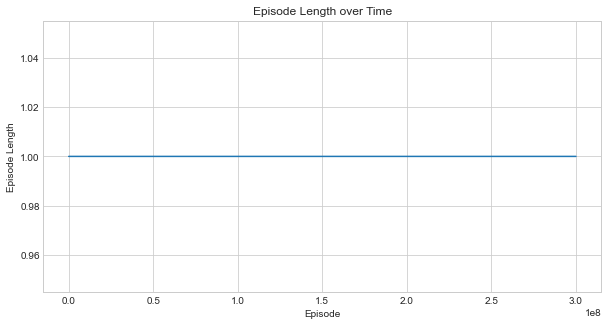

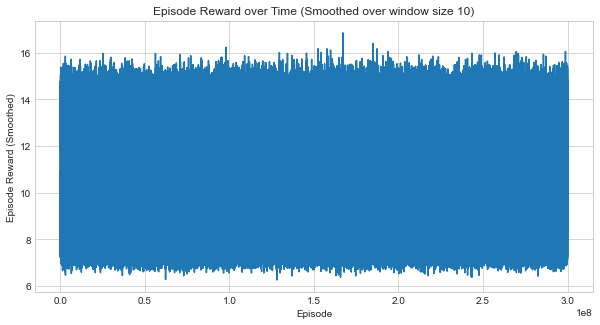

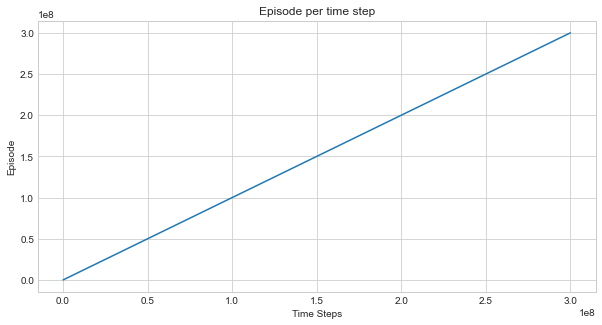

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [10]:
plotting.plot_episode_stats(stats) 

Now we can print the Q-values for each state-action pair.

In [11]:
for key in Q.keys():
    print("Key:", key)
    print("State-Action Values:", Q[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q[key]), actions))

Key: (0, 100)
State-Action Values:
[10.27566617 10.35348578 10.42055456 10.46837153 10.50924744 10.53553357
 10.555489   10.56023731 10.54959941 10.52673034 10.49604716]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (1, 85.0)
State-Action Values:
[9.21954446 9.29021123 9.34607958 9.39199832 9.42794309 9.45523509
 9.46881746 9.4694209  9.46802674 9.44882261 9.41901003]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (2, 102.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 100.0)
State-Action Values:
[10.         10.076346   10.13901027 10.19001617 10.22877326 10.25438368
 10.27143879 10.2721126  10.26264488 10.24505999 10.21187964]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (2, 85.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 70.0)
State-Action Values:
[8.36660027 8.43016719 8.48283904 8.52568154 8.55

Best Action (Investment in risky asset): 0.0
Key: (2, 288.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 154.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 55.00000000000001)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 45.499999999999986)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 71.5)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 168.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 208.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 42.5)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 220.00000000000003)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 176.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 46.75000000000001)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 38.99999999999999)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 133.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 42.249999999999986)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 64.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 165.0)
State-Action Values:
[0. 0. 0. 0. 0.

In [12]:
# How often was each action take in each state
for key, value in A.items():
    print("State: {}, Actions: {}".format(key, value))

State: (0, 100), Actions: [27267585. 27273096. 27270905. 27274981. 27269149. 27265061. 27277671.
 27273584. 27276929. 27275067. 27275972.]
State: (1, 85.0), Actions: [1376729. 1378087. 1375967. 1378464. 1376600. 1376338. 1376266. 1377409.
 1378965. 1377824. 1379548.]
State: (1, 100.0), Actions: [2480807. 2476794. 2481610. 2477972. 2478140. 2479054. 2479098. 2479223.
 2479264. 2477699. 2477924.]
State: (1, 70.0), Actions: [1380433. 1377443. 1376444. 1378996. 1377149. 1376327. 1377515. 1376488.
 1378294. 1377231. 1379002.]
State: (1, 130.0), Actions: [1102799. 1101701. 1101804. 1102199. 1103022. 1102071. 1100692. 1101032.
 1101816. 1102743. 1102905.]
State: (1, 95.0), Actions: [1376785. 1379095. 1377500. 1375995. 1378421. 1377152. 1377029. 1376874.
 1376092. 1375859. 1378640.]
State: (1, 90.0), Actions: [1377238. 1378693. 1377540. 1377653. 1377202. 1375441. 1376345. 1379112.
 1376876. 1376145. 1378997.]
State: (1, 160.0), Actions: [1101339. 1102539. 1102996. 1101203. 1101296. 1102679. 10

Now we can take a look at the Q-value surface for each state-action pair. The predicted optimal actions $argmax_a Q(s,a)$ are indicated as red dots.

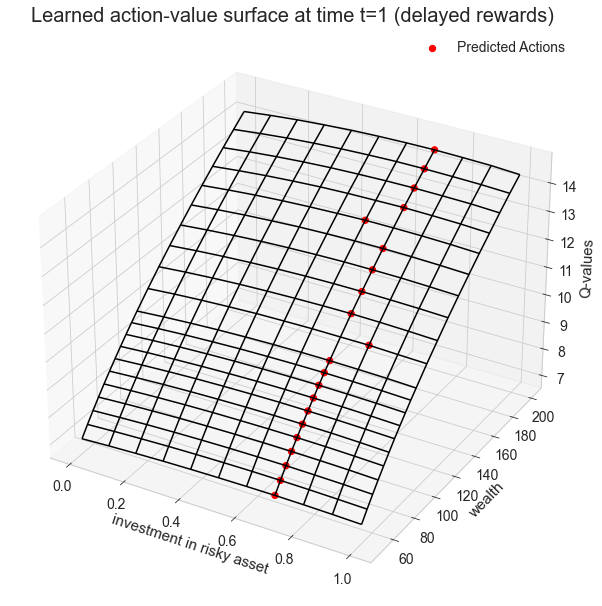

In [13]:
plot_q_values(Q, actions)

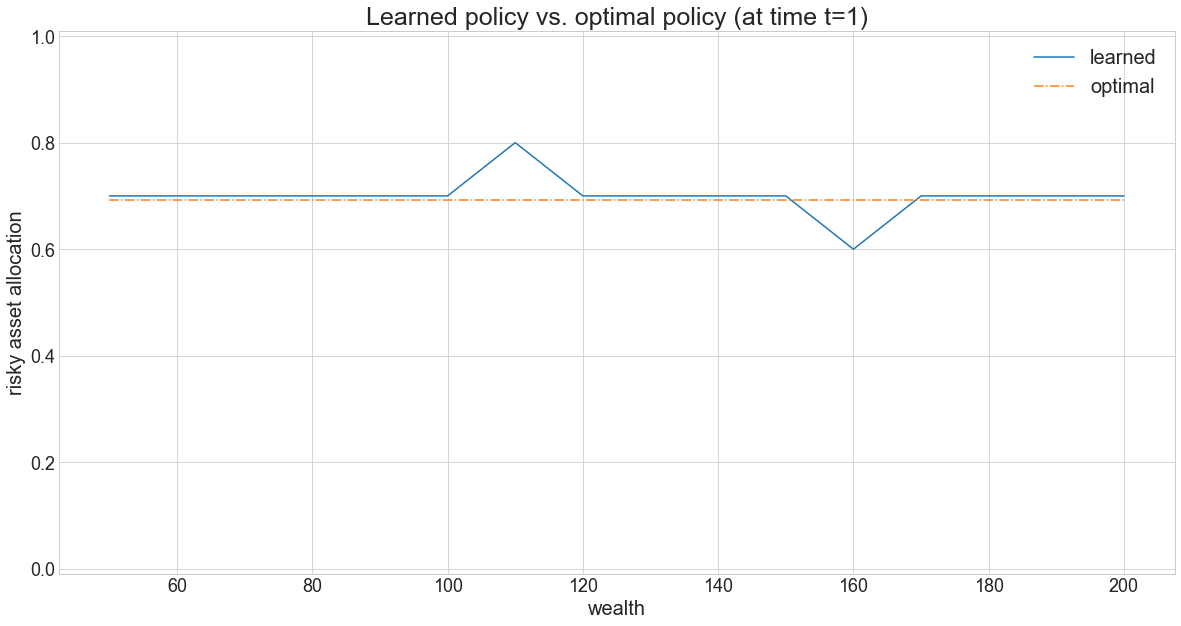

In [28]:
plot_learned_vs_optimal_policy(Q, actions)

We can see that the Q-values seem to be reasonable, as the surface is smooth. The predicted actions take values in the set $\{0.5, 0.6, 0.7, 0.8, 0.9, 1\}$ and most predicted actions seem to be around $0.7$. Still we can observe that even for this small example and training for 2.5m episodes the Q-Learning cannot figure out the theoretical optimal strategy, which is $a_t=0.7\,\, \forall s \in \mathcal{S}$.  

Episode: 0, Mean Return: 8.5, Mean Wealth (V_T): 72.25, Epsilon: 1


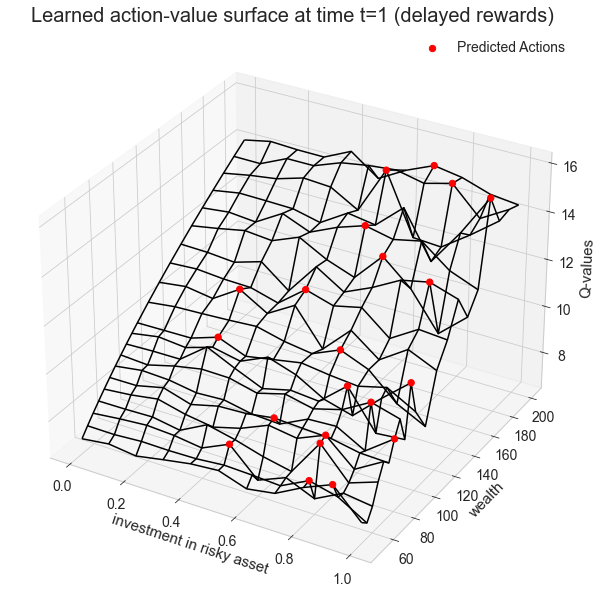

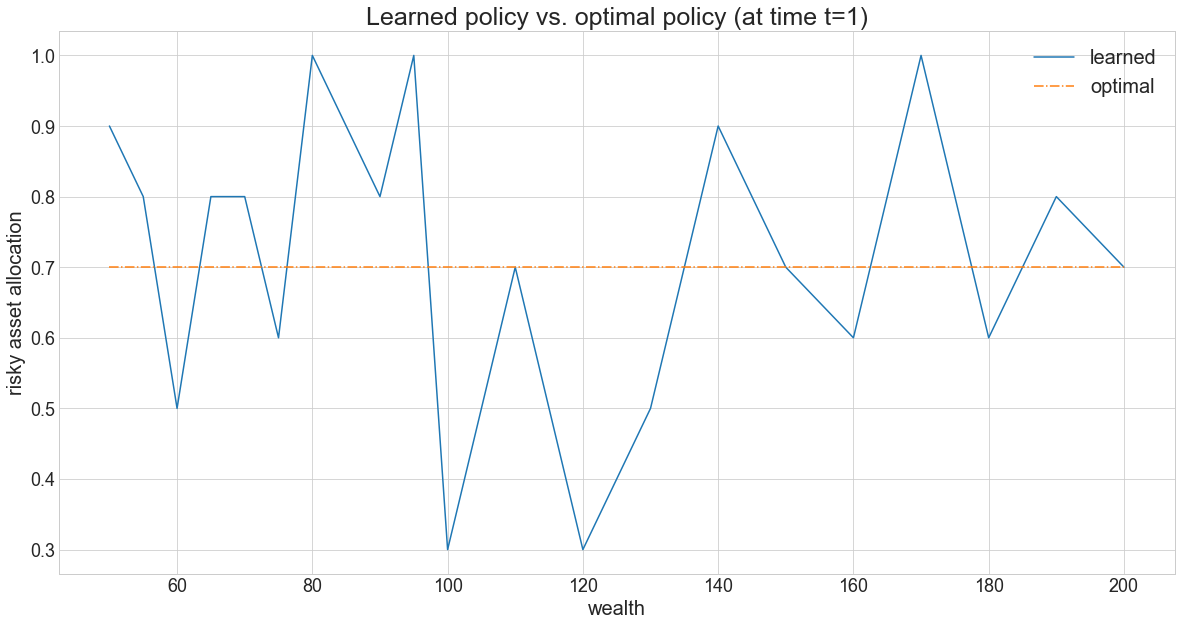

Episode: 10000, Mean Return: 10.359, Mean Wealth (V_T): 116.768, Epsilon: 1
Episode: 20000, Mean Return: 10.33, Mean Wealth (V_T): 115.785, Epsilon: 1
Episode: 30000, Mean Return: 10.382, Mean Wealth (V_T): 117.099, Epsilon: 1
Episode: 40000, Mean Return: 10.391, Mean Wealth (V_T): 117.318, Epsilon: 1
Episode: 50000, Mean Return: 10.45, Mean Wealth (V_T): 118.598, Epsilon: 1
Episode: 60000, Mean Return: 10.389, Mean Wealth (V_T): 117.191, Epsilon: 1
Episode: 70000, Mean Return: 10.416, Mean Wealth (V_T): 117.834, Epsilon: 1
Episode: 80000, Mean Return: 10.454, Mean Wealth (V_T): 118.635, Epsilon: 1
Episode: 90000, Mean Return: 10.409, Mean Wealth (V_T): 117.43, Epsilon: 1
Episode: 100000, Mean Return: 10.452, Mean Wealth (V_T): 118.528, Epsilon: 1
Episode: 110000, Mean Return: 10.361, Mean Wealth (V_T): 116.637, Epsilon: 1
Episode: 120000, Mean Return: 10.404, Mean Wealth (V_T): 117.475, Epsilon: 1
Episode: 130000, Mean Return: 10.339, Mean Wealth (V_T): 116.157, Epsilon: 1
Episode: 14

In [14]:
# Training another Agent for only 5000 episodes
Q2, _, _ = qLearning(env, 500000)

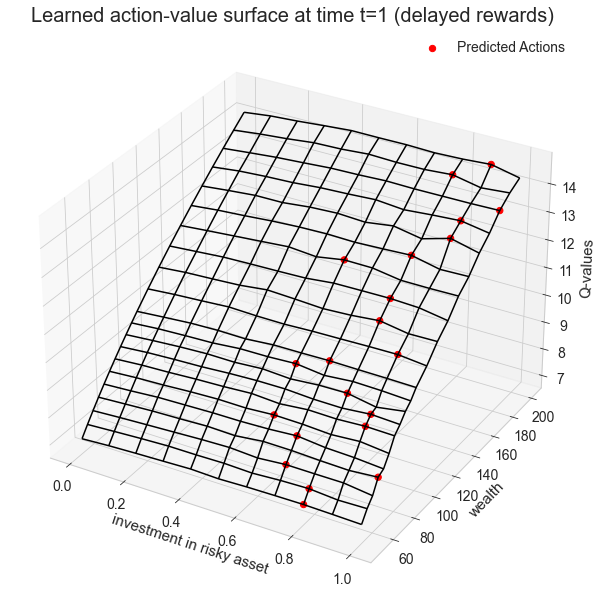

In [15]:
plot_q_values(Q2, actions)

We can observe that after 5000 episodes the Q-value surface is still very rigid. Hence, it seems that the Q-values have not converged yet, and longer training is necessary.

**Assessing the convergence of the Q-value function**

In [16]:
tracking_state = (1, 100.0)
num_episodes   = 5000000
epsilon = 1
discount_factor = 1

# Action value function 
# A nested dictionary that maps 
# state -> (action -> action-value). 
Q3 = defaultdict(lambda: np.zeros(env.action_space.n)) 
A3 = defaultdict(lambda: np.zeros(env.action_space.n))
Q3_tracking_state = []

# Create an epsilon greedy policy function 
# appropriately for environment action space 
policy = createEpsilonGreedyPolicy(Q3, epsilon, env.action_space.n) 

# For every episode
for ith_episode in range(num_episodes): 

    # Reset the environment and pick the first action 
    state = env.reset() 

    for t in itertools.count(): 

        # get probabilities of all actions from current state 
        action_probabilities = policy(state)

        # choose action according to  
        # the probability distribution 
        action = np.random.choice(np.arange( 
                  len(action_probabilities)), 
                   p = action_probabilities)
        A3[state][action] += 1

        # take action and get reward, transit to next state 
        next_state, reward, done, _ = env.step(action)

        # TD Update 
        best_next_action = np.argmax(Q3[next_state])     
        td_target = reward + discount_factor * Q3[next_state][best_next_action]
        td_delta = td_target - Q3[state][action]
        Q3[state][action] += (1/A3[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                       # ensures convergence see Sutton & Barto eq. (2.7)
        # Append updated value of tracking_state
        if state == tracking_state:
            Q3_tracking_state.append(list(Q3[state]))

        # done is True if episode terminated    
        if done: 
            break

        state = next_state

In [17]:
# Select action for corresponding Q(tracking_state, tracking_action)
tracking_action = 7     # i.e. 70% investment in risky asset

Q_tracking_state_tracking_action = [state[tracking_action] for state in Q3_tracking_state]

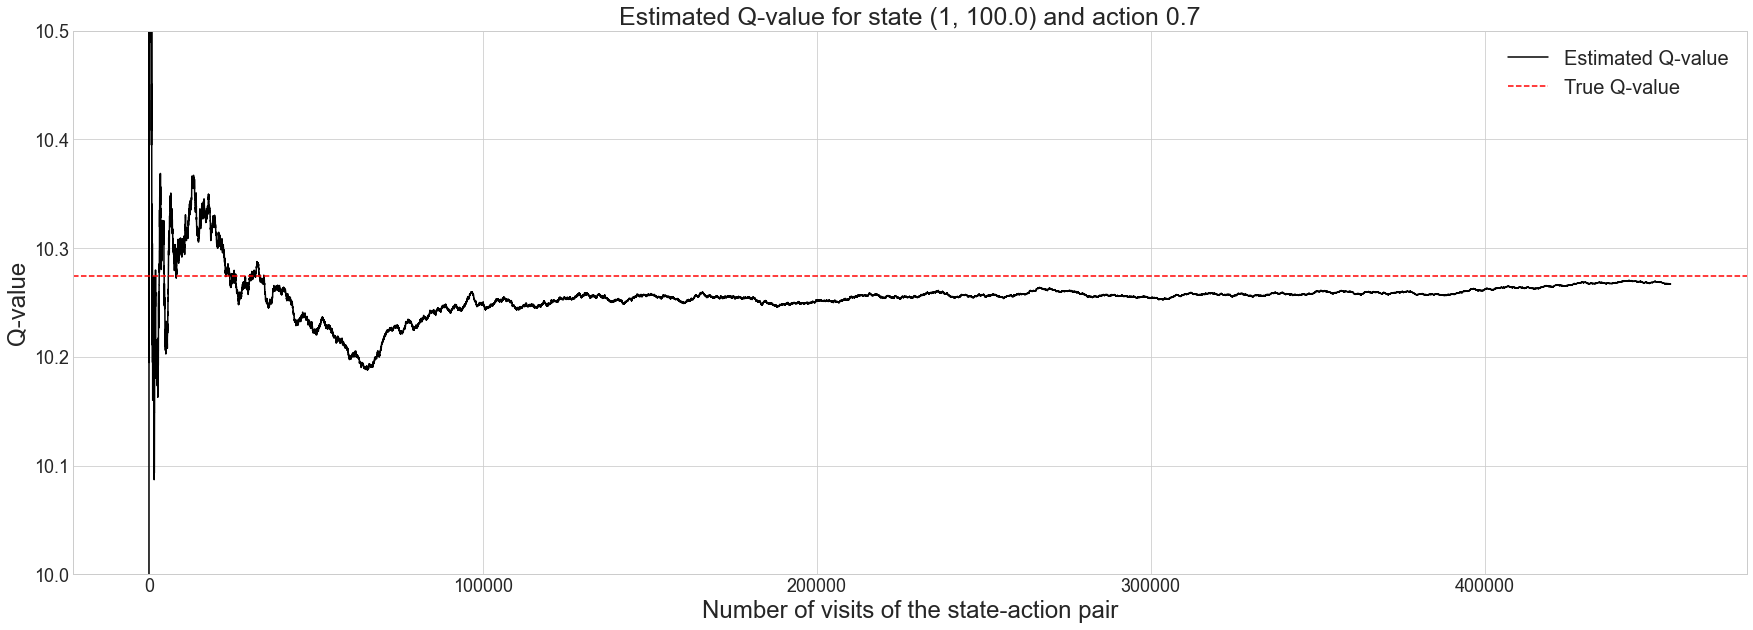

In [20]:
plt.figure(figsize=(30,10))
plt.plot(np.arange(1, len(Q_tracking_state_tracking_action)+1), Q_tracking_state_tracking_action, c="black", label="Estimated Q-value")
plt.axhline(y = 10.274, color = 'r', linestyle = '--', label="True Q-value") 
plt.legend(fontsize=20)
plt.xlabel("Number of visits of the state-action pair", fontsize=24)
plt.ylabel("Q-value", fontsize=24)
plt.title("Estimated Q-value for state {} and action {}".format(tracking_state, round(decode_action(tracking_action, actions), 3)), fontsize=25)
plt.ylim(10, 10.5)
plt.tick_params(axis='both', which='major', labelsize=18)


plt.show()

The true Q-value for action $a_t = 0.7$ can be calculated as 
$$
\mathbb{E}[U(V_2) | V_1 = 100, a_1 = 0.7]
= \frac{4}{9}*\sqrt{100*0.7*2 + 100*(1-0.7)} + \frac{5}{9}*\sqrt{100*0.7*0.5 + 100*(1-0.7)} \approx 10.274
$$

In [19]:
# Save and restore a session
#dill.dump_session('Binomial_stock_price_tree_QLearning_sqrt_utility.db')
#dill.load_session('Binomial_stock_price_tree_QLearning_sqrt_utility.db')